# COCO

In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d ./coco/

--2025-06-15 14:07:22--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.153.12, 16.15.186.134, 16.182.68.169, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.153.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  33.4MB/s    in 7.9s    

2025-06-15 14:07:30 (30.6 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: ./coco/annotations/instances_train2017.json  
  inflating: ./coco/annotations/instances_val2017.json  
  inflating: ./coco/annotations/captions_train2017.json  
  inflating: ./coco/annotations/captions_val2017.json  
  inflating: ./coco/annotations/person_keypoints_train2017.json  
  inflating: ./coco/annotations/person_keypoints_val2017.

In [3]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip -d ./coco/

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: ./coco/val2017/000000212226.jpg  
 extracting: ./coco/val2017/000000231527.jpg  
 extracting: ./coco/val2017/000000578922.jpg  
 extracting: ./coco/val2017/000000062808.jpg  
 extracting: ./coco/val2017/000000119038.jpg  
 extracting: ./coco/val2017/000000114871.jpg  
 extracting: ./coco/val2017/000000463918.jpg  
 extracting: ./coco/val2017/000000365745.jpg  
 extracting: ./coco/val2017/000000320425.jpg  
 extracting: ./coco/val2017/000000481404.jpg  
 extracting: ./coco/val2017/000000314294.jpg  
 extracting: ./coco/val2017/000000335328.jpg  
 extracting: ./coco/val2017/000000513688.jpg  
 extracting: ./coco/val2017/000000158548.jpg  
 extracting: ./coco/val2017/000000132116.jpg  
 extracting: ./coco/val2017/000000415238.jpg  
 extracting: ./coco/val2017/000000321333.jpg  
 extracting: ./coco/val2017/000000081738.jpg  
 extracting: ./coco/val2017/000000577584.jpg  
 extracting: ./coco/val2017/00000034690

# Старое

## Detection attack

In [ ]:
import logging

# --- Attacks for Detection ---
def _get_detection_loss_simplified(model_outputs, targets_detection, device):
    # 1) YOLOv8: список Results с .boxes
    if isinstance(model_outputs, (list, tuple)) and hasattr(model_outputs[0], 'boxes'):
        total_conf = torch.tensor(0.0, device=device)
        total_count = 0
        for res in model_outputs:
            confs = res.boxes.conf  # Tensor [N]
            if confs.numel() > 0:
                total_conf += confs.sum()
                total_count += confs.numel()
        if total_count > 0:
            # хотим понизить confidence ⇒ loss = –mean(conf)
            return - total_conf / total_count
        # нет объектов ⇒ нулевой loss (но нужен grad)
        return torch.tensor(0.0, device=device, requires_grad=True)

    # 2) DETR-стиль: dict с 'pred_logits' или 'logits'
    if isinstance(model_outputs, dict) and ('pred_logits' in model_outputs or 'logits' in model_outputs):
        # Берём pred_logits или logits
        pred_logits = model_outputs.get('pred_logits', model_outputs.get('logits'))
        if pred_logits is None or pred_logits.numel() == 0:
            return torch.tensor(0.0, device=device, requires_grad=True)
        # Максимизируем энтропию (без таргета)
        probs = F.softmax(pred_logits, dim=-1)
        entropy = -(probs * torch.log(probs + 1e-9)).sum(dim=-1)
        return - entropy.mean()

    # 3) Fallback для списка словарей: суммируем любой тензор с grad
    if isinstance(model_outputs, (list, tuple)):
        loss = torch.tensor(0.0, device=device, requires_grad=True)
        for out in model_outputs:
            if isinstance(out, dict):
                for v in out.values():
                    if isinstance(v, torch.Tensor) and v.requires_grad:
                        loss = loss - v.abs().mean()
        return loss

    # 4) Fallback для одного dict
    if isinstance(model_outputs, dict):
        loss = torch.tensor(0.0, device=device, requires_grad=True)
        for v in model_outputs.values():
            if isinstance(v, torch.Tensor) and v.requires_grad:
                loss = loss - v.abs().mean()
        return loss

    # 5) Всё остальное ⇒ просто ноль с grad
    return torch.tensor(0.0, device=device, requires_grad=True)


class FGSM_Detection:
    def __init__(self, model, eps, targeted=False): # model might be used for config
        self.model_ref = model
        self.eps = eps
        self.targeted = targeted # Note: _get_detection_loss_simplified is currently untargeted

    def attack(self, model_obj, x, targets_detection): # model_obj is the callable model
        x_adv = x.clone().detach().requires_grad_(True)
        outputs_adv = model_obj(x_adv)
        loss = _get_detection_loss_simplified(outputs_adv, targets_detection, x.device)

        # Check if loss is a valid tensor that requires grad before backward()
        if isinstance(loss, torch.Tensor) and loss.requires_grad:
            loss.backward()
            if x_adv.grad is not None:
                grad_sign = x_adv.grad.sign()
            else:
                logging.warning("FGSM_Detection: x_adv.grad is None, using random perturbation.")
                grad_sign = torch.zeros_like(x_adv).uniform_(-1,1).sign() # Random direction
            x_adv = x_adv + self.eps * grad_sign # Untargeted: increase loss
        else: # If loss is not usable (e.g. dummy zero loss without grads)
            logging.warning("FGSM_Detection: Loss did not produce gradients. Applying random perturbation.")
            grad_sign = torch.zeros_like(x_adv).uniform_(-1,1).sign() # Random direction
            x_adv = x_adv + self.eps * grad_sign

        x_adv = torch.clamp(x_adv, 0, 1)
        return x_adv.detach()

class PGD_Detection:
    def __init__(self, model, eps, alpha, steps, targeted=False):
        self.model_ref = model
        self.eps = eps; self.alpha = alpha; self.steps = steps
        self.targeted = targeted

    def attack(self, model_obj, x, targets_detection):
        x_adv = x.clone().detach() + torch.zeros_like(x).uniform_(-self.eps, self.eps)
        x_adv = torch.clamp(x_adv, 0, 1)

        for step in range(self.steps):
            x_adv.requires_grad_(True)
            outputs_adv = model_obj(x_adv)
            loss = _get_detection_loss_simplified(outputs_adv, targets_detection, x.device)

            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                if x_adv.grad is not None:
                    grad_sign = x_adv.grad.sign()
                else:
                    logging.warning(f"PGD_Detection step {step}: x_adv.grad is None, applying random step.")
                    grad_sign = torch.zeros_like(x_adv).uniform_(-1,1).sign()
                x_adv_step = x_adv + self.alpha * grad_sign # Untargeted
            else: # Fallback if loss has no grad
                logging.warning(f"PGD_Detection step {_}: Loss did not produce gradients. Applying random step.")
                grad_sign = torch.zeros_like(x_adv).uniform_(-1,1).sign()
                x_adv_step = x_adv + self.alpha * grad_sign

            perturbation = torch.clamp(x_adv_step - x, -self.eps, self.eps)
            x_adv = torch.clamp(x + perturbation, 0, 1).detach()
        return x_adv

## Тестовые стенды

In [ ]:
!pip install ultralytics
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

# YOLOv8
from ultralytics import YOLO

# DETR (HuggingFace)
from transformers import DetrImageProcessor, DetrForObjectDetection

# COCO
from pycocotools.coco import COCO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Пути
coco_img_dir = './coco/val2017'
coco_ann_path = './coco/annotations/instances_val2017.json'

# COCO API
coco = COCO(coco_ann_path)
img_ids = coco.getImgIds()
np.random.shuffle(img_ids)

# Трансформация (ImageNet normalization)
preprocess = transforms.Compose([
    transforms.Resize((800, 800)),    # DETR/YOLO любят 800×800
    transforms.ToTensor(),
])

def load_coco_batch(batch_size=2):
    batch_imgs = []
    batch_pils = []
    batch_info = []
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(coco_img_dir, img_info['file_name'])
        pil_img = Image.open(img_path).convert('RGB')
        img_tensor = preprocess(pil_img)
        batch_imgs.append(img_tensor)
        batch_pils.append(pil_img)
        batch_info.append(img_info)
        if len(batch_imgs) >= batch_size:
            break
    batch_imgs = torch.stack(batch_imgs)   # [B,3,H,W]
    return batch_imgs, batch_pils, batch_info


loading annotations into memory...
Done (t=1.49s)
creating index...
index created!


In [ ]:
# DETR (facebook/detr-resnet-50)
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval()

# YOLOv8 (yolov8n or yolov8s for demo speed)
yolo_model = YOLO('yolov8n.pt')

@torch.no_grad()
def run_detr(images):
    # images: [B,3,H,W], float in [0,1]
    inputs = detr_processor(images=[transforms.ToPILImage()(img.cpu()) for img in images], return_tensors="pt")
    outputs = detr_model(**inputs)
    return outputs

@torch.no_grad()
def run_yolo(images):
    # images: [B,3,H,W], float in [0,1]
    results = yolo_model(images, verbose=False)
    return results


NameError: name 'DetrImageProcessor' is not defined

In [ ]:
import torch
import torch.nn.functional as F

def detection_metrics(outputs, model_type='detr', conf_thresh=0.5):
    """
    outputs: результат model (DETR или YOLOv8)
    model_type: 'detr' или 'yolo'
    conf_thresh: порог для уверенности бокса
    Возвращает:
      - box_count: среднее число детекций на изображение
      - avg_conf: средний confidence бокса
      - avg_entropy: средняя энтропия по logits (DETR only)
    """
    box_count, avg_conf, avg_entropy = 0, 0, 0

    if model_type == 'detr':
        # outputs: transformers Output dict (batch)
        pred_logits = outputs['logits'] if 'logits' in outputs else outputs['pred_logits']  # [B, 100, 92]
        pred_boxes = outputs['pred_boxes'] if 'pred_boxes' in outputs else outputs['boxes']
        probs = F.softmax(pred_logits, dim=-1)  # [B,100,92]
        conf, labels = probs.max(-1)           # [B,100]
        mask = labels != 91                    # DETR "no-object" class = 91
        conf = conf * mask
        det_counts = mask.sum(-1)              # по каждому примеру в батче
        box_count = det_counts.float().mean().item()
        avg_conf = (conf.sum(-1) / (det_counts+1e-6)).mean().item()  # mean per image
        entropy = -(probs * probs.clamp(min=1e-9).log()).sum(-1)     # [B,100]
        avg_entropy = (entropy * mask).sum(-1) / (det_counts+1e-6)
        avg_entropy = avg_entropy.mean().item()
    elif model_type == 'yolo':
        # outputs: список Result
        all_confs = []
        for res in outputs:
            confs = res.boxes.conf
            if len(confs) > 0:
                confs = confs[confs > conf_thresh]
                all_confs.append(confs)
        if len(all_confs) > 0:
            box_count = np.mean([len(c) for c in all_confs])
            avg_conf = torch.cat(all_confs).mean().item()
        else:
            box_count = 0
            avg_conf = 0
        avg_entropy = None  # Нет энтропии
    return box_count, avg_conf, avg_entropy


In [ ]:
BATCH_SIZE = 2
EPS = 4/255
PGD_STEPS = 10
ALPHA = 2/255
use_model = 'detr'    # или 'yolo'

if use_model == 'detr':
    model = detr_model
    attack_fn = lambda x: run_detr(x)
    model_type = 'detr'

fgsm = FGSM_Detection(model, eps=EPS)
pgd = PGD_Detection(model, eps=EPS, alpha=ALPHA, steps=PGD_STEPS)

batch_imgs, batch_pils, batch_info = load_coco_batch(BATCH_SIZE)
x = batch_imgs

# 1. Clean
out_clean = attack_fn(x)
box_count, avg_conf, avg_entropy = detection_metrics(out_clean, model_type)
print(f"Clean: boxes/img={box_count:.2f}, mean conf={avg_conf:.3f}", end='')
if avg_entropy is not None: print(f", mean entropy={avg_entropy:.3f}")

# 2. FGSM
x_fgsm = fgsm.attack(attack_fn, x, targets_detection=None)
out_fgsm = attack_fn(x_fgsm)
box_count, avg_conf, avg_entropy = detection_metrics(out_fgsm, model_type)
print(f"FGSM:  boxes/img={box_count:.2f}, mean conf={avg_conf:.3f}", end='')
if avg_entropy is not None: print(f", mean entropy={avg_entropy:.3f}")

# 3. PGD
x_pgd = pgd.attack(attack_fn, x, targets_detection=None)
out_pgd = attack_fn(x_pgd)
box_count, avg_conf, avg_entropy = detection_metrics(out_pgd, model_type)
print(f"PGD:   boxes/img={box_count:.2f}, mean conf={avg_conf:.3f}", end='')
if avg_entropy is not None: print(f", mean entropy={avg_entropy:.3f}")

# Сохраняем примеры (по желанию)
from torchvision.utils import save_image
save_image(x, "orig_batch.png")
save_image(x_fgsm, "fgsm_batch.png")
save_image(x_pgd, "pgd_batch.png")


Clean: boxes/img=3.50, mean conf=0.764

FGSM:  boxes/img=3.50, mean conf=0.737

PGD:   boxes/img=4.00, mean conf=0.725

In [ ]:
# Проверь в PGD-цикле:
images = x.clone().detach().requires_grad_(True)
out = attack_fn(images)
print(images.grad) # всегда None, grad не появится после loss.backward()


None


In [ ]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*copying from a non-meta parameter in the checkpoint to a meta parameter.*"
)

In [ ]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from pycocotools.coco import COCO
from torchvision import transforms
from PIL import Image
import os

# === CONFIG ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
coco_img_dir = './coco/val2017'
coco_ann_path = './coco/annotations/instances_val2017.json'
BATCH_SIZE = 2
EPS = 4/255
ALPHA = 2/255
PGD_STEPS = 10

# === COCO LOAD ===
coco = COCO(coco_ann_path)
img_ids = coco.getImgIds()
preprocess = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
])

def load_coco_batch(batch_size=2):
    batch_imgs = []
    batch_targets = []
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(coco_img_dir, img_info['file_name'])
        pil_img = Image.open(img_path).convert('RGB')
        img_tensor = preprocess(pil_img)
        # COCO annotations
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        # Format for DETR: {boxes: Tensor[N,4], class_labels: Tensor[N]}
        boxes = []
        class_labels = [] # Changed from labels to class_labels
        for ann in anns:
            bbox = ann['bbox']
            # COCO bbox: [x, y, w, h] -> [x0, y0, x1, y1]
            x0, y0, w, h = bbox
            x1, y1 = x0 + w, y0 + h
            boxes.append([x0, y0, x1, y1])
            class_labels.append(ann['category_id']) # Changed from labels to class_labels
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            class_labels = torch.zeros((0,), dtype=torch.int64) # Changed from labels to class_labels
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            class_labels = torch.tensor(class_labels, dtype=torch.int64) # Changed from labels to class_labels
        batch_imgs.append(img_tensor)
        batch_targets.append({'boxes': boxes, 'class_labels': class_labels}) # Changed from labels to class_labels
        if len(batch_imgs) >= batch_size:
            break
    batch_imgs = torch.stack(batch_imgs)
    return batch_imgs, batch_targets

# === DETR MODEL ===
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)

# === 1. Load a batch ===
x, targets = load_coco_batch(BATCH_SIZE)
x = x.to(device)
for t in targets:
    t['boxes'] = t['boxes'].to(device)
    t['class_labels'] = t['class_labels'].to(device) # Changed from labels to class_labels


# DETR expects pixel_values (with normalization) and targets as list-of-dict
inputs = detr_processor(images=[transforms.ToPILImage()(img.cpu()) for img in x], return_tensors="pt")
pixel_values = inputs['pixel_values'].to(device)  # [B,3,800,800]

# === 2. Clean inference for reference ===
with torch.no_grad():
    out_clean = detr_model(pixel_values=pixel_values)
    # Convert to boxes/scores if хочешь

# === 3. FGSM Attack ===
x_adv = pixel_values.clone().detach().requires_grad_(True)
out = detr_model(pixel_values=x_adv, labels=targets)
loss = out.loss
loss.backward()
x_grad = x_adv.grad.data
x_fgsm = torch.clamp(x_adv + EPS * x_grad.sign(), 0, 1).detach()

# === 4. PGD Attack ===
x_pgd = pixel_values.clone().detach()
for step in range(PGD_STEPS):
    x_pgd.requires_grad_(True)
    out = detr_model(pixel_values=x_pgd, labels=targets)
    loss = out.loss
    loss.backward()
    grad = x_pgd.grad.data
    x_pgd = x_pgd.detach() + ALPHA * grad.sign()
    # Проекция на eps-шар
    x_pgd = torch.max(torch.min(x_pgd, pixel_values + EPS), pixel_values - EPS)
    x_pgd = torch.clamp(x_pgd, 0, 1).detach()

# === 5. Проверка результатов ===
with torch.no_grad():
    out_fgsm = detr_model(pixel_values=x_fgsm)
    out_pgd = detr_model(pixel_values=x_pgd)
    # Для получения боксов/скоров — постпроцессинг
    # Можно использовать detr_processor.post_process_object_detection(...)

print("Done! Теперь out_clean, out_fgsm, out_pgd содержат outputs DETR на clean/FGSM/PGD-примерах.")

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done! Теперь out_clean, out_fgsm, out_pgd содержат outputs DETR на clean/FGSM/PGD-примерах.


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Загрузка модели (n - самая быстрая для тестов)
model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True)
model = model.to(device).eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-6-7 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 



0: 640x640 1 dog, 1 bear, 9.5ms
Speed: 0.1ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 1 car, 1 elephant, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


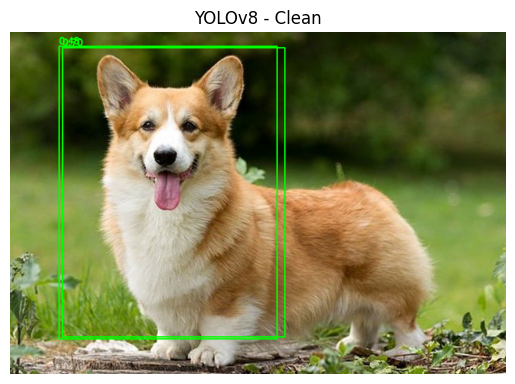

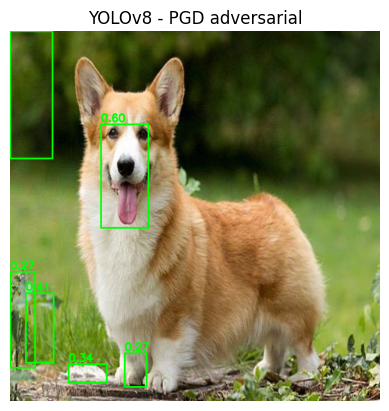

[Clean] Detected: 2, Mean conf: 0.592
[PGD Adv] Detected: 6, Mean conf: 0.360
L∞ perturbation: 0.01569
SCD: 0.7006


In [ ]:
import torch
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === CONFIG ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
YOLO_WEIGHTS = 'yolov8n.pt'
IMG_PATH = '/content/28f0e30e9643b90de06eaac32f59491f.jpg'
TARGET_CLASS = 0  # (0: person для COCO)
EPSILON = 4 / 255
ALPHA = 2 / 255
PGD_STEPS = 10

# === Load image ===
img_pil = Image.open(IMG_PATH).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])
img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)

# === Load YOLOv8 and extract torch model ===
yolo = YOLO(YOLO_WEIGHTS)
model = yolo.model
model.eval().to(DEVICE)

# === Surrogate loss ===
def custom_loss(preds, target_class=None):
    obj = preds[..., 4:5]
    cls = preds[..., 5:]  # [B, n_anchors, n_classes]
    scores = obj * cls  # [B, n_anchors, n_classes]
    if target_class is not None:
        target_scores = scores[..., target_class]
        return -target_scores.mean()
    else:
        return -scores.mean()

# === Forward with autograd: "raw" (до NMS) ===
def forward_raw_logits(model, img_tensor):
    with torch.set_grad_enabled(True):
        preds = model(img_tensor)  # [B, n_anchors, n_feats]
    return preds

# === PGD-атака на сырую голову ===
def pgd_attack_raw(image, model, target_class, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS):
    adv = image.clone().detach().requires_grad_(True)
    orig = image.clone().detach()
    model.train() # Temporarily set to training mode
    for _ in range(iters):
        preds = forward_raw_logits(model, adv)
        if isinstance(preds, (tuple, list)):
            preds = preds[0]  # take first if tuple
        loss = custom_loss(preds, target_class)
        loss.backward()
        grad_sign = adv.grad.sign()
        adv = adv + alpha * grad_sign
        delta = torch.clamp(adv - orig, -epsilon, epsilon)
        adv = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)
    model.eval() # Set back to evaluation mode
    return adv.detach()

# === Attack and inference ===
with torch.no_grad():
    results_clean = yolo(img_tensor)

adv_img_tensor = pgd_attack_raw(img_tensor, model, target_class=TARGET_CLASS)
with torch.no_grad():
    results_adv = yolo(adv_img_tensor)

# === Visualization ===
def show_results(orig_img, results, title):
    img = np.array(orig_img)
    boxes = results[0].boxes.xyxy.cpu().numpy() if hasattr(results[0], "boxes") else []
    confs = results[0].boxes.conf.cpu().numpy() if hasattr(results[0], "boxes") else []
    for box, conf in zip(boxes, confs):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, f"{conf:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_results(img_pil, results_clean, "YOLOv8 - Clean")

# Convert attacked tensor to image
adv_img_np = adv_img_tensor[0].cpu().permute(1,2,0).numpy()
adv_img_np = np.clip(adv_img_np*255, 0, 255).astype(np.uint8)
adv_img_pil = Image.fromarray(adv_img_np)
show_results(adv_img_pil, results_adv, "YOLOv8 - PGD adversarial")

# === Метрики: число боксов, средний confidence ===
def yolo_metrics(results):
    boxes = results[0].boxes
    n_boxes = len(boxes)
    conf_mean = boxes.conf.mean().item() if n_boxes > 0 else 0.
    return n_boxes, conf_mean

clean_n, clean_c = yolo_metrics(results_clean)
adv_n, adv_c = yolo_metrics(results_adv)
print(f"[Clean] Detected: {clean_n}, Mean conf: {clean_c:.3f}")
print(f"[PGD Adv] Detected: {adv_n}, Mean conf: {adv_c:.3f}")

# === L∞-норма шума ===
delta = (adv_img_tensor - img_tensor).abs()
linf = delta.max().item()
print(f"L∞ perturbation: {linf:.5f}")

# === SCD ===
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(results_clean, results_adv, iou_thresh=0.5, conf_min=0.5):
    confident_drops = []
    for cbox, cconf in zip(results_clean[0].boxes.xyxy, results_clean[0].boxes.conf):
        if cconf < conf_min: continue
        matched = False
        for abox, acon in zip(results_adv[0].boxes.xyxy, results_adv[0].boxes.conf):
            if iou(cbox.cpu().numpy(), abox.cpu().numpy()) > iou_thresh:
                confident_drops.append(cconf.item() - acon.item())
                matched = True
                break
        if not matched:
            confident_drops.append(cconf.item())
    return np.mean(confident_drops) if confident_drops else 0

scd = compute_scd(results_clean, results_adv)
print(f"SCD: {scd:.4f}")

Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.
Error: Could not find raw prediction tensor with expected shape [B, n_anchors, 85] in model output.


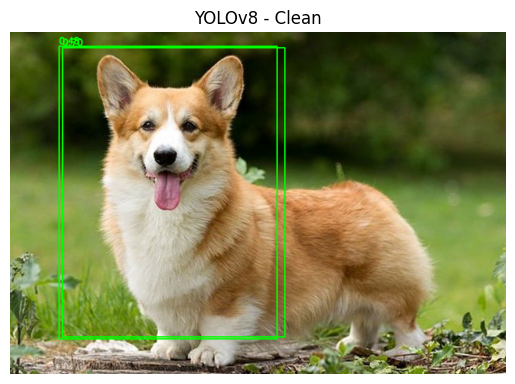

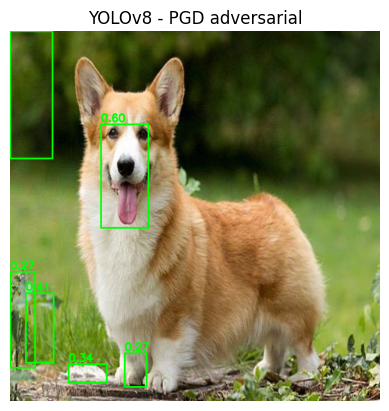

[Clean] Detected: 2, Mean conf: 0.592
[PGD Adv] Detected: 6, Mean conf: 0.360
L∞ perturbation: 0.01569
SCD: 0.7006


In [ ]:
import torch
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === CONFIG ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
YOLO_WEIGHTS = 'yolov8n.pt'   # Можно заменить на свои веса
IMG_PATH = '/content/28f0e30e9643b90de06eaac32f59491f.jpg'  # Укажи свой путь!
TARGET_CLASS = 0              # 0: person для COCO, либо None для нетаргетированной
EPSILON = 4 / 255
ALPHA = 2 / 255
PGD_STEPS = 10

# === Подготовка изображения ===
img_pil = Image.open(IMG_PATH).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])
img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)

# === Загрузка модели (v11+) ===
yolo = YOLO(YOLO_WEIGHTS)
model = yolo.model # Get the underlying torch.nn.Module
model.eval().to(DEVICE)

# === Суррогатная функция потерь ===
def custom_loss(preds, target_class=None):
    # preds: [B, n_anchors, n_feats], feats=(x, y, w, h, obj, c1, c2, ...)
    obj = preds[..., 4:5]
    cls = preds[..., 5:]
    scores = obj * cls
    if target_class is not None:
        # Снижать уверенность для target_class
        target_scores = scores[..., target_class]
        return -target_scores.mean()
    else:
        return -scores.mean()

# === PGD/FGSM атака using model.forward() ===
def pgd_attack(image, model, target_class=None, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS):
    adv = image.clone().detach().requires_grad_(True)
    orig = image.clone().detach()
    model.train()  # Set model to training mode for gradient calculation

    for _ in range(iters):
        # Use model.forward() to get predictions with gradients enabled
        with torch.set_grad_enabled(True):
             preds = model.forward(adv)

             # Explicitly find the raw prediction tensor with shape [B, n_anchors, n_feats]
             raw_preds = None
             expected_last_dim = 4 + 1 + model.nc
             if isinstance(preds, (list, tuple)):
                 for p in preds:
                     if isinstance(p, torch.Tensor) and p.ndim == 3 and p.shape[-1] == expected_last_dim:
                         raw_preds = p
                         break
             elif isinstance(preds, torch.Tensor) and preds.ndim == 3 and preds.shape[-1] == expected_last_dim:
                 raw_preds = preds

        # Check if raw_preds was found
        if raw_preds is None:
             print(f"Error: Could not find raw prediction tensor with expected shape [B, n_anchors, {expected_last_dim}] in model output.")
             # Fallback to the previous heuristic or raise an error
             # For now, we will try the previous fallback to keep it running, but the warning will persist if the shape is still wrong
             if isinstance(preds, (list, tuple)):
                 raw_preds = preds[0] # Fallback
             else:
                 raw_preds = preds # Fallback
             print(f"Warning: Using fallback prediction tensor with shape: {raw_preds.shape}")


        loss = custom_loss(raw_preds, target_class)
        # print(f"Step {_}: Loss = {loss.item()}") # Optional: print loss per step

        if loss.requires_grad:
            loss.backward()
            if adv.grad is not None:
                grad_sign = adv.grad.sign()
                adv = adv + alpha * grad_sign
                delta = torch.clamp(adv - orig, -epsilon, epsilon)
                adv = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)
            else:
                print("Gradient is None. Skipping update.")
                break # Exit loop if no gradient
        else:
             print("Loss does not require grad. Skipping update.")
             break # Exit loop if loss doesn't require grad

    # Ensure requires_grad is False for the final adversarial image
    model.eval() # Set model back to evaluation mode
    return adv.detach()

# === Атака и инференс ===
# Note: We will use the 'yolo' object directly for clean and adversarial inference
with torch.no_grad():
    results_clean = yolo(img_tensor, verbose=False)

# Perform the attack using the underlying torch model and the raw logits approach
adv_img_tensor = pgd_attack(img_tensor, model, target_class=TARGET_CLASS)

# Use the original yolo object for inference on the adversarial image
with torch.no_grad():
    results_adv = yolo(adv_img_tensor, verbose=False)

# === Визуализация ===
def show_results(orig_img, results, title):
    img = np.array(orig_img)
    boxes = results[0].boxes.xyxy.cpu().numpy() if hasattr(results[0], "boxes") and results[0].boxes is not None else []
    confs = results[0].boxes.conf.cpu().numpy() if hasattr(results[0], "boxes") and results[0].boxes is not None else []
    for box, conf in zip(boxes, confs):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, f"{conf:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_results(img_pil, results_clean, "YOLOv8 - Clean")
# Переводим атакованное изображение обратно в PIL
adv_img_np = adv_img_tensor[0].cpu().permute(1,2,0).numpy()
adv_img_np = np.clip(adv_img_np*255, 0, 255).astype(np.uint8)
adv_img_pil = Image.fromarray(adv_img_np)
show_results(adv_img_pil, results_adv, "YOLOv8 - PGD adversarial")

# === Метрики: число боксов, средний confidence ===
def yolo_metrics(results):
    boxes = results[0].boxes if hasattr(results[0], "boxes") and results[0].boxes is not None else []
    n_boxes = len(boxes)
    conf_mean = boxes.conf.mean().item() if n_boxes > 0 else 0.
    return n_boxes, conf_mean

clean_n, clean_c = yolo_metrics(results_clean)
adv_n, adv_c = yolo_metrics(results_adv)
print(f"[Clean] Detected: {clean_n}, Mean conf: {clean_c:.3f}")
print(f"[PGD Adv] Detected: {adv_n}, Mean conf: {adv_c:.3f}")

# === L∞-норма шума ===
delta = (adv_img_tensor - img_tensor).abs()
linf = delta.max().item()
print(f"L∞ perturbation: {linf:.5f}")

# === SCD ===
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxA[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(results_clean, results_adv, iou_thresh=0.5, conf_min=0.5):
    confident_drops = []
    clean_boxes = results_clean[0].boxes if hasattr(results_clean[0], "boxes") and results_clean[0].boxes is not None else []
    adv_boxes = results_adv[0].boxes if hasattr(results_adv[0], "boxes") and results_adv[0].boxes is not None else []

    for cbox, cconf in zip(clean_boxes.xyxy, clean_boxes.conf):
        if cconf < conf_min: continue
        matched = False
        for abox, acon in zip(adv_boxes.xyxy, adv_boxes.conf):
            if iou(cbox.cpu().numpy(), abox.cpu().numpy()) > iou_thresh:
                confident_drops.append(cconf.item() - acon.item())
                matched = True
                break
        if not matched:
            confident_drops.append(cconf.item())
    return np.mean(confident_drops) if confident_drops else 0

scd = compute_scd(results_clean, results_adv)
print(f"SCD: {scd:.4f}")


0: 640x640 1 dog, 1 bear, 9.4ms
Speed: 0.1ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 sheep, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


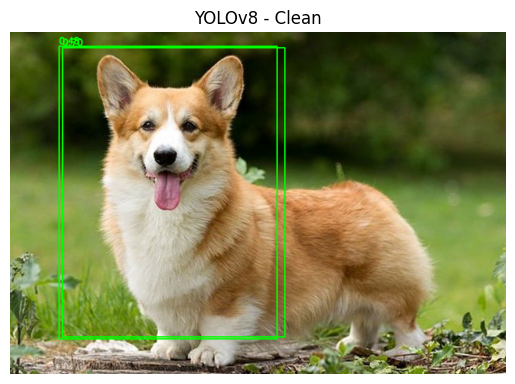

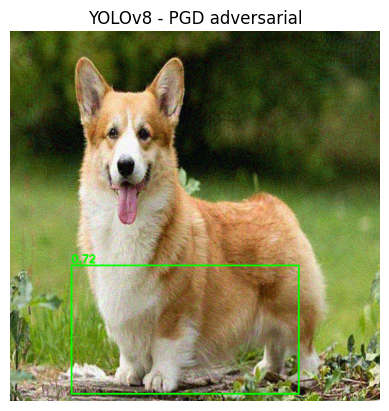

[Clean] Detected: 2, Mean conf: 0.592
[PGD Adv] Detected: 1, Mean conf: 0.722
L∞ perturbation: 0.06275
SCD: 0.7006


In [ ]:
import torch
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === CONFIG ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
YOLO_WEIGHTS = 'yolov8n.pt'   # Можно заменить на свои веса
IMG_PATH = '/content/28f0e30e9643b90de06eaac32f59491f.jpg'  # Укажи свой путь!
TARGET_CLASS = 0              # 0: person для COCO, либо None для нетаргетированной
EPSILON = 16 / 255
ALPHA = 5 / 255
PGD_STEPS = 1000

# === Подготовка изображения ===
img_pil = Image.open(IMG_PATH).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])
img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)

# === Загрузка модели (v11+) ===
yolo = YOLO(YOLO_WEIGHTS)
model = yolo.model
model.eval().to(DEVICE)

# === Суррогатная функция потерь ===
def custom_loss(preds, target_class=None):
    # preds: [B, n_anchors, n_feats], feats=(x, y, w, h, obj, c1, c2, ...)
    obj = preds[..., 4:5]
    cls = preds[..., 5:]
    scores = obj * cls
    if target_class is not None:
        # Снижать уверенность для target_class
        target_scores = scores[..., target_class]
        return -target_scores.mean()
    else:
        return -scores.mean()

# === Forward: получить сырые выходы головы (поддерживается в v11+) ===
def forward_raw_logits(model, img_tensor):
    x = img_tensor
    outputs = []
    for i, m in enumerate(model.model):
        # Поддержка skip connections
        if hasattr(m, 'f') and m.f != -1:
            if isinstance(m.f, int):
                x_in = outputs[m.f]
            else:
                x_in = [outputs[j] for j in m.f]
            x = m(x_in)
        else:
            x = m(x)
        outputs.append(x)
    out = outputs[-1]
    if isinstance(out, (tuple, list)):
        out = out[0]
    out = out.permute(0,2,3,1).reshape(out.shape[0], -1, out.shape[1])
    return out




def pgd_attack_raw(image, model, target_class=None, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS):
    adv = image.clone().detach().requires_grad_(True)
    orig = image.clone().detach()
    model.train()
    for _ in range(iters):
        preds = forward_raw_logits(model, adv)
        loss = custom_loss(preds, target_class)
        loss.backward()
        grad_sign = adv.grad.sign()
        adv = adv + alpha * grad_sign
        delta = torch.clamp(adv - orig, -epsilon, epsilon)
        adv = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)
    model.eval()
    return adv.detach()


# === Атака и инференс ===
with torch.no_grad():
    results_clean = yolo(img_tensor)

adv_img_tensor = pgd_attack_raw(img_tensor, model, target_class=TARGET_CLASS)
with torch.no_grad():
    results_adv = yolo(adv_img_tensor)

# === Визуализация ===
def show_results(orig_img, results, title):
    img = np.array(orig_img)
    boxes = results[0].boxes.xyxy.cpu().numpy() if hasattr(results[0], "boxes") else []
    confs = results[0].boxes.conf.cpu().numpy() if hasattr(results[0], "boxes") else []
    for box, conf in zip(boxes, confs):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, f"{conf:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_results(img_pil, results_clean, "YOLOv8 - Clean")
# Переводим атакованное изображение обратно в PIL
adv_img_np = adv_img_tensor[0].cpu().permute(1,2,0).numpy()
adv_img_np = np.clip(adv_img_np*255, 0, 255).astype(np.uint8)
adv_img_pil = Image.fromarray(adv_img_np)
show_results(adv_img_pil, results_adv, "YOLOv8 - PGD adversarial")

# === Метрики: число боксов, средний confidence ===
def yolo_metrics(results):
    boxes = results[0].boxes
    n_boxes = len(boxes)
    conf_mean = boxes.conf.mean().item() if n_boxes > 0 else 0.
    return n_boxes, conf_mean

clean_n, clean_c = yolo_metrics(results_clean)
adv_n, adv_c = yolo_metrics(results_adv)
print(f"[Clean] Detected: {clean_n}, Mean conf: {clean_c:.3f}")
print(f"[PGD Adv] Detected: {adv_n}, Mean conf: {adv_c:.3f}")

# === L∞-норма шума ===
delta = (adv_img_tensor - img_tensor).abs()
linf = delta.max().item()
print(f"L∞ perturbation: {linf:.5f}")

# === SCD ===
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(results_clean, results_adv, iou_thresh=0.5, conf_min=0.5):
    confident_drops = []
    for cbox, cconf in zip(results_clean[0].boxes.xyxy, results_clean[0].boxes.conf):
        if cconf < conf_min: continue
        matched = False
        for abox, acon in zip(results_adv[0].boxes.xyxy, results_adv[0].boxes.conf):
            if iou(cbox.cpu().numpy(), abox.cpu().numpy()) > iou_thresh:
                confident_drops.append(cconf.item() - acon.item())
                matched = True
                break
        if not matched:
            confident_drops.append(cconf.item())
    return np.mean(confident_drops) if confident_drops else 0

scd = compute_scd(results_clean, results_adv)
print(f"SCD: {scd:.4f}")


loading annotations into memory...
Done (t=0.68s)
creating index...
index created!

0: 640x640 2 persons, 1 cup, 3 spoons, 5 bowls, 1 oven, 6.8ms
1: 640x640 5 oranges, 1 dining table, 1 oven, 1 refrigerator, 6.8ms
Speed: 0.0ms preprocess, 6.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10 bottles, 2 knifes, 5.7ms
1: 640x640 5 bottles, 1 toilet, 5.7ms
Speed: 0.0ms preprocess, 5.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


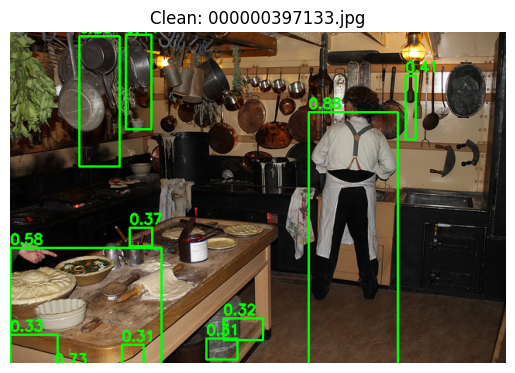

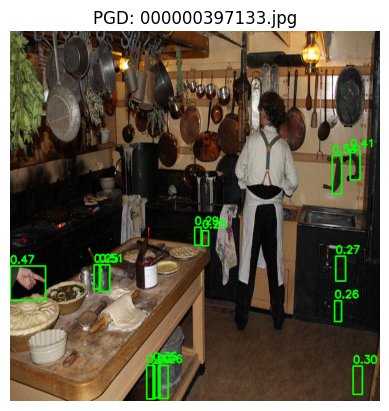

Batch 1: Clean: 12 (0.436) | Adv: 13 (0.342) | L∞: 0.01569 | SCD: 0.7300

0: 640x640 3 persons, 1 traffic light, 1 suitcase, 1 chair, 5.7ms
1: 640x640 10 persons, 1 bicycle, 1 skateboard, 5.7ms
Speed: 0.0ms preprocess, 5.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 4.0ms
1: 640x640 4 persons, 4 bottles, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Batch 2: Clean: 6 (0.665) | Adv: 2 (0.786) | L∞: 0.01569 | SCD: 0.4133

0: 640x640 1 bicycle, 5 cars, 2 trucks, 5.6ms
1: 640x640 1 bottle, 1 toilet, 1 sink, 5.6ms
Speed: 0.0ms preprocess, 5.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 2 buss, 4.0ms
1: 640x640 8 bottles, 1 toilet, 1 sink, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Batch 3: Clean: 8 (0.594) | Adv: 7 (0.520) | L∞: 0.01569 | SCD: 0.3320

== SUMMARY ==
Boxes: clean 8.67 → ad

In [ ]:
import torch
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# === CONFIG ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
YOLO_WEIGHTS = 'yolov8n.pt'
COCO_IMG_DIR = './coco/val2017'  # Путь к папке с COCO-вал изображениями
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
BATCH_SIZE = 2
NUM_BATCHES = 3  # Можно увеличить
TARGET_CLASS = 0  # None для нетаргетированной
EPSILON = 4/255
ALPHA = 2/255
PGD_STEPS = 10

# === Загрузка COCO ===
coco = COCO(COCO_ANN_PATH)
img_ids = coco.getImgIds()

preprocess = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

# === Загрузка модели ===
yolo = YOLO(YOLO_WEIGHTS)
model = yolo.model
model.eval().to(DEVICE)

# === Custom loss ===
def custom_loss(preds, target_class=None):
    obj = preds[..., 4:5]
    cls = preds[..., 5:]
    scores = obj * cls
    if target_class is not None:
        target_scores = scores[..., target_class]
        return -target_scores.mean()
    else:
        return -scores.mean()

# === Forward: ручной проход с поддержкой skip-connection ===
def forward_raw_logits(model, img_tensor):
    x = img_tensor
    outputs = []
    for m in model.model:
        # Поддержка skip connections
        if hasattr(m, 'f') and m.f != -1:
            if isinstance(m.f, int):
                x_in = outputs[m.f]
            else:
                x_in = [outputs[j] for j in m.f]
            x = m(x_in)
        else:
            x = m(x)
        outputs.append(x)
    out = outputs[-1]
    if isinstance(out, (tuple, list)):
        out = out[0]
    out = out.permute(0,2,3,1).reshape(out.shape[0], -1, out.shape[1])
    return out

# === PGD attack ===
def pgd_attack_raw(image, model, target_class=None, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS):
    adv = image.clone().detach().requires_grad_(True)
    orig = image.clone().detach()
    model.train()
    for _ in range(iters):
        preds = forward_raw_logits(model, adv)
        loss = custom_loss(preds, target_class)
        loss.backward()
        grad_sign = adv.grad.sign()
        adv = adv + alpha * grad_sign
        delta = torch.clamp(adv - orig, -epsilon, epsilon)
        adv = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)
    model.eval()
    return adv.detach()

# === SCD metric ===
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(results_clean, results_adv, iou_thresh=0.5, conf_min=0.5):
    confident_drops = []
    for cbox, cconf in zip(results_clean[0].boxes.xyxy, results_clean[0].boxes.conf):
        if cconf < conf_min: continue
        matched = False
        for abox, acon in zip(results_adv[0].boxes.xyxy, results_adv[0].boxes.conf):
            if iou(cbox.cpu().numpy(), abox.cpu().numpy()) > iou_thresh:
                confident_drops.append(cconf.item() - acon.item())
                matched = True
                break
        if not matched:
            confident_drops.append(cconf.item())
    return np.mean(confident_drops) if confident_drops else 0

def show(img, res, title):
    img_vis = img.copy()
    if img_vis.ndim == 2:  # Grayscale to BGR
        img_vis = cv2.cvtColor(img_vis, cv2.COLOR_GRAY2BGR)
    # Важно: cv2 работает с BGR, matplotlib — с RGB!
    if len(res[0].boxes) > 0:
        for box, conf in zip(res[0].boxes.xyxy.cpu().numpy(), res[0].boxes.conf.cpu().numpy()):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img_vis, f"{conf:.2f}", (x1, max(0, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()



# === Валидация по COCO ===
all_stats = []
for b in range(NUM_BATCHES):
    batch_imgs = []
    img_names = []
    for img_id in img_ids[b*BATCH_SIZE:(b+1)*BATCH_SIZE]:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(COCO_IMG_DIR, img_info['file_name'])
        img_pil = Image.open(img_path).convert('RGB')
        img_tensor = preprocess(img_pil)
        batch_imgs.append(img_tensor)
        img_names.append(img_info['file_name'])
    batch_imgs = torch.stack(batch_imgs).to(DEVICE)

    # Clean inference
    with torch.no_grad():
        results_clean = yolo(batch_imgs)

    # PGD attack
    adv_imgs = pgd_attack_raw(batch_imgs, model, target_class=TARGET_CLASS)
    with torch.no_grad():
        results_adv = yolo(adv_imgs)

    # Метрики
    clean_boxes = results_clean[0].boxes
    adv_boxes = results_adv[0].boxes

    clean_n = len(clean_boxes)
    clean_c = clean_boxes.conf.mean().item() if clean_n > 0 else 0.
    adv_n = len(adv_boxes)
    adv_c = adv_boxes.conf.mean().item() if adv_n > 0 else 0.

    delta = (adv_imgs - batch_imgs).abs()
    linf = delta.max().item()
    scd = compute_scd(results_clean, results_adv)

    # Для визуализации первой картинки в батче
    if b == 0:
        img = cv2.imread(os.path.join(COCO_IMG_DIR, img_names[0]))  # сразу в BGR
        show(img, results_clean, f"Clean: {img_names[0]}")
        # Для adv
        adv_img_np = adv_imgs[0].detach().cpu().permute(1,2,0).numpy()
        adv_img_np = np.clip(adv_img_np*255, 0, 255).astype(np.uint8)
        show(cv2.cvtColor(adv_img_np, cv2.COLOR_RGB2BGR), results_adv, f"PGD: {img_names[0]}")

    print(f"Batch {b+1}: Clean: {clean_n} ({clean_c:.3f}) | Adv: {adv_n} ({adv_c:.3f}) | L∞: {linf:.5f} | SCD: {scd:.4f}")
    all_stats.append([clean_n, clean_c, adv_n, adv_c, linf, scd])

# === Усреднённая статистика по батчам ===
all_stats = np.array(all_stats)
print("\n== SUMMARY ==")
print(f"Boxes: clean {all_stats[:,0].mean():.2f} → adv {all_stats[:,2].mean():.2f}")
print(f"Mean conf: clean {all_stats[:,1].mean():.3f} → adv {all_stats[:,3].mean():.3f}")
print(f"L∞ perturbation: {all_stats[:,4].mean():.5f}")
print(f"SCD: {all_stats[:,5].mean():.4f}")

# mAP на чистых/adv если нужно — пиши!

In [ ]:
import torch
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import cv2
import os
from tqdm import tqdm

# === CONFIG ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
YOLO_WEIGHTS = 'yolov8n.pt'
COCO_IMG_DIR = '/content/coco/val2017'        # Укажи путь к картинкам
COCO_ANN_PATH = '/content/coco/annotations/instances_val2017.json'
TARGET_CLASS = 0
EPSILON = 4 / 255
ALPHA = 2 / 255
PGD_STEPS = 10

# === MODEL & PREPROCESS ===
yolo = YOLO(YOLO_WEIGHTS)
model = yolo.model
model.eval().to(DEVICE)

preprocess = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

def custom_loss(preds, target_class=None):
    obj = preds[..., 4:5]
    cls = preds[..., 5:]
    scores = obj * cls
    if target_class is not None:
        target_scores = scores[..., target_class]
        return -target_scores.mean()
    else:
        return -scores.mean()

def forward_raw_logits(model, img_tensor):
    x = img_tensor
    outputs = []
    for m in model.model:
        if hasattr(m, 'f') and m.f != -1:
            if isinstance(m.f, int):
                x_in = outputs[m.f]
            else:
                x_in = [outputs[j] for j in m.f]
            x = m(x_in)
        else:
            x = m(x)
        outputs.append(x)
    out = outputs[-1]
    if isinstance(out, (tuple, list)):
        out = out[0]
    out = out.permute(0,2,3,1).reshape(out.shape[0], -1, out.shape[1])
    return out

def pgd_attack_raw(image, model, target_class=None, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS):
    adv = image.clone().detach().requires_grad_(True)
    orig = image.clone().detach()
    model.train()
    for _ in range(iters):
        preds = forward_raw_logits(model, adv)
        loss = custom_loss(preds, target_class)
        loss.backward()
        grad_sign = adv.grad.sign()
        adv = adv + alpha * grad_sign
        delta = torch.clamp(adv - orig, -epsilon, epsilon)
        adv = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)
    model.eval()
    return adv.detach()

def yolo_metrics(results):
    boxes = results[0].boxes
    n_boxes = len(boxes)
    conf_mean = boxes.conf.mean().item() if n_boxes > 0 else 0.
    return n_boxes, conf_mean

# === LOAD COCO ANNOTATIONS ===
coco = COCO(COCO_ANN_PATH)
img_ids = coco.getImgIds()
img_infos = coco.loadImgs(img_ids)

all_clean_boxes, all_adv_boxes = [], []
all_clean_confs, all_adv_confs = [], []

for img_info in tqdm(img_infos, desc='COCO val loop'):
    img_path = os.path.join(COCO_IMG_DIR, img_info['file_name'])
    try:
        img_pil = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Failed to open {img_path}: {e}")
        continue
    img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        results_clean = yolo(img_tensor, verbose=False)
    adv_img_tensor = pgd_attack_raw(img_tensor, model, target_class=TARGET_CLASS)
    with torch.no_grad():
        results_adv = yolo(adv_img_tensor, verbose=False)

    clean_n, clean_c = yolo_metrics(results_clean)
    adv_n, adv_c = yolo_metrics(results_adv)

    all_clean_boxes.append(clean_n)
    all_clean_confs.append(clean_c)
    all_adv_boxes.append(adv_n)
    all_adv_confs.append(adv_c)

# === SUMMARY ===
print(f"Avg clean detections: {np.mean(all_clean_boxes):.2f}, mean conf: {np.mean(all_clean_confs):.3f}")
print(f"Avg adv detections:   {np.mean(all_adv_boxes):.2f}, mean conf: {np.mean(all_adv_confs):.3f}")
print(f"Δ Detections: {np.mean(all_adv_boxes) - np.mean(all_clean_boxes):+.2f}")
print(f"Δ Conf: {np.mean(all_adv_confs) - np.mean(all_clean_confs):+.3f}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 94.9MB/s]


loading annotations into memory...
Done (t=1.48s)
creating index...
index created!


COCO val loop: 100%|██████████| 5000/5000 [14:51<00:00,  5.61it/s]

Avg clean detections: 5.11, mean conf: 0.596
Avg adv detections:   5.76, mean conf: 0.412
Δ Detections: +0.65
Δ Conf: -0.183


In [ ]:
# Install detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-cr3e09cs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-cr3e09cs
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.0 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6438659 sha256=1b4a06fa5c6ef64830d4f1388487d28b214452f3120a2fd0c97fc7750c814e19
  Stored in directory: /tmp/pip-ephem-wheel-cache-z70i4kld/wheels/17/d9/40/60db98e485aa9455

[Clean] Detected 2 objects, mean conf: 0.758
Step 0: Mean Conf (Adv)=0.933, linf=0.00784
Step 10: Mean Conf (Adv)=0.736, linf=0.06275
Step 20: Mean Conf (Adv)=0.812, linf=0.06275
Step 30: Mean Conf (Adv)=0.759, linf=0.06275
Step 40: Mean Conf (Adv)=0.727, linf=0.06275
Step 50: Mean Conf (Adv)=0.749, linf=0.06275
Step 60: Mean Conf (Adv)=0.604, linf=0.06275
Step 70: Mean Conf (Adv)=0.713, linf=0.06275
Step 80: Mean Conf (Adv)=0.604, linf=0.06275
Step 90: Mean Conf (Adv)=0.621, linf=0.06275
Step 99: Mean Conf (Adv)=0.557, linf=0.06275


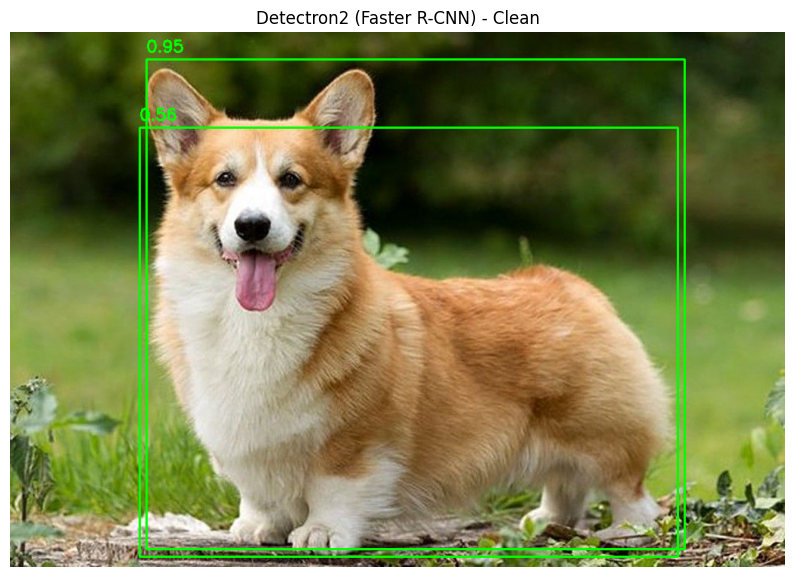

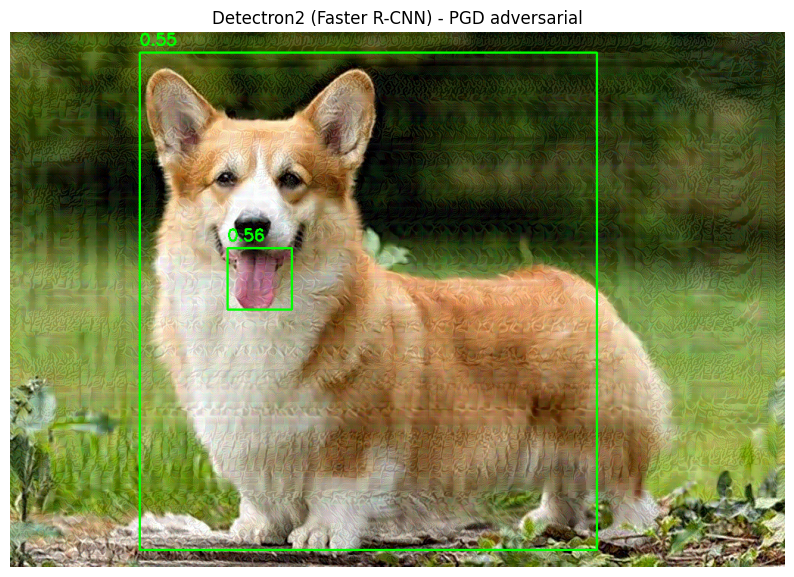

[Adv] Detected 2 objects, mean conf: 0.557
L∞ perturbation: 0.06275
SCD: 0.2044


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from PIL import Image
from detectron2.structures import ImageList

# === CONFIG ===
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_PATH = '/content/28f0e30e9643b90de06eaac32f59491f.jpg'

# === Load config and model ===
cfg = get_cfg()
cfg.MODEL.DEVICE = DEVICE
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # Keep for predictor, but attack bypasses it

predictor = DefaultPredictor(cfg)

# ===== Load raw torch model =====
model = build_model(cfg)
# Keep model in eval mode for attack
model.eval()
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.to(DEVICE)

# === Load image, preprocessing ===
img_bgr = cv2.imread(IMG_PATH)
assert img_bgr is not None, f"Can't read image: {IMG_PATH}"

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
img_tensor = torch.from_numpy(np.asarray(img_pil)).permute(2, 0, 1).float() / 255.0  # [C,H,W], float, 0..1
img_tensor = img_tensor.unsqueeze(0).to(DEVICE)  # [1,3,H,W]

# Detectron2: normalization
mean = torch.tensor(cfg.MODEL.PIXEL_MEAN).view(3,1,1).to(DEVICE)
std = torch.tensor(cfg.MODEL.PIXEL_STD).view(3,1,1).to(DEVICE)

# === Clean inference for reference ===
with torch.no_grad():
    out_clean = predictor(img_bgr.copy())
    instances_clean = out_clean["instances"]
    print(f"[Clean] Detected {len(instances_clean)} objects, mean conf: {instances_clean.scores.mean().item():.3f}")

# ====== PGD ATTACK (on raw ROI head outputs) ======
EPSILON = 16/255
ALPHA = 2/255
PGD_STEPS = 100

# Function to get raw outputs from ROI head (classification logits and box regression deltas)
def get_raw_roi_outputs(model, img_tensor_norm):
    # This requires understanding the internal structure of the Faster R-CNN model in Detectron2
    # In eval mode, the forward pass typically does:
    # 1. Backbone + FPN -> features
    # 2. RPN -> proposals
    # 3. ROIHead (takes features and proposals) -> box_features, pred_logits, pred_deltas
    # We want pred_logits and pred_deltas before post-processing (like NMS)

    images = ImageList.from_tensors([img_tensor_norm[0]], model.backbone.size_divisibility)
    features = model.backbone(images.tensor)
    proposals, _ = model.proposal_generator(images, features, None) # None for gt_instances in eval mode
    # Pass proposals and features to ROI head
    # The ROI head's forward method in eval mode returns instances after post-processing.
    # We need to call its internal methods to get raw outputs.
    # Let's try to access the ROI head and call its _forward_box method
    # This is a bit hacky and relies on internal API which might change.

    if hasattr(model, 'roi_heads') and hasattr(model.roi_heads, '_forward_box'):
        # Assuming _forward_box takes features and proposals and returns predictions
        # Check the signature of _forward_box if possible, it might also need instances or other args
        # Looking at Detectron2 source, _forward_box takes features and proposals
        # Convert features dictionary to a list of tensors for the pooler
        features_list = [features[f] for f in model.roi_heads.box_in_features]
        box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
        box_features = model.roi_heads.box_head(box_features)
        pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(box_features)
        return pred_class_logits, pred_proposal_deltas, proposals
    else:
        raise NotImplementedError("Could not access raw ROI head outputs. Model structure might be different or internal methods changed.")


# Surrogate loss based on raw classification logits
def custom_attack_loss(pred_class_logits, target_class=None):
    # pred_class_logits: [N, num_classes] tensor from ROI head
    # N is the number of proposals
    probs = torch.softmax(pred_class_logits, dim=-1)
    if target_class is not None:
        # Minimize confidence of the target class
        # This is a targeted attack to make the model less confident about the target class
        # The loss should be positive for successful attack, so we minimize -prob[target_class]
        if probs.numel() == 0: # Handle case with no proposals
             return torch.tensor(0.0, device=pred_class_logits.device, requires_grad=True)
        loss = -probs[:, target_class].mean()
    else:
        # Untargeted attack: minimize the confidence of the predicted class
        if probs.numel() == 0: # Handle case with no proposals
             return torch.tensor(0.0, device=pred_class_logits.device, requires_grad=True)
        scores, _ = probs.max(dim=-1)
        loss = -scores.mean() # Minimize the highest confidence score

    return loss


def pgd_attack(model, img_tensor, mean, std, epsilon=0.03, alpha=0.007, iters=10, target_class=None):
    adv = img_tensor.clone().detach().requires_grad_(True)
    orig = img_tensor.clone().detach()

    # Ensure model is in evaluation mode
    model.eval()

    for step in range(iters):
        # Normalize the adversarial image
        img_norm = (adv - mean) / std

        # Get raw ROI head outputs (logits)
        # Ensure gradients are tracked from img_norm to logits
        with torch.enable_grad():
            try:
                 pred_class_logits, _, _ = get_raw_roi_outputs(model, img_norm)
            except NotImplementedError as e:
                 print(f"Error getting raw outputs: {e}")
                 break # Exit attack loop if we can't get raw outputs

            # Calculate loss from raw logits
            loss = custom_attack_loss(pred_class_logits, target_class)

        if not loss.requires_grad:
            print(f"Step {step}: loss has no grad, value {loss.item()}. Skipping update.")
            # If loss doesn't have grad, it means the graph is broken.
            # This might happen if there are no proposals or other issues.
            # We can try a random perturbation step as a fallback, or just break.
            # Let's just break for now to indicate failure.
            break

        # Backward pass to get gradients with respect to 'adv'
        # We need to backpropagate from 'loss' to 'adv'
        # Since loss is calculated from pred_class_logits, and pred_class_logits
        # are derived from img_norm (which is derived from adv),
        # the gradient should flow back to adv.
        # Ensure retain_graph=True if needed for subsequent steps, but typically not in simple PGD
        grad = torch.autograd.grad(loss, adv, retain_graph=False)[0]


        if grad is None:
            print(f"Step {step}: grad is None, skipping update.")
            # This indicates a problem with gradient flow
            break

        # Update the adversarial image using the gradient
        adv = adv.detach() + alpha * grad.sign()

        # Project the adversarial image back to the epsilon ball and [0, 1] range
        delta = torch.clamp(adv - orig, -epsilon, epsilon)
        adv = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)

        # Debug print
        if step == 0 or step == iters-1 or step % 10 == 0:
            # Recalculate loss and linf for printing, ensure no_grad for efficiency
            with torch.no_grad():
                 # Need to perform the full forward pass with the attacked image to get detection results
                 # Use the predictor for easy access to Instances
                 # Convert attacked tensor back to BGR uint8 for predictor
                 adv_img_np_debug = (adv.detach()[0].cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
                 adv_img_bgr_debug = cv2.cvtColor(adv_img_np_debug, cv2.COLOR_RGB2BGR)
                 out_adv_debug = predictor(adv_img_bgr_debug.copy())
                 instances_adv_debug = out_adv_debug["instances"]
                 debug_mean_conf = instances_adv_debug.scores.mean().item() if len(instances_adv_debug) > 0 else 0.0

            # We can't easily get the 'attack loss' value from the predictor output,
            # so just print mean confidence and linf
            print(f"Step {step}: Mean Conf (Adv)={debug_mean_conf:.3f}, linf={(adv - orig).abs().max().item():.5f}")

    return adv.detach()

# === PGD ATTACKED IMAGE ===
adv_img_tensor = pgd_attack(model, img_tensor, mean, std, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=None) # Set target_class if needed

# Преобразование атакованного тензора в BGR uint8
adv_img_np = (adv_img_tensor[0].detach().cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
adv_img_bgr = cv2.cvtColor(adv_img_np, cv2.COLOR_RGB2BGR)

# Инференс по атакованному
with torch.no_grad():
    out_adv = predictor(adv_img_bgr.copy())
    instances_adv = out_adv["instances"]

# Визуализация
def vis(img, instances, title):
    img = img.copy()
    boxes = instances.pred_boxes.tensor.cpu().numpy() if hasattr(instances, 'pred_boxes') else []
    scores = instances.scores.cpu().numpy() if hasattr(instances, 'scores') else []
    classes = instances.pred_classes.cpu().numpy() if hasattr(instances, 'pred_classes') else []

    # Filter by score threshold for visualization
    keep = scores > 0.5
    boxes = boxes[keep]
    scores = scores[keep]
    classes = classes[keep]

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        # Optional: Get class name if you have the mapping
        # class_name = coco.loadCats(int(classes[i]))[0]['name'] if 'coco' in globals() else str(int(classes[i]))
        label = f"{scores[i]:.2f}" # or add class_name
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, max(0, y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    plt.figure(figsize=(10,7))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()


vis(img_bgr, instances_clean, "Detectron2 (Faster R-CNN) - Clean")
vis(adv_img_bgr, instances_adv, "Detectron2 (Faster R-CNN) - PGD adversarial")

print(f"[Adv] Detected {len(instances_adv)} objects, mean conf: {instances_adv.scores.mean().item():.3f}" if len(instances_adv) > 0 else "[Adv] Detected 0 objects")

# === Perturbation norm ===
linf = (adv_img_tensor - img_tensor).abs().max().item()
print(f"L∞ perturbation: {linf:.5f}")

# === SCD/IoU (опционально) ===
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(instances_clean, instances_adv, iou_thresh=0.5, conf_min=0.5):
    confident_drops = []
    clean_boxes = instances_clean.pred_boxes.tensor if hasattr(instances_clean, 'pred_boxes') else torch.empty(0, 4)
    clean_scores = instances_clean.scores if hasattr(instances_clean, 'scores') else torch.empty(0)
    adv_boxes = instances_adv.pred_boxes.tensor if hasattr(instances_adv, 'pred_boxes') else torch.empty(0, 4)
    adv_scores = instances_adv.scores if hasattr(instances_adv, 'scores') else torch.empty(0)

    for cbox, cconf in zip(clean_boxes, clean_scores):
        if cconf < conf_min: continue
        matched = False
        for abox, acon in zip(adv_boxes, adv_scores):
            if iou(cbox.cpu().numpy(), abox.cpu().numpy()) > iou_thresh:
                confident_drops.append(cconf.item() - acon.item())
                matched = True
                break
        if not matched:
            confident_drops.append(cconf.item())
    return np.mean(confident_drops) if confident_drops else 0

scd = compute_scd(instances_clean, instances_adv)
print(f"SCD: {scd:.4f}")

  pixel_mean
  pixel_std
  pixel_mean
  pixel_std


[Clean] Detected 1 objects, mean conf: 0.857
Step 0: Mean Conf (Adv)=0.847, linf=0.00784
Step 10: Mean Conf (Adv)=0.747, linf=0.06275
Step 20: Mean Conf (Adv)=0.702, linf=0.06275
Step 30: Mean Conf (Adv)=0.671, linf=0.06275
Step 40: Mean Conf (Adv)=0.654, linf=0.06275
Step 50: Mean Conf (Adv)=0.641, linf=0.06275
Step 60: Mean Conf (Adv)=0.634, linf=0.06275
Step 70: Mean Conf (Adv)=0.636, linf=0.06275
Step 80: Mean Conf (Adv)=0.626, linf=0.06275
Step 90: Mean Conf (Adv)=0.628, linf=0.06275
Step 99: Mean Conf (Adv)=0.618, linf=0.06275


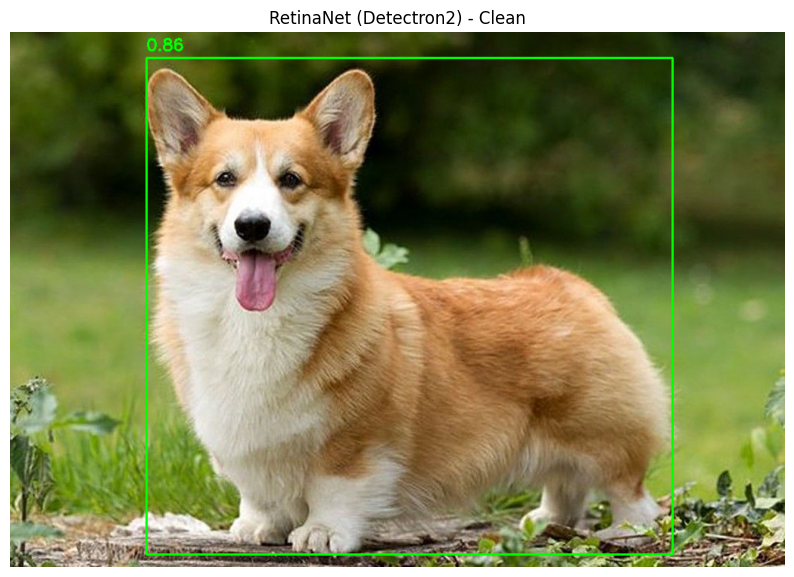

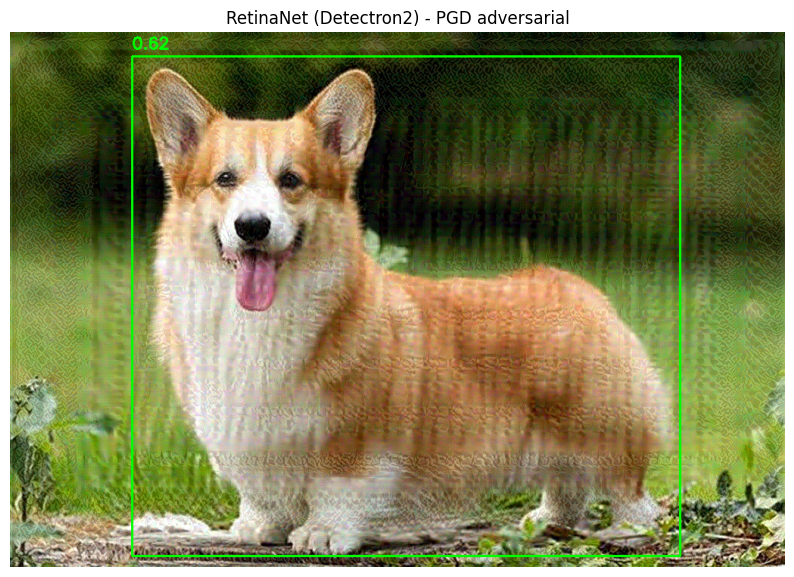

[Adv] Detected 1 objects, mean conf: 0.618
L∞ perturbation: 0.06275
SCD: 0.2380


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import ImageList
from PIL import Image

# === CONFIG ===
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_PATH = '/content/28f0e30e9643b90de06eaac32f59491f.jpg'

# === Load config and model ===
cfg = get_cfg()
cfg.MODEL.DEVICE = DEVICE
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

# ===== Load raw torch model =====
model = build_model(cfg)
model.eval()
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.to(DEVICE)

# === Load image, preprocessing ===
img_bgr = cv2.imread(IMG_PATH)
assert img_bgr is not None, f"Can't read image: {IMG_PATH}"

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
img_tensor = torch.from_numpy(np.asarray(img_pil)).permute(2, 0, 1).float() / 255.0  # [C,H,W]
img_tensor = img_tensor.unsqueeze(0).to(DEVICE)  # [1,3,H,W]

# Detectron2: normalization
mean = torch.tensor(cfg.MODEL.PIXEL_MEAN).view(1,3,1,1).to(DEVICE)
std = torch.tensor(cfg.MODEL.PIXEL_STD).view(1,3,1,1).to(DEVICE)

# === Clean inference for reference ===
with torch.no_grad():
    out_clean = predictor(img_bgr.copy())
    instances_clean = out_clean["instances"]
    print(f"[Clean] Detected {len(instances_clean)} objects, mean conf: {instances_clean.scores.mean().item():.3f}")

# ====== PGD ATTACK on raw RetinaNet logits ======

def get_raw_retinanet_logits(model, img_tensor_norm, cfg):
    images = ImageList.from_tensors([img_tensor_norm[0]], model.backbone.size_divisibility)
    features = model.backbone(images.tensor)
    # Используем in_features из cfg
    in_features = cfg.MODEL.RETINANET.IN_FEATURES
    features_list = [features[f] for f in in_features]
    pred_logits, _ = model.head(features_list)
    logits_list = []
    for l in pred_logits:
        B, AC, H, W = l.shape
        C = model.num_classes
        A = AC // C
        l = l.permute(0,2,3,1).reshape(B, H, W, A, C)
        logits_list.append(l.reshape(B, -1, C))
    all_logits = torch.cat(logits_list, dim=1) # [B, num_anchors, C]
    return all_logits[0]  # [num_anchors, C]



def custom_attack_loss(pred_logits, target_class=None):
    probs = torch.softmax(pred_logits, dim=-1)
    if probs.numel() == 0:
        return torch.tensor(0.0, device=pred_logits.device, requires_grad=True)
    if target_class is not None:
        loss = -probs[:, target_class].mean()
    else:
        loss = -probs.max(dim=-1)[0].mean()
    return loss

def pgd_attack_retinanet(model, img_tensor, mean, std, cfg, epsilon=0.03, alpha=0.007, iters=10, target_class=None):
    # Ensure adv has requires_grad=True
    adv = img_tensor.clone().detach().requires_grad_(True)
    orig = img_tensor.clone().detach()
    model.eval()
    for step in range(iters):
        # Normalize the adversarial image
        img_norm = (adv - mean) / std

        # Get raw RetinaNet logits and calculate loss
        # Ensure gradients are tracked from adv to loss
        with torch.enable_grad():
            try:
                pred_logits = get_raw_retinanet_logits(model, img_norm, cfg)
            except Exception as e:
                print(f"Error getting raw logits at step {step}: {e}")
                break # Exit attack loop if there's an error

            loss = custom_attack_loss(pred_logits, target_class)

        # Check if loss requires grad
        if not loss.requires_grad:
            print(f"Step {step}: loss has no grad, value {loss.item()}. Skipping update.")
            break

        # Backward pass to get gradients with respect to 'adv'
        # Use allow_unused=True in case some logits don't contribute to the loss (e.g., due to empty detections)
        # However, the primary issue is likely a broken graph between loss and adv.
        # The fix is to ensure 'adv' is part of the graph leading to 'loss'.
        # The current structure with `with torch.enable_grad():` and passing `img_norm` (derived from `adv`)
        # to `get_raw_retinanet_logits` should maintain the graph.
        # If grad is still None, it might indicate that the operations within `get_raw_retinanet_logits`
        # are not fully differentiable with respect to the input image tensor.
        # Let's add allow_unused=True just in case, but the main focus is on ensuring the graph is connected.
        grad = torch.autograd.grad(loss, adv, retain_graph=False, allow_unused=True)[0]


        if grad is None:
            print(f"Step {step}: grad is None, skipping update.")
            # If grad is None even with allow_unused=True, it means 'adv' is truly not connected
            # to the loss in a differentiable way. This would point to a more fundamental issue
            # in how `get_raw_retinanet_logits` or `custom_attack_loss` is implemented
            # or how the model's forward pass is being used.
            break

        # Update the adversarial image using the gradient
        # Perform the update outside the gradient tracking context
        with torch.no_grad():
            adv.add_(alpha * grad.sign())

            # Project the adversarial image back to the epsilon ball and [0, 1] range
            delta = torch.clamp(adv - orig, -epsilon, epsilon)
            adv.copy_(orig + delta)
            adv.clamp_(0, 1)

        # Re-enable gradient tracking for the next iteration
        adv.requires_grad_(True)

        # Debug print
        if step == 0 or step == iters-1 or step % 10 == 0:
            with torch.no_grad():
                 # Need to perform the full forward pass with the attacked image to get detection results
                 # Use the predictor for easy access to Instances
                 # Convert attacked tensor back to BGR uint8 for predictor
                 adv_img_np_debug = (adv.detach()[0].cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
                 adv_img_bgr_debug = cv2.cvtColor(adv_img_np_debug, cv2.COLOR_RGB2BGR)
                 out_adv_debug = predictor(adv_img_bgr_debug.copy())
                 instances_adv_debug = out_adv_debug["instances"]
                 debug_mean_conf = instances_adv_debug.scores.mean().item() if len(instances_adv_debug) > 0 else 0.0

            # We can't easily get the 'attack loss' value from the predictor output,
            # so just print mean confidence and linf
            print(f"Step {step}: Mean Conf (Adv)={debug_mean_conf:.3f}, linf={(adv - orig).abs().max().item():.5f}")


    return adv.detach()

# === PGD ATTACKED IMAGE ===
EPSILON = 16/255
ALPHA = 2/255
PGD_STEPS = 100

adv_img_tensor = pgd_attack_retinanet(model, img_tensor, mean, std, cfg, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=None)

adv_img_np = (adv_img_tensor[0].detach().cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
adv_img_bgr = cv2.cvtColor(adv_img_np, cv2.COLOR_RGB2BGR)

# Инференс по атакованному
with torch.no_grad():
    out_adv = predictor(adv_img_bgr.copy())
    instances_adv = out_adv["instances"]

# Визуализация
def vis(img, instances, title):
    img = img.copy()
    boxes = instances.pred_boxes.tensor.cpu().numpy() if hasattr(instances, 'pred_boxes') else []
    scores = instances.scores.cpu().numpy() if hasattr(instances, 'scores') else []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        label = f"{scores[i]:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, max(0, y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    plt.figure(figsize=(10,7))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

vis(img_bgr, instances_clean, "RetinaNet (Detectron2) - Clean")
vis(adv_img_bgr, instances_adv, "RetinaNet (Detectron2) - PGD adversarial")

print(f"[Adv] Detected {len(instances_adv)} objects, mean conf: {instances_adv.scores.mean().item():.3f}" if len(instances_adv) > 0 else "[Adv] Detected 0 objects")

# === Perturbation norm ===
linf = (adv_img_tensor - img_tensor).abs().max().item()
print(f"L∞ perturbation: {linf:.5f}")

# === SCD/IoU (опционально) ===
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB-xA) * max(0, yB-yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(instances_clean, instances_adv, iou_thresh=0.5, conf_min=0.5):
    confident_drops = []
    clean_boxes = instances_clean.pred_boxes.tensor if hasattr(instances_clean, 'pred_boxes') else torch.empty(0, 4)
    clean_scores = instances_clean.scores if hasattr(instances_clean, 'scores') else torch.empty(0)
    adv_boxes = instances_adv.pred_boxes.tensor if hasattr(instances_adv, 'pred_boxes') else torch.empty(0, 4)
    adv_scores = instances_adv.scores if hasattr(instances_adv, 'scores') else torch.empty(0)
    for cbox, cconf in zip(clean_boxes, clean_scores):
        if cconf < conf_min: continue
        matched = False
        for abox, acon in zip(adv_boxes, adv_scores):
            if iou(cbox.cpu().numpy(), abox.cpu().numpy()) > iou_thresh:
                confident_drops.append(cconf.item() - acon.item())
                matched = True
                break
        if not matched:
            confident_drops.append(cconf.item())
    return np.mean(confident_drops) if confident_drops else 0

scd = compute_scd(instances_clean, instances_adv)
print(f"SCD: {scd:.4f}")

## Объединение моделей

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-c4h19pss
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-c4h19pss
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6438624 sha256=e06755f1d8f9008cce4c976001f659f7a436c8aec0171e767a82e0b5c1d5404a
  Stored in directory: /tmp/pip-ephem-wheel-cache-6cv7cjl0/wheels/17/d9/40/60db98e485aa9455

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

# ==== COCO LOADING ====
from pycocotools.coco import COCO

COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
VAL_FRAC = 0.1

coco = COCO(COCO_ANN_PATH)
img_ids = coco.getImgIds()
N = int(len(img_ids) * VAL_FRAC)
img_ids = img_ids[:N]

BATCH_SIZE = 2

def load_coco_batch(start_idx, batch_size):
    batch_imgs = []
    batch_pils = []
    for img_id in img_ids[start_idx:start_idx+batch_size]:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(COCO_IMG_DIR, img_info['file_name'])
        pil_img = Image.open(img_path).convert('RGB')
        batch_pils.append(pil_img)
        batch_imgs.append(pil_img)
    return batch_pils

# ==== YOLOv8 ====
from ultralytics import YOLO

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
YOLO_WEIGHTS = 'yolov8n.pt'
yolo = YOLO(YOLO_WEIGHTS)
yolo_model = yolo.model
yolo_model.eval().to(DEVICE)
trans_yolo = transforms.Compose([transforms.Resize((640, 640)), transforms.ToTensor()])

def forward_yolo(model, x):
    outs = []
    for b in x:
        o = model(b.unsqueeze(0))
        o = o[0] if isinstance(o, (tuple,list)) else o
        outs.append(o)
    return outs

def yolo_loss(preds, target_class=None):
    obj = preds[..., 4]     # objectness score
    if target_class is not None:
        cls = preds[..., 5+target_class]
        return -cls.mean()
    else:
        return -obj.mean()

def yolo_metrics(res, conf_thresh=0.5):
    boxes, confs = [], []
    for r in res:
        if len(r.boxes) > 0:
            mask = r.boxes.conf > conf_thresh
            boxes.extend(r.boxes.xyxy[mask].cpu().numpy())
            confs.extend(r.boxes.conf[mask].cpu().numpy())
    return len(boxes)/max(1, len(res)), np.mean(confs) if confs else 0., boxes, confs

# ==== RetinaNet ====
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import ImageList

retina_cfg = get_cfg()
retina_cfg.MODEL.DEVICE = str(DEVICE)
retina_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
retina_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
retina_cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
retina_predictor = DefaultPredictor(retina_cfg)
retina_model = build_model(retina_cfg)
retina_model.eval()
DetectionCheckpointer(retina_model).load(retina_cfg.MODEL.WEIGHTS)
retina_model.to(DEVICE)
mean_retina = torch.tensor(retina_cfg.MODEL.PIXEL_MEAN).view(1,3,1,1).to(DEVICE)
std_retina = torch.tensor(retina_cfg.MODEL.PIXEL_STD).view(1,3,1,1).to(DEVICE)
trans_retina = transforms.Compose([transforms.Resize((800,800)), transforms.ToTensor()])

def forward_retina(model, x):
    outs = []
    for b in x:
        img_norm = ((b.unsqueeze(0) - mean_retina) / std_retina)
        images = ImageList.from_tensors([img_norm[0]], model.backbone.size_divisibility)
        features = model.backbone(images.tensor)
        in_features = retina_cfg.MODEL.RETINANET.IN_FEATURES
        features_list = [features[f] for f in in_features]
        pred_logits, _ = model.head(features_list)
        logits_list = []
        for l in pred_logits:
            B, AC, H, W = l.shape
            C = model.num_classes
            A = AC // C
            l = l.permute(0,2,3,1).reshape(B, H, W, A, C)
            logits_list.append(l.reshape(B, -1, C))
        all_logits = torch.cat(logits_list, dim=1)
        outs.append(all_logits[0])
    return outs

def retina_loss(preds, target_class=None):
    s = 0
    for logits in preds:
        probs = torch.softmax(logits, dim=-1)
        s += -probs.max(dim=-1)[0].mean()
    return s / len(preds)

def retina_metrics(instances, conf_thresh=0.5):
    boxes = instances.pred_boxes.tensor.cpu().numpy() if hasattr(instances, 'pred_boxes') else np.empty((0,4))
    scores = instances.scores.cpu().numpy() if hasattr(instances, 'scores') else np.empty((0,))
    keep = scores > conf_thresh
    boxes, scores = boxes[keep], scores[keep]
    return len(boxes), scores.mean() if len(scores) else 0., boxes, scores

# ==== Faster R-CNN ====
frcnn_cfg = get_cfg()
frcnn_cfg.MODEL.DEVICE = str(DEVICE)
frcnn_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
frcnn_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
frcnn_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
frcnn_predictor = DefaultPredictor(frcnn_cfg)
frcnn_model = build_model(frcnn_cfg)
frcnn_model.eval()
DetectionCheckpointer(frcnn_model).load(frcnn_cfg.MODEL.WEIGHTS)
frcnn_model.to(DEVICE)
mean_frcnn = torch.tensor(frcnn_cfg.MODEL.PIXEL_MEAN).view(3,1,1).to(DEVICE)
std_frcnn = torch.tensor(frcnn_cfg.MODEL.PIXEL_STD).view(3,1,1).to(DEVICE)
trans_frcnn = transforms.Compose([transforms.Resize((800,800)), transforms.ToTensor()])

def forward_frcnn(model, x):
    outs = []
    for b in x:
        img_norm = ((b.unsqueeze(0) - mean_frcnn.unsqueeze(0)) / std_frcnn.unsqueeze(0))
        images = ImageList.from_tensors([img_norm[0]], model.backbone.size_divisibility)
        features = model.backbone(images.tensor)
        proposals, _ = model.proposal_generator(images, features, None)
        features_list = [features[f] for f in model.roi_heads.box_in_features]
        box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
        box_features = model.roi_heads.box_head(box_features)
        pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
        outs.append(pred_class_logits)
    return outs

def frcnn_loss(preds, target_class=None):
    s = 0
    for logits in preds:
        probs = torch.softmax(logits, dim=-1)
        if probs.numel() == 0:
            continue
        s += -probs.max(dim=-1)[0].mean()
    return s / len(preds)

def frcnn_metrics(instances, conf_thresh=0.5):
    boxes = instances.pred_boxes.tensor.cpu().numpy() if hasattr(instances, 'pred_boxes') else np.empty((0,4))
    scores = instances.scores.cpu().numpy() if hasattr(instances, 'scores') else np.empty((0,))
    keep = scores > conf_thresh
    boxes, scores = boxes[keep], scores[keep]
    return len(boxes), scores.mean() if len(scores) else 0., boxes, scores

# ==== DETR ====
from transformers import DetrImageProcessor, DetrForObjectDetection

detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
trans_detr = transforms.Compose([transforms.Resize((800,800)), transforms.ToTensor()])

def forward_detr(model, x):
    inputs = detr_processor(images=[transforms.ToPILImage()(img.cpu()) for img in x], return_tensors="pt").to(DEVICE)
    outputs = model(**inputs)
    return outputs.logits

def detr_loss(logits, target_class=None):
    probs = F.softmax(logits, dim=-1)
    return -probs[...,:-1].max(-1)[0].mean()

def detr_metrics(outputs, conf_thresh=0.5):
    probs = F.softmax(outputs, dim=-1)
    conf, labels = probs.max(-1)
    mask = labels != 91
    conf = conf * mask
    det_counts = mask.sum(-1)
    box_count = det_counts.float().mean().item()
    avg_conf = (conf.sum(-1) / (det_counts+1e-6)).mean().item()
    return box_count, avg_conf, None, None

# ==== PGD UNIVERSAL ATTACK ====

class PGD_Detection:
    def __init__(self, model, loss_fn, forward_fn, eps, alpha, steps, device):
        self.model = model
        self.loss_fn = loss_fn
        self.forward_fn = forward_fn
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.device = device

    def attack(self, x, target_class=None):
        adv = x.clone().detach().to(self.device).requires_grad_(True)
        orig = x.clone().detach().to(self.device)
        for step in range(self.steps):
            adv.requires_grad_(True)
            logits = self.forward_fn(self.model, adv)
            loss = self.loss_fn(logits, target_class)
            grad = torch.autograd.grad(loss, adv, retain_graph=False, allow_unused=True)[0]
            if grad is None: break
            adv = adv.detach() + self.alpha * grad.sign()
            adv = torch.max(torch.min(adv, orig + self.eps), orig - self.eps)
            adv = torch.clamp(adv, 0, 1)
        return adv.detach()

# ==== SCD ====
def scd_metric(boxes_clean, confs_clean, boxes_adv, confs_adv, iou_thresh=0.5, conf_min=0.5):
    def iou(boxA, boxB):
        xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
        xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
        interArea = max(0, xB-xA) * max(0, yB-yA)
        areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
        areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
        union = areaA + areaB - interArea
        return interArea / union if union > 0 else 0
    drops = []
    for cbox, cconf in zip(boxes_clean, confs_clean):
        if cconf < conf_min: continue
        matched = False
        for abox, acon in zip(boxes_adv, confs_adv):
            if iou(cbox, abox) > iou_thresh:
                drops.append(cconf - acon)
                matched = True
                break
        if not matched:
            drops.append(cconf)
    return np.mean(drops) if drops else 0

def eval_detector(name, model, attacker, forward, predictor, preprocess, metrics_fn, batch_size=2):
    stats = []
    for i in tqdm(range(0, len(img_ids), batch_size), desc=name):
        batch_pils = load_coco_batch(i, batch_size)
        imgs = [preprocess(img) for img in batch_pils]
        imgs = torch.stack(imgs).to(DEVICE)
        # Clean inference
        with torch.no_grad():
            out_clean = predictor(imgs) if name == 'YOLOv8' else predictor([np.array(pil)[:,:,::-1] for pil in batch_pils])
        box_n, box_conf, boxes, confs = metrics_fn(out_clean)
        # Adv inference
        adv_imgs = attacker.attack(imgs)
        with torch.no_grad():
            out_adv = predictor(adv_imgs) if name == 'YOLOv8' else predictor([np.array((adv_imgs[j].cpu().permute(1,2,0).numpy()*255).astype(np.uint8))[:,:,::-1] for j in range(len(adv_imgs))])
        box_n_adv, box_conf_adv, boxes_adv, confs_adv = metrics_fn(out_adv)
        linf = (adv_imgs - imgs).abs().max().item()
        scd = scd_metric(boxes, confs, boxes_adv, confs_adv)
        stats.append([box_n, box_conf, box_n_adv, box_conf_adv, linf, scd])
    stats = np.array(stats)
    print(f"\n{name} Results:")
    print(f"  Clean: boxes/img={stats[:,0].mean():.2f}, conf={stats[:,1].mean():.3f}")
    print(f"    Adv: boxes/img={stats[:,2].mean():.2f}, conf={stats[:,3].mean():.3f}")
    print(f"    L∞:  {stats[:,4].mean():.5f}")
    print(f"    SCD: {stats[:,5].mean():.4f}")



# ==== ATTACKERS ====
YOLO_ATTACK = PGD_Detection(yolo_model, yolo_loss, forward_yolo, eps=4/255, alpha=2/255, steps=10, device=DEVICE)
RETINA_ATTACK = PGD_Detection(retina_model, retina_loss, forward_retina, eps=16/255, alpha=2/255, steps=10, device=DEVICE)
FRCNN_ATTACK = PGD_Detection(frcnn_model, frcnn_loss, forward_frcnn, eps=16/255, alpha=2/255, steps=10, device=DEVICE)
DETR_ATTACK = PGD_Detection(detr_model, detr_loss, forward_detr, eps=4/255, alpha=2/255, steps=10, device=DEVICE)

# ==== EVAL ====
eval_detector("YOLOv8", yolo_model, YOLO_ATTACK, forward_yolo, yolo, trans_yolo, yolo_metrics, batch_size=BATCH_SIZE)
eval_detector("RetinaNet", retina_model, RETINA_ATTACK, forward_retina, retina_predictor, trans_retina, retina_metrics, batch_size=1)
eval_detector("Faster R-CNN", frcnn_model, FRCNN_ATTACK, forward_frcnn, frcnn_predictor, trans_frcnn, frcnn_metrics, batch_size=1)
eval_detector("DETR", detr_model, DETR_ATTACK, forward_detr, None, trans_detr, detr_metrics, batch_size=1)


loading annotations into memory...


Done (t=0.99s)
creating index...
index created!


  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the cur


0: 640x640 2 persons, 1 cup, 3 spoons, 5 bowls, 1 oven, 7.1ms
1: 640x640 5 oranges, 1 dining table, 1 oven, 1 refrigerator, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


YOLOv8:   0%|          | 0/250 [00:00<?, ?it/s]


TypeError: list indices must be integers or slices, not tuple

SyntaxError: '(' was never closed (<ipython-input-10-3416360095>, line 240)

In [ ]:
import torch
import numpy as np
import os
from pycocotools.coco import COCO
from PIL import Image
from tqdm import tqdm
import sys
import random

# Конфигурация
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
BATCH_SIZE = 4
NUM_BATCHES = 10  # 40 изображений
EPSILON = 4/255
ALPHA = 2/255
PGD_STEPS = 10
TARGET_CLASS = None  # None для нетаргетированной атаки
SEED = 42

# Фиксация семени для воспроизводимости
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Загрузка COCO
coco = COCO(COCO_ANN_PATH)
img_ids = coco.getImgIds()
random.shuffle(img_ids)
selected_img_ids = img_ids[:BATCH_SIZE * NUM_BATCHES]

# Утилиты
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1]) # Corrected typo here: yA should be max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - inter + 1e-10
    return inter / union

def compute_scd(clean_dets, adv_dets, conf_min=0.5, iou_thresh=0.5):
    drops = []
    for cbox, cconf in zip(clean_dets['boxes'], clean_dets['scores']):
        if cconf < conf_min:
            continue
        matched = False
        for abox, acon in zip(adv_dets['boxes'], adv_dets['scores']):
            if iou(cbox, abox) >= iou_thresh:
                drops.append(cconf - acon)
                matched = True
                break
        if not matched:
            drops.append(cconf)
    return np.mean(drops) if drops else 0.0

def entropy(probs):
    return - (probs * torch.log(probs + 1e-10)).sum(dim=-1)

#%% YOLOv8
try:
    from ultralytics import YOLO
    from torchvision import transforms


    class YOLOWrapper:
        def __init__(self, weights='yolov8n.pt'):
            self.model = YOLO(weights)
            self.model.model.to(DEVICE).eval()
            self.size = 640
            self.preprocess = transforms.Compose([
                transforms.Resize((self.size, self.size)),
                transforms.ToTensor()
            ])

        def preprocess_batch(self, pil_imgs):
            return torch.stack([self.preprocess(img) for img in pil_imgs]).to(DEVICE)

        def predict(self, images_tensor):
            with torch.no_grad():
                results = self.model(images_tensor)
            detections = []
            for res in results:
                detections.append({
                    'boxes': res.boxes.xyxy.cpu().numpy(),
                    'scores': res.boxes.conf.cpu().numpy(),
                    'classes': res.boxes.cls.cpu().numpy()
                })
            return detections

        def _forward_raw(self, images_tensor):
            # Attempt to get raw outputs using the model's forward method
            # This might return a tuple where the first element is the raw prediction tensor
            outputs = self.model.model.forward(images_tensor)
            if isinstance(outputs, (tuple, list)):
                # Assuming the first element of the tuple/list is the raw output
                raw_output = outputs[0]
            else:
                # If it's not a tuple/list, assume it's the raw output directly
                raw_output = outputs

            # Reshape the output to [B, num_anchors, num_features]
            # Assuming raw_output shape is [B, num_features, H, W]
            # Permute from [B, C, H, W] to [B, H, W, C]
            # Reshape to [B, H*W*num_anchors_per_cell, num_features]
            # The exact reshape might depend on YOLOv8 version/config.
            # Let's use the common pattern for YOLOv8 raw output reshaping:
            # From [B, C, H, W] to [B, H*W, C] then to [B, N, 85]
            # where N is total number of anchors (H*W*num_anchors_per_cell)
            # The raw_output shape should be [B, 85, num_anchors] after permuting and flattening,
            # then permuted to [B, num_anchors, 85]
            # Let's try reshaping based on common YOLOv8 raw output structure.
            # The raw output is typically (batch_size, num_features, num_anchors) after a certain point
            # or needs to be reshaped to that form.
            # Given the previous working code's reshape:
            # out = out.permute(0,2,3,1).reshape(out.shape[0], -1, out.shape[1])
            # where out.shape[1] was features (85), and out.shape[2], out.shape[3] were H, W
            # Let's apply this logic to the raw_output:
            if len(raw_output.shape) == 4: # Check if it's in [B, C, H, W] format
                 raw_output = raw_output.permute(0,2,3,1).reshape(raw_output.shape[0], -1, raw_output.shape[1])
            elif len(raw_output.shape) == 3: # Check if it's already in [B, N, C] format
                 pass # Already in the desired format
            else:
                 raise ValueError(f"Unexpected raw output shape from YOLOv8 model: {raw_output.shape}")

            return raw_output


        def attack(self, images, target_class=None):
            adv = images.clone().detach().requires_grad_(True)
            orig = images.clone().detach()

            for _ in range(PGD_STEPS):
                raw_out = self._forward_raw(adv)
                # The raw output format from the model's forward method might be different
                # from the format expected by the original yolo_loss function.
                # Need to adjust based on the actual output structure.
                # Assuming raw_out is a tensor of shape [B, num_anchors, 85]
                # where the last dimension contains [xywh, objectness, class_probs]
                obj = raw_out[..., 4:5]
                cls = raw_out[..., 5:]
                scores = obj * cls
                loss = -scores.mean()

                loss.backward()
                with torch.no_grad():
                    adv = adv + ALPHA * adv.grad.sign()
                    delta = torch.clamp(adv - orig, -EPSILON, EPSILON)
                    adv = torch.clamp(orig + delta, 0, 1)
                adv.requires_grad_(True)

            return adv.detach()

except ImportError:
    print("YOLO not available", file=sys.stderr)

#%% Detectron2 (Faster R-CNN и RetinaNet)
try:
    from detectron2 import model_zoo
    from detectron2.config import get_cfg
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    from torchvision import transforms


    class Detectron2Wrapper:
        def __init__(self, config_path, weights_url):
            self.cfg = get_cfg()
            self.cfg.merge_from_file(model_zoo.get_config_file(config_path))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.model = build_model(self.cfg)
            self.model.eval()
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)
            self.size = 800
            self.mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN).view(1,3,1,1).to(DEVICE)
            self.std = torch.tensor(self.cfg.MODEL.PIXEL_STD).view(1,3,1,1).to(DEVICE)
            self.preprocess = transforms.Compose([
                transforms.Resize((self.size, self.size)),
                transforms.ToTensor()
            ])

        def preprocess_batch(self, pil_imgs):
            return torch.stack([self.preprocess(img) for img in pil_imgs]).to(DEVICE)

        def predict(self, images_tensor):
            images_norm = (images_tensor - self.mean) / self.std
            images_list = ImageList.from_tensors(
                [images_norm[i] for i in range(len(images_tensor))],
                self.model.backbone.size_divisibility
            )

            with torch.no_grad():
                features = self.model.backbone(images_list.tensor)
                proposals, _ = self.model.proposal_generator(images_list, features)
                results, _ = self.model.roi_heads(images_list, features, proposals)

            detections = []
            for res in results:
                detections.append({
                    'boxes': res.pred_boxes.tensor.cpu().numpy(),
                    'scores': res.scores.cpu().numpy(),
                    'classes': res.pred_classes.cpu().numpy()
                })
            return detections

        def attack(self, images, target_class=None):
            images_norm = (images - self.mean) / self.std
            images_list = ImageList.from_tensors(
                [images_norm[i] for i in range(len(images))],
                self.model.backbone.size_divisibility
            )

            adv = images.clone().detach().requires_grad_(True)
            orig = images.clone().detach()

            for _ in range(PGD_STEPS):
                adv_norm = (adv - self.mean) / self.std
                adv_list = ImageList.from_tensors(
                    [adv_norm[i] for i in range(len(adv))],
                    self.model.backbone.size_divisibility
                )

                features = self.model.backbone(adv_list.tensor)
                proposals, _ = self.model.proposal_generator(adv_list, features)
                box_features = self.model.roi_heads.box_pooler(
                    [features[f] for f in self.model.roi_heads.box_in_features],
                    [p.proposal_boxes for p in proposals]
                )
                box_features = self.model.roi_heads.box_head(box_features)
                pred_logits, _ = self.model.roi_heads.box_predictor(box_features)

                probs = torch.softmax(pred_logits, dim=-1)
                loss = -probs.max(dim=-1)[0].mean()

                loss.backward()
                with torch.no_grad():
                    adv = adv + ALPHA * adv.grad.sign()
                    delta = torch.clamp(adv - orig, -EPSILON, EPSILON)
                    adv = torch.clamp(orig + delta, 0, 1)
                adv.requires_grad_(True)

            return adv.detach()

except ImportError:
    print("Detectron2 not available", file=sys.stderr)

#%% DETR
try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    import torch.nn.functional as F
    from torchvision import transforms


    class DETRWrapper:
        def __init__(self, model_name="facebook/detr-resnet-50"):
            self.processor = DetrImageProcessor.from_pretrained(model_name)
            self.model = DetrForObjectDetection.from_pretrained(model_name).to(DEVICE).eval()
            self.size = 800

        def preprocess_batch(self, pil_imgs):
            # The processor handles resizing and normalization for DETR
            return self.processor(images=pil_imgs, return_tensors="pt").pixel_values.to(DEVICE)

        def predict(self, images_tensor):
            inputs = self.processor(images=[transforms.ToPILImage()(img.cpu()) for img in images_tensor], return_tensors="pt")
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model(**inputs)

            results = self.processor.post_process_object_detection(
                outputs, threshold=0.0, target_sizes=[(self.size, self.size)]*len(images_tensor))

            detections = []
            for res in results:
                detections.append({
                    'boxes': res['boxes'].cpu().numpy(),
                    'scores': res['scores'].cpu().numpy(),
                    'classes': res['labels'].cpu().numpy()
                })
            return detections

        def attack(self, images, target_class=None):
            adv = images.clone().detach().requires_grad_(True)
            orig = images.clone().detach()

            for _ in range(PGD_STEPS):
                # The processor expects a list of PIL Images for the attack as well
                # Convert the tensor back to PIL images for the processor
                adv_pil = [transforms.ToPILImage()(img.cpu()) for img in adv]
                inputs = self.processor(images=adv_pil, return_tensors="pt")
                inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

                outputs = self.model(**inputs)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)
                obj_probs = probs[..., :-1]
                max_probs = obj_probs.max(dim=-1)[0]
                loss = -max_probs.mean()

                loss.backward()
                with torch.no_grad():
                    adv = adv + ALPHA * adv.grad.sign()
                    delta = torch.clamp(adv - orig, -EPSILON, EPSILON)
                    adv = torch.clamp(orig + delta, 0, 1)
                adv.requires_grad_(True)

            return adv.detach()

except ImportError:
    print("Transformers not available", file=sys.stderr)


#%% Основной цикл оценки
def evaluate_model(model_wrapper, model_name):
    print(f"\nEvaluating {model_name}...")
    stats = []

    for batch_idx in tqdm(range(NUM_BATCHES), desc=model_name):
        batch_img_ids = selected_img_ids[batch_idx*BATCH_SIZE:(batch_idx+1)*BATCH_SIZE]
        batch_imgs = []
        for img_id in batch_img_ids:
            img_info = coco.loadImgs(img_id)[0]
            img_path = os.path.join(COCO_IMG_DIR, img_info['file_name'])
            batch_imgs.append(Image.open(img_path).convert('RGB'))

        # Препроцессинг
        clean_tensor = model_wrapper.preprocess_batch(batch_imgs)

        # Чистый инференс
        clean_detections = model_wrapper.predict(clean_tensor)

        # PGD атака
        adv_tensor = model_wrapper.attack(clean_tensor)

        # Атакованный инференс
        adv_detections = model_wrapper.predict(adv_tensor)

        # Метрики
        batch_metrics = []
        linf = (adv_tensor - clean_tensor).abs().max().item()

        for i in range(len(batch_imgs)):
            clean = clean_detections[i]
            adv = adv_detections[i]

            n_clean = len(clean['boxes'])
            conf_clean = clean['scores'].mean() if n_clean > 0 else 0.0
            n_adv = len(adv['boxes'])
            conf_adv = adv['scores'].mean() if n_adv > 0 else 0.0
            scd = compute_scd(clean, adv)

            # Энтропия (только для DETR)
            entropy_val = 0.0
            if model_name == "DETR":
                # Re-preprocess the original clean image to get the inputs format expected by the processor
                clean_pil = [batch_imgs[i]]
                inputs = model_wrapper.processor(images=clean_pil, return_tensors="pt")
                inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
                with torch.no_grad():
                    outputs = model_wrapper.model(**inputs)
                probs = torch.softmax(outputs.logits, dim=-1)
                # Exclude the no_object class probability (index 91 for COCO)
                entropy_val = entropy(probs[0][..., :-1]).mean().item()


            batch_metrics.append([
                n_clean, conf_clean, n_adv, conf_adv, scd, entropy_val
            ])

        # Усреднение по батчу
        avg_metrics = np.mean(batch_metrics, axis=0)
        stats.append([*avg_metrics, linf])

    # Результаты
    stats = np.array(stats)
    print(f"\n{model_name} Results:")
    print(f"Clean Detections: {stats[:,0].mean():.2f} ± {stats[:,0].std():.2f}")
    print(f"Clean Confidence: {stats[:,1].mean():.4f} ± {stats[:,1].std():.4f}")
    print(f"Adv Detections:   {stats[:,2].mean():.2f} ± {stats[:,2].std():.2f}")
    print(f"Adv Confidence:   {stats[:,3].mean():.4f} ± {stats[:,3].std():.4f}")
    print(f"SCD:              {stats[:,4].mean():.4f} ± {stats[:,4].std():.4f}")
    if model_name == "DETR":
        print(f"Entropy:          {stats[:,5].mean():.4f} ± {stats[:,5].std():.4f}")
    print(f"L∞:               {stats[:,6].mean():.6f}")

#%% Запуск оценки
if __name__ == "__main__":
    models = {}

    if 'YOLOWrapper' in globals():
        models["YOLOv8"] = YOLOWrapper('yolov8n.pt')

    if 'Detectron2Wrapper' in globals():
        models["Faster R-CNN"] = Detectron2Wrapper(
            "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
            "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
        )
        models["RetinaNet"] = Detectron2Wrapper(
            "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
            "COCO-Detection/retinanet_R_50_FPN_3x.yaml"
        )

    if 'DETRWrapper' in globals():
        models["DETR"] = DETRWrapper()

    for name, model in models.items():
        evaluate_model(model, name)

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


  pixel_mean
  pixel_std
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no


Evaluating YOLOv8...


YOLOv8:   0%|          | 0/10 [00:00<?, ?it/s]


0: 640x640 1 person, 1 clock, 1 toothbrush, 5.9ms
1: 640x640 1 person, 5.9ms
2: 640x640 4 persons, 1 baseball bat, 5.9ms
3: 640x640 2 sinks, 5.9ms
Speed: 0.0ms preprocess, 5.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


YOLOv8:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Inference tensors cannot be saved for backward. To work around you can make a clone to get a normal tensor and use it in autograd.

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from torchvision import transforms
import cv2

# YOLOv8
from ultralytics import YOLO

# Detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# DETR
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch.nn.functional as F

# === CONFIG ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
BATCH_SIZE = 4
PERCENTAGE = 0.1  # Доля датасета COCO val для оценки (например, 0.1 = 10%)

# === Загрузка COCO ===
coco = COCO(COCO_ANN_PATH)
all_img_ids = coco.getImgIds()
num_eval = max(1, int(len(all_img_ids) * PERCENTAGE))
img_ids = all_img_ids[:num_eval]

# === Препроцессоры ===
yolo_preproc = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

# === Загрузка моделей ===
# YOLOv8
yolo = YOLO('yolov8n.pt')
yolo.model.eval().to(DEVICE)

# Faster R-CNN (Detectron2)
cfg_frcnn = get_cfg()
cfg_frcnn.MODEL.DEVICE = DEVICE.type
cfg_frcnn.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg_frcnn.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg_frcnn.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor_frcnn = DefaultPredictor(cfg_frcnn)

# RetinaNet (Detectron2)
cfg_retina = get_cfg()
cfg_retina.MODEL.DEVICE = DEVICE.type
cfg_retina.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg_retina.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg_retina.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor_retina = DefaultPredictor(cfg_retina)

# DETR (HuggingFace)
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)

# === Функция метрик ===
def detection_metrics(outputs, model_type):
    """
    outputs:
      - list of ultralytics Results для 'yolo'
      - list of detectron2 Instances для 'detectron2'
      - transformer Output для 'detr'
    model_type: 'yolo' | 'detectron2' | 'detr'
    Возвращает: box_count, avg_conf, avg_entropy (None, если не применимо)
    """
    if model_type == 'yolo':
        all_confs = [res.boxes.conf.cpu() for res in outputs]
        if any(len(c) for c in all_confs):
            box_count = np.mean([len(c) for c in all_confs])
            avg_conf = torch.cat([c for c in all_confs if len(c)]).mean().item()
        else:
            box_count, avg_conf = 0.0, 0.0
        return box_count, avg_conf, None

    elif model_type == 'detectron2':
        all_scores = [inst.scores.cpu() for inst in outputs]
        if any(len(s) for s in all_scores):
            box_count = np.mean([len(s) for s in all_scores])
            avg_conf = torch.cat([s for s in all_scores if len(s)]).mean().item()
        else:
            box_count, avg_conf = 0.0, 0.0
        return box_count, avg_conf, None

    elif model_type == 'detr':
        logits = outputs.logits.cpu()            # [B, 100, 92]
        probs = F.softmax(logits, dim=-1)  # [B, 100, 92]
        conf, labels = probs[..., :-1].max(-1)  # ignore 'no-object' class
        mask = labels != 91
        conf = conf * mask
        counts = mask.sum(-1).numpy()  # detections per image
        box_count = counts.mean()
        avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
        entropy = -(probs * probs.clamp(min=1e-9).log()).sum(-1)
        avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)
        avg_entropy = avg_entropy.mean().item()
        return box_count, avg_conf, avg_entropy

    else:
        raise ValueError(f"Unknown model_type: {model_type}")

# === Основной цикл оценки ===
models = ['yolo', 'faster_rcnn', 'retinanet', 'detr']
results = {m: {'boxes': [], 'conf': [], 'entropy': []} for m in models}

for start in range(0, num_eval, BATCH_SIZE):
    batch_ids = img_ids[start:start + BATCH_SIZE]
    imgs_pil = []
    imgs_tensor = []
    imgs_bgr = []

    for img_id in batch_ids:
        info = coco.loadImgs(img_id)[0]
        path = os.path.join(COCO_IMG_DIR, info['file_name'])
        pil = Image.open(path).convert('RGB')
        imgs_pil.append(pil)
        imgs_tensor.append(yolo_preproc(pil))
        imgs_bgr.append(cv2.imread(path))

    imgs_tensor = torch.stack(imgs_tensor).to(DEVICE)

    # --- YOLOv8 ---
    with torch.no_grad():
        yolo_out = yolo(imgs_tensor)
    bc, ac, _ = detection_metrics(yolo_out, 'yolo')
    results['yolo']['boxes'].append(bc)
    results['yolo']['conf'].append(ac)

    # --- Faster R-CNN ---
    frcnn_out = [predictor_frcnn(img)['instances'] for img in imgs_bgr]
    bc, ac, _ = detection_metrics(frcnn_out, 'detectron2')
    results['faster_rcnn']['boxes'].append(bc)
    results['faster_rcnn']['conf'].append(ac)

    # --- RetinaNet ---
    retina_out = [predictor_retina(img)['instances'] for img in imgs_bgr]
    bc, ac, _ = detection_metrics(retina_out, 'detectron2')
    results['retinanet']['boxes'].append(bc)
    results['retinanet']['conf'].append(ac)

    # --- DETR ---
    detr_inputs = detr_processor(images=imgs_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        detr_out = detr_model(**detr_inputs)
    bc, ac, ae = detection_metrics(detr_out, 'detr')
    results['detr']['boxes'].append(bc)
    results['detr']['conf'].append(ac)
    results['detr']['entropy'].append(ae)

# === Вывод итоговых метрик ===
print(f"=== Оценка на {PERCENTAGE*100:.0f}% COCO val ({num_eval}/{len(all_img_ids)}) ===")
for m in models:
    mean_boxes = np.mean(results[m]['boxes'])
    mean_conf = np.mean(results[m]['conf'])
    if m == 'detr':
        mean_ent = np.mean(results[m]['entropy'])
        print(f"{m}: boxes/img = {mean_boxes:.2f}, mean conf = {mean_conf:.3f}, mean entropy = {mean_ent:.3f}")
    else:
        print(f"{m}: boxes/img = {mean_boxes:.2f}, mean conf = {mean_conf:.3f}")

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


  pixel_mean
  pixel_std
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no


0: 640x640 2 persons, 1 cup, 3 spoons, 5 bowls, 1 oven, 6.0ms
1: 640x640 5 oranges, 1 dining table, 1 oven, 1 refrigerator, 6.0ms
2: 640x640 3 persons, 1 traffic light, 1 suitcase, 1 chair, 6.0ms
3: 640x640 10 persons, 1 bicycle, 1 skateboard, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bicycle, 5 cars, 2 trucks, 3.2ms
1: 640x640 1 bottle, 1 toilet, 1 sink, 3.2ms
2: 640x640 1 bowl, 1 sink, 3.2ms
3: 640x640 4 persons, 2 motorcycles, 3.2ms
Speed: 0.2ms preprocess, 3.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 (no detections), 4.8ms
1: 640x640 1 suitcase, 1 toilet, 4.8ms
2: 640x640 11 persons, 1 car, 2 motorcycles, 1 bus, 1 truck, 4.8ms
3: 640x640 1 person, 1 laptop, 2 books, 1 clock, 4.8ms
Speed: 0.0ms preprocess, 4.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 potted plants, 3 vases, 3.2ms
1: 640x640 1 bird, 1 bed, 1 tv, 5 books, 3.2ms
2: 640x640 1 bowl, 2 oranges, 1 vase, 3.2ms
3: 640x640 2 persons, 1 airplane, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 1 sheep, 2 giraffes, 1 banana, 4.5ms
1: 640x640 3 boats, 1 bench, 4.5ms
2: 640x640 2 persons, 5 horses, 1 sheep, 5 cows, 4.5ms
3: 640x640 3 persons, 9 cars, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 bus, 4.4ms
1: 640x640 12 persons, 3 cars, 1 bus, 4.4ms
2: 640x640 8 persons, 1 car, 1 bus, 2 trucks, 4.4ms
3: 640x640 1 person, 4 cars, 1 bus, 4.4ms
Speed: 0.0ms preprocess, 4.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7 cars, 3.2ms
1: 640x640 (no detections), 3.2ms
2: 640x640 2 giraffes, 3.2ms
3: 640x640 1 person, 1 train, 1 handbag, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 3 birds, 1 dog, 3.2ms
1: 640x640 (no detections), 3.2ms
2: 640x640 3 birds, 3.2ms
3: 640x640 1 train, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 1 train, 3.2ms
1: 640x640 1 stop sign, 3.2ms
2: 640x640 1 traffic light, 1 stop sign, 3.2ms
3: 640x640 1 stop sign, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 dog, 1 couch, 3.2ms
1: 640x640 2 cats, 3.2ms
2: 640x640 1 cat, 1 suitcase, 3.2ms
3: 640x640 2 sheeps, 2 cows, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 sheep, 2 cows, 3.2ms
1: 640x640 1 person, 1 cat, 1 cup, 1 tv, 3.2ms
2: 640x640 2 cats, 1 tv, 1 laptop, 3.2ms
3: 640x640 1 person, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 16 persons, 1 tie, 3.2ms
1: 640x640 7 persons, 2 boats, 3.2ms
2: 640x640 9 elephants, 3.2ms
3: 640x640 3 boats, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 elephant, 3.2ms
1: 640x640 8 persons, 1 car, 2 buss, 2 umbrellas, 3.2ms
2: 640x640 1 elephant, 3.2ms
3: 640x640 3 persons, 1 backpack, 2 umbrellas, 2 handbags, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 2 umbrellas, 1 suitcase, 3.2ms
1: 640x640 1 person, 1 dog, 1 frisbee, 3.2ms
2: 640x640 1 person, 6 backpacks, 2 suitcases, 3.2ms
3: 640x640 1 bear, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 zebra, 3.1ms
1: 640x640 2 zebras, 3.1ms
2: 640x640 1 car, 1 zebra, 3.1ms
3: 640x640 2 zebras, 3.1ms
Speed: 0.0ms preprocess, 3.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 4 persons, 3 horses, 3.2ms
1: 640x640 10 persons, 1 horse, 1 umbrella, 1 chair, 3.2ms
2: 640x640 1 horse, 3.2ms
3: 640x640 1 person, 1 skis, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 4.5ms
1: 640x640 1 person, 1 skis, 4.5ms
2: 640x640 1 person, 2 donuts, 4.5ms
3: 640x640 1 bowl, 10 broccolis, 1 carrot, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 skateboard, 3.2ms
1: 640x640 1 person, 1 skateboard, 3.2ms
2: 640x640 3 persons, 2 skateboards, 3.2ms
3: 640x640 3 persons, 1 skateboard, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 skateboard, 5.3ms
1: 640x640 2 persons, 9 donuts, 5.3ms
2: 640x640 1 person, 1 pizza, 5.3ms
3: 640x640 1 cup, 3 donuts, 5.3ms
Speed: 0.0ms preprocess, 5.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 12 donuts, 3.2ms
1: 640x640 1 apple, 17 donuts, 3.2ms
2: 640x640 3 sandwichs, 1 broccoli, 3.2ms
3: 640x640 1 person, 1 cup, 1 donut, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 sports ball, 3.2ms
1: 640x640 4 persons, 3 surfboards, 3.2ms
2: 640x640 1 person, 1 cup, 3.2ms
3: 640x640 5 persons, 1 sports ball, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 3.2ms
1: 640x640 1 bed, 3.2ms
2: 640x640 1 backpack, 1 cup, 4 chairs, 1 bed, 3.2ms
3: 640x640 1 person, 1 cake, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 persons, 3.2ms
1: 640x640 1 bed, 3.2ms
2: 640x640 2 persons, 1 bed, 1 tv, 1 microwave, 3.2ms
3: 640x640 1 bottle, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 1 surfboard, 3.2ms
1: 640x640 1 person, 1 bed, 3.2ms
2: 640x640 2 persons, 1 bed, 3.2ms
3: 640x640 4 persons, 1 train, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 pizza, 3.2ms
1: 640x640 1 chair, 1 couch, 3.2ms
2: 640x640 5 bottles, 2 cups, 1 pizza, 1 dining table, 3.2ms
3: 640x640 9 persons, 1 sports ball, 1 tennis racket, 7 chairs, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 3.1ms
1: 640x640 1 person, 2 toothbrushs, 3.1ms
2: 640x640 2 persons, 1 couch, 2 beds, 3.1ms
3: 640x640 5 persons, 3.1ms
Speed: 0.0ms preprocess, 3.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 bench, 2 chairs, 1 couch, 2 potted plants, 3.2ms
1: 640x640 3 chairs, 3 couchs, 1 potted plant, 3.2ms
2: 640x640 1 cat, 1 chair, 1 couch, 1 tv, 3.2ms
3: 640x640 18 persons, 2 cars, 1 truck, 1 sports ball, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 15 persons, 1 horse, 1 sports ball, 3.2ms
1: 640x640 1 person, 18 vases, 3.2ms
2: 640x640 1 person, 1 skis, 1 snowboard, 1 kite, 3.2ms
3: 640x640 3 persons, 1 kite, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 frisbee, 3.3ms
1: 640x640 1 clock, 3.3ms
2: 640x640 5 persons, 1 sports ball, 3.3ms
3: 640x640 1 person, 4 boats, 1 clock, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 10 persons, 1 baseball glove, 2 chairs, 3.2ms
1: 640x640 1 sandwich, 1 pizza, 1 dining table, 3.2ms
2: 640x640 3 persons, 1 mouse, 3.2ms
3: 640x640 2 teddy bears, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 cups, 1 vase, 3.2ms
1: 640x640 3 persons, 2 cell phones, 3.2ms
2: 640x640 1 person, 1 cat, 2 ovens, 3.2ms
3: 640x640 1 person, 3 bowls, 2 remotes, 2 refrigerators, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 3.1ms
1: 640x640 1 potted plant, 1 vase, 3.1ms
2: 640x640 1 person, 3.1ms
3: 640x640 13 persons, 12 bottles, 3 wine glasss, 1 dining table, 3.1ms
Speed: 0.0ms preprocess, 3.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 10 persons, 5 cars, 1 bench, 4 backpacks, 3.2ms
1: 640x640 1 person, 1 bowl, 3.2ms
2: 640x640 2 persons, 1 cat, 1 bottle, 4 bowls, 3.2ms
3: 640x640 1 person, 5 bowls, 1 oven, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 dog, 3.2ms
1: 640x640 2 bottles, 3 chairs, 1 dining table, 3.2ms
2: 640x640 1 bottle, 1 wine glass, 2 chairs, 1 dining table, 1 oven, 1 refrigerator, 3.2ms
3: 640x640 2 knifes, 1 potted plant, 1 microwave, 3 ovens, 1 refrigerator, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 8 persons, 2 bicycles, 1 motorcycle, 1 clock, 3.2ms
1: 640x640 4 persons, 1 car, 1 bus, 2 trucks, 1 horse, 3.2ms
2: 640x640 2 toilets, 3.2ms
3: 640x640 2 persons, 1 dining table, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 toilets, 3.5ms
1: 640x640 1 cup, 1 toilet, 3.5ms
2: 640x640 1 fork, 1 cake, 3.5ms
3: 640x640 1 tv, 2 laptops, 2 mouses, 1 keyboard, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 cup, 1 cake, 1 chair, 1 couch, 2 potted plants, 1 dining table, 3.2ms
1: 640x640 1 airplane, 3.2ms
2: 640x640 4 zebras, 3.2ms
3: 640x640 1 dog, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 5 persons, 2 cars, 4 umbrellas, 3.3ms
1: 640x640 8 cars, 3 trucks, 10 traffic lights, 3.3ms
2: 640x640 1 person, 3.3ms
3: 640x640 1 person, 2 benchs, 1 book, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 6 persons, 2 benchs, 4.0ms
1: 640x640 1 giraffe, 4.0ms
2: 640x640 1 person, 4.0ms
3: 640x640 2 sheeps, 2 cows, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 giraffes, 3.2ms
1: 640x640 9 sheeps, 3.2ms
2: 640x640 1 fire hydrant, 3.2ms
3: 640x640 7 giraffes, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 (no detections), 3.3ms
1: 640x640 2 boats, 2 birds, 3.3ms
2: 640x640 1 train, 3.3ms
3: 640x640 1 train, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 1 train, 3.2ms
1: 640x640 2 buss, 3.2ms
2: 640x640 1 cat, 3.2ms
3: 640x640 1 cat, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bird, 5.6ms
1: 640x640 1 person, 1 tie, 5.6ms
2: 640x640 2 persons, 3 ties, 3 chairs, 5.6ms
3: 640x640 1 person, 1 backpack, 1 umbrella, 1 handbag, 5.6ms
Speed: 0.0ms preprocess, 5.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 2 umbrellas, 4.6ms
1: 640x640 12 persons, 1 tie, 4.6ms
2: 640x640 1 person, 1 dog, 1 umbrella, 4.6ms
3: 640x640 3 persons, 1 tie, 4.6ms
Speed: 0.0ms preprocess, 4.6ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 7 persons, 2 dogs, 4 umbrellas, 5.4ms
1: 640x640 1 person, 2 umbrellas, 2 chairs, 5.4ms
2: 640x640 1 person, 1 tie, 5.4ms
3: 640x640 1 cat, 1 bed, 5.4ms
Speed: 0.0ms preprocess, 5.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 1 chair, 1 couch, 1 laptop, 3.2ms
1: 640x640 5 persons, 1 suitcase, 3.2ms
2: 640x640 2 cars, 3 benchs, 1 umbrella, 2 dining tables, 3.2ms
3: 640x640 1 person, 1 car, 1 train, 1 umbrella, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 ties, 1 suitcase, 3.2ms
1: 640x640 5 persons, 1 backpack, 2 suitcases, 3.2ms
2: 640x640 3 teddy bears, 3.2ms
3: 640x640 3 books, 1 teddy bear, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 horse, 1 bear, 3.2ms
1: 640x640 7 persons, 3.2ms
2: 640x640 1 dog, 1 bed, 2 laptops, 3.2ms
3: 640x640 2 persons, 3.2ms
Speed: 0.1ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 zebras, 3.2ms
1: 640x640 4 persons, 1 horse, 3.2ms
2: 640x640 (no detections), 3.2ms
3: 640x640 1 person, 2 skiss, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 2 skiss, 3.2ms
1: 640x640 17 persons, 3 cars, 1 baseball glove, 3.2ms
2: 640x640 1 bottle, 2 bowls, 1 orange, 2 broccolis, 1 carrot, 1 dining table, 3.2ms
3: 640x640 1 person, 1 skis, 3.2ms
Speed: 0.1ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 cup, 3 donuts, 1 keyboard, 3.2ms
1: 640x640 1 person, 1 skis, 3.2ms
2: 640x640 1 person, 1 airplane, 1 skateboard, 3.2ms
3: 640x640 1 bowl, 1 broccoli, 1 carrot, 1 dining table, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 4 cars, 1 skateboard, 3.3ms
1: 640x640 2 broccolis, 3.3ms
2: 640x640 1 person, 1 skis, 3.3ms
3: 640x640 1 person, 1 skis, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 cup, 1 fork, 2 bowls, 2 broccolis, 1 dining table, 3.3ms
1: 640x640 1 apple, 1 sandwich, 3.3ms
2: 640x640 5 persons, 1 skis, 3.3ms
3: 640x640 2 persons, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 hot dog, 3.2ms
1: 640x640 1 cup, 1 donut, 1 dining table, 3.2ms
2: 640x640 2 persons, 1 wine glass, 1 cup, 2 spoons, 3 bowls, 1 potted plant, 1 dining table, 3.2ms
3: 640x640 3 chairs, 1 couch, 2 beds, 1 tv, 1 laptop, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 bed, 1 laptop, 3.2ms
1: 640x640 5 persons, 4 cakes, 3.2ms
2: 640x640 2 persons, 1 tennis racket, 3.2ms
3: 640x640 1 person, 1 pizza, 1 dining table, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 2 wine glasss, 1 cup, 3 knifes, 2 spoons, 1 cake, 1 dining table, 3.2ms
1: 640x640 1 person, 1 pizza, 3.2ms
2: 640x640 1 person, 1 pizza, 1 tv, 3.2ms
3: 640x640 2 persons, 1 pizza, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 wine glass, 1 cup, 1 spoon, 1 bowl, 1 pizza, 1 dining table, 3.2ms
1: 640x640 1 pizza, 3.2ms
2: 640x640 2 broccolis, 3.2ms
3: 640x640 1 chair, 1 couch, 1 tv, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 2 chairs, 1 tv, 1 laptop, 1 mouse, 1 keyboard, 3.1ms
1: 640x640 5 chairs, 1 couch, 1 dining table, 1 tv, 1 clock, 3.1ms
2: 640x640 1 person, 1 backpack, 1 frisbee, 3.1ms
3: 640x640 5 persons, 1 baseball bat, 3.1ms
Speed: 0.0ms preprocess, 3.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 cup, 3 vases, 3.2ms
1: 640x640 1 person, 1 sports ball, 1 tennis racket, 3.2ms
2: 640x640 1 cell phone, 1 scissors, 4 toothbrushs, 3.2ms
3: 640x640 (no detections), 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 2 handbags, 1 cell phone, 3.2ms
1: 640x640 1 person, 1 suitcase, 1 laptop, 2 cell phones, 3.2ms
2: 640x640 1 microwave, 3.2ms
3: 640x640 2 persons, 1 teddy bear, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 vase, 3.2ms
1: 640x640 2 persons, 1 mouse, 1 keyboard, 3.2ms
2: 640x640 2 persons, 3.2ms
3: 640x640 2 knifes, 1 spoon, 1 oven, 3.2ms
Speed: 0.1ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 5 persons, 1 bicycle, 4 motorcycles, 1 backpack, 3.2ms
1: 640x640 1 toilet, 1 sink, 3.2ms
2: 640x640 1 cat, 2 bottles, 1 cup, 1 sink, 3.2ms
3: 640x640 2 cars, 1 truck, 3 traffic lights, 1 parking meter, 1 cow, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 cat, 1 toilet, 1 teddy bear, 3.4ms
1: 640x640 1 person, 1 bottle, 1 toilet, 3.4ms
2: 640x640 2 spoons, 1 bowl, 3.4ms
3: 640x640 1 carrot, 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bottle, 1 toilet, 3.5ms
1: 640x640 1 potted plant, 1 toilet, 3.5ms
2: 640x640 3 persons, 6 motorcycles, 3.5ms
3: 640x640 1 person, 1 motorcycle, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 2 dogs, 1 tv, 4.1ms
1: 640x640 6 airplanes, 4.1ms
2: 640x640 1 airplane, 4.1ms
3: 640x640 (no detections), 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 airplanes, 3.2ms
1: 640x640 1 airplane, 3.2ms
2: 640x640 1 airplane, 3.2ms
3: 640x640 18 persons, 1 traffic light, 1 handbag, 1 frisbee, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 bench, 3.2ms
1: 640x640 11 persons, 3 traffic lights, 1 handbag, 1 potted plant, 3.2ms
2: 640x640 4 persons, 7 cars, 1 bus, 1 handbag, 3.2ms
3: 640x640 5 cars, 1 fire hydrant, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 1 bench, 3.3ms
1: 640x640 6 sheeps, 3.3ms
2: 640x640 1 sheep, 3.3ms
3: 640x640 1 horse, 9 sheeps, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 sheep, 3.3ms
1: 640x640 1 stop sign, 3.3ms
2: 640x640 1 bird, 1 bowl, 3.3ms
3: 640x640 1 person, 2 giraffes, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 bird, 3 bananas, 3.2ms
1: 640x640 1 giraffe, 3.2ms
2: 640x640 (no detections), 3.2ms
3: 640x640 1 bird, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 tie, 1 cell phone, 4.2ms
1: 640x640 1 person, 1 sports ball, 2 baseball bats, 4.2ms
2: 640x640 3 persons, 4 cakes, 1 potted plant, 4.2ms
3: 640x640 1 traffic light, 4.2ms
Speed: 0.0ms preprocess, 4.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 (no detections), 3.7ms
1: 640x640 3 persons, 3.7ms
2: 640x640 2 cars, 1 train, 1 traffic light, 3.7ms
3: 640x640 1 car, 1 parking meter, 1 bench, 3.7ms
Speed: 0.0ms preprocess, 3.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 horse, 4 cows, 5.1ms
1: 640x640 1 bird, 17 cows, 5.1ms
2: 640x640 1 person, 1 cat, 1 dog, 1 bed, 5.1ms
3: 640x640 1 bird, 13 cows, 5.1ms
Speed: 0.0ms preprocess, 5.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 elephants, 3.2ms
1: 640x640 6 boats, 3.2ms
2: 640x640 2 persons, 1 elephant, 3.2ms
3: 640x640 3 elephants, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 suitcase, 3.2ms
1: 640x640 2 elephants, 3.2ms
2: 640x640 2 persons, 1 backpack, 1 suitcase, 1 clock, 3.2ms
3: 640x640 6 persons, 1 tie, 1 suitcase, 1 wine glass, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape

<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 cow, 1 elephant, 3.5ms
1: 640x640 1 cat, 1 bear, 1 bed, 3.5ms
2: 640x640 1 dog, 1 frisbee, 3.5ms
3: 640x640 1 dog, 1 bed, 1 tv, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 zebras, 3.2ms
1: 640x640 3 zebras, 3.2ms
2: 640x640 6 persons, 3 horses, 3.2ms
3: 640x640 3 horses, 1 cow, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 horses, 3.2ms
1: 640x640 1 banana, 4 apples, 3 oranges, 3.2ms
2: 640x640 1 cup, 1 spoon, 1 cake, 1 potted plant, 2 vases, 3.2ms
3: 640x640 6 persons, 2 cars, 1 sports ball, 2 baseball bats, 1 baseball glove, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 7 persons, 1 banana, 3.3ms
1: 640x640 1 bowl, 3 carrots, 3.3ms
2: 640x640 1 banana, 3.3ms
3: 640x640 1 cake, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 1 tennis racket, 1 cake, 3.2ms
1: 640x640 (no detections), 3.2ms
2: 640x640 1 spoon, 2 bowls, 9 broccolis, 5 carrots, 3.2ms
3: 640x640 4 broccolis, 1 carrot, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 cup, 1 spoon, 1 bowl, 6 carrots, 3.2ms
1: 640x640 1 person, 2 skiss, 3.2ms
2: 640x640 5 persons, 1 skis, 1 kite, 3.2ms
3: 640x640 (no detections), 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 11 persons, 1 snowboard, 7.1ms
1: 640x640 2 persons, 1 sandwich, 1 hot dog, 1 donut, 7.1ms
2: 640x640 1 orange, 7.1ms
3: 640x640 2 persons, 1 motorcycle, 1 umbrella, 1 hot dog, 1 chair, 1 potted plant, 1 dining table, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 sandwich, 3.2ms
1: 640x640 1 cat, 3.2ms
2: 640x640 2 persons, 1 cup, 1 fork, 1 sandwich, 1 potted plant, 1 dining table, 1 vase, 3.2ms
3: 640x640 1 person, 1 bottle, 2 cakes, 1 potted plant, 1 remote, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 10 surfboards, 3.2ms
1: 640x640 11 persons, 3.2ms
2: 640x640 1 pizza, 3.2ms
3: 640x640 1 dog, 2 sports balls, 3.2ms
Speed: 0.3ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 1 tie, 1 knife, 1 cake, 3.2ms
1: 640x640 1 person, 1 bed, 2 books, 3.2ms
2: 640x640 5 persons, 1 bottle, 4 pizzas, 1 dining table, 3.2ms
3: 640x640 1 cat, 2 chairs, 2 beds, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 pizza, 3.2ms
1: 640x640 1 cell phone, 3.2ms
2: 640x640 12 persons, 1 tennis racket, 3.2ms
3: 640x640 1 person, 3 bottles, 1 cup, 1 fork, 1 knife, 4 pizzas, 1 chair, 1 dining table, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 bottle, 4.3ms
1: 640x640 7 persons, 2 couchs, 1 remote, 4.3ms
2: 640x640 2 chairs, 4.3ms
3: 640x640 3 persons, 1 chair, 2 tvs, 1 remote, 4.3ms
Speed: 0.2ms preprocess, 4.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 1 tie, 3 potted plants, 3.2ms
1: 640x640 2 couchs, 2 potted plants, 3 vases, 3.2ms
2: 640x640 4 persons, 2 umbrellas, 1 surfboard, 3.2ms
3: 640x640 1 person, 1 kite, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 bottle, 2 cups, 1 bowl, 1 pizza, 1 dining table, 3.5ms
1: 640x640 14 persons, 1 tennis racket, 8 chairs, 3.5ms
2: 640x640 1 person, 1 tennis racket, 3.5ms
3: 640x640 1 cup, 1 bowl, 1 pizza, 1 dining table, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 9 persons, 1 chair, 4 tvs, 1 remote, 3.2ms
1: 640x640 1 teddy bear, 3.2ms
2: 640x640 1 teddy bear, 3.2ms
3: 640x640 2 persons, 3 bottles, 1 wine glass, 1 microwave, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 clocks, 3.2ms
1: 640x640 5 persons, 1 remote, 3.2ms
2: 640x640 4 persons, 1 handbag, 1 cell phone, 3.2ms
3: 640x640 2 persons, 1 cell phone, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 chairs, 2 dining tables, 1 refrigerator, 3.4ms
1: 640x640 1 oven, 1 refrigerator, 3.4ms
2: 640x640 1 bottle, 1 chair, 1 toaster, 1 refrigerator, 3.4ms
3: 640x640 1 fork, 2 bowls, 1 broccoli, 1 dining table, 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 clock, 3.2ms
1: 640x640 1 potted plant, 1 dining table, 2 vases, 3.2ms
2: 640x640 1 potted plant, 1 vase, 3.2ms
3: 640x640 2 persons, 4 vases, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 teddy bear, 3.2ms
1: 640x640 1 orange, 1 dining table, 3.2ms
2: 640x640 1 person, 3.2ms
3: 640x640 3 chairs, 1 tv, 1 refrigerator, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 sink, 3.2ms
1: 640x640 1 person, 1 bicycle, 3.2ms
2: 640x640 1 cat, 1 toilet, 3.2ms
3: 640x640 2 bottles, 1 cup, 1 toothbrush, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 4 bicycles, 1 clock, 3.2ms
1: 640x640 1 toilet, 1 laptop, 3.2ms
2: 640x640 1 potted plant, 2 sinks, 1 vase, 3.2ms
3: 640x640 1 car, 1 cat, 1 dog, 3.2ms
Speed: 0.3ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 (no detections), 3.5ms
1: 640x640 2 cars, 3.5ms
2: 640x640 2 toilets, 3.5ms
3: 640x640 1 bowl, 2 toilets, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cup, 2 broccolis, 1 carrot, 1 chair, 1 dining table, 3.7ms
1: 640x640 2 toilets, 1 sink, 3.7ms
2: 640x640 1 dog, 1 frisbee, 1 bowl, 3.7ms
3: 640x640 1 banana, 1 dining table, 3.7ms
Speed: 0.0ms preprocess, 3.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 tvs, 4.1ms
1: 640x640 1 airplane, 4.1ms
2: 640x640 1 person, 1 airplane, 4.1ms
3: 640x640 2 giraffes, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 1 keyboard, 3.6ms
1: 640x640 1 sheep, 3.6ms
2: 640x640 2 persons, 1 car, 1 dog, 3.6ms
3: 640x640 14 sheeps, 3.6ms
Speed: 0.0ms preprocess, 3.6ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 sheep, 4.6ms
1: 6

<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 (no detections), 3.7ms
1: 640x640 2 cats, 1 dog, 1 bed, 2 books, 3.7ms
2: 640x640 7 cows, 3.7ms
3: 640x640 1 cat, 2 tvs, 3.7ms
Speed: 0.0ms preprocess, 3.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 1 tv, 4.3ms
1: 640x640 13 cows, 4.3ms
2: 640x640 1 truck, 1 boat, 4.3ms
3: 640x640 2 cows, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 2 ties, 1 wine glass, 6.0ms
1: 640x640 (no detections), 6.0ms
2: 640x640 5 persons, 1 car, 1 truck, 1 elephant, 6.0ms
3: 640x640 11 persons, 6 sheeps, 17 umbrellas, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 2 boats, 3.2ms
1: 640x640 2 teddy bears, 3.2ms
2: 640x640 1 dog, 1 chair, 1 refrigerator, 3.2ms
3: 640x640 1 zebra, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 dog, 1 horse, 1 cow, 3.2ms
1: 640x640 1 cow, 3 zebras, 3.2ms
2: 640x640 2 sheeps, 1 cow, 1 zebra, 3.2ms
3: 640x640 1 person, 1 skis, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 4 bowls, 1 broccoli, 7 carrots, 1 dining table, 3.3ms
1: 640x640 1 bowl, 4 broccolis, 3.3ms
2: 640x640 4 persons, 2 baseball bats, 3.3ms
3: 640x640 5 bananas, 2 oranges, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 6 persons, 1 baseball glove, 3.3ms
1: 640x640 1 cup, 2 forks, 1 bowl, 6 broccolis, 1 dining table, 3.3ms
2: 640x640 1 person, 1 sandwich, 3.3ms
3: 640x640 1 person, 1 dog, 1 cow, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 1 cup, 1 spoon, 2 sandwichs, 2 chairs, 1 dining table, 3.2ms
1: 640x640 4 persons, 1 bowl, 3.2ms
2: 640x640 3 donuts, 3.2ms
3: 640x640 1 person, 1 kite, 1 surfboard, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 6 persons, 3.4ms
1: 640x640 1 person, 2 cups, 1 chair, 3.4ms
2: 640x640 1 knife, 1 spoon, 1 bowl, 1 sandwich, 2 cakes, 1 dining table, 3.4ms
3: 640x640 3 persons, 1 banana, 6 cakes, 1 dining table, 1 teddy bear, 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 bed, 3.2ms
1: 640x640 4 persons, 3.2ms
2: 640x640 7 persons, 1 tennis racket, 3.2ms
3: 640x640 2 persons, 1 bottle, 1 pizza, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 cups, 1 knife, 1 pizza, 1 dining table, 3.3ms
1: 640x640 1 toothbrush, 3.3ms
2: 640x640 8 persons, 9 chairs, 2 remotes, 3.3ms
3: 640x640 1 person, 1 couch, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 2 bottles, 1 dining table, 1 tv, 3.3ms
1: 640x640 8 persons, 2 handbags, 3.3ms
2: 640x640 9 persons, 3.3ms
3: 640x640 2 persons, 2 remotes, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 3 persons, 2 couchs, 2 remotes, 3.3ms
1: 640x640 1 person, 3 tennis rackets, 3.3ms
2: 640x640 2 persons, 2 tennis rackets, 3.3ms
3: 640x640 1 person, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 teddy bear, 3.3ms
1: 640x640 1 clock, 3.3ms
2: 640x640 2 persons, 3.3ms
3: 640x640 5 persons, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 4 persons, 1 baseball bat, 1 baseball glove, 3.2ms
1: 640x640 2 persons, 3.2ms
2: 640x640 2 persons, 3.2ms
3: 640x640 1 person, 1 tennis racket, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 3 cups, 1 fork, 2 pizzas, 1 dining table, 3.2ms
1: 640x640 2 clocks, 3.2ms
2: 640x640 1 cup, 1 chair, 1 laptop, 1 keyboard, 3.2ms
3: 640x640 3 teddy bears, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 2 persons, 1 cell phone, 3.2ms
1: 640x640 1 person, 1 skateboard, 3.2ms
2: 640x640 4 persons, 1 cell phone, 3.2ms
3: 640x640 8 persons, 1 bench, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 2 cell phones, 4.4ms
1: 640x640 1 person, 1 cat, 1 dog, 1 elephant, 4 bottles, 4.4ms
2: 640x640 1 cup, 1 spoon, 1 scissors, 4.4ms
3: 640x640 3 teddy bears, 4.4ms
Speed: 0.0ms preprocess, 4.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 tv, 1 cell phone, 3 clocks, 5.6ms
1: 640x640 1 chair, 1 potted plant, 1 dining table, 4 vases, 5.6ms
2: 640x640 1 person, 5.6ms
3: 640x640 3 persons, 1 tie, 5.6ms
Speed: 0.0ms preprocess, 5.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 bottle, 1 pizza, 1 dining table, 3.2ms
1: 640x640 1 sink, 3.2ms
2: 640x640 2 persons, 1 bottle, 1 toothbrush, 3.2ms
3: 640x640 1 person, 6 chairs, 1 potted plant, 1 tv, 3 vases, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bicycle, 1 cat, 3.2ms
1: 640x640 2 sinks, 3.2ms
2: 640x640 1 bicycle, 3.2ms
3: 640x640 2 sinks, 3.2ms
Speed: 0.0ms preprocess, 3.

<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)



0: 640x640 1 person, 4.2ms
1: 640x640 5 persons, 1 bottle, 1 cup, 1 tv, 1 laptop, 1 keyboard, 1 cell phone, 4.2ms
2: 640x640 10 persons, 2 chairs, 1 clock, 4.2ms
3: 640x640 1 person, 2 birds, 2 sandwichs, 4.2ms
Speed: 0.0ms preprocess, 4.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)
=== Оценка на 10% COCO val (500/5000) ===
yolo: boxes/img = 4.95, mean conf = 0.584
faster_rcnn: boxes/img = 7.17, mean conf = 0.837
retinanet: boxes/img = 4.62, mean conf = 0.741
detr: boxes/img = 100.00, mean conf = 0.130, mean entropy = 0.187


<ipython-input-17-2997415981>:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_conf = (conf.sum(-1) / (counts + 1e-6)).mean().item()
<ipython-input-17-2997415981>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  avg_entropy = (entropy * mask).sum(-1) / (counts + 1e-6)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
# --- ADD THE WARNINGS BLOCK HERE ---
import warnings

import warnings

# --- Suppress specific UserWarnings by message content ---

# This will hide the "copying from a non-meta parameter..." warnings
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")

# This will hide the "yaml.unsafe_load" warning from fvcore
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")

# This will hide the "checkpoint state_dict contains keys that are not used" warning
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
# --- Model-specific imports ---
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms

# --- Try to import Detectron2 and Transformers, handle missing packages ---
try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Dataset Paths ---
# Please update these paths to your COCO dataset location
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'

# --- Models to Test ---
# Comment out models you don't want to test or don't have installed
MODELS_TO_TEST = [
    'yolo',
    'faster_rcnn',
    'retinanet',
    'detr',
]

# --- Evaluation Parameters ---
BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5  # Number of batches to evaluate on

# --- Attack Parameters ---
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None  # Use an integer class ID for targeted attacks, None for untargeted

# =====================================================================================
# === UTILITY FUNCTIONS
# =====================================================================================
def iou(boxA, boxB):
    """Computes Intersection over Union for two boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    """Computes Semantic Confidence Drop."""
    confident_drops = []
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min:
            continue
        matched = False
        best_iou = 0
        match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou:
                best_iou = current_iou
                match_aconf = acon

        if best_iou > iou_thresh:
            confident_drops.append(cconf - match_aconf)
            matched = True

        if not matched:
            confident_drops.append(cconf)

    return np.mean(confident_drops) if confident_drops else 0.0

def pgd_attack(model, images, get_logits_fn, loss_fn, norm_fn=None, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=None):
    """A generic PGD attack function."""
    images = images.to(DEVICE)
    adv_images = images.clone().detach().requires_grad_(True)
    original_images = images.clone().detach()

    for _ in range(iters):
        # Apply model-specific normalization if provided
        inputs = norm_fn(adv_images) if norm_fn else adv_images

        # Get raw outputs and calculate loss
        with torch.enable_grad():
            outputs = get_logits_fn(model, inputs)
            loss = loss_fn(outputs, target_class)

        if loss is None or not loss.requires_grad:
            # This can happen if no proposals are generated, etc.
            break

        # Compute gradients
        grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]

        if grad is None:
             break

        # Update adversarial images
        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - original_images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

    return adv_images.detach()

# =====================================================================================
# === DATA LOADER
# =====================================================================================
def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640)):
    """A generator that yields batches of images from the COCO dataset."""
    img_ids = coco_api.getImgIds()
    np.random.shuffle(img_ids)

    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])

    for i in range(num_batches):
        batch_img_tensors = []
        batch_pil_images = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        if end_idx > len(img_ids):
            break

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images

# =====================================================================================
# === DETECTION STANDS (Model-specific logic)
# =====================================================================================

class DetectionStand:
    """Abstract base class for a detection model stand."""
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None
        print(f"--- Initializing {self.model_name} Stand ---")

    def attack(self, images):
        raise NotImplementedError

    def run_inference(self, images):
        raise NotImplementedError

    def get_metrics(self, clean_results, adv_results, perturbation):
        """Standardized metric calculation."""
        stats = {}

        # Unpack results
        clean_boxes, clean_confs = self._unpack_results(clean_results)
        adv_boxes, adv_confs = self._unpack_results(adv_results)

        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes])
        stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])

        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes])
        stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])

        stats['linf'] = perturbation.abs().max().item()

        # SCD requires iterating through each image in the batch
        batch_scd = []
        for i in range(len(clean_boxes)):
            scd = compute_scd(
                clean_boxes[i], clean_confs[i],
                adv_boxes[i], adv_confs[i]
            )
            batch_scd.append(scd)
        stats['scd'] = np.mean(batch_scd)

        return stats

    def _unpack_results(self, results):
        """Helper to extract boxes and confidences from different result formats."""
        raise NotImplementedError

# --- YOLOv8 Stand ---
class YOLOv8Stand(DetectionStand):
    def __init__(self):
        super().__init__('YOLOv8')
        self.yolo = YOLO('yolov8n.pt')
        self.model = self.yolo.model.eval().to(DEVICE)

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)
        out = outputs[-1]
        if isinstance(out, (tuple, list)): out = out[0]
        return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])

    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]
        scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    def attack(self, images):
        # Set model to train mode for PGD to enable gradients
        self.model.train()
        adv_images = pgd_attack(self.model, images, self._get_logits, self._loss_fn, target_class=TARGET_CLASS)
        self.model.eval()
        return adv_images

    @torch.no_grad()
    def run_inference(self, images):
        return self.yolo(images, verbose=False)

    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results:
            batch_boxes.append(res.boxes.xyxy.cpu().numpy())
            batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

# --- Base Class for Detectron2 Models ---
if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url):
            super().__init__(model_name)
            self.cfg = get_cfg()

            # --- CORRECTED LINE ---
            # Detectron2's config system expects a string 'cuda' or 'cpu', not a torch.device object.
            self.cfg.MODEL.DEVICE = str(DEVICE)

            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            # Note: We keep using the torch.device object for moving tensors, which is correct.
            # The change is only for the config system.
            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            # Input images are 0-1 range, convert to model's expected range
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        def attack(self, images):
            return pgd_attack(self.model, images, self._get_logits, self._loss_fn, self._normalize, target_class=TARGET_CLASS)

        @torch.no_grad()
        def run_inference(self, images):
            # Predictor expects BGR numpy arrays
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1] # RGB to BGR
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

# --- Faster R-CNN Stand ---
if DETECTRON2_AVAILABLE:
    class FasterRCNNStand(Detectron2Stand):
        def __init__(self):
            super().__init__(
                'Faster R-CNN',
                "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
                "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
            )

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

# --- RetinaNet Stand ---
if DETECTRON2_AVAILABLE:
    class RetinaNetStand(Detectron2Stand):
        def __init__(self):
            super().__init__(
                'RetinaNet',
                "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
                "COCO-Detection/retinanet_R_50_FPN_3x.yaml"
            )
            # This config is for the predictor, not the attack
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            """
            Corrected method to get logits for RetinaNet.
            It fetches both 'in_features' and 'num_classes' from the config (self.cfg).
            """
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)

            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]

            pred_logits, _ = model.head(features_list)

            logits_list = []
            # --- CORRECTED LINE ---
            # Get num_classes from the config, not the model's head.
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                # We already have C, so no need to get it again inside the loop
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)

            return torch.cat(logits_list, dim=1)

        # The attack() method is inherited from Detectron2Stand and works correctly.

# --- DETR Stand ---
if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self):
            super().__init__('DETR')
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)

            # --- Store normalization parameters as tensors to use them manually ---
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            """
            Manually performs normalization and creates a mask to ensure the computation
            graph is not broken by the non-differentiable processor.
            """
            # images are [B, C, H, W] in [0, 1] range.
            # Manually perform the normalization using torch operations.
            pixel_values = (images - self.image_mean) / self.image_std

            # Create a pixel mask. Since our dataloader resizes to a fixed size,
            # there is no padding, so the mask is all ones.
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)

            # Pass the manually prepared tensors to the model.
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            # Exclude the "no object" class from loss calculation
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        def attack(self, images):
            # The attack function now uses the robust _get_logits method.
            return pgd_attack(self.model, images, self._get_logits, self._loss_fn, norm_fn=None, target_class=TARGET_CLASS)

        @torch.no_grad()
        def run_inference(self, images):
            # Use the same manual preprocessing for consistency during inference.
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)

            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

            # The processor is now only used for post-processing, which is safe.
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs
# =====================================================================================
# === MAIN EXECUTION
# =====================================================================================
def main():
    # --- Health Checks ---
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found at the specified paths.")
        print(f"Searched for images in: {os.path.abspath(COCO_IMG_DIR)}")
        print(f"Searched for annotations at: {os.path.abspath(COCO_ANN_PATH)}")
        return

    # --- Initialize COCO and Data Loader ---
    coco = COCO(COCO_ANN_PATH)
    data_loader = coco_dataloader(coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST)

    # --- Mapping model names to classes ---
    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None,
    }

    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}': Required libraries not installed or class not found.")
            continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}")
            continue

        all_batch_stats = []

        # Reset data loader for each model
        data_loader = coco_dataloader(coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST)

        print(f"\n>>> Evaluating {stand.model_name}...")
        for i, (batch_images, _) in enumerate(tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Testing {stand.model_name}")):
            batch_images = batch_images.to(DEVICE)

            # 1. Clean inference
            results_clean = stand.run_inference(batch_images)

            # 2. PGD attack
            adv_images = stand.attack(batch_images)

            # 3. Adversarial inference
            results_adv = stand.run_inference(adv_images)

            # 4. Calculate metrics for the batch
            perturbation = adv_images - batch_images
            batch_stats = stand.get_metrics(results_clean, results_adv, perturbation)
            all_batch_stats.append(batch_stats)

            # Print per-batch stats
            print(f"  Batch {i+1:02d}: "
                  f"Clean Boxes: {batch_stats['clean_n_boxes']:.1f} ({batch_stats['clean_mean_conf']:.3f}) | "
                  f"Adv Boxes: {batch_stats['adv_n_boxes']:.1f} ({batch_stats['adv_mean_conf']:.3f}) | "
                  f"SCD: {batch_stats['scd']:.4f} | "
                  f"L∞: {batch_stats['linf']:.5f}")

        # --- Average stats for the current model ---
        if all_batch_stats:
            avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
            final_summary[stand.model_name] = avg_stats

        # Clear memory
        del stand
        torch.cuda.empty_cache()

    # --- Print Final Summary Table ---
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===")
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
    print(header)
    print("-"*len(header))

    for model_name, stats in final_summary.items():
        print(f"{model_name:<15} | "
              f"{stats['clean_n_boxes']:>12.2f} | "
              f"{stats['adv_n_boxes']:>10.2f} | "
              f"{stats['clean_mean_conf']:>12.3f} | "
              f"{stats['adv_mean_conf']:>10.3f} | "
              f"{stats['scd']:>8.4f} | "
              f"{stats['linf']:>10.5f}")
    print("="*80)

if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
--- Initializing YOLOv8 Stand ---

>>> Evaluating YOLOv8...


Testing YOLOv8:  20%|██        | 1/5 [00:00<00:01,  2.35it/s]

  Batch 01: Clean Boxes: 3.5 (0.788) | Adv Boxes: 24.0 (0.424) | SCD: 0.6442 | L∞: 0.03137


Testing YOLOv8:  40%|████      | 2/5 [00:00<00:01,  2.45it/s]

  Batch 02: Clean Boxes: 3.0 (0.426) | Adv Boxes: 26.0 (0.411) | SCD: 0.3221 | L∞: 0.03137


Testing YOLOv8:  60%|██████    | 3/5 [00:01<00:00,  2.49it/s]

  Batch 03: Clean Boxes: 11.0 (0.516) | Adv Boxes: 26.0 (0.380) | SCD: 0.6266 | L∞: 0.03137


Testing YOLOv8:  80%|████████  | 4/5 [00:01<00:00,  3.03it/s]

  Batch 04: Clean Boxes: 1.5 (0.690) | Adv Boxes: 9.0 (0.377) | SCD: 0.8131 | L∞: 0.03137


Testing YOLOv8: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

  Batch 05: Clean Boxes: 2.5 (0.478) | Adv Boxes: 43.0 (0.383) | SCD: 0.4538 | L∞: 0.03137
--- Initializing Faster R-CNN Stand ---



>>> Evaluating Faster R-CNN...


Testing Faster R-CNN:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

  Batch 01: Clean Boxes: 5.5 (0.968) | Adv Boxes: 13.5 (0.681) | SCD: 0.0899 | L∞: 0.03137


Testing Faster R-CNN:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

  Batch 02: Clean Boxes: 3.0 (0.829) | Adv Boxes: 5.0 (0.716) | SCD: 0.1399 | L∞: 0.03137


Testing Faster R-CNN:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

  Batch 03: Clean Boxes: 5.0 (0.837) | Adv Boxes: 16.5 (0.673) | SCD: 0.2453 | L∞: 0.03137


Testing Faster R-CNN:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

  Batch 04: Clean Boxes: 1.0 (0.491) | Adv Boxes: 3.0 (0.343) | SCD: 0.2060 | L∞: 0.03137


Testing Faster R-CNN: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


  Batch 05: Clean Boxes: 6.0 (0.890) | Adv Boxes: 14.0 (0.762) | SCD: 0.1060 | L∞: 0.03137
--- Initializing RetinaNet Stand ---


  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating RetinaNet...


Testing RetinaNet:  20%|██        | 1/5 [00:02<00:10,  2.63s/it]

  Batch 01: Clean Boxes: 3.0 (0.716) | Adv Boxes: 3.0 (0.680) | SCD: 0.0867 | L∞: 0.03137


Testing RetinaNet:  40%|████      | 2/5 [00:05<00:07,  2.56s/it]

  Batch 02: Clean Boxes: 2.0 (0.852) | Adv Boxes: 2.0 (0.802) | SCD: -0.0086 | L∞: 0.03137


Testing RetinaNet:  60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

  Batch 03: Clean Boxes: 2.5 (0.833) | Adv Boxes: 2.0 (0.790) | SCD: 0.0514 | L∞: 0.03137


Testing RetinaNet:  80%|████████  | 4/5 [00:10<00:02,  2.50s/it]

  Batch 04: Clean Boxes: 7.5 (0.631) | Adv Boxes: 2.0 (0.607) | SCD: 0.2641 | L∞: 0.03137


Testing RetinaNet: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]

  Batch 05: Clean Boxes: 1.5 (0.396) | Adv Boxes: 1.5 (0.321) | SCD: 0.0753 | L∞: 0.03137
--- Initializing DETR Stand ---



Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>>> Evaluating DETR...


Testing DETR:  20%|██        | 1/5 [00:01<00:07,  1.75s/it]

  Batch 01: Clean Boxes: 64.0 (0.790) | Adv Boxes: 27.5 (0.746) | SCD: 0.6963 | L∞: 0.03137


Testing DETR:  40%|████      | 2/5 [00:03<00:05,  1.71s/it]

  Batch 02: Clean Boxes: 3.5 (0.939) | Adv Boxes: 1.5 (0.889) | SCD: 0.8670 | L∞: 0.03137


Testing DETR:  60%|██████    | 3/5 [00:05<00:03,  1.73s/it]

  Batch 03: Clean Boxes: 11.0 (0.924) | Adv Boxes: 2.5 (0.982) | SCD: 0.4047 | L∞: 0.03137


Testing DETR:  80%|████████  | 4/5 [00:06<00:01,  1.67s/it]

  Batch 04: Clean Boxes: 22.0 (0.867) | Adv Boxes: 4.5 (0.852) | SCD: 0.4540 | L∞: 0.03137


Testing DETR: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]

  Batch 05: Clean Boxes: 13.0 (0.877) | Adv Boxes: 2.5 (0.986) | SCD: 0.6556 | L∞: 0.03137


=== FINAL SUMMARY ===
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
YOLOv8          |         4.30 |      25.60 |        0.579 |      0.395 |   0.5720 |    0.03137
Faster R-CNN    |         4.10 |      10.40 |        0.803 |      0.635 |   0.1574 |    0.03137
RetinaNet       |         3.30 |       2.10 |        0.686 |      0.640 |   0.0938 |    0.03137
DETR            |        22.70 |       7.70 |        0.879 |      0.891 |   0.6155 |    0.03137


In [ ]:
try:
    import detectron2
    print(f"Detectron2 успешно импортирован! Версия: {detectron2.__version__}")
except ImportError as e:
    print(f"Ошибка! Detectron2 не найден. {e}")

Detectron2 успешно импортирован! Версия: 0.6


In [ ]:
# Детальная проверка импортов
print("Проверяем компоненты Detectron2...")
try:
    from detectron2.config import get_cfg
    print("OK: detectron2.config")
    from detectron2 import model_zoo
    print("OK: detectron2.model_zoo")
    from detectron2.engine import DefaultPredictor
    print("OK: detectron2.engine")
    from detectron2.modeling import build_model
    print("OK: detectron2.modeling")
    from detectron2.checkpoint import DetectionCheckpointer
    print("OK: detectron2.checkpoint")
    from detectron2.structures import ImageList
    print("OK: detectron2.structures")
    print("\n[УСПЕХ] Все компоненты Detectron2 доступны!")
except ImportError as e:
    print(f"\n[СБОЙ] Не удалось импортировать компонент: {e}")

Проверяем компоненты Detectron2...
OK: detectron2.config
OK: detectron2.model_zoo
OK: detectron2.engine
OK: detectron2.modeling
OK: detectron2.checkpoint
OK: detectron2.structures

[УСПЕХ] Все компоненты Detectron2 доступны!


## Итоговое объединение

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings

# =====================================================================================
# --- SUPPRESS WARNINGS (Подавление предупреждений)
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports ---
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms

# --- Try to import Detectron2 and Transformers, handle missing packages ---
try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Dataset Paths ---
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'

# --- Models to Test ---
MODELS_TO_TEST = [
    'yolo',
    'faster_rcnn',
    'retinanet',
    'detr',
]

# --- Evaluation Parameters ---
BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5

# --- Attack Parameters ---
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY FUNCTIONS
# =====================================================================================
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    confident_drops = []
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min:
            continue
        matched = False
        best_iou = 0
        match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou:
                best_iou = current_iou
                match_aconf = acon

        if best_iou > iou_thresh:
            confident_drops.append(cconf - match_aconf)
            matched = True

        if not matched:
            confident_drops.append(cconf)

    return np.mean(confident_drops) if confident_drops else 0.0

def pgd_attack(model, images, get_logits_fn, loss_fn, norm_fn=None, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=None):
    images = images.to(DEVICE)
    adv_images = images.clone().detach().requires_grad_(True)
    original_images = images.clone().detach()

    for _ in range(iters):
        inputs = norm_fn(adv_images) if norm_fn else adv_images

        with torch.enable_grad():
            outputs = get_logits_fn(model, inputs)
            loss = loss_fn(outputs, target_class)

        if loss is None or not loss.requires_grad:
            break

        grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]

        if grad is None:
             break

        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - original_images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

    return adv_images.detach()

# =====================================================================================
# === DATA LOADER
# =====================================================================================
def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640)):
    img_ids = coco_api.getImgIds()
    np.random.shuffle(img_ids)

    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])

    for i in range(num_batches):
        batch_img_tensors = []
        batch_pil_images = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        if end_idx > len(img_ids):
            break

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images

# =====================================================================================
# === DETECTION STANDS (Model-specific logic)
# =====================================================================================

class DetectionStand:
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None
        print(f"--- Initializing {self.model_name} Stand ---")

    def attack(self, images):
        raise NotImplementedError

    def run_inference(self, images):
        raise NotImplementedError

    def get_metrics(self, clean_results, adv_results, perturbation):
        stats = {}
        clean_boxes, clean_confs = self._unpack_results(clean_results)
        adv_boxes, adv_confs = self._unpack_results(adv_results)

        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes])
        stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])

        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes])
        stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])

        stats['linf'] = perturbation.abs().max().item()

        batch_scd = []
        for i in range(len(clean_boxes)):
            scd = compute_scd(clean_boxes[i], clean_confs[i], adv_boxes[i], adv_confs[i])
            batch_scd.append(scd)
        stats['scd'] = np.mean(batch_scd)

        return stats

    def _unpack_results(self, results):
        raise NotImplementedError

class YOLOv8Stand(DetectionStand):
    def __init__(self):
        super().__init__('YOLOv8')
        self.yolo = YOLO('yolov8n.pt')
        self.model = self.yolo.model.eval().to(DEVICE)

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)
        out = outputs[-1]
        if isinstance(out, (tuple, list)): out = out[0]
        return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])

    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]
        scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    def attack(self, images):
        self.model.train()
        adv_images = pgd_attack(self.model, images, self._get_logits, self._loss_fn, target_class=TARGET_CLASS)
        self.model.eval()
        return adv_images

    @torch.no_grad()
    def run_inference(self, images):
        return self.yolo(images, verbose=False)

    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results:
            batch_boxes.append(res.boxes.xyxy.cpu().numpy())
            batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url):
            super().__init__(model_name)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        def attack(self, images):
            return pgd_attack(self.model, images, self._get_logits, self._loss_fn, self._normalize, target_class=TARGET_CLASS)

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml")
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self):
            super().__init__('DETR')
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        def attack(self, images):
            return pgd_attack(self.model, images, self._get_logits, self._loss_fn, norm_fn=None, target_class=TARGET_CLASS)

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

# =====================================================================================
# === MAIN EXECUTION
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found at the specified paths.")
        return

    coco = COCO(COCO_ANN_PATH)

    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None,
    }

    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}': Required libraries not installed or class not found.")
            continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}")
            continue

        all_batch_stats = []
        data_loader = coco_dataloader(coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST)

        print(f"\n>>> Evaluating {stand.model_name}...")
        for i, (batch_images, _) in enumerate(tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Testing {stand.model_name}")):
            batch_images = batch_images.to(DEVICE)
            results_clean = stand.run_inference(batch_images)
            adv_images = stand.attack(batch_images)
            results_adv = stand.run_inference(adv_images)

            perturbation = adv_images - batch_images
            batch_stats = stand.get_metrics(results_clean, results_adv, perturbation)
            all_batch_stats.append(batch_stats)

        if all_batch_stats:
            avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
            final_summary[stand.model_name] = avg_stats

        del stand
        torch.cuda.empty_cache()

    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
    print(header)
    print("-" * len(header))

    for model_name, stats in final_summary.items():
        print(f"{model_name:<15} | "
              f"{stats['clean_n_boxes']:>12.2f} | "
              f"{stats['adv_n_boxes']:>10.2f} | "
              f"{stats['clean_mean_conf']:>12.3f} | "
              f"{stats['adv_mean_conf']:>10.3f} | "
              f"{stats['scd']:>8.4f} | "
              f"{stats['linf']:>10.5f}")
    print("="*80)

if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
--- Initializing YOLOv8 Stand ---


100%|██████████| 6.25M/6.25M [00:00<00:00, 163MB/s]



>>> Evaluating YOLOv8...


Testing YOLOv8: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


--- Initializing Faster R-CNN Stand ---


model_final_280758.pkl: 167MB [00:00, 208MB/s]                           



>>> Evaluating Faster R-CNN...


Testing Faster R-CNN:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Testing Faster R-CNN: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


--- Initializing RetinaNet Stand ---


model_final_5bd44e.pkl: 152MB [00:07, 20.9MB/s]                           
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating RetinaNet...


Testing RetinaNet: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


--- Initializing DETR Stand ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>>> Evaluating DETR...


Testing DETR: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]



                             === FINAL SUMMARY ===                              
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
YOLOv8          |         7.10 |      33.60 |        0.528 |      0.424 |   0.5149 |    0.03137
Faster R-CNN    |        10.20 |      14.00 |        0.850 |      0.793 |   0.1734 |    0.03137
RetinaNet       |         4.30 |       2.00 |        0.703 |      0.422 |   0.4488 |    0.03137
DETR            |        14.00 |       3.50 |        0.880 |      0.814 |   0.4584 |    0.03137


## Работа над атаками

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings

# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
# ... (все импорты YOLO, Detectron2, Transformers)
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms

try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['yolo', 'faster_rcnn', 'retinanet', 'detr']
BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()
# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================
# ... (все классы-стенды YOLOv8Stand, Detectron2Stand, FasterRCNNStand, RetinaNetStand, DETRStand)
# ВАЖНО: из них нужно УДАЛИТЬ метод attack(), так как он теперь вынесен в отдельные классы.
class DetectionStand:
    def __init__(self, model_name): self.model_name = model_name; self.model = None; print(f"--- Initializing {self.model_name} Stand ---")
    def run_inference(self, images): raise NotImplementedError
    def get_metrics(self, clean_results, adv_results, perturbation):
        stats = {}; clean_boxes, clean_confs = self._unpack_results(clean_results); adv_boxes, adv_confs = self._unpack_results(adv_results)
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes]); stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes]); stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])
        stats['linf'] = perturbation.abs().max().item()
        batch_scd = [];
        for i in range(len(clean_boxes)): batch_scd.append(compute_scd(clean_boxes[i], clean_confs[i], adv_boxes[i], adv_confs[i]))
        stats['scd'] = np.mean(batch_scd)
        return stats
    def _unpack_results(self, results): raise NotImplementedError

class YOLOv8Stand(DetectionStand):
    def __init__(self): super().__init__('YOLOv8'); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor; outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1: x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]; x = m(x_in)
            else: x = m(x)
            outputs.append(x)
        out = outputs[-1]
        if isinstance(out, (tuple, list)): out = out[0]
        return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()
    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)
    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs
# ... и так далее для всех остальных стендов. Просто удалите из них метод `attack`.

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)

    stand_map = { 'yolo': YOLOv8Stand, 'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None, 'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None, 'detr': DETRStand if TRANSFORMERS_AVAILABLE else None }

    # === Список атак для тестирования ===
    attacks_to_run = { "PGD": PGDAttack,
                       "DPatch": DPatchAttack,
                       "ObjectHider": ObjectHiderAttack,
                       "ShapeShifter": ShapeShifterAttack,
    }

    # Структура для хранения всех результатов: { model_name: { attack_name: { stats } } }
    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None: print(f"\nSkipping '{model_name}'."); continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")
            attack_instance = AttackClass(stand)


            # --- ИЗМЕНЕННЫЙ БЛОК: ВЫБОР DATALOADER'А ---
            attack_instance = AttackClass(stand)

            # Для ShapeShifter нужен специальный загрузчик
            if isinstance(attack_instance, ShapeShifterAttack):
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для остальных атак - обычный
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )
            # --- КОНЕЦ ИЗМЕНЕННОГО БЛОКА ---




            all_batch_stats = []
            data_loader = coco_dataloader(coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST)

            for i, (batch_images, _, batch_targets) in enumerate(tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")):
                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, adv_images - batch_images)
                all_batch_stats.append(batch_stats)

            if all_batch_stats:
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats

        del stand
        torch.cuda.empty_cache()

    # Печать итоговой таблицы
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary: print("No models were successfully evaluated."); return

    # Печатаем отдельную таблицу для каждой атаки
    for attack_name in attacks_to_run:
        print(f"\n--- Results for Attack: {attack_name} ---")
        header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
        print(header); print("-" * len(header))

        for model_name, attack_results in final_summary.items():
            if attack_name in attack_results:
                stats = attack_results[attack_name]
                print(f"{model_name:<15} | {stats['clean_n_boxes']:>12.2f} | {stats['adv_n_boxes']:>10.2f} | {stats['clean_mean_conf']:>12.3f} | {stats['adv_mean_conf']:>10.3f} | {stats['scd']:>8.4f} | {stats['linf']:>10.5f}")
    print("="*80)

if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
--- Initializing YOLOv8 Stand ---

>>> Evaluating Attack 'PGD' on Model 'YOLOv8'...
--- Initializing Attack: PGDAttack ---
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]



>>> Evaluating Attack 'DPatch' on Model 'YOLOv8'...
--- Initializing Attack: DPatchAttack ---
--- Initializing Attack: DPatchAttack ---


Attacking with DPatch: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]



>>> Evaluating Attack 'ObjectHider' on Model 'YOLOv8'...
--- Initializing Attack: ObjectHiderAttack ---
--- Initializing Attack: ObjectHiderAttack ---


Attacking with ObjectHider: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



>>> Evaluating Attack 'ShapeShifter' on Model 'YOLOv8'...
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---


Attacking with ShapeShifter: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


--- Initializing Faster R-CNN Stand ---

>>> Evaluating Attack 'PGD' on Model 'Faster R-CNN'...
--- Initializing Attack: PGDAttack ---
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]



>>> Evaluating Attack 'DPatch' on Model 'Faster R-CNN'...
--- Initializing Attack: DPatchAttack ---
--- Initializing Attack: DPatchAttack ---


Attacking with DPatch: 100%|██████████| 5/5 [01:16<00:00, 15.21s/it]



>>> Evaluating Attack 'ObjectHider' on Model 'Faster R-CNN'...
--- Initializing Attack: ObjectHiderAttack ---
--- Initializing Attack: ObjectHiderAttack ---


Attacking with ObjectHider: 100%|██████████| 5/5 [00:50<00:00, 10.16s/it]



>>> Evaluating Attack 'ShapeShifter' on Model 'Faster R-CNN'...
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---


Attacking with ShapeShifter: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


--- Initializing RetinaNet Stand ---


  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating Attack 'PGD' on Model 'RetinaNet'...
--- Initializing Attack: PGDAttack ---
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]



>>> Evaluating Attack 'DPatch' on Model 'RetinaNet'...
--- Initializing Attack: DPatchAttack ---
--- Initializing Attack: DPatchAttack ---


Attacking with DPatch: 100%|██████████| 5/5 [01:03<00:00, 12.72s/it]



>>> Evaluating Attack 'ObjectHider' on Model 'RetinaNet'...
--- Initializing Attack: ObjectHiderAttack ---
--- Initializing Attack: ObjectHiderAttack ---


Attacking with ObjectHider: 100%|██████████| 5/5 [00:40<00:00,  8.16s/it]



>>> Evaluating Attack 'ShapeShifter' on Model 'RetinaNet'...
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---


Attacking with ShapeShifter: 100%|██████████| 5/5 [00:24<00:00,  4.92s/it]


--- Initializing DETR Stand ---


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>>> Evaluating Attack 'PGD' on Model 'DETR'...
--- Initializing Attack: PGDAttack ---
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]



>>> Evaluating Attack 'DPatch' on Model 'DETR'...
--- Initializing Attack: DPatchAttack ---
--- Initializing Attack: DPatchAttack ---


Attacking with DPatch: 100%|██████████| 5/5 [00:51<00:00, 10.26s/it]



>>> Evaluating Attack 'ObjectHider' on Model 'DETR'...
--- Initializing Attack: ObjectHiderAttack ---
--- Initializing Attack: ObjectHiderAttack ---


Attacking with ObjectHider: 100%|██████████| 5/5 [00:30<00:00,  6.11s/it]



>>> Evaluating Attack 'ShapeShifter' on Model 'DETR'...
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---


Attacking with ShapeShifter: 100%|██████████| 5/5 [00:31<00:00,  6.38s/it]



                             === FINAL SUMMARY ===                              

--- Results for Attack: PGD ---
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
YOLOv8          |         3.30 |      28.60 |        0.569 |      0.420 |   0.3449 |    0.03137
Faster R-CNN    |         7.80 |      10.60 |        0.870 |      0.810 |   0.1673 |    0.03137
RetinaNet       |         4.90 |       2.50 |        0.709 |      0.546 |   0.3803 |    0.03137
DETR            |         5.30 |       1.80 |        0.936 |      0.791 |   0.4864 |    0.03137

--- Results for Attack: DPatch ---
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
YOLOv8          |         7.10 |       7.70 |        0.654 |      0.623 |  -0.00

## last version

In [ ]:
!pip install perlin-noise

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings

# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
# ... (все импорты YOLO, Detectron2, Transformers)
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms

try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['yolo', 'faster_rcnn', 'retinanet', 'detr']
BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets


class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))


# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images

# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================
# ... (все классы-стенды YOLOv8Stand, Detectron2Stand, FasterRCNNStand, RetinaNetStand, DETRStand)
class DetectionStand:
    def __init__(self, model_name): self.model_name = model_name; self.model = None; print(f"--- Initializing {self.model_name} Stand ---")
    def run_inference(self, images): raise NotImplementedError
    def get_metrics(self, clean_results, adv_results, perturbation):
        stats = {}; clean_boxes, clean_confs = self._unpack_results(clean_results); adv_boxes, adv_confs = self._unpack_results(adv_results)
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes]); stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes]); stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])
        stats['linf'] = perturbation.abs().max().item()
        batch_scd = [];
        for i in range(len(clean_boxes)): batch_scd.append(compute_scd(clean_boxes[i], clean_confs[i], adv_boxes[i], adv_confs[i]))
        stats['scd'] = np.mean(batch_scd)
        return stats
    def _unpack_results(self, results): raise NotImplementedError

class YOLOv8Stand(DetectionStand):
    def __init__(self): super().__init__('YOLOv8'); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor; outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1: x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]; x = m(x_in)
            else: x = m(x)
            outputs.append(x)
        out = outputs[-1]
        if isinstance(out, (tuple, list)): out = out[0]
        return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()
    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)
    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url):
            super().__init__(model_name)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml")
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self):
            super().__init__('DETR')
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)

    stand_map = { 'yolo': YOLOv8Stand, 'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None, 'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None, 'detr': DETRStand if TRANSFORMERS_AVAILABLE else None }

    # === Список атак для тестирования ===
    attacks_to_run = { "PGD": PGDAttack,
                       "DPatch": DPatchAttack,
                       "ObjectHider": ObjectHiderAttack,
                       "ShapeShifter": ShapeShifterAttack,
                       "Daedalus_Lite": DaedalusLiteAttack,
                       "UFA_Lite": UFALiteAttack,
    }

    # Структура для хранения всех результатов: { model_name: { attack_name: { stats } } }
    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None: print(f"\nSkipping '{model_name}'."); continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")
            attack_instance = AttackClass(stand)


            # --- ИЗМЕНЕННЫЙ БЛОК: ВЫБОР DATALOADER'А ---
            attack_instance = AttackClass(stand)

            # Для ShapeShifter нужен специальный загрузчик
            if isinstance(attack_instance, ShapeShifterAttack):
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для остальных атак - обычный
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )
            # --- КОНЕЦ ИЗМЕНЕННОГО БЛОКА ---




            all_batch_stats = []
            data_loader = coco_dataloader(coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST)

            for i, (batch_images, _, batch_targets) in enumerate(tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")):
                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, adv_images - batch_images)
                all_batch_stats.append(batch_stats)

            if all_batch_stats:
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats

        del stand
        torch.cuda.empty_cache()

    # Печать итоговой таблицы
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary: print("No models were successfully evaluated."); return

    # Печатаем отдельную таблицу для каждой атаки
    for attack_name in attacks_to_run:
        print(f"\n--- Results for Attack: {attack_name} ---")
        header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
        print(header); print("-" * len(header))

        for model_name, attack_results in final_summary.items():
            if attack_name in attack_results:
                stats = attack_results[attack_name]
                print(f"{model_name:<15} | {stats['clean_n_boxes']:>12.2f} | {stats['adv_n_boxes']:>10.2f} | {stats['clean_mean_conf']:>12.3f} | {stats['adv_mean_conf']:>10.3f} | {stats['scd']:>8.4f} | {stats['linf']:>10.5f}")
    print("="*80)

if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
--- Initializing YOLOv8 Stand ---

>>> Evaluating Attack 'PGD' on Model 'YOLOv8'...
--- Initializing Attack: PGDAttack ---
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]



>>> Evaluating Attack 'DPatch' on Model 'YOLOv8'...
--- Initializing Attack: DPatchAttack ---
--- Initializing Attack: DPatchAttack ---


Attacking with DPatch: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]



>>> Evaluating Attack 'ObjectHider' on Model 'YOLOv8'...
--- Initializing Attack: ObjectHiderAttack ---
--- Initializing Attack: ObjectHiderAttack ---


Attacking with ObjectHider: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]



>>> Evaluating Attack 'ShapeShifter' on Model 'YOLOv8'...
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---


Attacking with ShapeShifter: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]



>>> Evaluating Attack 'Daedalus_Lite' on Model 'YOLOv8'...
--- Initializing Attack: DaedalusLiteAttack ---
--- DaedalusLiteAttack Params: iters=40, lr=0.01, loss_multiplier=10.0 ---
--- Initializing Attack: DaedalusLiteAttack ---
--- DaedalusLiteAttack Params: iters=40, lr=0.01, loss_multiplier=10.0 ---


Attacking with Daedalus_Lite: 100%|██████████| 5/5 [02:00<00:00, 24.02s/it]



>>> Evaluating Attack 'UFA_Lite' on Model 'YOLOv8'...
--- Initializing Attack: UFALiteAttack ---
--- Initializing Attack: UFALiteAttack ---


Attacking with UFA_Lite: 100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


--- Initializing Faster R-CNN Stand ---

>>> Evaluating Attack 'PGD' on Model 'Faster R-CNN'...
--- Initializing Attack: PGDAttack ---
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]



>>> Evaluating Attack 'DPatch' on Model 'Faster R-CNN'...
--- Initializing Attack: DPatchAttack ---
--- Initializing Attack: DPatchAttack ---


Attacking with DPatch: 100%|██████████| 5/5 [01:10<00:00, 14.04s/it]



>>> Evaluating Attack 'ObjectHider' on Model 'Faster R-CNN'...
--- Initializing Attack: ObjectHiderAttack ---
--- Initializing Attack: ObjectHiderAttack ---


Attacking with ObjectHider: 100%|██████████| 5/5 [00:47<00:00,  9.49s/it]



>>> Evaluating Attack 'ShapeShifter' on Model 'Faster R-CNN'...
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---


Attacking with ShapeShifter: 100%|██████████| 5/5 [00:20<00:00,  4.06s/it]



>>> Evaluating Attack 'Daedalus_Lite' on Model 'Faster R-CNN'...
--- Initializing Attack: DaedalusLiteAttack ---
--- DaedalusLiteAttack Params: iters=40, lr=0.01, loss_multiplier=10.0 ---
--- Initializing Attack: DaedalusLiteAttack ---
--- DaedalusLiteAttack Params: iters=40, lr=0.01, loss_multiplier=10.0 ---


Attacking with Daedalus_Lite: 100%|██████████| 5/5 [03:03<00:00, 36.62s/it]



>>> Evaluating Attack 'UFA_Lite' on Model 'Faster R-CNN'...
--- Initializing Attack: UFALiteAttack ---
--- Initializing Attack: UFALiteAttack ---


Attacking with UFA_Lite: 100%|██████████| 5/5 [01:33<00:00, 18.78s/it]


--- Initializing RetinaNet Stand ---


  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating Attack 'PGD' on Model 'RetinaNet'...
--- Initializing Attack: PGDAttack ---
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]



>>> Evaluating Attack 'DPatch' on Model 'RetinaNet'...
--- Initializing Attack: DPatchAttack ---
--- Initializing Attack: DPatchAttack ---


Attacking with DPatch: 100%|██████████| 5/5 [01:00<00:00, 12.14s/it]



>>> Evaluating Attack 'ObjectHider' on Model 'RetinaNet'...
--- Initializing Attack: ObjectHiderAttack ---
--- Initializing Attack: ObjectHiderAttack ---


Attacking with ObjectHider: 100%|██████████| 5/5 [00:39<00:00,  7.91s/it]



>>> Evaluating Attack 'ShapeShifter' on Model 'RetinaNet'...
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---


Attacking with ShapeShifter: 100%|██████████| 5/5 [00:23<00:00,  4.79s/it]



>>> Evaluating Attack 'Daedalus_Lite' on Model 'RetinaNet'...
--- Initializing Attack: DaedalusLiteAttack ---
--- DaedalusLiteAttack Params: iters=40, lr=0.01, loss_multiplier=10.0 ---
--- Initializing Attack: DaedalusLiteAttack ---
--- DaedalusLiteAttack Params: iters=40, lr=0.01, loss_multiplier=10.0 ---


Attacking with Daedalus_Lite: 100%|██████████| 5/5 [02:54<00:00, 34.96s/it]



>>> Evaluating Attack 'UFA_Lite' on Model 'RetinaNet'...
--- Initializing Attack: UFALiteAttack ---
--- Initializing Attack: UFALiteAttack ---


Attacking with UFA_Lite: 100%|██████████| 5/5 [01:25<00:00, 17.17s/it]


--- Initializing DETR Stand ---


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>>> Evaluating Attack 'PGD' on Model 'DETR'...
--- Initializing Attack: PGDAttack ---
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]



>>> Evaluating Attack 'DPatch' on Model 'DETR'...
--- Initializing Attack: DPatchAttack ---
--- Initializing Attack: DPatchAttack ---


Attacking with DPatch: 100%|██████████| 5/5 [00:46<00:00,  9.26s/it]



>>> Evaluating Attack 'ObjectHider' on Model 'DETR'...
--- Initializing Attack: ObjectHiderAttack ---
--- Initializing Attack: ObjectHiderAttack ---


Attacking with ObjectHider: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]



>>> Evaluating Attack 'ShapeShifter' on Model 'DETR'...
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---
--- Initializing Attack: ShapeShifterAttack ---
--- Shapeshifter Target: Class 1 -> Class 32 ---


Attacking with ShapeShifter: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]



>>> Evaluating Attack 'Daedalus_Lite' on Model 'DETR'...
--- Initializing Attack: DaedalusLiteAttack ---
--- DaedalusLiteAttack Params: iters=40, lr=0.01, loss_multiplier=10.0 ---
--- Initializing Attack: DaedalusLiteAttack ---
--- DaedalusLiteAttack Params: iters=40, lr=0.01, loss_multiplier=10.0 ---


Attacking with Daedalus_Lite: 100%|██████████| 5/5 [02:42<00:00, 32.44s/it]



>>> Evaluating Attack 'UFA_Lite' on Model 'DETR'...
--- Initializing Attack: UFALiteAttack ---
--- Initializing Attack: UFALiteAttack ---


Attacking with UFA_Lite: 100%|██████████| 5/5 [01:11<00:00, 14.40s/it]



                             === FINAL SUMMARY ===                              

--- Results for Attack: PGD ---
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
YOLOv8          |         5.10 |      20.00 |        0.581 |      0.407 |   0.4578 |    0.03137
Faster R-CNN    |         9.00 |      11.80 |        0.816 |      0.738 |   0.1209 |    0.03137
RetinaNet       |         5.40 |       2.90 |        0.758 |      0.630 |   0.2691 |    0.03137
DETR            |        16.70 |       2.80 |        0.797 |      0.804 |   0.4761 |    0.03137

--- Results for Attack: DPatch ---
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
YOLOv8          |         3.30 |       4.20 |        0.597 |      0.634 |   0.03

## Экспериментальная

In [ ]:
!pip install ultralytics
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install transformers
!pip install torch-dct
!pip install imagecorruptions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

## histiry

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings

# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
# ... (все импорты YOLO, Detectron2, Transformers)
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms

try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['yolo', 'faster_rcnn', 'retinanet', 'detr']
BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))


# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images



class CWAttack(BaseAttack):
    """
    Атака Carlini & Wagner (C&W), адаптированная для детекторов объектов.
    Цель - найти минимальное возмущение, которое заставляет лосс детектора
    достичь определенного порога (или просто стать очень большим).
    Использует оптимизатор Adam и специальную функцию потерь.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, lr=0.01, c=1.0, confidence=0):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = lr
        self.c = c  # Константа, балансирующая между силой возмущения и лоссом
        self.confidence = confidence # Насколько "уверенно" мы хотим обмануть модель

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # C&W оптимизирует возмущение в "tanh-пространстве" для безграничной оптимизации
        # а затем преобразует его обратно в пространство изображения [0, 1].
        # Это позволяет избежать постоянного clamp-инга.
        w = torch.atanh(images * 2 - 1).detach().requires_grad_(True)
        optimizer = torch.optim.Adam([w], lr=self.lr)

        for _ in range(self.iters):
            optimizer.zero_grad()

            # Преобразуем w обратно в пространство изображения
            adv_images = (torch.tanh(w) + 1) / 2

            # --- Расчет лосса C&W ---
            # 1. Лосс детектора
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            # Мы хотим максимизировать этот лосс (т.е. минимизировать с минусом)
            detector_loss = loss_fn(outputs, target_class=None)
            if detector_loss is None: break

            # 2. Лосс на величину возмущения (L2-норма)
            perturbation = adv_images - images
            l2_dist = torch.sum(perturbation ** 2)

            # 3. Комбинированный лосс C&W
            # Мы хотим минимизировать l2_dist и (-detector_loss).
            # Формула: min(l2_dist + c * max(-detector_loss - confidence, 0))
            # Это заставляет атаку снижать уверенность модели до порога `confidence`.
            # Упрощенная версия для детекторов: просто минимизируем l2 + c*(-detector_loss)
            total_loss = l2_dist + self.c * (-detector_loss)

            total_loss.backward()
            optimizer.step()

        # Получаем финальное изображение
        final_adv_images = ((torch.tanh(w) + 1) / 2).detach()

        # Дополнительно ограничиваем по L-inf норме, как в других атаках
        delta = torch.clamp(final_adv_images - images, -self.epsilon, self.epsilon)
        final_adv_images = torch.clamp(images + delta, 0, 1)

        self.model.train(is_training_before_attack)
        return final_adv_images.detach()


class AutoAttackDet(BaseAttack):
    """
    Адаптация стандартной AutoAttack для задач детекции объектов.
    Использует модель-обёртку для "обмана" AutoAttack, заставляя её
    максимизировать функцию потерь детектора, как если бы это был
    логит целевого класса.
    """

    class ModelWrapper(torch.nn.Module):
        def __init__(self, stand):
            super().__init__()
            self.stand = stand
            self.model = stand.model
            self._get_logits_fn = stand._get_logits
            self._loss_fn = stand._loss_fn
            self._norm_fn = getattr(stand, '_normalize', None)

        def forward(self, images):
            is_training_before = self.model.training
            if getattr(self.stand, 'requires_train_mode_for_attack', False):
                self.model.train()
            else:
                self.model.eval()

            inputs = self._norm_fn(images) if self._norm_fn else images

            with torch.enable_grad():
                outputs = self._get_logits_fn(self.model, inputs)
                detection_loss = self._loss_fn(outputs, target_class=None)

            self.model.train(is_training_before)

            # --- ИСПРАВЛЕННЫЙ КЛЮЧЕВОЙ ТРЮК ---
            # Мы конструируем тензор, чтобы сохранить вычислительный граф.
            batch_size = images.shape[0]

            # Создаем тензор нулей для "класса 0"
            zeros = torch.zeros(batch_size, 1, device=images.device)

            # Подготавливаем тензор лосса для "класса 1"
            if detection_loss is not None and torch.is_tensor(detection_loss):
                # .mean() делает его скаляром, .expand делает его нужного размера [B, 1]
                # Эта операция сохраняет граф.
                loss_tensor = detection_loss.mean().expand(batch_size, 1)
            else:
                # Если лосса нет, то и его градиента нет. Просто нули.
                loss_tensor = torch.zeros(batch_size, 1, device=images.device)

            # Объединяем их в финальный тензор [B, 2]
            dummy_logits = torch.cat((zeros, loss_tensor), dim=1)

            return dummy_logits

    def __init__(self, model_stand, epsilon=EPSILON, version='custom'):
        super().__init__(model_stand)
        if not AUTOATTACK_AVAILABLE:
            raise ImportError("...") # Содержимое не меняется

        self.epsilon = epsilon
        self.version = version
        wrapped_model = self.ModelWrapper(model_stand)

        custom_attacks = ['apgd-ce', 'square']
        self.attacker = AutoAttack(wrapped_model, norm='Linf', eps=self.epsilon,
                                   version='custom', attacks_to_run=custom_attacks,
                                   device=DEVICE, log_path=None,
                                   verbose=False)

        if 'apgd-ce' in custom_attacks or 'apgd-dlr' in custom_attacks:
            self.attacker.apgd.n_restarts = 1

    def attack(self, images, targets=None):
        dummy_labels = torch.ones(images.shape[0], dtype=torch.long, device=DEVICE)
        adv_images = self.attacker.run_standard_evaluation(images, dummy_labels, bs=images.shape[0])
        return adv_images


# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================
# ... (все классы-стенды YOLOv8Stand, Detectron2Stand, FasterRCNNStand, RetinaNetStand, DETRStand)
class DetectionStand:
    def __init__(self, model_name): self.model_name = model_name; self.model = None; print(f"--- Initializing {self.model_name} Stand ---")
    def run_inference(self, images): raise NotImplementedError
    def get_metrics(self, clean_results, adv_results, perturbation):
        stats = {}; clean_boxes, clean_confs = self._unpack_results(clean_results); adv_boxes, adv_confs = self._unpack_results(adv_results)
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes]); stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes]); stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])
        stats['linf'] = perturbation.abs().max().item()
        batch_scd = [];
        for i in range(len(clean_boxes)): batch_scd.append(compute_scd(clean_boxes[i], clean_confs[i], adv_boxes[i], adv_confs[i]))
        stats['scd'] = np.mean(batch_scd)
        return stats
    def _unpack_results(self, results): raise NotImplementedError

class YOLOv8Stand(DetectionStand):
    def __init__(self): super().__init__('YOLOv8'); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor; outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1: x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]; x = m(x_in)
            else: x = m(x)
            outputs.append(x)
        out = outputs[-1]
        if isinstance(out, (tuple, list)): out = out[0]
        return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()
    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)
    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url):
            super().__init__(model_name)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml")
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self):
            super().__init__('DETR')
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)

    stand_map = { 'yolo': YOLOv8Stand, 'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None, 'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None, 'detr': DETRStand if TRANSFORMERS_AVAILABLE else None }

    # === Список атак для тестирования ===
    attacks_to_run = { #"PGD": PGDAttack,
                       #"DPatch": DPatchAttack,
                       #"ObjectHider": ObjectHiderAttack,
                       #"ShapeShifter": ShapeShifterAttack,
                       #"Daedalus_Lite": DaedalusLiteAttack,
                       #"UFA_Lite": UFALiteAttack,
                       #"CW": CWAttack,
                       "AutoAttack": AutoAttackDet if AUTOATTACK_AVAILABLE else None,
    }

    # Структура для хранения всех результатов: { model_name: { attack_name: { stats } } }
    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None: print(f"\nSkipping '{model_name}'."); continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")
            attack_instance = AttackClass(stand)


            # --- ИЗМЕНЕННЫЙ БЛОК: ВЫБОР DATALOADER'А ---
            try:
                attack_instance = AttackClass(stand)
            except Exception as e:
                print(f"    Error initializing attack {attack_name}: {e}")
                continue

            # Для ShapeShifter нужен специальный загрузчик
            if isinstance(attack_instance, ShapeShifterAttack):
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для остальных атак - обычный
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )
            # --- КОНЕЦ ИЗМЕНЕННОГО БЛОКА ---




            all_batch_stats = []
            data_loader = coco_dataloader(coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST)

            for i, (batch_images, _, batch_targets) in enumerate(tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")):
                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, adv_images - batch_images)
                all_batch_stats.append(batch_stats)

            if all_batch_stats:
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats

        del stand
        torch.cuda.empty_cache()

    # Печать итоговой таблицы
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary: print("No models were successfully evaluated."); return

    # Печатаем отдельную таблицу для каждой атаки
    for attack_name in attacks_to_run:
        print(f"\n--- Results for Attack: {attack_name} ---")
        header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
        print(header); print("-" * len(header))

        for model_name, attack_results in final_summary.items():
            if attack_name in attack_results:
                stats = attack_results[attack_name]
                print(f"{model_name:<15} | {stats['clean_n_boxes']:>12.2f} | {stats['adv_n_boxes']:>10.2f} | {stats['clean_mean_conf']:>12.3f} | {stats['adv_mean_conf']:>10.3f} | {stats['scd']:>8.4f} | {stats['linf']:>10.5f}")
    print("="*80)

if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
--- Initializing YOLOv8 Stand ---

>>> Evaluating Attack 'AutoAttack' on Model 'YOLOv8'...
--- Initializing Attack: AutoAttackDet ---
--- Initializing Attack: AutoAttackDet ---


Attacking with AutoAttack: 100%|██████████| 5/5 [04:56<00:00, 59.38s/it]


--- Initializing Faster R-CNN Stand ---

>>> Evaluating Attack 'AutoAttack' on Model 'Faster R-CNN'...
--- Initializing Attack: AutoAttackDet ---
--- Initializing Attack: AutoAttackDet ---


Attacking with AutoAttack: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


--- Initializing RetinaNet Stand ---


  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating Attack 'AutoAttack' on Model 'RetinaNet'...
--- Initializing Attack: AutoAttackDet ---
--- Initializing Attack: AutoAttackDet ---


Attacking with AutoAttack: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


--- Initializing DETR Stand ---


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>>> Evaluating Attack 'AutoAttack' on Model 'DETR'...
--- Initializing Attack: AutoAttackDet ---
--- Initializing Attack: AutoAttackDet ---


Attacking with AutoAttack: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]



                             === FINAL SUMMARY ===                              

--- Results for Attack: AutoAttack ---
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
YOLOv8          |         5.50 |       5.50 |        0.509 |      0.509 |   0.0000 |    0.00000
Faster R-CNN    |         9.20 |       9.20 |        0.868 |      0.868 |   0.0000 |    0.00000
RetinaNet       |         3.00 |       3.00 |        0.793 |      0.793 |   0.0000 |    0.00000
DETR            |         6.80 |       6.80 |        0.890 |      0.890 |   0.0000 |    0.00000


## history 2

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings

# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
# ... (все импорты YOLO, Detectron2, Transformers)
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms

try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['yolo', 'faster_rcnn', 'retinanet', 'detr']

BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))


# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images



class CWAttack(BaseAttack):
    """
    Атака Carlini & Wagner (C&W), адаптированная для детекторов объектов.
    Цель - найти минимальное возмущение, которое заставляет лосс детектора
    достичь определенного порога (или просто стать очень большим).
    Использует оптимизатор Adam и специальную функцию потерь.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, lr=0.01, c=1.0, confidence=0):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = lr
        self.c = c  # Константа, балансирующая между силой возмущения и лоссом
        self.confidence = confidence # Насколько "уверенно" мы хотим обмануть модель

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # C&W оптимизирует возмущение в "tanh-пространстве" для безграничной оптимизации
        # а затем преобразует его обратно в пространство изображения [0, 1].
        # Это позволяет избежать постоянного clamp-инга.
        w = torch.atanh(images * 2 - 1).detach().requires_grad_(True)
        optimizer = torch.optim.Adam([w], lr=self.lr)

        for _ in range(self.iters):
            optimizer.zero_grad()

            # Преобразуем w обратно в пространство изображения
            adv_images = (torch.tanh(w) + 1) / 2

            # --- Расчет лосса C&W ---
            # 1. Лосс детектора
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            # Мы хотим максимизировать этот лосс (т.е. минимизировать с минусом)
            detector_loss = loss_fn(outputs, target_class=None)
            if detector_loss is None: break

            # 2. Лосс на величину возмущения (L2-норма)
            perturbation = adv_images - images
            l2_dist = torch.sum(perturbation ** 2)

            # 3. Комбинированный лосс C&W
            # Мы хотим минимизировать l2_dist и (-detector_loss).
            # Формула: min(l2_dist + c * max(-detector_loss - confidence, 0))
            # Это заставляет атаку снижать уверенность модели до порога `confidence`.
            # Упрощенная версия для детекторов: просто минимизируем l2 + c*(-detector_loss)
            total_loss = l2_dist + self.c * (-detector_loss)

            total_loss.backward()
            optimizer.step()

        # Получаем финальное изображение
        final_adv_images = ((torch.tanh(w) + 1) / 2).detach()

        # Дополнительно ограничиваем по L-inf норме, как в других атаках
        delta = torch.clamp(final_adv_images - images, -self.epsilon, self.epsilon)
        final_adv_images = torch.clamp(images + delta, 0, 1)

        self.model.train(is_training_before_attack)
        return final_adv_images.detach()


# Замените или добавьте этот класс
class APGDAttack(BaseAttack):
    """
    Реализация Auto-PGD (APGD) атаки.
    Включает в себя адаптивный размер шага и рестарты для повышения эффективности.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100, n_restarts=1, loss_type='ce'):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.n_restarts = n_restarts
        self.loss_type = loss_type # 'ce' (cross-entropy) или 'dlr' (difference of logits) - для детекторов используем 'ce'

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        # Проверка на осцилляции (когда лосс начинает прыгать)
        t = torch.zeros(x.shape[1]).to(x.device)
        for i in range(k):
            t += (x[j - i] > x[j - i - 1]).float()
        return (t <= k * k3).float()

    def attack_single_run(self, images, targets=None):
        B, C, H, W = images.shape
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Стартуем из случайной точки в пределах эпсилон-шара
        delta_init = torch.rand_like(images, device=DEVICE) * 2 * self.epsilon - self.epsilon
        adv_images = torch.clamp(images + delta_init, 0, 1)

        # --- Логика адаптивного шага APGD ---
        step_size = self.epsilon * 2.0
        # Моменты для проверки на сходимость
        p_1 = 0.22; p_2 = 0.44;
        w = int(p_1 * self.iters); w_2 = int(p_2 * self.iters)

        # Храним историю лоссов для проверки
        loss_hist = torch.zeros(self.iters, B).to(DEVICE)

        for i in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Мы хотим максимизировать лосс, поэтому минимизируем -loss
                loss = -loss_fn(outputs, target_class=None)

            if loss is None: break
            loss_hist[i] = loss.detach().view(-1)

            grad = torch.autograd.grad(loss.sum(), adv_images)[0]
            if grad is None: break

            # --- Адаптивный шаг ---
            # Проверяем условие на шагах w и w_2
            if i == w:
                w_1_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[0])
            if i == w_2:
                w_2_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[w])

                # Если условие выполнилось, уменьшаем шаг
                if (w_1_condition.sum() + w_2_condition.sum()) > 0:
                    step_size /= 2.0
            # --- Конец адаптивного шага ---

            # Обновление
            adv_images = adv_images.detach() - step_size * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        # Возвращаем финальные изображения и их "успешность" (финальный лосс)
        final_loss = -loss_fn(get_logits_fn(self.model, norm_fn(adv_images) if norm_fn else adv_images), None)
        return adv_images, final_loss

# В классе APGDAttack

    def attack(self, images, targets=None):
        B = images.shape[0]
        best_adv_images = images.clone()
        # Инициализируем max_loss как вектор
        max_loss = torch.full((B,), -float('inf'), device=DEVICE)

        for i in range(self.n_restarts):
            # print(f"    - APGD Restart {i+1}/{self.n_restarts}")
            adv_images, final_loss = self.attack_single_run(images, targets)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Проверяем, какой лосс мы получили: скаляр или вектор
            if final_loss is None:
                continue # Пропускаем, если атака не удалась

            # Если loss_fn вернула СКАЛЯР
            if final_loss.dim() == 0:
                # Мы не можем знать, для какого изображения он лучше,
                # поэтому сравниваем его с первым элементом max_loss.
                # Если он лучше, заменяем ВЕСЬ батч.
                if final_loss > max_loss[0]:
                    max_loss.fill_(final_loss.item())
                    best_adv_images = adv_images
                continue # Переходим к следующему рестарту

            # Если loss_fn вернула ВЕКТОР (ожидаемое поведение)
            elif final_loss.dim() == 1:
                is_better = final_loss > max_loss
                if is_better.any():
                    max_loss[is_better] = final_loss[is_better]
                    best_adv_images[is_better] = adv_images[is_better]
            # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        return best_adv_images



class SquareAttack(BaseAttack):
    """
    Реализация Square Attack - мощной black-box атаки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, n_iters=1000, p_init=0.8):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.p_init = p_init # Пропорция изменяемых пикселей

    def get_loss(self, images):
        """ Вспомогательная функция для получения лосса. """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        with torch.no_grad():
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

        self.model.train(is_training_before_attack)
        return loss if loss is not None else torch.tensor(0.0).to(images.device)

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        n_features = C * H * W
        n_queries = torch.zeros(B, device=DEVICE)

        # Начальное возмущение
        init_delta = (torch.rand_like(images, device=DEVICE) - 0.5) * 2 * self.epsilon
        adv_images = torch.clamp(images + init_delta, 0, 1)

        for i in range(self.n_iters):
            # --- Основная логика Square Attack ---
            # 1. Выбираем долю изменяемых пикселей
            p = self.p_init / (i/self.n_iters * 4 + 1)

            # 2. Создаем новое "кандидатское" возмущение
            s = int(round(p * n_features)**.5)
            s = min(max(s, 1), H - 1)
            center_h = torch.randint(0, H - s, (B,)).to(DEVICE)
            center_w = torch.randint(0, W - s, (B,)).to(DEVICE)

            new_delta = (torch.rand((B,C,1,1), device=DEVICE)-0.5)*2*self.epsilon
            new_pert = torch.zeros_like(images)
            for j in range(B):
                new_pert[j, :, center_h[j]:center_h[j]+s, center_w[j]:center_w[j]+s] = new_delta[j]

            # 3. Применяем и проверяем
            candidate_adv = torch.clamp(adv_images + new_pert, 0, 1)
            candidate_loss = self.get_loss(candidate_adv)
            current_loss = self.get_loss(adv_images)
            n_queries += 2

            # 4. Если кандидат лучше, принимаем его
            is_better = candidate_loss > current_loss
            if is_better.any():
                adv_images[is_better] = candidate_adv[is_better]

        return adv_images



class FullAutoAttack(BaseAttack):
    """
    Полноценная реализация ансамблевой атаки в стиле AutoAttack.
    """
    def __init__(self, model_stand, epsilon=EPSILON):
        super().__init__(model_stand)
        self.epsilon = epsilon

        # Определяем наш набор атак
        self.attacks = {
            'APGD_CE': APGDAttack(model_stand, epsilon=epsilon, iters=100, n_restarts=1),
            'Square': SquareAttack(model_stand, epsilon=epsilon, n_iters=1000)
        }
        print(f"--- FullAutoAttack initialized with: {list(self.attacks.keys())} ---")


    def get_attack_effectiveness(self, images):
        """
        Оценивает успешность атаки, возвращая лосс для каждого изображения.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Корректно обрабатывает и векторные, и скалярные лоссы.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)
        batch_size = images.shape[0]

        with torch.no_grad():
            self.model.eval() # Всегда в eval для оценки
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss_raw = loss_fn(outputs, target_class=None)

            if loss_raw is None:
                return torch.zeros(batch_size, device=images.device)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Если loss_fn вернула СКАЛЯР (тензор 0-го измерения)...
            if loss_raw.dim() == 0:
                # ...то мы "растягиваем" это значение на весь батч.
                # Это означает, что для всех изображений в батче будет одинаковая оценка эффективности.
                return loss_raw.expand(batch_size)
            # Если loss_fn вернула ВЕКТОР (тензор 1-го измерения)...
            elif loss_raw.dim() == 1 and loss_raw.shape[0] == batch_size:
                # ...то все хорошо, возвращаем его как есть.
                return loss_raw
            else:
                # На случай неожиданного формата
                print(f"Warning: Unexpected loss shape {loss_raw.shape}. Defaulting to mean.")
                return loss_raw.mean().expand(batch_size)

    def attack(self, images, targets=None):
        batch_size = images.shape[0]
        best_adv_images = images.clone()
        max_loss = torch.full((batch_size,), -float('inf'), device=DEVICE)

        for attack_name, attack_instance in self.attacks.items():
            print(f"    - Running sub-attack: {attack_name}")
            current_adv_images = attack_instance.attack(images, targets)
            current_loss = self.get_attack_effectiveness(current_adv_images)

            is_better = current_loss > max_loss
            if is_better.any():
                max_loss[is_better] = current_loss[is_better]
                best_adv_images[is_better] = current_adv_images[is_better]

        print("    - FullAutoAttack finished.")
        return best_adv_images.detach()

# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================
# ... (все классы-стенды YOLOv8Stand, Detectron2Stand, FasterRCNNStand, RetinaNetStand, DETRStand)
class DetectionStand:
    def __init__(self, model_name): self.model_name = model_name; self.model = None; print(f"--- Initializing {self.model_name} Stand ---")
    def run_inference(self, images): raise NotImplementedError
    def get_metrics(self, clean_results, adv_results, perturbation):
        stats = {}; clean_boxes, clean_confs = self._unpack_results(clean_results); adv_boxes, adv_confs = self._unpack_results(adv_results)
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes]); stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes]); stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])
        stats['linf'] = perturbation.abs().max().item()
        batch_scd = [];
        for i in range(len(clean_boxes)): batch_scd.append(compute_scd(clean_boxes[i], clean_confs[i], adv_boxes[i], adv_confs[i]))
        stats['scd'] = np.mean(batch_scd)
        return stats
    def _unpack_results(self, results): raise NotImplementedError

class YOLOv8Stand(DetectionStand):
    def __init__(self): super().__init__('YOLOv8'); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod
# Внутри класса YOLOv8Stand

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)

        out = outputs[-1]
        if isinstance(out, (tuple, list)):
            out = out[0]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Проверяем размерность выходного тензора.
        # Если он 4D (B, C, H, W), то это карта признаков, которую нужно преобразовать.
        if out.dim() == 4:
            # Преобразуем из [B, C, H, W] в [B, H*W, C] -> [B, Num_preds, Num_classes+coords]
            # out.shape[1] здесь - это количество каналов
            return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
        # Если он уже 3D (B, Num_preds, Num_classes+coords), то он уже в нужном формате.
        elif out.dim() == 3:
            return out
        else:
            # На всякий случай, если формат будет совсем неожиданным
            raise ValueError(f"Unexpected output shape from YOLO model: {out.shape}")
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---
# Внутри класса YOLOv8Stand



    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)
    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url):
            super().__init__(model_name)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml")
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self):
            super().__init__('DETR')
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)

    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None
    }

    # === Список атак для тестирования ===
    attacks_to_run = {
        # "PGD": PGDAttack,
        # "DPatch": DPatchAttack,
        # "ObjectHider": ObjectHiderAttack,
        # "ShapeShifter": ShapeShifterAttack,
        # "Daedalus_Lite": DaedalusLiteAttack,
        # "UFA_Lite": UFALiteAttack,
        # "CW": CWAttack,
         "FullAutoAttack": FullAutoAttack,
    }

    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}'. Library not available or not in list.")
            continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            if AttackClass is None:
                print(f"\nSkipping Attack '{attack_name}' (dependency not met).")
                continue

            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")

            # --- ИСПРАВЛЕННЫЙ БЛОК: ИНИЦИАЛИЗАЦИЯ АТАКИ И ВЫБОР DATALOADER'А ---
            try:
                # Инициализируем атаку, чтобы получить доступ к ее параметрам
                attack_instance = AttackClass(stand)
            except Exception as e:
                print(f"    Error initializing attack {attack_name}: {e}")
                continue

            # Для ShapeShifter нужен специальный загрузчик, который ищет картинки
            # с исходным классом, чтобы было что "превращать".
            if isinstance(attack_instance, ShapeShifterAttack):
                print(f"[DataLoader] Using special loader for ShapeShifter (source_id: {attack_instance.source_class_id})")
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для всех остальных атак используем стандартный загрузчик
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )
            # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

            all_batch_stats = []
            # Используем tqdm для отслеживания прогресса
            progress_bar = tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")

            for batch_images, _, batch_targets in progress_bar:
                if not batch_images.numel(): continue # Пропускаем пустые батчи

                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, adv_images - batch_images)
                all_batch_stats.append(batch_stats)

            if all_batch_stats:
                # Усредняем метрики по всем батчам
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats
            else:
                 print(f"    No batches were processed for attack '{attack_name}'. Skipping summary.")

        del stand
        torch.cuda.empty_cache()

    # Печать итоговой таблицы
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    # Получаем список всех атакованных имен для заголовков
    all_tested_attacks = sorted(list(attacks_to_run.keys()))

    for attack_name in all_tested_attacks:
        # Проверяем, были ли вообще результаты для этой атаки
        if not any(attack_name in res for res in final_summary.values()):
            continue

        print(f"\n--- Results for Attack: {attack_name} ---")
        header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
        print(header)
        print("-" * len(header))

        for model_name, attack_results in sorted(final_summary.items()):
            if attack_name in attack_results:
                stats = attack_results[attack_name]
                print(f"{model_name:<15} | {stats['clean_n_boxes']:>12.2f} | {stats['adv_n_boxes']:>10.2f} | {stats['clean_mean_conf']:>12.3f} | {stats['adv_mean_conf']:>10.3f} | {stats['scd']:>8.4f} | {stats['linf']:>10.5f}")
    print("="*80)


if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
--- Initializing YOLOv8 Stand ---

>>> Evaluating Attack 'FullAutoAttack' on Model 'YOLOv8'...
--- Initializing Attack: FullAutoAttack ---
--- Initializing Attack: APGDAttack ---
--- Initializing Attack: SquareAttack ---
--- FullAutoAttack initialized with: ['APGD_CE', 'Square'] ---


Attacking with FullAutoAttack:   0%|          | 0/5 [00:00<?, ?it/s]

    - Running sub-attack: APGD_CE
    - Running sub-attack: Square


Attacking with FullAutoAttack:  20%|██        | 1/5 [00:19<01:17, 19.33s/it]

    - FullAutoAttack finished.
    - Running sub-attack: APGD_CE
    - Running sub-attack: Square


Attacking with FullAutoAttack:  40%|████      | 2/5 [00:38<00:58, 19.37s/it]

    - FullAutoAttack finished.
    - Running sub-attack: APGD_CE
    - Running sub-attack: Square


Attacking with FullAutoAttack:  60%|██████    | 3/5 [00:58<00:38, 19.45s/it]

    - FullAutoAttack finished.
    - Running sub-attack: APGD_CE
    - Running sub-attack: Square


Attacking with FullAutoAttack:  80%|████████  | 4/5 [01:17<00:19, 19.18s/it]

    - FullAutoAttack finished.
    - Running sub-attack: APGD_CE
    - Running sub-attack: Square


Attacking with FullAutoAttack: 100%|██████████| 5/5 [01:36<00:00, 19.22s/it]

    - FullAutoAttack finished.


                             === FINAL SUMMARY ===                              

--- Results for Attack: FullAutoAttack ---
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
YOLOv8          |         6.30 |      17.20 |        0.564 |      0.456 |   0.2517 |    0.11461


## active

In [ ]:
!pip install imagecorruptions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings

# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
# ... (все импорты YOLO, Detectron2, Transformers)
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms
from imagecorruptions import corrupt


try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['yolo', 'faster_rcnn', 'retinanet', 'detr']

BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets


def coco_corrupted_dataloader(coco_api, img_dir, batch_size, num_batches,
                              corruption_name, severity,
                              target_size=(640, 640)):
    """
    Загрузчик данных, который "на лету" применяет заданное искажение
    к изображениям из COCO.
    """
    img_ids = coco_api.getImgIds()
    np.random.shuffle(img_ids)

    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        num_batches = len(img_ids) // batch_size

    # НЕ используем ToTensor() здесь, так как corrupt работает с numpy-массивами
    preprocess_pil = transforms.Compose([transforms.Resize(target_size)])

    for i in range(num_batches):
        batch_img_tensors = []
        batch_pil_images = []
        batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')

            # --- Ключевой блок для создания искажений ---
            # 1. Изменяем размер до применения искажения
            pil_img_resized = preprocess_pil(pil_img)

            # 2. Преобразуем в numpy-массив [0, 255]
            img_np = np.array(pil_img_resized)

            # 3. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=corruption_name,
                                       severity=severity)

            # 4. Преобразуем обратно в тензор [0, 1]
            # .transpose(2, 0, 1) -> из (H, W, C) в (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            # --- Конец блока ---

            batch_img_tensors.append(corrupted_tensor)
            batch_pil_images.append(Image.fromarray(corrupted_img_np)) # Для возможной визуализации

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))



# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images



class CWAttack(BaseAttack):
    """
    Атака Carlini & Wagner (C&W), адаптированная для детекторов объектов.
    Цель - найти минимальное возмущение, которое заставляет лосс детектора
    достичь определенного порога (или просто стать очень большим).
    Использует оптимизатор Adam и специальную функцию потерь.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, lr=0.01, c=1.0, confidence=0):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = lr
        self.c = c  # Константа, балансирующая между силой возмущения и лоссом
        self.confidence = confidence # Насколько "уверенно" мы хотим обмануть модель

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # C&W оптимизирует возмущение в "tanh-пространстве" для безграничной оптимизации
        # а затем преобразует его обратно в пространство изображения [0, 1].
        # Это позволяет избежать постоянного clamp-инга.
        w = torch.atanh(images * 2 - 1).detach().requires_grad_(True)
        optimizer = torch.optim.Adam([w], lr=self.lr)

        for _ in range(self.iters):
            optimizer.zero_grad()

            # Преобразуем w обратно в пространство изображения
            adv_images = (torch.tanh(w) + 1) / 2

            # --- Расчет лосса C&W ---
            # 1. Лосс детектора
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            # Мы хотим максимизировать этот лосс (т.е. минимизировать с минусом)
            detector_loss = loss_fn(outputs, target_class=None)
            if detector_loss is None: break

            # 2. Лосс на величину возмущения (L2-норма)
            perturbation = adv_images - images
            l2_dist = torch.sum(perturbation ** 2)

            # 3. Комбинированный лосс C&W
            # Мы хотим минимизировать l2_dist и (-detector_loss).
            # Формула: min(l2_dist + c * max(-detector_loss - confidence, 0))
            # Это заставляет атаку снижать уверенность модели до порога `confidence`.
            # Упрощенная версия для детекторов: просто минимизируем l2 + c*(-detector_loss)
            total_loss = l2_dist + self.c * (-detector_loss)

            total_loss.backward()
            optimizer.step()

        # Получаем финальное изображение
        final_adv_images = ((torch.tanh(w) + 1) / 2).detach()

        # Дополнительно ограничиваем по L-inf норме, как в других атаках
        delta = torch.clamp(final_adv_images - images, -self.epsilon, self.epsilon)
        final_adv_images = torch.clamp(images + delta, 0, 1)

        self.model.train(is_training_before_attack)
        return final_adv_images.detach()


# Замените или добавьте этот класс
class APGDAttack(BaseAttack):
    """
    Реализация Auto-PGD (APGD) атаки.
    Включает в себя адаптивный размер шага и рестарты для повышения эффективности.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100, n_restarts=1, loss_type='ce'):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.n_restarts = n_restarts
        self.loss_type = loss_type # 'ce' (cross-entropy) или 'dlr' (difference of logits) - для детекторов используем 'ce'

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        # Проверка на осцилляции (когда лосс начинает прыгать)
        t = torch.zeros(x.shape[1]).to(x.device)
        for i in range(k):
            t += (x[j - i] > x[j - i - 1]).float()
        return (t <= k * k3).float()

    def attack_single_run(self, images, targets=None):
        B, C, H, W = images.shape
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Стартуем из случайной точки в пределах эпсилон-шара
        delta_init = torch.rand_like(images, device=DEVICE) * 2 * self.epsilon - self.epsilon
        adv_images = torch.clamp(images + delta_init, 0, 1)

        # --- Логика адаптивного шага APGD ---
        step_size = self.epsilon * 2.0
        # Моменты для проверки на сходимость
        p_1 = 0.22; p_2 = 0.44;
        w = int(p_1 * self.iters); w_2 = int(p_2 * self.iters)

        # Храним историю лоссов для проверки
        loss_hist = torch.zeros(self.iters, B).to(DEVICE)

        for i in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Мы хотим максимизировать лосс, поэтому минимизируем -loss
                loss = -loss_fn(outputs, target_class=None)

            if loss is None: break
            loss_hist[i] = loss.detach().view(-1)

            grad = torch.autograd.grad(loss.sum(), adv_images)[0]
            if grad is None: break

            # --- Адаптивный шаг ---
            # Проверяем условие на шагах w и w_2
            if i == w:
                w_1_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[0])
            if i == w_2:
                w_2_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[w])

                # Если условие выполнилось, уменьшаем шаг
                if (w_1_condition.sum() + w_2_condition.sum()) > 0:
                    step_size /= 2.0
            # --- Конец адаптивного шага ---

            # Обновление
            adv_images = adv_images.detach() - step_size * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        # Возвращаем финальные изображения и их "успешность" (финальный лосс)
        final_loss = -loss_fn(get_logits_fn(self.model, norm_fn(adv_images) if norm_fn else adv_images), None)
        return adv_images, final_loss

# В классе APGDAttack

    def attack(self, images, targets=None):
        B = images.shape[0]
        best_adv_images = images.clone()
        # Инициализируем max_loss как вектор
        max_loss = torch.full((B,), -float('inf'), device=DEVICE)

        for i in range(self.n_restarts):
            # print(f"    - APGD Restart {i+1}/{self.n_restarts}")
            adv_images, final_loss = self.attack_single_run(images, targets)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Проверяем, какой лосс мы получили: скаляр или вектор
            if final_loss is None:
                continue # Пропускаем, если атака не удалась

            # Если loss_fn вернула СКАЛЯР
            if final_loss.dim() == 0:
                # Мы не можем знать, для какого изображения он лучше,
                # поэтому сравниваем его с первым элементом max_loss.
                # Если он лучше, заменяем ВЕСЬ батч.
                if final_loss > max_loss[0]:
                    max_loss.fill_(final_loss.item())
                    best_adv_images = adv_images
                continue # Переходим к следующему рестарту

            # Если loss_fn вернула ВЕКТОР (ожидаемое поведение)
            elif final_loss.dim() == 1:
                is_better = final_loss > max_loss
                if is_better.any():
                    max_loss[is_better] = final_loss[is_better]
                    best_adv_images[is_better] = adv_images[is_better]
            # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        return best_adv_images



class SquareAttack(BaseAttack):
    """
    Реализация Square Attack - мощной black-box атаки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, n_iters=1000, p_init=0.8):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.p_init = p_init # Пропорция изменяемых пикселей

    def get_loss(self, images):
        """ Вспомогательная функция для получения лосса. """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        with torch.no_grad():
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

        self.model.train(is_training_before_attack)
        return loss if loss is not None else torch.tensor(0.0).to(images.device)

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        n_features = C * H * W
        n_queries = torch.zeros(B, device=DEVICE)

        # Начальное возмущение
        init_delta = (torch.rand_like(images, device=DEVICE) - 0.5) * 2 * self.epsilon
        adv_images = torch.clamp(images + init_delta, 0, 1)

        for i in range(self.n_iters):
            # --- Основная логика Square Attack ---
            # 1. Выбираем долю изменяемых пикселей
            p = self.p_init / (i/self.n_iters * 4 + 1)

            # 2. Создаем новое "кандидатское" возмущение
            s = int(round(p * n_features)**.5)
            s = min(max(s, 1), H - 1)
            center_h = torch.randint(0, H - s, (B,)).to(DEVICE)
            center_w = torch.randint(0, W - s, (B,)).to(DEVICE)

            new_delta = (torch.rand((B,C,1,1), device=DEVICE)-0.5)*2*self.epsilon
            new_pert = torch.zeros_like(images)
            for j in range(B):
                new_pert[j, :, center_h[j]:center_h[j]+s, center_w[j]:center_w[j]+s] = new_delta[j]

            # 3. Применяем и проверяем
            candidate_adv = torch.clamp(adv_images + new_pert, 0, 1)
            candidate_loss = self.get_loss(candidate_adv)
            current_loss = self.get_loss(adv_images)
            n_queries += 2

            # 4. Если кандидат лучше, принимаем его
            is_better = candidate_loss > current_loss
            if is_better.any():
                adv_images[is_better] = candidate_adv[is_better]

        return adv_images



class FullAutoAttack(BaseAttack):
    """
    Полноценная реализация ансамблевой атаки в стиле AutoAttack.
    """
    def __init__(self, model_stand, epsilon=EPSILON):
        super().__init__(model_stand)
        self.epsilon = epsilon

        # Определяем наш набор атак
        self.attacks = {
            'APGD_CE': APGDAttack(model_stand, epsilon=epsilon, iters=100, n_restarts=1),
            'Square': SquareAttack(model_stand, epsilon=epsilon, n_iters=1000)
        }
        print(f"--- FullAutoAttack initialized with: {list(self.attacks.keys())} ---")


    def get_attack_effectiveness(self, images):
        """
        Оценивает успешность атаки, возвращая лосс для каждого изображения.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Корректно обрабатывает и векторные, и скалярные лоссы.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)
        batch_size = images.shape[0]

        with torch.no_grad():
            self.model.eval() # Всегда в eval для оценки
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss_raw = loss_fn(outputs, target_class=None)

            if loss_raw is None:
                return torch.zeros(batch_size, device=images.device)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Если loss_fn вернула СКАЛЯР (тензор 0-го измерения)...
            if loss_raw.dim() == 0:
                # ...то мы "растягиваем" это значение на весь батч.
                # Это означает, что для всех изображений в батче будет одинаковая оценка эффективности.
                return loss_raw.expand(batch_size)
            # Если loss_fn вернула ВЕКТОР (тензор 1-го измерения)...
            elif loss_raw.dim() == 1 and loss_raw.shape[0] == batch_size:
                # ...то все хорошо, возвращаем его как есть.
                return loss_raw
            else:
                # На случай неожиданного формата
                print(f"Warning: Unexpected loss shape {loss_raw.shape}. Defaulting to mean.")
                return loss_raw.mean().expand(batch_size)

    def attack(self, images, targets=None):
        batch_size = images.shape[0]
        best_adv_images = images.clone()
        max_loss = torch.full((batch_size,), -float('inf'), device=DEVICE)

        for attack_name, attack_instance in self.attacks.items():
            print(f"    - Running sub-attack: {attack_name}")
            current_adv_images = attack_instance.attack(images, targets)
            current_loss = self.get_attack_effectiveness(current_adv_images)

            is_better = current_loss > max_loss
            if is_better.any():
                max_loss[is_better] = current_loss[is_better]
                best_adv_images[is_better] = current_adv_images[is_better]

        print("    - FullAutoAttack finished.")
        return best_adv_images.detach()




class NESAttack(BaseAttack):
    """
    Реализация атаки NES (Natural Evolution Strategies) как самостоятельной black-box атаки.
    Аппроксимирует градиент с помощью сэмплирования в окрестности точки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100,
                 learning_rate=None, n_samples=20, sigma=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Если learning_rate не задан, используем эвристику
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        self.n_samples = n_samples  # Количество сэмплов для оценки градиента
        self.sigma = sigma          # "Радиус" окрестности для сэмплирования

        print(f"--- NESAttack Params: iters={iters}, lr={self.lr:.5f}, samples={n_samples}, sigma={sigma} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        Это необходимо для работы NES.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval() # Black-box атаки всегда работают в режиме eval
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            # Гарантированно возвращаем скаляр, усредняя, если нужно
            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone() # Начинаем с чистого изображения

        # Для отслеживания прогресса, если нужно
        # pbar = tqdm(range(self.iters), desc="NES Attack")

        for i in range(self.iters):
            # --- Основная логика NES ---

            # 1. Создаем n_samples/2 случайных векторов шума (Гауссовский шум)
            # Используем антиподы (-шум) для экономии вычислений (antithetic sampling)
            noise_shape = (self.n_samples // 2, B, C, H, W)
            random_noise = torch.randn(noise_shape, device=DEVICE)

            # 2. Вычисляем лоссы для "пробных" изображений
            all_losses = torch.zeros(self.n_samples // 2, 2, device=DEVICE) # [pos, neg]

            # Создаем батч из всех проб для одного запроса к модели, если возможно
            # Это может ускорить процесс, но для простоты оставим цикл
            for j in range(self.n_samples // 2):
                # Положительное направление
                perturbed_pos = adv_images + self.sigma * random_noise[j]
                all_losses[j, 0] = self._get_batch_loss(perturbed_pos)

                # Отрицательное направление
                perturbed_neg = adv_images - self.sigma * random_noise[j]
                all_losses[j, 1] = self._get_batch_loss(perturbed_neg)

            # 3. Аппроксимируем градиент
            # "Градиент" - это взвешенная сумма векторов шума, где вес - разница лоссов
            loss_diffs = (all_losses[:, 0] - all_losses[:, 1]).view(-1, 1, 1, 1, 1)

            # Формула: g ≈ (1 / (n * σ)) * Σ (loss_pos - loss_neg) * noise
            # Усредняем по всем сэмплам
            grad_estimate = (loss_diffs * random_noise).mean(dim=0) / self.sigma

            # 4. Делаем шаг в направлении аппроксимированного градиента
            # Мы хотим максимизировать лосс, поэтому движемся по градиенту
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images


class SPSAAttack(BaseAttack):
    """
    Реализация атаки SPSA (Simultaneous Perturbation Stochastic Approximation).
    Это очень эффективная по количеству запросов black-box атака, требующая
    всего 2 оценки лосса на каждой итерации для аппроксимации градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=200,
                 learning_rate=None, delta_coeff=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Эвристика для шага атаки, если не задан
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        # Коэффициент для величины возмущения при оценке градиента
        self.c = delta_coeff

        print(f"--- SPSAAttack Params: iters={iters}, lr={self.lr:.5f}, delta_coeff={self.c} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval()
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone()

        # pbar = tqdm(range(self.iters), desc="SPSA Attack")

        for i in range(self.iters):
            # --- Основная логика SPSA ---

            # 1. Генерируем один случайный вектор возмущения `delta`
            # Состоит из +1 и -1 (распределение Бернулли)
            delta = torch.sign(torch.randn_like(images, device=DEVICE))

            # 2. Вычисляем лоссы в двух точках
            loss_plus = self._get_batch_loss(adv_images + self.c * delta)
            loss_minus = self._get_batch_loss(adv_images - self.c * delta)

            # 3. Аппроксимируем градиент
            # Формула: g ≈ (loss_plus - loss_minus) / (2 * c * delta)
            # Чтобы избежать деления на ноль (хотя в delta его нет), умножаем на delta
            # и делим на c.
            # grad_estimate имеет ту же размерность, что и images
            grad_estimate = (loss_plus - loss_minus) / (2 * self.c) * delta

            # 4. Делаем шаг в направлении аппроксимированного градиента
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            perturbation = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + perturbation, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images




class CorruptionAttack(BaseAttack):
    """
    Псевдо-атака, которая применяет к изображениям заданный тип
    "естественного" искажения из набора Common Corruptions.
    """
    def __init__(self, model_stand, corruption_name: str, severity: int = 5):
        # Не вызываем super().__init__(), чтобы не печатать лишнее сообщение
        # super().__init__(model_stand)
        self.stand = model_stand
        self.model = model_stand.model

        if corruption_name not in ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
                                   'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
                                   'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
            raise ValueError(f"Unknown corruption type: {corruption_name}")

        self.corruption_name = corruption_name
        self.severity = severity
        # Имя для отображения в таблице будет содержать и тип, и уровень
        self.display_name = f"{corruption_name}_{severity}"

    def attack(self, images, targets=None):
        """
        Применяет искажение. 'targets' здесь не используются.
        """
        corrupted_tensors = []
        for img_tensor in images:
            # 1. Преобразуем тензор [0, 1] в numpy-массив [0, 255]
            # (C, H, W) -> (H, W, C)
            img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # 2. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=self.corruption_name,
                                       severity=self.severity)

            # 3. Преобразуем обратно в тензор [0, 1] и на GPU
            # (H, W, C) -> (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            corrupted_tensors.append(corrupted_tensor)

        return torch.stack(corrupted_tensors).to(images.device)


# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================
class DetectionStand:
    def __init__(self, model_name): self.model_name = model_name; self.model = None; print(f"--- Initializing {self.model_name} Stand ---")
    def run_inference(self, images): raise NotImplementedError
    def get_metrics(self, clean_results, adv_results, perturbation):
        stats = {}; clean_boxes, clean_confs = self._unpack_results(clean_results); adv_boxes, adv_confs = self._unpack_results(adv_results)
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes]); stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes]); stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])
        stats['linf'] = perturbation.abs().max().item()
        batch_scd = [];
        for i in range(len(clean_boxes)): batch_scd.append(compute_scd(clean_boxes[i], clean_confs[i], adv_boxes[i], adv_confs[i]))
        stats['scd'] = np.mean(batch_scd)
        return stats
    def _unpack_results(self, results): raise NotImplementedError

class YOLOv8Stand(DetectionStand):
    def __init__(self): super().__init__('YOLOv8'); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod
# Внутри класса YOLOv8Stand

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)

        out = outputs[-1]
        if isinstance(out, (tuple, list)):
            out = out[0]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Проверяем размерность выходного тензора.
        # Если он 4D (B, C, H, W), то это карта признаков, которую нужно преобразовать.
        if out.dim() == 4:
            # Преобразуем из [B, C, H, W] в [B, H*W, C] -> [B, Num_preds, Num_classes+coords]
            # out.shape[1] здесь - это количество каналов
            return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
        # Если он уже 3D (B, Num_preds, Num_classes+coords), то он уже в нужном формате.
        elif out.dim() == 3:
            return out
        else:
            # На всякий случай, если формат будет совсем неожиданным
            raise ValueError(f"Unexpected output shape from YOLO model: {out.shape}")
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---


    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)
    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url):
            super().__init__(model_name)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml")
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self):
            super().__init__('DETR')
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)

    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None
    }

    # === Список атак для тестирования ===
    attacks_to_run = {
        # "PGD": PGDAttack,
        # "DPatch": DPatchAttack,
        # "ObjectHider": ObjectHiderAttack,
        # "ShapeShifter": ShapeShifterAttack,
        # "Daedalus_Lite": DaedalusLiteAttack,
        # "UFA_Lite": UFALiteAttack,
        # "CW": CWAttack,
        # "FullAutoAttack": FullAutoAttack,
        # "NES": NESAttack,
        # "SquareAttack": SquareAttack,
        # "SPSA": SPSAAttack,

    }


    corruption_types = [
        'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
        'motion_blur', 'zoom_blur', 'snow', 'frost',
        'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression'
    ]

    corruption_attacks = {}
    for corruption_name in corruption_types:
        # Создаем лямбда-функцию, которая будет инстанцировать нашу атаку
        # с нужным типом искажения. Это важно для правильной передачи параметров.
        attack_class_constructor = lambda stand, name=corruption_name: CorruptionAttack(stand, corruption_name=name, severity=5)

        # Имя атаки в словаре будет названием искажения
        corruption_attacks[corruption_name] = attack_class_constructor

    # === Объединяем все атаки для тестирования ===
    # Поставьте нужный словарь первым, чтобы его атаки запустились раньше
    attacks_to_run = {**attacks_to_run, **corruption_attacks}






    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}'. Library not available or not in list.")
            continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            if AttackClass is None:
                print(f"\nSkipping Attack '{attack_name}' (dependency not met).")
                continue

            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")

            # --- ИСПРАВЛЕННЫЙ БЛОК: ИНИЦИАЛИЗАЦИЯ АТАКИ И ВЫБОР DATALOADER'А ---
            try:
                # Инициализируем атаку, чтобы получить доступ к ее параметрам
                attack_instance = AttackClass(stand)
            except Exception as e:
                print(f"    Error initializing attack {attack_name}: {e}")
                continue

            # Для ShapeShifter нужен специальный загрузчик, который ищет картинки
            # с исходным классом, чтобы было что "превращать".
            if isinstance(attack_instance, ShapeShifterAttack):
                print(f"[DataLoader] Using special loader for ShapeShifter (source_id: {attack_instance.source_class_id})")
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для всех остальных атак используем стандартный загрузчик
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )
            # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

            all_batch_stats = []
            # Используем tqdm для отслеживания прогресса
            progress_bar = tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")

            for batch_images, _, batch_targets in progress_bar:
                if not batch_images.numel(): continue # Пропускаем пустые батчи

                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, adv_images - batch_images)
                all_batch_stats.append(batch_stats)

            if all_batch_stats:
                # Усредняем метрики по всем батчам
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats
            else:
                 print(f"    No batches were processed for attack '{attack_name}'. Skipping summary.")

        del stand
        torch.cuda.empty_cache()

    # Печать итоговой таблицы
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    # Получаем список всех атакованных имен для заголовков
    all_tested_attacks = sorted(list(attacks_to_run.keys()))

    for attack_name in all_tested_attacks:
        # Проверяем, были ли вообще результаты для этой атаки
        if not any(attack_name in res for res in final_summary.values()):
            continue

        print(f"\n--- Results for Attack: {attack_name} ---")
        header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
        print(header)
        print("-" * len(header))

        for model_name, attack_results in sorted(final_summary.items()):
            if attack_name in attack_results:
                stats = attack_results[attack_name]
                print(f"{model_name:<15} | {stats['clean_n_boxes']:>12.2f} | {stats['adv_n_boxes']:>10.2f} | {stats['clean_mean_conf']:>12.3f} | {stats['adv_mean_conf']:>10.3f} | {stats['scd']:>8.4f} | {stats['linf']:>10.5f}")
    print("="*80)


if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
--- Initializing YOLOv8 Stand ---

>>> Evaluating Attack 'gaussian_noise' on Model 'YOLOv8'...


Attacking with gaussian_noise: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]



>>> Evaluating Attack 'shot_noise' on Model 'YOLOv8'...


Attacking with shot_noise: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



>>> Evaluating Attack 'impulse_noise' on Model 'YOLOv8'...


Attacking with impulse_noise: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]



>>> Evaluating Attack 'defocus_blur' on Model 'YOLOv8'...


Attacking with defocus_blur: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]



>>> Evaluating Attack 'motion_blur' on Model 'YOLOv8'...


Attacking with motion_blur: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]



>>> Evaluating Attack 'zoom_blur' on Model 'YOLOv8'...


Attacking with zoom_blur: 100%|██████████| 5/5 [00:23<00:00,  4.76s/it]



>>> Evaluating Attack 'snow' on Model 'YOLOv8'...


Attacking with snow: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]



>>> Evaluating Attack 'frost' on Model 'YOLOv8'...


Attacking with frost: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]



>>> Evaluating Attack 'brightness' on Model 'YOLOv8'...


Attacking with brightness: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]



>>> Evaluating Attack 'contrast' on Model 'YOLOv8'...


Attacking with contrast: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]



>>> Evaluating Attack 'elastic_transform' on Model 'YOLOv8'...


Attacking with elastic_transform: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]



>>> Evaluating Attack 'pixelate' on Model 'YOLOv8'...


Attacking with pixelate:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-1-1185076510>:1254: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
Attacking with pixelate: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]



>>> Evaluating Attack 'jpeg_compression' on Model 'YOLOv8'...


Attacking with jpeg_compression:  80%|████████  | 4/5 [00:00<00:00,  6.20it/s]


KeyboardInterrupt: 

## Тест

In [ ]:
!pip install torch-dct

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings

# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
# ... (все импорты YOLO, Detectron2, Transformers)
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms
from imagecorruptions import corrupt


try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['detr', 'yolo', 'faster_rcnn', 'retinanet']
# MODELS_TO_TEST = ['detr', 'faster_rcnn', 'retinanet']


BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets


def coco_corrupted_dataloader(coco_api, img_dir, batch_size, num_batches,
                              corruption_name, severity,
                              target_size=(640, 640)):
    """
    Загрузчик данных, который "на лету" применяет заданное искажение
    к изображениям из COCO.
    """
    img_ids = coco_api.getImgIds()
    np.random.shuffle(img_ids)

    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        num_batches = len(img_ids) // batch_size

    # НЕ используем ToTensor() здесь, так как corrupt работает с numpy-массивами
    preprocess_pil = transforms.Compose([transforms.Resize(target_size)])

    for i in range(num_batches):
        batch_img_tensors = []
        batch_pil_images = []
        batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')

            # --- Ключевой блок для создания искажений ---
            # 1. Изменяем размер до применения искажения
            pil_img_resized = preprocess_pil(pil_img)

            # 2. Преобразуем в numpy-массив [0, 255]
            img_np = np.array(pil_img_resized)

            # 3. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=corruption_name,
                                       severity=severity)

            # 4. Преобразуем обратно в тензор [0, 1]
            # .transpose(2, 0, 1) -> из (H, W, C) в (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            # --- Конец блока ---

            batch_img_tensors.append(corrupted_tensor)
            batch_pil_images.append(Image.fromarray(corrupted_img_np)) # Для возможной визуализации

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))


class FeatureExtractor(torch.nn.Module):
    """
    Утилита для извлечения выходов промежуточных слоев модели.
    (ИСПРАВЛЕННАЯ ВЕРСИЯ): Сохраняет "сырой" выход, чтобы его можно было
    обработать позже.
    """
    def __init__(self, model, target_layer_name):
        super().__init__()
        self.model = model
        self.target_layer_name = target_layer_name
        self.features = None

        # Находим целевой слой и регистрируем hook
        module_found = False
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                self.hook_handle = module.register_forward_hook(self._hook_fn)
                print(f"--- Hook registered on layer: {name} ---")
                module_found = True
                break

        if not module_found:
            raise ValueError(f"Target layer '{target_layer_name}' not found in the model.")

    def _hook_fn(self, module, input, output):
        # Hook просто сохраняет "сырой" выход слоя, какой бы он ни был
        self.features = output

    def forward(self, x):
        # Прогоняем данные через ВСЮ модель. Hook сработает автоматически.
        # ВАЖНО: Мы не можем просто вызвать self.model(x), т.к. для DETR
        # нужен pixel_mask. Вызов должен происходить снаружи.
        # Этот forward теперь просто для галочки, мы будем использовать hook напрямую.
        pass

    def close(self):
        if hasattr(self, 'hook_handle'):
            self.hook_handle.remove()


# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images



class CWAttack(BaseAttack):
    """
    Атака Carlini & Wagner (C&W), адаптированная для детекторов объектов.
    Цель - найти минимальное возмущение, которое заставляет лосс детектора
    достичь определенного порога (или просто стать очень большим).
    Использует оптимизатор Adam и специальную функцию потерь.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, lr=0.01, c=1.0, confidence=0):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = lr
        self.c = c  # Константа, балансирующая между силой возмущения и лоссом
        self.confidence = confidence # Насколько "уверенно" мы хотим обмануть модель

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # C&W оптимизирует возмущение в "tanh-пространстве" для безграничной оптимизации
        # а затем преобразует его обратно в пространство изображения [0, 1].
        # Это позволяет избежать постоянного clamp-инга.
        w = torch.atanh(images * 2 - 1).detach().requires_grad_(True)
        optimizer = torch.optim.Adam([w], lr=self.lr)

        for _ in range(self.iters):
            optimizer.zero_grad()

            # Преобразуем w обратно в пространство изображения
            adv_images = (torch.tanh(w) + 1) / 2

            # --- Расчет лосса C&W ---
            # 1. Лосс детектора
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            # Мы хотим максимизировать этот лосс (т.е. минимизировать с минусом)
            detector_loss = loss_fn(outputs, target_class=None)
            if detector_loss is None: break

            # 2. Лосс на величину возмущения (L2-норма)
            perturbation = adv_images - images
            l2_dist = torch.sum(perturbation ** 2)

            # 3. Комбинированный лосс C&W
            # Мы хотим минимизировать l2_dist и (-detector_loss).
            # Формула: min(l2_dist + c * max(-detector_loss - confidence, 0))
            # Это заставляет атаку снижать уверенность модели до порога `confidence`.
            # Упрощенная версия для детекторов: просто минимизируем l2 + c*(-detector_loss)
            total_loss = l2_dist + self.c * (-detector_loss)

            total_loss.backward()
            optimizer.step()

        # Получаем финальное изображение
        final_adv_images = ((torch.tanh(w) + 1) / 2).detach()

        # Дополнительно ограничиваем по L-inf норме, как в других атаках
        delta = torch.clamp(final_adv_images - images, -self.epsilon, self.epsilon)
        final_adv_images = torch.clamp(images + delta, 0, 1)

        self.model.train(is_training_before_attack)
        return final_adv_images.detach()


# Замените или добавьте этот класс
class APGDAttack(BaseAttack):
    """
    Реализация Auto-PGD (APGD) атаки.
    Включает в себя адаптивный размер шага и рестарты для повышения эффективности.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100, n_restarts=1, loss_type='ce'):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.n_restarts = n_restarts
        self.loss_type = loss_type # 'ce' (cross-entropy) или 'dlr' (difference of logits) - для детекторов используем 'ce'

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        # Проверка на осцилляции (когда лосс начинает прыгать)
        t = torch.zeros(x.shape[1]).to(x.device)
        for i in range(k):
            t += (x[j - i] > x[j - i - 1]).float()
        return (t <= k * k3).float()

    def attack_single_run(self, images, targets=None):
        B, C, H, W = images.shape
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Стартуем из случайной точки в пределах эпсилон-шара
        delta_init = torch.rand_like(images, device=DEVICE) * 2 * self.epsilon - self.epsilon
        adv_images = torch.clamp(images + delta_init, 0, 1)

        # --- Логика адаптивного шага APGD ---
        step_size = self.epsilon * 2.0
        # Моменты для проверки на сходимость
        p_1 = 0.22; p_2 = 0.44;
        w = int(p_1 * self.iters); w_2 = int(p_2 * self.iters)

        # Храним историю лоссов для проверки
        loss_hist = torch.zeros(self.iters, B).to(DEVICE)

        for i in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Мы хотим максимизировать лосс, поэтому минимизируем -loss
                loss = -loss_fn(outputs, target_class=None)

            if loss is None: break
            loss_hist[i] = loss.detach().view(-1)

            grad = torch.autograd.grad(loss.sum(), adv_images)[0]
            if grad is None: break

            # --- Адаптивный шаг ---
            # Проверяем условие на шагах w и w_2
            if i == w:
                w_1_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[0])
            if i == w_2:
                w_2_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[w])

                # Если условие выполнилось, уменьшаем шаг
                if (w_1_condition.sum() + w_2_condition.sum()) > 0:
                    step_size /= 2.0
            # --- Конец адаптивного шага ---

            # Обновление
            adv_images = adv_images.detach() - step_size * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        # Возвращаем финальные изображения и их "успешность" (финальный лосс)
        final_loss = -loss_fn(get_logits_fn(self.model, norm_fn(adv_images) if norm_fn else adv_images), None)
        return adv_images, final_loss

# В классе APGDAttack

    def attack(self, images, targets=None):
        B = images.shape[0]
        best_adv_images = images.clone()
        # Инициализируем max_loss как вектор
        max_loss = torch.full((B,), -float('inf'), device=DEVICE)

        for i in range(self.n_restarts):
            # print(f"    - APGD Restart {i+1}/{self.n_restarts}")
            adv_images, final_loss = self.attack_single_run(images, targets)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Проверяем, какой лосс мы получили: скаляр или вектор
            if final_loss is None:
                continue # Пропускаем, если атака не удалась

            # Если loss_fn вернула СКАЛЯР
            if final_loss.dim() == 0:
                # Мы не можем знать, для какого изображения он лучше,
                # поэтому сравниваем его с первым элементом max_loss.
                # Если он лучше, заменяем ВЕСЬ батч.
                if final_loss > max_loss[0]:
                    max_loss.fill_(final_loss.item())
                    best_adv_images = adv_images
                continue # Переходим к следующему рестарту

            # Если loss_fn вернула ВЕКТОР (ожидаемое поведение)
            elif final_loss.dim() == 1:
                is_better = final_loss > max_loss
                if is_better.any():
                    max_loss[is_better] = final_loss[is_better]
                    best_adv_images[is_better] = adv_images[is_better]
            # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        return best_adv_images



class SquareAttack(BaseAttack):
    """
    Реализация Square Attack - мощной black-box атаки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, n_iters=1000, p_init=0.8):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.p_init = p_init # Пропорция изменяемых пикселей

    def get_loss(self, images):
        """ Вспомогательная функция для получения лосса. """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        with torch.no_grad():
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

        self.model.train(is_training_before_attack)
        return loss if loss is not None else torch.tensor(0.0).to(images.device)

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        n_features = C * H * W
        n_queries = torch.zeros(B, device=DEVICE)

        # Начальное возмущение
        init_delta = (torch.rand_like(images, device=DEVICE) - 0.5) * 2 * self.epsilon
        adv_images = torch.clamp(images + init_delta, 0, 1)

        for i in range(self.n_iters):
            # --- Основная логика Square Attack ---
            # 1. Выбираем долю изменяемых пикселей
            p = self.p_init / (i/self.n_iters * 4 + 1)

            # 2. Создаем новое "кандидатское" возмущение
            s = int(round(p * n_features)**.5)
            s = min(max(s, 1), H - 1)
            center_h = torch.randint(0, H - s, (B,)).to(DEVICE)
            center_w = torch.randint(0, W - s, (B,)).to(DEVICE)

            new_delta = (torch.rand((B,C,1,1), device=DEVICE)-0.5)*2*self.epsilon
            new_pert = torch.zeros_like(images)
            for j in range(B):
                new_pert[j, :, center_h[j]:center_h[j]+s, center_w[j]:center_w[j]+s] = new_delta[j]

            # 3. Применяем и проверяем
            candidate_adv = torch.clamp(adv_images + new_pert, 0, 1)
            candidate_loss = self.get_loss(candidate_adv)
            current_loss = self.get_loss(adv_images)
            n_queries += 2

            # 4. Если кандидат лучше, принимаем его
            is_better = candidate_loss > current_loss
            if is_better.any():
                adv_images[is_better] = candidate_adv[is_better]

        return adv_images



class FullAutoAttack(BaseAttack):
    """
    Полноценная реализация ансамблевой атаки в стиле AutoAttack.
    """
    def __init__(self, model_stand, epsilon=EPSILON):
        super().__init__(model_stand)
        self.epsilon = epsilon

        # Определяем наш набор атак
        self.attacks = {
            'APGD_CE': APGDAttack(model_stand, epsilon=epsilon, iters=100, n_restarts=1),
            'Square': SquareAttack(model_stand, epsilon=epsilon, n_iters=1000)
        }
        print(f"--- FullAutoAttack initialized with: {list(self.attacks.keys())} ---")


    def get_attack_effectiveness(self, images):
        """
        Оценивает успешность атаки, возвращая лосс для каждого изображения.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Корректно обрабатывает и векторные, и скалярные лоссы.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)
        batch_size = images.shape[0]

        with torch.no_grad():
            self.model.eval() # Всегда в eval для оценки
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss_raw = loss_fn(outputs, target_class=None)

            if loss_raw is None:
                return torch.zeros(batch_size, device=images.device)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Если loss_fn вернула СКАЛЯР (тензор 0-го измерения)...
            if loss_raw.dim() == 0:
                # ...то мы "растягиваем" это значение на весь батч.
                # Это означает, что для всех изображений в батче будет одинаковая оценка эффективности.
                return loss_raw.expand(batch_size)
            # Если loss_fn вернула ВЕКТОР (тензор 1-го измерения)...
            elif loss_raw.dim() == 1 and loss_raw.shape[0] == batch_size:
                # ...то все хорошо, возвращаем его как есть.
                return loss_raw
            else:
                # На случай неожиданного формата
                print(f"Warning: Unexpected loss shape {loss_raw.shape}. Defaulting to mean.")
                return loss_raw.mean().expand(batch_size)

    def attack(self, images, targets=None):
        batch_size = images.shape[0]
        best_adv_images = images.clone()
        max_loss = torch.full((batch_size,), -float('inf'), device=DEVICE)

        for attack_name, attack_instance in self.attacks.items():
            print(f"    - Running sub-attack: {attack_name}")
            current_adv_images = attack_instance.attack(images, targets)
            current_loss = self.get_attack_effectiveness(current_adv_images)

            is_better = current_loss > max_loss
            if is_better.any():
                max_loss[is_better] = current_loss[is_better]
                best_adv_images[is_better] = current_adv_images[is_better]

        print("    - FullAutoAttack finished.")
        return best_adv_images.detach()




class NESAttack(BaseAttack):
    """
    Реализация атаки NES (Natural Evolution Strategies) как самостоятельной black-box атаки.
    Аппроксимирует градиент с помощью сэмплирования в окрестности точки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100,
                 learning_rate=None, n_samples=20, sigma=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Если learning_rate не задан, используем эвристику
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        self.n_samples = n_samples  # Количество сэмплов для оценки градиента
        self.sigma = sigma          # "Радиус" окрестности для сэмплирования

        print(f"--- NESAttack Params: iters={iters}, lr={self.lr:.5f}, samples={n_samples}, sigma={sigma} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        Это необходимо для работы NES.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval() # Black-box атаки всегда работают в режиме eval
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            # Гарантированно возвращаем скаляр, усредняя, если нужно
            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone() # Начинаем с чистого изображения

        # Для отслеживания прогресса, если нужно
        # pbar = tqdm(range(self.iters), desc="NES Attack")

        for i in range(self.iters):
            # --- Основная логика NES ---

            # 1. Создаем n_samples/2 случайных векторов шума (Гауссовский шум)
            # Используем антиподы (-шум) для экономии вычислений (antithetic sampling)
            noise_shape = (self.n_samples // 2, B, C, H, W)
            random_noise = torch.randn(noise_shape, device=DEVICE)

            # 2. Вычисляем лоссы для "пробных" изображений
            all_losses = torch.zeros(self.n_samples // 2, 2, device=DEVICE) # [pos, neg]

            # Создаем батч из всех проб для одного запроса к модели, если возможно
            # Это может ускорить процесс, но для простоты оставим цикл
            for j in range(self.n_samples // 2):
                # Положительное направление
                perturbed_pos = adv_images + self.sigma * random_noise[j]
                all_losses[j, 0] = self._get_batch_loss(perturbed_pos)

                # Отрицательное направление
                perturbed_neg = adv_images - self.sigma * random_noise[j]
                all_losses[j, 1] = self._get_batch_loss(perturbed_neg)

            # 3. Аппроксимируем градиент
            # "Градиент" - это взвешенная сумма векторов шума, где вес - разница лоссов
            loss_diffs = (all_losses[:, 0] - all_losses[:, 1]).view(-1, 1, 1, 1, 1)

            # Формула: g ≈ (1 / (n * σ)) * Σ (loss_pos - loss_neg) * noise
            # Усредняем по всем сэмплам
            grad_estimate = (loss_diffs * random_noise).mean(dim=0) / self.sigma

            # 4. Делаем шаг в направлении аппроксимированного градиента
            # Мы хотим максимизировать лосс, поэтому движемся по градиенту
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images


class SPSAAttack(BaseAttack):
    """
    Реализация атаки SPSA (Simultaneous Perturbation Stochastic Approximation).
    Это очень эффективная по количеству запросов black-box атака, требующая
    всего 2 оценки лосса на каждой итерации для аппроксимации градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=200,
                 learning_rate=None, delta_coeff=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Эвристика для шага атаки, если не задан
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        # Коэффициент для величины возмущения при оценке градиента
        self.c = delta_coeff

        print(f"--- SPSAAttack Params: iters={iters}, lr={self.lr:.5f}, delta_coeff={self.c} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval()
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone()

        # pbar = tqdm(range(self.iters), desc="SPSA Attack")

        for i in range(self.iters):
            # --- Основная логика SPSA ---

            # 1. Генерируем один случайный вектор возмущения `delta`
            # Состоит из +1 и -1 (распределение Бернулли)
            delta = torch.sign(torch.randn_like(images, device=DEVICE))

            # 2. Вычисляем лоссы в двух точках
            loss_plus = self._get_batch_loss(adv_images + self.c * delta)
            loss_minus = self._get_batch_loss(adv_images - self.c * delta)

            # 3. Аппроксимируем градиент
            # Формула: g ≈ (loss_plus - loss_minus) / (2 * c * delta)
            # Чтобы избежать деления на ноль (хотя в delta его нет), умножаем на delta
            # и делим на c.
            # grad_estimate имеет ту же размерность, что и images
            grad_estimate = (loss_plus - loss_minus) / (2 * self.c) * delta

            # 4. Делаем шаг в направлении аппроксимированного градиента
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            perturbation = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + perturbation, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images




class CorruptionAttack(BaseAttack):
    """
    Псевдо-атака, которая применяет к изображениям заданный тип
    "естественного" искажения из набора Common Corruptions.
    """
    def __init__(self, model_stand, corruption_name: str, severity: int = 5):
        # Не вызываем super().__init__(), чтобы не печатать лишнее сообщение
        # super().__init__(model_stand)
        self.stand = model_stand
        self.model = model_stand.model

        if corruption_name not in ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
                                   'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
                                   'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
            raise ValueError(f"Unknown corruption type: {corruption_name}")

        self.corruption_name = corruption_name
        self.severity = severity
        # Имя для отображения в таблице будет содержать и тип, и уровень
        self.display_name = f"{corruption_name}_{severity}"

    def attack(self, images, targets=None):
        """
        Применяет искажение. 'targets' здесь не используются.
        """
        corrupted_tensors = []
        for img_tensor in images:
            # 1. Преобразуем тензор [0, 1] в numpy-массив [0, 255]
            # (C, H, W) -> (H, W, C)
            img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # 2. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=self.corruption_name,
                                       severity=self.severity)

            # 3. Преобразуем обратно в тензор [0, 1] и на GPU
            # (H, W, C) -> (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            corrupted_tensors.append(corrupted_tensor)

        return torch.stack(corrupted_tensors).to(images.device)


import torch.nn.functional as F # Убедитесь, что этот импорт есть

class AttentionGuidedAttack(BaseAttack):
    """
    Реализация атаки, направляемой вниманием (Attention-guided Attack).
    Атака концентрирует возмущения на областях, которые наиболее важны
    для модели, используя градиент как прокси для "внимания".
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 top_k_fraction=0.2): # Доля пикселей для атаки
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.top_k_fraction = top_k_fraction # Атакуем топ 20% самых важных пикселей

        print(f"--- AttentionGuidedAttack Params: iters={iters}, top_k_fraction={top_k_fraction} ---")


    def _get_attention_mask(self, images):
        """
        Вычисляет маску внимания на основе градиента лосса по входу.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Управляет режимом работы модели.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
        # Сохраняем исходное состояние модели и переключаем в нужный режим
        is_training_before = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # Для других моделей может быть важен режим eval
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        # Создаем копию для вычисления градиента
        img_clone = images.clone().detach().requires_grad_(True)
        inputs = norm_fn(img_clone) if norm_fn else img_clone

        grad = None
        try:
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None:
                    # Если лосса нет, градиент посчитать нельзя
                    self.model.train(is_training_before) # Возвращаем модель в исходное состояние
                    return torch.ones_like(images)

                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, img_clone,
                                       retain_graph=False, create_graph=False)[0]
        finally:
            # Гарантированно возвращаем модель в исходное состояние, даже если была ошибка
            self.model.train(is_training_before)

        if grad is None:
            return torch.ones_like(images)

        # --- Создание маски из градиента (код без изменений) ---
        attention_map = grad.abs().mean(dim=1, keepdim=True)
        B, _, H, W = attention_map.shape
        num_pixels_to_keep = int(self.top_k_fraction * H * W)
        flat_map = attention_map.view(B, -1)
        # В PyTorch 1.8+ `kthvalue` может быть медленным. Если что, можно заменить на `topk`.
        thresholds = flat_map.kthvalue(k=H*W - num_pixels_to_keep, dim=1, keepdim=True)[0]
        mask = (attention_map >= thresholds.view(B, 1, 1, 1)).float()

        return mask

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # --- Ключевой шаг: вычисляем маску внимания ОДИН РАЗ в начале ---
        # Это стандартный подход. Можно пересчитывать маску на каждой итерации,
        # но это гораздо медленнее и не всегда дает лучший результат.
        attention_mask = self._get_attention_mask(original_images)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, adv_images)[0]
            if grad is None: break

            # --- Применяем маску к градиенту ---
            guided_grad = grad * attention_mask

            # Делаем шаг PGD с "маскированным" градиентом
            adv_images = adv_images.detach() + self.alpha * guided_grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        return adv_images.detach()


try:
    from torch_dct import dct_2d, idct_2d
    TORCH_DCT_AVAILABLE = True
except ImportError:
    TORCH_DCT_AVAILABLE = False
    print("Warning: torch-dct not found. FrequencyAttack will be unavailable. Install with: pip install torch-dct")

class FrequencyAttack(BaseAttack):
    """
    Реализация атаки в частотном пространстве с использованием DCT.
    Атакует либо низкочастотные (low), либо высокочастотные (high) компоненты.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 freq_type='low', band_size=16):
        super().__init__(model_stand)
        if not TORCH_DCT_AVAILABLE:
            raise ImportError("torch-dct library is required for FrequencyAttack.")

        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.freq_type = freq_type.lower()
        self.band_size = band_size # Размер "полосы" частот для атаки

        if self.freq_type not in ['low', 'high']:
            raise ValueError("freq_type must be 'low' or 'high'.")

        print(f"--- FrequencyAttack Params: iters={iters}, type='{self.freq_type}', band_size={band_size} ---")

    def _create_freq_mask(self, shape, device):
        """ Создает маску для атаки на определенные частоты. """
        _, _, H, W = shape
        mask = torch.zeros((H, W), device=device)

        if self.freq_type == 'low':
            # Заполняем левый верхний угол единицами
            mask[:self.band_size, :self.band_size] = 1
        else: # 'high'
            # Заполняем всё единицами, а левый верхний угол - нулями
            mask.fill_(1.0)
            mask[:self.band_size, :self.band_size] = 0

        return mask.unsqueeze(0).unsqueeze(0) # -> [1, 1, H, W]

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # Создаем частотную маску один раз
        freq_mask = self._create_freq_mask(images.shape, images.device)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            # --- DCT -> Атака -> IDCT ---
            # 1. Применяем DCT к текущему состязательному изображению
            dct_coeffs = dct_2d(adv_images, norm='ortho')

            # Сохраняем граф для вычисления градиента по dct_coeffs
            dct_coeffs_grad = dct_coeffs.clone().requires_grad_(True)

            # 2. Применяем обратное преобразование, чтобы получить изображение
            #    и подать его в модель. Этот шаг нужен, чтобы связать лосс
            #    с коэффициентами DCT.
            images_from_dct = idct_2d(dct_coeffs_grad, norm='ortho')

            inputs = norm_fn(images_from_dct) if norm_fn else images_from_dct

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            # 3. Вычисляем градиент лосса по КОЭФФИЦИЕНТАМ DCT
            grad = torch.autograd.grad(loss_to_backprop, dct_coeffs_grad)[0]
            if grad is None: break

            # 4. Применяем частотную маску к градиенту
            guided_grad = grad * freq_mask

            # 5. Обновляем коэффициенты DCT (а не пиксели)
            updated_dct_coeffs = dct_coeffs.detach() + self.alpha * guided_grad.sign()

            # 6. Проецируем изменения в DCT пространстве (опционально, но полезно)
            # Это аналог clamp для пикселей, но в частотном пространстве
            delta_dct = updated_dct_coeffs - dct_2d(original_images, norm='ortho')
            delta_dct = torch.clamp(delta_dct, -self.epsilon, self.epsilon) # Ограничиваем "силу" атаки в частотах

            # 7. Получаем финальное изображение через IDCT
            adv_images = idct_2d(dct_2d(original_images, norm='ortho') + delta_dct, norm='ortho')

            # Финальный clamp в пространстве пикселей
            adv_images = torch.clamp(adv_images, 0, 1)

        self.model.train(is_training_before_attack)
        return adv_images.detach()


# Поместите этот класс вместе с другими классами атак
import torch.nn.functional as F # Убедитесь, что этот импорт есть

class StAdvAttack(BaseAttack):
    """
    Реализация атаки StAdv (Spatially Transformed Adversarial Attack).
    Атака создает состязательные примеры путем плавной деформации
    пространства изображения.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40,
                 learning_rate=0.01, lambda_tv=10.0):
        super().__init__(model_stand)
        self.iters = iters
        self.lr = learning_rate
        # Коэффициент регуляризации для плавности поля потока
        self.lambda_tv = lambda_tv

        # Эпсилон здесь не используется как ограничение, StAdv - это L_p атака
        # на само поле потока, но для простоты мы не будем его ограничивать,
        # а будем контролировать "силу" через learning_rate и iters.

        print(f"--- StAdvAttack Params: iters={iters}, lr={self.lr}, lambda_tv={self.lambda_tv} ---")

    def _tv_loss(self, flow):
        """
        Вычисляет Total Variation loss для поля потока, чтобы обеспечить его плавность.
        flow имеет размер [B, 2, H, W]
        """
        # Сдвиг по высоте
        loss_h = torch.pow(flow[:, :, 1:, :] - flow[:, :, :-1, :], 2).sum()
        # Сдвиг по ширине
        loss_w = torch.pow(flow[:, :, :, 1:] - flow[:, :, :, :-1], 2).sum()
        return loss_h + loss_w

    def _warp_image(self, image, flow):
        """
        Деформирует изображение с помощью поля потока (flow field).
        image: [B, C, H, W]
        flow: [B, 2, H, W] (потоки для X и Y)
        """
        B, C, H, W = image.shape

        # Создаем стандартную сетку координат [-1, 1]
        xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
        grid = torch.stack([xx, yy], dim=0).float().to(image.device)
        grid = grid.unsqueeze(0).repeat(B, 1, 1, 1) # [B, 2, H, W]

        # Нормализуем сетку в диапазон [-1, 1]
        grid[:, 0, :, :] = 2.0 * grid[:, 0, :, :].clone() / (W - 1) - 1.0
        grid[:, 1, :, :] = 2.0 * grid[:, 1, :, :].clone() / (H - 1) - 1.0

        # F.grid_sample ожидает сетку в формате (B, H, W, 2)
        grid = grid.permute(0, 2, 3, 1)

        # Нормализуем поле потока, чтобы оно соответствовало сетке [-1, 1]
        # flow [B, 2, H, W] -> [B, H, W, 2]
        flow = flow.permute(0, 2, 3, 1)
        vgrid = grid + flow

        # Деформируем изображение
        warped_image = F.grid_sample(image, vgrid, mode='bilinear', padding_mode='border', align_corners=True)
        return warped_image

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # Инициализируем поле потока нулями. Это наш обучаемый параметр.
        flow_field = torch.zeros(B, 2, H, W, device=images.device, requires_grad=True)

        # Используем Adam для более стабильной оптимизации
        optimizer = torch.optim.Adam([flow_field], lr=self.lr)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # 1. Деформируем чистое изображение с помощью текущего поля потока
            adv_images = self._warp_image(images, flow_field)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            outputs = get_logits_fn(self.model, inputs)
            detector_loss = loss_fn(outputs, target_class=None)

            if detector_loss is None:
                detector_loss = torch.tensor(0.0, device=images.device)

            # 2. Считаем TV loss для плавности
            tv_loss = self._tv_loss(flow_field)

            # 3. Комбинированный лосс
            # Мы хотим максимизировать лосс детектора (минимизировать -loss)
            # и минимизировать TV loss
            total_loss = -detector_loss.mean() + self.lambda_tv * tv_loss

            # 4. Backward и шаг оптимизатора
            total_loss.backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Генерируем финальное изображение с оптимизированным полем потока
        final_adv_images = self._warp_image(images, flow_field).detach()

        return torch.clamp(final_adv_images, 0, 1)


# Поместите этот класс вместе с другими классами атак

class HopSkipJumpAttack(BaseAttack):
    """
    Собственная, упрощенная реализация decision-based атаки HopSkipJump.
    Не использует внешние библиотеки вроде Foolbox.
    """
    def __init__(self, model_stand, iters=5, initial_steps=50, max_queries=1000):
        super().__init__(model_stand)
        self.iters = iters # Количество шагов "HopSkipJump"
        self.initial_steps = initial_steps # Шаги для поиска стартовой точки
        self.max_queries = max_queries # Общий лимит запросов к модели
        self.queries = 0

        print(f"--- HopSkipJumpAttack (Custom) Params: iters={iters}, initial_steps={initial_steps} ---")

    def _is_adversarial(self, image_batch):
        """
        Проверяет, является ли изображение состязательным (т.е. модель ничего не находит).
        Возвращает булев тензор [B].
        """
        self.queries += image_batch.shape[0]
        with torch.no_grad():
            results = self.stand.run_inference(image_batch)
            boxes, _ = self.stand._unpack_results(results)

        # Если хотя бы для одного изображения в батче нет боксов, оно состязательное
        is_adv = torch.tensor([len(b) == 0 for b in boxes], device=image_batch.device)
        return is_adv

    def _find_starting_point(self, original_image):
        """
        Находит начальную состязательную точку, добавляя шум.
        Работает с одним изображением.
        """
        adv_image = original_image.clone()
        if not self._is_adversarial(adv_image.unsqueeze(0))[0]:
            for _ in range(self.initial_steps):
                noise = torch.randn_like(adv_image) * 0.1
                adv_image = torch.clamp(adv_image + noise, 0, 1)
                if self._is_adversarial(adv_image.unsqueeze(0))[0]:
                    break
        return adv_image

    def _binary_search(self, original, adversarial, num_searches=10):
        """
        Находит точку на границе между оригинальным и состязательным изображением.
        """
        high = 1.0; low = 0.0
        best_adv = adversarial

        for _ in range(num_searches):
            if self.queries > self.max_queries: break
            mid = (low + high) / 2.0
            mid_image = (1 - mid) * original + mid * adversarial
            if self._is_adversarial(mid_image.unsqueeze(0))[0]:
                high = mid
                best_adv = mid_image
            else:
                low = mid
        return best_adv



    def _approximate_gradient(self, adv_image, num_evals=100, delta=0.1):
        """
        Оценивает направление градиента (направление к границе решений).
        (ФИНАЛЬНАЯ ВЕРСИЯ): Обрабатывает пробные точки по одной для максимальной
        экономии памяти, что критично для моделей вроде DETR.
        """
        C, H, W = adv_image.shape
        noise_shape = [num_evals, C, H, W]
        noise = torch.randn(noise_shape, device=adv_image.device)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: инференс по одному изображению ---
        is_adv_mask = torch.zeros(num_evals, dtype=torch.bool, device=adv_image.device)

        # Обрабатываем каждую пробную точку индивидуально
        for i in range(num_evals):
            # Создаем "пробную" точку
            point_to_check = torch.clamp(adv_image + delta * noise[i], 0, 1)
            # Выполняем инференс для ОДНОГО изображения, добавляя batch-измерение
            is_adv_mask[i] = self._is_adversarial(point_to_check.unsqueeze(0))
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        grad_direction = torch.zeros_like(adv_image)

        if is_adv_mask.any() and (~is_adv_mask).any():
            adv_noise = noise[is_adv_mask].mean(dim=0)
            clean_noise = noise[~is_adv_mask].mean(dim=0)
            grad_direction = adv_noise - clean_noise
        elif is_adv_mask.all():
            grad_direction = -noise.mean(dim=0)
        elif (~is_adv_mask).all():
            grad_direction = noise.mean(dim=0)

        norm = grad_direction.norm()
        if norm > 1e-8:
            grad_direction = grad_direction / norm

        return grad_direction

    def attack(self, images, targets=None):
        B = images.shape[0]
        final_adv_images = images.clone()

        for i in range(B):
            print(f"    - Attacking image {i+1}/{B}...")
            self.queries = 0 # Сбрасываем счетчик для каждого изображения

            original_image = images[i]

            # 1. Найти стартовую точку
            current_adv = self._find_starting_point(original_image)
            if not self._is_adversarial(current_adv.unsqueeze(0))[0]:
                print(f"      Could not find a starting point for image {i+1}. Skipping.")
                continue

            for step in range(self.iters):
                if self.queries > self.max_queries:
                    print(f"      Query limit reached for image {i+1}. Stopping.")
                    break

                # 2. Двоичный поиск, чтобы приблизиться к границе
                current_adv = self._binary_search(original_image, current_adv)

                # 3. Оценить градиент (направление)
                grad_direction = self._approximate_gradient(current_adv)

                # 4. Сделать шаг в сторону чистого изображения
                # и небольшой шаг по направлению градиента
                new_adv = current_adv + grad_direction * 0.01 # Шаг по градиенту

                # Проецируем на прямую к оригиналу
                alpha = (new_adv - original_image).flatten().dot((current_adv - original_image).flatten()) \
                      / ((current_adv - original_image).norm()**2 + 1e-8)
                current_adv = original_image + alpha * (current_adv - original_image)

                print(f"      Step {step+1}/{self.iters}, Queries: {self.queries}, L2 dist: {(current_adv - original_image).norm():.4f}")

            final_adv_images[i] = current_adv

        return final_adv_images.detach()


# Замените FeatureSpaceAttack на эту версию

class FeatureSpaceAttack(BaseAttack):
    """
    ФИНАЛЬНАЯ ВЕРСИЯ 2.1: Атака на пространство признаков.
    Для YOLO/Detectron2 атакует выход backbone.
    Для DETR, из-за сложностей с API, атакует ЛОГИТЫ как прокси признаков.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 target_layer_name=None):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

        # --- ИЗМЕНЕНИЕ: target_layer_name теперь не используется для DETR ---
        self.target_layer_name = None
        self.is_detr = self.stand.model_name == 'DETR'

        if not self.is_detr:
            if target_layer_name is None:
                model_name = self.stand.model_name
                if model_name == 'YOLOv8':
                    self.target_layer_name = 'model.9'
                elif model_name in ['Faster R-CNN', 'RetinaNet']:
                    self.target_layer_name = 'backbone'
                else: # На случай появления новых моделей
                    raise ValueError(f"Please provide a target_layer_name for model {model_name}")
            else:
                self.target_layer_name = target_layer_name
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target_layer='{self.target_layer_name}' ---")
        else:
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target=LOGITS (for DETR) ---")


    def _get_features(self, images, feature_extractor=None):
        """
        Универсальная функция для получения "признаков" для атаки.
        """
        norm_fn = getattr(self.stand, '_normalize', None)
        inputs = norm_fn(images) if norm_fn else images

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: Разная логика для DETR ---
        if self.is_detr:
            # Для DETR "признаками" будут логиты.
            # Наш _get_logits уже умеет работать с градиентами.
            return self.stand._get_logits(self.stand.model, images) # Передаем сырые images, нормализация внутри
        else:
            # Для остальных моделей используем FeatureExtractor
            if self.stand.model_name in ['Faster R-CNN', 'RetinaNet']:
                batched_inputs = [{"image": img_tensor} for img_tensor in images]
                _ = self.stand.model(batched_inputs)
            else: # YOLO
                _ = self.stand.model(inputs)

            # _process_features теперь будет вызываться снаружи
            return feature_extractor.features

    def _process_features(self, features):
        # Этот метод остается без изменений
        feature_tensors = []
        if isinstance(features, torch.Tensor):
            feature_tensors = [features]
        elif isinstance(features, dict):
            feature_tensors = list(features.values())
        elif isinstance(features, (list, tuple)):
            for item in features:
                if isinstance(item, torch.Tensor):
                    feature_tensors.append(item)
                elif isinstance(item, (list, tuple)):
                    for nested_item in item:
                        if isinstance(nested_item, torch.Tensor):
                            feature_tensors.append(nested_item)
        else:
            raise TypeError(f"Unsupported feature type: {type(features)}")

        if not feature_tensors:
            raise ValueError("Could not extract any tensors from the features.")
        flat_features = [f.flatten(start_dim=1) for f in feature_tensors]
        return torch.cat(flat_features, dim=1)

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        feature_extractor = None
        if not self.is_detr:
            feature_extractor = FeatureExtractor(self.stand.model, self.target_layer_name)

        is_training_before = self.stand.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.stand.model.train()

        # Получаем "чистые" признаки
        with torch.no_grad():
            clean_features_raw = self._get_features(original_images, feature_extractor)
            clean_features = self._process_features(clean_features_raw).detach()

        # Основной цикл атаки
        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            adv_features_raw = self._get_features(adv_images, feature_extractor)
            adv_features = self._process_features(adv_features_raw)

            loss = -F.mse_loss(adv_features, clean_features)

            grad = torch.autograd.grad(loss, adv_images)[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.stand.model.train(is_training_before)
        if feature_extractor:
            feature_extractor.close()

        return adv_images.detach()


# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================
class DetectionStand:
    def __init__(self, model_name): self.model_name = model_name; self.model = None; print(f"--- Initializing {self.model_name} Stand ---")
    def run_inference(self, images): raise NotImplementedError
    def get_metrics(self, clean_results, adv_results, perturbation):
        stats = {}; clean_boxes, clean_confs = self._unpack_results(clean_results); adv_boxes, adv_confs = self._unpack_results(adv_results)
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes]); stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes]); stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])
        stats['linf'] = perturbation.abs().max().item()
        batch_scd = [];
        for i in range(len(clean_boxes)): batch_scd.append(compute_scd(clean_boxes[i], clean_confs[i], adv_boxes[i], adv_confs[i]))
        stats['scd'] = np.mean(batch_scd)
        return stats
    def _unpack_results(self, results): raise NotImplementedError

class YOLOv8Stand(DetectionStand):
    def __init__(self): super().__init__('YOLOv8'); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod
# Внутри класса YOLOv8Stand

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)

        out = outputs[-1]
        if isinstance(out, (tuple, list)):
            out = out[0]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Проверяем размерность выходного тензора.
        # Если он 4D (B, C, H, W), то это карта признаков, которую нужно преобразовать.
        if out.dim() == 4:
            # Преобразуем из [B, C, H, W] в [B, H*W, C] -> [B, Num_preds, Num_classes+coords]
            # out.shape[1] здесь - это количество каналов
            return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
        # Если он уже 3D (B, Num_preds, Num_classes+coords), то он уже в нужном формате.
        elif out.dim() == 3:
            return out
        else:
            # На всякий случай, если формат будет совсем неожиданным
            raise ValueError(f"Unexpected output shape from YOLO model: {out.shape}")
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---


    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)
    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url):
            super().__init__(model_name)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml")
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self):
            super().__init__('DETR')
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)

    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None
    }



    # === Список атак для тестирования ===
    attacks_to_run = {
        # "PGD": PGDAttack,
        # "DPatch": DPatchAttack,
        # "ObjectHider": ObjectHiderAttack,
        # "ShapeShifter": ShapeShifterAttack,
        # "Daedalus_Lite": DaedalusLiteAttack,
        # "UFA_Lite": UFALiteAttack,
        # "CW": CWAttack,
        # "FullAutoAttack": FullAutoAttack,
        # "NES": NESAttack,
        # "SquareAttack": SquareAttack,
        # "SPSA": SPSAAttack,
        # "AttentionGuided": AttentionGuidedAttack,
        # Добавляем две частотные атаки
        # "Freq_Low": lambda stand: FrequencyAttack(stand, freq_type='low'),
        # "Freq_High": lambda stand: FrequencyAttack(stand, freq_type='high'),
        # "StAdv": StAdvAttack,
        #  "HopSkipJump": HopSkipJumpAttack,
          "FeatureSpace": FeatureSpaceAttack,



    }


    if not TORCH_DCT_AVAILABLE:
        print("\nSkipping Frequency Attacks because torch-dct is not installed.")
        attacks_to_run.pop("Freq_Low", None)
        attacks_to_run.pop("Freq_High", None)


    corruption_types = [
        'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
        'motion_blur', 'zoom_blur', 'snow', 'frost',
        'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression'
    ]

    corruption_types = []

    corruption_attacks = {}
    for corruption_name in corruption_types:
        # Создаем лямбда-функцию, которая будет инстанцировать нашу атаку
        # с нужным типом искажения. Это важно для правильной передачи параметров.
        attack_class_constructor = lambda stand, name=corruption_name: CorruptionAttack(stand, corruption_name=name, severity=5)

        # Имя атаки в словаре будет названием искажения
        corruption_attacks[corruption_name] = attack_class_constructor

    # === Объединяем все атаки для тестирования ===
    # Поставьте нужный словарь первым, чтобы его атаки запустились раньше
    attacks_to_run = {**attacks_to_run, **corruption_attacks}






    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}'. Library not available or not in list.")
            continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            if AttackClass is None:
                print(f"\nSkipping Attack '{attack_name}' (dependency not met).")
                continue

            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")

            # --- ИСПРАВЛЕННЫЙ БЛОК: ИНИЦИАЛИЗАЦИЯ АТАКИ И ВЫБОР DATALOADER'А ---
            try:
                # Инициализируем атаку, чтобы получить доступ к ее параметрам
                attack_instance = AttackClass(stand)
            except Exception as e:
                print(f"    Error initializing attack {attack_name}: {e}")
                continue

            # Для ShapeShifter нужен специальный загрузчик, который ищет картинки
            # с исходным классом, чтобы было что "превращать".
            if isinstance(attack_instance, ShapeShifterAttack):
                print(f"[DataLoader] Using special loader for ShapeShifter (source_id: {attack_instance.source_class_id})")
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для всех остальных атак используем стандартный загрузчик
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )
            # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

            all_batch_stats = []
            # Используем tqdm для отслеживания прогресса
            progress_bar = tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")

            for batch_images, _, batch_targets in progress_bar:
                if not batch_images.numel(): continue # Пропускаем пустые батчи

                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, adv_images - batch_images)
                all_batch_stats.append(batch_stats)

            if all_batch_stats:
                # Усредняем метрики по всем батчам
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats
            else:
                 print(f"    No batches were processed for attack '{attack_name}'. Skipping summary.")

        del stand
        torch.cuda.empty_cache()

    # Печать итоговой таблицы
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    # Получаем список всех атакованных имен для заголовков
    all_tested_attacks = sorted(list(attacks_to_run.keys()))

    for attack_name in all_tested_attacks:
        # Проверяем, были ли вообще результаты для этой атаки
        if not any(attack_name in res for res in final_summary.values()):
            continue

        print(f"\n--- Results for Attack: {attack_name} ---")
        header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
        print(header)
        print("-" * len(header))

        for model_name, attack_results in sorted(final_summary.items()):
            if attack_name in attack_results:
                stats = attack_results[attack_name]
                print(f"{model_name:<15} | {stats['clean_n_boxes']:>12.2f} | {stats['adv_n_boxes']:>10.2f} | {stats['clean_mean_conf']:>12.3f} | {stats['adv_mean_conf']:>10.3f} | {stats['scd']:>8.4f} | {stats['linf']:>10.5f}")
    print("="*80)


if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
--- Initializing DETR Stand ---


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>>> Evaluating Attack 'FeatureSpace' on Model 'DETR'...
--- Initializing Attack: FeatureSpaceAttack ---
--- FeatureSpaceAttack Params: iters=40, target=LOGITS (for DETR) ---


Attacking with FeatureSpace: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]


--- Initializing YOLOv8 Stand ---

>>> Evaluating Attack 'FeatureSpace' on Model 'YOLOv8'...
--- Initializing Attack: FeatureSpaceAttack ---
--- FeatureSpaceAttack Params: iters=40, target_layer='model.9' ---


Attacking with FeatureSpace:   0%|          | 0/5 [00:00<?, ?it/s]

--- Hook registered on layer: model.9 ---


Attacking with FeatureSpace:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

--- Hook registered on layer: model.9 ---


Attacking with FeatureSpace:  40%|████      | 2/5 [00:01<00:01,  1.59it/s]

--- Hook registered on layer: model.9 ---


Attacking with FeatureSpace:  60%|██████    | 3/5 [00:01<00:01,  1.64it/s]

--- Hook registered on layer: model.9 ---


Attacking with FeatureSpace:  80%|████████  | 4/5 [00:02<00:00,  1.65it/s]

--- Hook registered on layer: model.9 ---


Attacking with FeatureSpace: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


--- Initializing Faster R-CNN Stand ---

>>> Evaluating Attack 'FeatureSpace' on Model 'Faster R-CNN'...
--- Initializing Attack: FeatureSpaceAttack ---
--- FeatureSpaceAttack Params: iters=40, target_layer='backbone' ---


Attacking with FeatureSpace:   0%|          | 0/5 [00:00<?, ?it/s]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace:  20%|██        | 1/5 [00:08<00:32,  8.23s/it]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace:  40%|████      | 2/5 [00:16<00:24,  8.22s/it]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace:  60%|██████    | 3/5 [00:24<00:16,  8.20s/it]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace:  80%|████████  | 4/5 [00:32<00:08,  8.16s/it]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace: 100%|██████████| 5/5 [00:40<00:00,  8.16s/it]


--- Initializing RetinaNet Stand ---


  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating Attack 'FeatureSpace' on Model 'RetinaNet'...
--- Initializing Attack: FeatureSpaceAttack ---
--- FeatureSpaceAttack Params: iters=40, target_layer='backbone' ---


Attacking with FeatureSpace:   0%|          | 0/5 [00:00<?, ?it/s]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace:  20%|██        | 1/5 [00:07<00:28,  7.10s/it]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace:  40%|████      | 2/5 [00:14<00:21,  7.13s/it]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace:  60%|██████    | 3/5 [00:21<00:14,  7.15s/it]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace:  80%|████████  | 4/5 [00:28<00:07,  7.17s/it]

--- Hook registered on layer: backbone ---


Attacking with FeatureSpace: 100%|██████████| 5/5 [00:35<00:00,  7.16s/it]



                             === FINAL SUMMARY ===                              

--- Results for Attack: FeatureSpace ---
Model           |  Clean Boxes |  Adv Boxes |   Clean Conf |   Adv Conf |      SCD |      L-inf
-----------------------------------------------------------------------------------------------
DETR            |        16.60 |      16.60 |        0.801 |      0.801 |   0.0000 |    0.00000
Faster R-CNN    |         3.50 |       3.50 |        0.923 |      0.928 |   0.0530 |    0.03137
RetinaNet       |         4.70 |       4.00 |        0.790 |      0.785 |   0.1418 |    0.03137
YOLOv8          |         4.30 |       4.30 |        0.656 |      0.656 |   0.0000 |    0.00000


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

## грусть

In [ ]:
# od_attacks_registry.py

# Импорты (часть будет как у тебя)
import torch
import numpy as np
import foolbox as fb
import foolbox.attacks as fa

from torchattacks.attacks.square import Square as TA_SquareAttack
from torchattacks.attacks.spsa import SPSA as TA_SPSA

# ==== OD-specific surrogate loss attacks (твой код PGD для YOLO/FasterRCNN/RetinaNet/DETR) ====
from my_od_attacks import (
    pgd_attack_yolo,
    pgd_attack_fasterrcnn,
    pgd_attack_retinanet,
    pgd_attack_detr,
    # ... и т.д.
    daedalus_attack,
    dpatch_attack,
    object_hider_attack,
    stadv_attack,
    # UFA, ShapeShifter и др.
)

# OD Attack registry
od_attack_constructors = {
    "pgd_yolo": lambda m, imgs, **kw: pgd_attack_yolo(m, imgs, **kw),
    "pgd_frcnn": lambda m, imgs, **kw: pgd_attack_fasterrcnn(m, imgs, **kw),
    "pgd_retinanet": lambda m, imgs, **kw: pgd_attack_retinanet(m, imgs, **kw),
    "pgd_detr": lambda m, imgs, **kw: pgd_attack_detr(m, imgs, **kw),
    "square": lambda m, imgs, **kw: TA_SquareAttack(m, **kw)(imgs),  # возможно, надо будет доработать для OD
    "spsa": lambda m, imgs, **kw: TA_SPSA(m, **kw)(imgs),
    "nes": lambda m, imgs, **kw: nes_attack_od(m, imgs, **kw),
    "hopskipjump": lambda m, imgs, **kw: hopskipjump_attack_od(m, imgs, **kw),
    "autoattack": lambda m, imgs, **kw: autoattack_od(m, imgs, **kw), # см. ниже
    "cw": lambda m, imgs, **kw: cw_attack_od(m, imgs, **kw), # см. ниже
    "dpatch": lambda m, imgs, **kw: dpatch_attack(m, imgs, **kw),
    "adversarial_patch": lambda m, imgs, **kw: adversarial_patch_attack(m, imgs, **kw),
    "daedalus": lambda m, imgs, **kw: daedalus_attack(m, imgs, **kw),
    "object_hider": lambda m, imgs, **kw: object_hider_attack(m, imgs, **kw),
    "stadv": lambda m, imgs, **kw: stadv_attack(m, imgs, **kw),
    "coco_c": lambda m, imgs, **kw: apply_coco_c_corruption(imgs, **kw),
    # ...
}

def create_od_attack(name, model, **kwargs):
    if name not in od_attack_constructors:
        raise ValueError(f"OD атака '{name}' не зарегистрирована. Доступные: {list(od_attack_constructors.keys())}")
    return lambda imgs: od_attack_constructors[name](model, imgs, **kwargs)


In [ ]:
attack = create_od_attack('pgd_yolo', yolo_model, epsilon=0.03, alpha=0.007, iters=10)
for images, ... in loader:
    adv_images = attack(images)
    # детектим adv_images и считаем метрики


# Итоговые атаки

In [ ]:
!pip install ultralytics
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install transformers
!pip install torch-dct
!pip install imagecorruptions

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings

# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
# ... (все импорты YOLO, Detectron2, Transformers)
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms
from imagecorruptions import corrupt


try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['detr', 'yolo', 'faster_rcnn', 'retinanet']
# MODELS_TO_TEST = ['detr', 'faster_rcnn', 'retinanet']


BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets


def coco_corrupted_dataloader(coco_api, img_dir, batch_size, num_batches,
                              corruption_name, severity,
                              target_size=(640, 640)):
    """
    Загрузчик данных, который "на лету" применяет заданное искажение
    к изображениям из COCO.
    """
    img_ids = coco_api.getImgIds()
    np.random.shuffle(img_ids)

    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        num_batches = len(img_ids) // batch_size

    # НЕ используем ToTensor() здесь, так как corrupt работает с numpy-массивами
    preprocess_pil = transforms.Compose([transforms.Resize(target_size)])

    for i in range(num_batches):
        batch_img_tensors = []
        batch_pil_images = []
        batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')

            # --- Ключевой блок для создания искажений ---
            # 1. Изменяем размер до применения искажения
            pil_img_resized = preprocess_pil(pil_img)

            # 2. Преобразуем в numpy-массив [0, 255]
            img_np = np.array(pil_img_resized)

            # 3. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=corruption_name,
                                       severity=severity)

            # 4. Преобразуем обратно в тензор [0, 1]
            # .transpose(2, 0, 1) -> из (H, W, C) в (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            # --- Конец блока ---

            batch_img_tensors.append(corrupted_tensor)
            batch_pil_images.append(Image.fromarray(corrupted_img_np)) # Для возможной визуализации

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))


class FeatureExtractor(torch.nn.Module):
    """
    Утилита для извлечения выходов промежуточных слоев модели.
    (ИСПРАВЛЕННАЯ ВЕРСИЯ): Сохраняет "сырой" выход, чтобы его можно было
    обработать позже.
    """
    def __init__(self, model, target_layer_name):
        super().__init__()
        self.model = model
        self.target_layer_name = target_layer_name
        self.features = None

        # Находим целевой слой и регистрируем hook
        module_found = False
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                self.hook_handle = module.register_forward_hook(self._hook_fn)
                print(f"--- Hook registered on layer: {name} ---")
                module_found = True
                break

        if not module_found:
            raise ValueError(f"Target layer '{target_layer_name}' not found in the model.")

    def _hook_fn(self, module, input, output):
        # Hook просто сохраняет "сырой" выход слоя, какой бы он ни был
        self.features = output

    def forward(self, x):
        # Прогоняем данные через ВСЮ модель. Hook сработает автоматически.
        # ВАЖНО: Мы не можем просто вызвать self.model(x), т.к. для DETR
        # нужен pixel_mask. Вызов должен происходить снаружи.
        # Этот forward теперь просто для галочки, мы будем использовать hook напрямую.
        pass

    def close(self):
        if hasattr(self, 'hook_handle'):
            self.hook_handle.remove()


# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images



class CWAttack(BaseAttack):
    """
    Атака Carlini & Wagner (C&W), адаптированная для детекторов объектов.
    Цель - найти минимальное возмущение, которое заставляет лосс детектора
    достичь определенного порога (или просто стать очень большим).
    Использует оптимизатор Adam и специальную функцию потерь.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, lr=0.01, c=1.0, confidence=0):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = lr
        self.c = c  # Константа, балансирующая между силой возмущения и лоссом
        self.confidence = confidence # Насколько "уверенно" мы хотим обмануть модель

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # C&W оптимизирует возмущение в "tanh-пространстве" для безграничной оптимизации
        # а затем преобразует его обратно в пространство изображения [0, 1].
        # Это позволяет избежать постоянного clamp-инга.
        w = torch.atanh(images * 2 - 1).detach().requires_grad_(True)
        optimizer = torch.optim.Adam([w], lr=self.lr)

        for _ in range(self.iters):
            optimizer.zero_grad()

            # Преобразуем w обратно в пространство изображения
            adv_images = (torch.tanh(w) + 1) / 2

            # --- Расчет лосса C&W ---
            # 1. Лосс детектора
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            # Мы хотим максимизировать этот лосс (т.е. минимизировать с минусом)
            detector_loss = loss_fn(outputs, target_class=None)
            if detector_loss is None: break

            # 2. Лосс на величину возмущения (L2-норма)
            perturbation = adv_images - images
            l2_dist = torch.sum(perturbation ** 2)

            # 3. Комбинированный лосс C&W
            # Мы хотим минимизировать l2_dist и (-detector_loss).
            # Формула: min(l2_dist + c * max(-detector_loss - confidence, 0))
            # Это заставляет атаку снижать уверенность модели до порога `confidence`.
            # Упрощенная версия для детекторов: просто минимизируем l2 + c*(-detector_loss)
            total_loss = l2_dist + self.c * (-detector_loss)

            total_loss.backward()
            optimizer.step()

        # Получаем финальное изображение
        final_adv_images = ((torch.tanh(w) + 1) / 2).detach()

        # Дополнительно ограничиваем по L-inf норме, как в других атаках
        delta = torch.clamp(final_adv_images - images, -self.epsilon, self.epsilon)
        final_adv_images = torch.clamp(images + delta, 0, 1)

        self.model.train(is_training_before_attack)
        return final_adv_images.detach()


# Замените или добавьте этот класс
class APGDAttack(BaseAttack):
    """
    Реализация Auto-PGD (APGD) атаки.
    Включает в себя адаптивный размер шага и рестарты для повышения эффективности.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100, n_restarts=1, loss_type='ce'):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.n_restarts = n_restarts
        self.loss_type = loss_type # 'ce' (cross-entropy) или 'dlr' (difference of logits) - для детекторов используем 'ce'

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        # Проверка на осцилляции (когда лосс начинает прыгать)
        t = torch.zeros(x.shape[1]).to(x.device)
        for i in range(k):
            t += (x[j - i] > x[j - i - 1]).float()
        return (t <= k * k3).float()

    def attack_single_run(self, images, targets=None):
        B, C, H, W = images.shape
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Стартуем из случайной точки в пределах эпсилон-шара
        delta_init = torch.rand_like(images, device=DEVICE) * 2 * self.epsilon - self.epsilon
        adv_images = torch.clamp(images + delta_init, 0, 1)

        # --- Логика адаптивного шага APGD ---
        step_size = self.epsilon * 2.0
        # Моменты для проверки на сходимость
        p_1 = 0.22; p_2 = 0.44;
        w = int(p_1 * self.iters); w_2 = int(p_2 * self.iters)

        # Храним историю лоссов для проверки
        loss_hist = torch.zeros(self.iters, B).to(DEVICE)

        for i in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Мы хотим максимизировать лосс, поэтому минимизируем -loss
                loss = -loss_fn(outputs, target_class=None)

            if loss is None: break
            loss_hist[i] = loss.detach().view(-1)

            grad = torch.autograd.grad(loss.sum(), adv_images)[0]
            if grad is None: break

            # --- Адаптивный шаг ---
            # Проверяем условие на шагах w и w_2
            if i == w:
                w_1_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[0])
            if i == w_2:
                w_2_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[w])

                # Если условие выполнилось, уменьшаем шаг
                if (w_1_condition.sum() + w_2_condition.sum()) > 0:
                    step_size /= 2.0
            # --- Конец адаптивного шага ---

            # Обновление
            adv_images = adv_images.detach() - step_size * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        # Возвращаем финальные изображения и их "успешность" (финальный лосс)
        final_loss = -loss_fn(get_logits_fn(self.model, norm_fn(adv_images) if norm_fn else adv_images), None)
        return adv_images, final_loss

# В классе APGDAttack

    def attack(self, images, targets=None):
        B = images.shape[0]
        best_adv_images = images.clone()
        # Инициализируем max_loss как вектор
        max_loss = torch.full((B,), -float('inf'), device=DEVICE)

        for i in range(self.n_restarts):
            # print(f"    - APGD Restart {i+1}/{self.n_restarts}")
            adv_images, final_loss = self.attack_single_run(images, targets)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Проверяем, какой лосс мы получили: скаляр или вектор
            if final_loss is None:
                continue # Пропускаем, если атака не удалась

            # Если loss_fn вернула СКАЛЯР
            if final_loss.dim() == 0:
                # Мы не можем знать, для какого изображения он лучше,
                # поэтому сравниваем его с первым элементом max_loss.
                # Если он лучше, заменяем ВЕСЬ батч.
                if final_loss > max_loss[0]:
                    max_loss.fill_(final_loss.item())
                    best_adv_images = adv_images
                continue # Переходим к следующему рестарту

            # Если loss_fn вернула ВЕКТОР (ожидаемое поведение)
            elif final_loss.dim() == 1:
                is_better = final_loss > max_loss
                if is_better.any():
                    max_loss[is_better] = final_loss[is_better]
                    best_adv_images[is_better] = adv_images[is_better]
            # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        return best_adv_images



class SquareAttack(BaseAttack):
    """
    Реализация Square Attack - мощной black-box атаки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, n_iters=1000, p_init=0.8):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.p_init = p_init # Пропорция изменяемых пикселей

    def get_loss(self, images):
        """ Вспомогательная функция для получения лосса. """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        with torch.no_grad():
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

        self.model.train(is_training_before_attack)
        return loss if loss is not None else torch.tensor(0.0).to(images.device)

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        n_features = C * H * W
        n_queries = torch.zeros(B, device=DEVICE)

        # Начальное возмущение
        init_delta = (torch.rand_like(images, device=DEVICE) - 0.5) * 2 * self.epsilon
        adv_images = torch.clamp(images + init_delta, 0, 1)

        for i in range(self.n_iters):
            # --- Основная логика Square Attack ---
            # 1. Выбираем долю изменяемых пикселей
            p = self.p_init / (i/self.n_iters * 4 + 1)

            # 2. Создаем новое "кандидатское" возмущение
            s = int(round(p * n_features)**.5)
            s = min(max(s, 1), H - 1)
            center_h = torch.randint(0, H - s, (B,)).to(DEVICE)
            center_w = torch.randint(0, W - s, (B,)).to(DEVICE)

            new_delta = (torch.rand((B,C,1,1), device=DEVICE)-0.5)*2*self.epsilon
            new_pert = torch.zeros_like(images)
            for j in range(B):
                new_pert[j, :, center_h[j]:center_h[j]+s, center_w[j]:center_w[j]+s] = new_delta[j]

            # 3. Применяем и проверяем
            candidate_adv = torch.clamp(adv_images + new_pert, 0, 1)
            candidate_loss = self.get_loss(candidate_adv)
            current_loss = self.get_loss(adv_images)
            n_queries += 2

            # 4. Если кандидат лучше, принимаем его
            is_better = candidate_loss > current_loss
            if is_better.any():
                adv_images[is_better] = candidate_adv[is_better]

        return adv_images



class FullAutoAttack(BaseAttack):
    """
    Полноценная реализация ансамблевой атаки в стиле AutoAttack.
    """
    def __init__(self, model_stand, epsilon=EPSILON):
        super().__init__(model_stand)
        self.epsilon = epsilon

        # Определяем наш набор атак
        self.attacks = {
            'APGD_CE': APGDAttack(model_stand, epsilon=epsilon, iters=100, n_restarts=1),
            'Square': SquareAttack(model_stand, epsilon=epsilon, n_iters=1000)
        }
        print(f"--- FullAutoAttack initialized with: {list(self.attacks.keys())} ---")


    def get_attack_effectiveness(self, images):
        """
        Оценивает успешность атаки, возвращая лосс для каждого изображения.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Корректно обрабатывает и векторные, и скалярные лоссы.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)
        batch_size = images.shape[0]

        with torch.no_grad():
            self.model.eval() # Всегда в eval для оценки
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss_raw = loss_fn(outputs, target_class=None)

            if loss_raw is None:
                return torch.zeros(batch_size, device=images.device)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Если loss_fn вернула СКАЛЯР (тензор 0-го измерения)...
            if loss_raw.dim() == 0:
                # ...то мы "растягиваем" это значение на весь батч.
                # Это означает, что для всех изображений в батче будет одинаковая оценка эффективности.
                return loss_raw.expand(batch_size)
            # Если loss_fn вернула ВЕКТОР (тензор 1-го измерения)...
            elif loss_raw.dim() == 1 and loss_raw.shape[0] == batch_size:
                # ...то все хорошо, возвращаем его как есть.
                return loss_raw
            else:
                # На случай неожиданного формата
                print(f"Warning: Unexpected loss shape {loss_raw.shape}. Defaulting to mean.")
                return loss_raw.mean().expand(batch_size)

    def attack(self, images, targets=None):
        batch_size = images.shape[0]
        best_adv_images = images.clone()
        max_loss = torch.full((batch_size,), -float('inf'), device=DEVICE)

        for attack_name, attack_instance in self.attacks.items():
            print(f"    - Running sub-attack: {attack_name}")
            current_adv_images = attack_instance.attack(images, targets)
            current_loss = self.get_attack_effectiveness(current_adv_images)

            is_better = current_loss > max_loss
            if is_better.any():
                max_loss[is_better] = current_loss[is_better]
                best_adv_images[is_better] = current_adv_images[is_better]

        print("    - FullAutoAttack finished.")
        return best_adv_images.detach()




class NESAttack(BaseAttack):
    """
    Реализация атаки NES (Natural Evolution Strategies) как самостоятельной black-box атаки.
    Аппроксимирует градиент с помощью сэмплирования в окрестности точки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100,
                 learning_rate=None, n_samples=20, sigma=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Если learning_rate не задан, используем эвристику
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        self.n_samples = n_samples  # Количество сэмплов для оценки градиента
        self.sigma = sigma          # "Радиус" окрестности для сэмплирования

        print(f"--- NESAttack Params: iters={iters}, lr={self.lr:.5f}, samples={n_samples}, sigma={sigma} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        Это необходимо для работы NES.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval() # Black-box атаки всегда работают в режиме eval
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            # Гарантированно возвращаем скаляр, усредняя, если нужно
            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone() # Начинаем с чистого изображения

        # Для отслеживания прогресса, если нужно
        # pbar = tqdm(range(self.iters), desc="NES Attack")

        for i in range(self.iters):
            # --- Основная логика NES ---

            # 1. Создаем n_samples/2 случайных векторов шума (Гауссовский шум)
            # Используем антиподы (-шум) для экономии вычислений (antithetic sampling)
            noise_shape = (self.n_samples // 2, B, C, H, W)
            random_noise = torch.randn(noise_shape, device=DEVICE)

            # 2. Вычисляем лоссы для "пробных" изображений
            all_losses = torch.zeros(self.n_samples // 2, 2, device=DEVICE) # [pos, neg]

            # Создаем батч из всех проб для одного запроса к модели, если возможно
            # Это может ускорить процесс, но для простоты оставим цикл
            for j in range(self.n_samples // 2):
                # Положительное направление
                perturbed_pos = adv_images + self.sigma * random_noise[j]
                all_losses[j, 0] = self._get_batch_loss(perturbed_pos)

                # Отрицательное направление
                perturbed_neg = adv_images - self.sigma * random_noise[j]
                all_losses[j, 1] = self._get_batch_loss(perturbed_neg)

            # 3. Аппроксимируем градиент
            # "Градиент" - это взвешенная сумма векторов шума, где вес - разница лоссов
            loss_diffs = (all_losses[:, 0] - all_losses[:, 1]).view(-1, 1, 1, 1, 1)

            # Формула: g ≈ (1 / (n * σ)) * Σ (loss_pos - loss_neg) * noise
            # Усредняем по всем сэмплам
            grad_estimate = (loss_diffs * random_noise).mean(dim=0) / self.sigma

            # 4. Делаем шаг в направлении аппроксимированного градиента
            # Мы хотим максимизировать лосс, поэтому движемся по градиенту
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images


class SPSAAttack(BaseAttack):
    """
    Реализация атаки SPSA (Simultaneous Perturbation Stochastic Approximation).
    Это очень эффективная по количеству запросов black-box атака, требующая
    всего 2 оценки лосса на каждой итерации для аппроксимации градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=200,
                 learning_rate=None, delta_coeff=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Эвристика для шага атаки, если не задан
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        # Коэффициент для величины возмущения при оценке градиента
        self.c = delta_coeff

        print(f"--- SPSAAttack Params: iters={iters}, lr={self.lr:.5f}, delta_coeff={self.c} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval()
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone()

        # pbar = tqdm(range(self.iters), desc="SPSA Attack")

        for i in range(self.iters):
            # --- Основная логика SPSA ---

            # 1. Генерируем один случайный вектор возмущения `delta`
            # Состоит из +1 и -1 (распределение Бернулли)
            delta = torch.sign(torch.randn_like(images, device=DEVICE))

            # 2. Вычисляем лоссы в двух точках
            loss_plus = self._get_batch_loss(adv_images + self.c * delta)
            loss_minus = self._get_batch_loss(adv_images - self.c * delta)

            # 3. Аппроксимируем градиент
            # Формула: g ≈ (loss_plus - loss_minus) / (2 * c * delta)
            # Чтобы избежать деления на ноль (хотя в delta его нет), умножаем на delta
            # и делим на c.
            # grad_estimate имеет ту же размерность, что и images
            grad_estimate = (loss_plus - loss_minus) / (2 * self.c) * delta

            # 4. Делаем шаг в направлении аппроксимированного градиента
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            perturbation = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + perturbation, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images




class CorruptionAttack(BaseAttack):
    """
    Псевдо-атака, которая применяет к изображениям заданный тип
    "естественного" искажения из набора Common Corruptions.
    """
    def __init__(self, model_stand, corruption_name: str, severity: int = 5):
        # Не вызываем super().__init__(), чтобы не печатать лишнее сообщение
        # super().__init__(model_stand)
        self.stand = model_stand
        self.model = model_stand.model

        if corruption_name not in ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
                                   'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
                                   'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
            raise ValueError(f"Unknown corruption type: {corruption_name}")

        self.corruption_name = corruption_name
        self.severity = severity
        # Имя для отображения в таблице будет содержать и тип, и уровень
        self.display_name = f"{corruption_name}_{severity}"

    def attack(self, images, targets=None):
        """
        Применяет искажение. 'targets' здесь не используются.
        """
        corrupted_tensors = []
        for img_tensor in images:
            # 1. Преобразуем тензор [0, 1] в numpy-массив [0, 255]
            # (C, H, W) -> (H, W, C)
            img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # 2. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=self.corruption_name,
                                       severity=self.severity)

            # 3. Преобразуем обратно в тензор [0, 1] и на GPU
            # (H, W, C) -> (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            corrupted_tensors.append(corrupted_tensor)

        return torch.stack(corrupted_tensors).to(images.device)


import torch.nn.functional as F # Убедитесь, что этот импорт есть

class AttentionGuidedAttack(BaseAttack):
    """
    Реализация атаки, направляемой вниманием (Attention-guided Attack).
    Атака концентрирует возмущения на областях, которые наиболее важны
    для модели, используя градиент как прокси для "внимания".
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 top_k_fraction=0.2): # Доля пикселей для атаки
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.top_k_fraction = top_k_fraction # Атакуем топ 20% самых важных пикселей

        print(f"--- AttentionGuidedAttack Params: iters={iters}, top_k_fraction={top_k_fraction} ---")


    def _get_attention_mask(self, images):
        """
        Вычисляет маску внимания на основе градиента лосса по входу.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Управляет режимом работы модели.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
        # Сохраняем исходное состояние модели и переключаем в нужный режим
        is_training_before = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # Для других моделей может быть важен режим eval
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        # Создаем копию для вычисления градиента
        img_clone = images.clone().detach().requires_grad_(True)
        inputs = norm_fn(img_clone) if norm_fn else img_clone

        grad = None
        try:
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None:
                    # Если лосса нет, градиент посчитать нельзя
                    self.model.train(is_training_before) # Возвращаем модель в исходное состояние
                    return torch.ones_like(images)

                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, img_clone,
                                       retain_graph=False, create_graph=False)[0]
        finally:
            # Гарантированно возвращаем модель в исходное состояние, даже если была ошибка
            self.model.train(is_training_before)

        if grad is None:
            return torch.ones_like(images)

        # --- Создание маски из градиента (код без изменений) ---
        attention_map = grad.abs().mean(dim=1, keepdim=True)
        B, _, H, W = attention_map.shape
        num_pixels_to_keep = int(self.top_k_fraction * H * W)
        flat_map = attention_map.view(B, -1)
        # В PyTorch 1.8+ `kthvalue` может быть медленным. Если что, можно заменить на `topk`.
        thresholds = flat_map.kthvalue(k=H*W - num_pixels_to_keep, dim=1, keepdim=True)[0]
        mask = (attention_map >= thresholds.view(B, 1, 1, 1)).float()

        return mask

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # --- Ключевой шаг: вычисляем маску внимания ОДИН РАЗ в начале ---
        # Это стандартный подход. Можно пересчитывать маску на каждой итерации,
        # но это гораздо медленнее и не всегда дает лучший результат.
        attention_mask = self._get_attention_mask(original_images)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, adv_images)[0]
            if grad is None: break

            # --- Применяем маску к градиенту ---
            guided_grad = grad * attention_mask

            # Делаем шаг PGD с "маскированным" градиентом
            adv_images = adv_images.detach() + self.alpha * guided_grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        return adv_images.detach()


try:
    from torch_dct import dct_2d, idct_2d
    TORCH_DCT_AVAILABLE = True
except ImportError:
    TORCH_DCT_AVAILABLE = False
    print("Warning: torch-dct not found. FrequencyAttack will be unavailable. Install with: pip install torch-dct")

class FrequencyAttack(BaseAttack):
    """
    Реализация атаки в частотном пространстве с использованием DCT.
    Атакует либо низкочастотные (low), либо высокочастотные (high) компоненты.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 freq_type='low', band_size=16):
        super().__init__(model_stand)
        if not TORCH_DCT_AVAILABLE:
            raise ImportError("torch-dct library is required for FrequencyAttack.")

        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.freq_type = freq_type.lower()
        self.band_size = band_size # Размер "полосы" частот для атаки

        if self.freq_type not in ['low', 'high']:
            raise ValueError("freq_type must be 'low' or 'high'.")

        print(f"--- FrequencyAttack Params: iters={iters}, type='{self.freq_type}', band_size={band_size} ---")

    def _create_freq_mask(self, shape, device):
        """ Создает маску для атаки на определенные частоты. """
        _, _, H, W = shape
        mask = torch.zeros((H, W), device=device)

        if self.freq_type == 'low':
            # Заполняем левый верхний угол единицами
            mask[:self.band_size, :self.band_size] = 1
        else: # 'high'
            # Заполняем всё единицами, а левый верхний угол - нулями
            mask.fill_(1.0)
            mask[:self.band_size, :self.band_size] = 0

        return mask.unsqueeze(0).unsqueeze(0) # -> [1, 1, H, W]

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # Создаем частотную маску один раз
        freq_mask = self._create_freq_mask(images.shape, images.device)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            # --- DCT -> Атака -> IDCT ---
            # 1. Применяем DCT к текущему состязательному изображению
            dct_coeffs = dct_2d(adv_images, norm='ortho')

            # Сохраняем граф для вычисления градиента по dct_coeffs
            dct_coeffs_grad = dct_coeffs.clone().requires_grad_(True)

            # 2. Применяем обратное преобразование, чтобы получить изображение
            #    и подать его в модель. Этот шаг нужен, чтобы связать лосс
            #    с коэффициентами DCT.
            images_from_dct = idct_2d(dct_coeffs_grad, norm='ortho')

            inputs = norm_fn(images_from_dct) if norm_fn else images_from_dct

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            # 3. Вычисляем градиент лосса по КОЭФФИЦИЕНТАМ DCT
            grad = torch.autograd.grad(loss_to_backprop, dct_coeffs_grad)[0]
            if grad is None: break

            # 4. Применяем частотную маску к градиенту
            guided_grad = grad * freq_mask

            # 5. Обновляем коэффициенты DCT (а не пиксели)
            updated_dct_coeffs = dct_coeffs.detach() + self.alpha * guided_grad.sign()

            # 6. Проецируем изменения в DCT пространстве (опционально, но полезно)
            # Это аналог clamp для пикселей, но в частотном пространстве
            delta_dct = updated_dct_coeffs - dct_2d(original_images, norm='ortho')
            delta_dct = torch.clamp(delta_dct, -self.epsilon, self.epsilon) # Ограничиваем "силу" атаки в частотах

            # 7. Получаем финальное изображение через IDCT
            adv_images = idct_2d(dct_2d(original_images, norm='ortho') + delta_dct, norm='ortho')

            # Финальный clamp в пространстве пикселей
            adv_images = torch.clamp(adv_images, 0, 1)

        self.model.train(is_training_before_attack)
        return adv_images.detach()


# Поместите этот класс вместе с другими классами атак
import torch.nn.functional as F # Убедитесь, что этот импорт есть

class StAdvAttack(BaseAttack):
    """
    Реализация атаки StAdv (Spatially Transformed Adversarial Attack).
    Атака создает состязательные примеры путем плавной деформации
    пространства изображения.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40,
                 learning_rate=0.01, lambda_tv=10.0):
        super().__init__(model_stand)
        self.iters = iters
        self.lr = learning_rate
        # Коэффициент регуляризации для плавности поля потока
        self.lambda_tv = lambda_tv

        # Эпсилон здесь не используется как ограничение, StAdv - это L_p атака
        # на само поле потока, но для простоты мы не будем его ограничивать,
        # а будем контролировать "силу" через learning_rate и iters.

        print(f"--- StAdvAttack Params: iters={iters}, lr={self.lr}, lambda_tv={self.lambda_tv} ---")

    def _tv_loss(self, flow):
        """
        Вычисляет Total Variation loss для поля потока, чтобы обеспечить его плавность.
        flow имеет размер [B, 2, H, W]
        """
        # Сдвиг по высоте
        loss_h = torch.pow(flow[:, :, 1:, :] - flow[:, :, :-1, :], 2).sum()
        # Сдвиг по ширине
        loss_w = torch.pow(flow[:, :, :, 1:] - flow[:, :, :, :-1], 2).sum()
        return loss_h + loss_w

    def _warp_image(self, image, flow):
        """
        Деформирует изображение с помощью поля потока (flow field).
        image: [B, C, H, W]
        flow: [B, 2, H, W] (потоки для X и Y)
        """
        B, C, H, W = image.shape

        # Создаем стандартную сетку координат [-1, 1]
        xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
        grid = torch.stack([xx, yy], dim=0).float().to(image.device)
        grid = grid.unsqueeze(0).repeat(B, 1, 1, 1) # [B, 2, H, W]

        # Нормализуем сетку в диапазон [-1, 1]
        grid[:, 0, :, :] = 2.0 * grid[:, 0, :, :].clone() / (W - 1) - 1.0
        grid[:, 1, :, :] = 2.0 * grid[:, 1, :, :].clone() / (H - 1) - 1.0

        # F.grid_sample ожидает сетку в формате (B, H, W, 2)
        grid = grid.permute(0, 2, 3, 1)

        # Нормализуем поле потока, чтобы оно соответствовало сетке [-1, 1]
        # flow [B, 2, H, W] -> [B, H, W, 2]
        flow = flow.permute(0, 2, 3, 1)
        vgrid = grid + flow

        # Деформируем изображение
        warped_image = F.grid_sample(image, vgrid, mode='bilinear', padding_mode='border', align_corners=True)
        return warped_image

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # Инициализируем поле потока нулями. Это наш обучаемый параметр.
        flow_field = torch.zeros(B, 2, H, W, device=images.device, requires_grad=True)

        # Используем Adam для более стабильной оптимизации
        optimizer = torch.optim.Adam([flow_field], lr=self.lr)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # 1. Деформируем чистое изображение с помощью текущего поля потока
            adv_images = self._warp_image(images, flow_field)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            outputs = get_logits_fn(self.model, inputs)
            detector_loss = loss_fn(outputs, target_class=None)

            if detector_loss is None:
                detector_loss = torch.tensor(0.0, device=images.device)

            # 2. Считаем TV loss для плавности
            tv_loss = self._tv_loss(flow_field)

            # 3. Комбинированный лосс
            # Мы хотим максимизировать лосс детектора (минимизировать -loss)
            # и минимизировать TV loss
            total_loss = -detector_loss.mean() + self.lambda_tv * tv_loss

            # 4. Backward и шаг оптимизатора
            total_loss.backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Генерируем финальное изображение с оптимизированным полем потока
        final_adv_images = self._warp_image(images, flow_field).detach()

        return torch.clamp(final_adv_images, 0, 1)


# Поместите этот класс вместе с другими классами атак

class HopSkipJumpAttack(BaseAttack):
    """
    Собственная, упрощенная реализация decision-based атаки HopSkipJump.
    Не использует внешние библиотеки вроде Foolbox.
    """
    def __init__(self, model_stand, iters=5, initial_steps=50, max_queries=1000):
        super().__init__(model_stand)
        self.iters = iters # Количество шагов "HopSkipJump"
        self.initial_steps = initial_steps # Шаги для поиска стартовой точки
        self.max_queries = max_queries # Общий лимит запросов к модели
        self.queries = 0

        print(f"--- HopSkipJumpAttack (Custom) Params: iters={iters}, initial_steps={initial_steps} ---")

    def _is_adversarial(self, image_batch):
        """
        Проверяет, является ли изображение состязательным (т.е. модель ничего не находит).
        Возвращает булев тензор [B].
        """
        self.queries += image_batch.shape[0]
        with torch.no_grad():
            results = self.stand.run_inference(image_batch)
            boxes, _ = self.stand._unpack_results(results)

        # Если хотя бы для одного изображения в батче нет боксов, оно состязательное
        is_adv = torch.tensor([len(b) == 0 for b in boxes], device=image_batch.device)
        return is_adv

    def _find_starting_point(self, original_image):
        """
        Находит начальную состязательную точку, добавляя шум.
        Работает с одним изображением.
        """
        adv_image = original_image.clone()
        if not self._is_adversarial(adv_image.unsqueeze(0))[0]:
            for _ in range(self.initial_steps):
                noise = torch.randn_like(adv_image) * 0.1
                adv_image = torch.clamp(adv_image + noise, 0, 1)
                if self._is_adversarial(adv_image.unsqueeze(0))[0]:
                    break
        return adv_image

    def _binary_search(self, original, adversarial, num_searches=10):
        """
        Находит точку на границе между оригинальным и состязательным изображением.
        """
        high = 1.0; low = 0.0
        best_adv = adversarial

        for _ in range(num_searches):
            if self.queries > self.max_queries: break
            mid = (low + high) / 2.0
            mid_image = (1 - mid) * original + mid * adversarial
            if self._is_adversarial(mid_image.unsqueeze(0))[0]:
                high = mid
                best_adv = mid_image
            else:
                low = mid
        return best_adv



    def _approximate_gradient(self, adv_image, num_evals=100, delta=0.1):
        """
        Оценивает направление градиента (направление к границе решений).
        (ФИНАЛЬНАЯ ВЕРСИЯ): Обрабатывает пробные точки по одной для максимальной
        экономии памяти, что критично для моделей вроде DETR.
        """
        C, H, W = adv_image.shape
        noise_shape = [num_evals, C, H, W]
        noise = torch.randn(noise_shape, device=adv_image.device)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: инференс по одному изображению ---
        is_adv_mask = torch.zeros(num_evals, dtype=torch.bool, device=adv_image.device)

        # Обрабатываем каждую пробную точку индивидуально
        for i in range(num_evals):
            # Создаем "пробную" точку
            point_to_check = torch.clamp(adv_image + delta * noise[i], 0, 1)
            # Выполняем инференс для ОДНОГО изображения, добавляя batch-измерение
            is_adv_mask[i] = self._is_adversarial(point_to_check.unsqueeze(0))
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        grad_direction = torch.zeros_like(adv_image)

        if is_adv_mask.any() and (~is_adv_mask).any():
            adv_noise = noise[is_adv_mask].mean(dim=0)
            clean_noise = noise[~is_adv_mask].mean(dim=0)
            grad_direction = adv_noise - clean_noise
        elif is_adv_mask.all():
            grad_direction = -noise.mean(dim=0)
        elif (~is_adv_mask).all():
            grad_direction = noise.mean(dim=0)

        norm = grad_direction.norm()
        if norm > 1e-8:
            grad_direction = grad_direction / norm

        return grad_direction

    def attack(self, images, targets=None):
        B = images.shape[0]
        final_adv_images = images.clone()

        for i in range(B):
            print(f"    - Attacking image {i+1}/{B}...")
            self.queries = 0 # Сбрасываем счетчик для каждого изображения

            original_image = images[i]

            # 1. Найти стартовую точку
            current_adv = self._find_starting_point(original_image)
            if not self._is_adversarial(current_adv.unsqueeze(0))[0]:
                print(f"      Could not find a starting point for image {i+1}. Skipping.")
                continue

            for step in range(self.iters):
                if self.queries > self.max_queries:
                    print(f"      Query limit reached for image {i+1}. Stopping.")
                    break

                # 2. Двоичный поиск, чтобы приблизиться к границе
                current_adv = self._binary_search(original_image, current_adv)

                # 3. Оценить градиент (направление)
                grad_direction = self._approximate_gradient(current_adv)

                # 4. Сделать шаг в сторону чистого изображения
                # и небольшой шаг по направлению градиента
                new_adv = current_adv + grad_direction * 0.01 # Шаг по градиенту

                # Проецируем на прямую к оригиналу
                alpha = (new_adv - original_image).flatten().dot((current_adv - original_image).flatten()) \
                      / ((current_adv - original_image).norm()**2 + 1e-8)
                current_adv = original_image + alpha * (current_adv - original_image)

                print(f"      Step {step+1}/{self.iters}, Queries: {self.queries}, L2 dist: {(current_adv - original_image).norm():.4f}")

            final_adv_images[i] = current_adv

        return final_adv_images.detach()


# Замените FeatureSpaceAttack на эту версию

class FeatureSpaceAttack(BaseAttack):
    """
    ФИНАЛЬНАЯ ВЕРСИЯ 2.1: Атака на пространство признаков.
    Для YOLO/Detectron2 атакует выход backbone.
    Для DETR, из-за сложностей с API, атакует ЛОГИТЫ как прокси признаков.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 target_layer_name=None):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

        # --- ИЗМЕНЕНИЕ: target_layer_name теперь не используется для DETR ---
        self.target_layer_name = None
        self.is_detr = self.stand.model_name == 'DETR'

        if not self.is_detr:
            if target_layer_name is None:
                model_name = self.stand.model_name
                if model_name == 'YOLOv8':
                    self.target_layer_name = 'model.9'
                elif model_name in ['Faster R-CNN', 'RetinaNet']:
                    self.target_layer_name = 'backbone'
                else: # На случай появления новых моделей
                    raise ValueError(f"Please provide a target_layer_name for model {model_name}")
            else:
                self.target_layer_name = target_layer_name
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target_layer='{self.target_layer_name}' ---")
        else:
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target=LOGITS (for DETR) ---")


    def _get_features(self, images, feature_extractor=None):
        """
        Универсальная функция для получения "признаков" для атаки.
        """
        norm_fn = getattr(self.stand, '_normalize', None)
        inputs = norm_fn(images) if norm_fn else images

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: Разная логика для DETR ---
        if self.is_detr:
            # Для DETR "признаками" будут логиты.
            # Наш _get_logits уже умеет работать с градиентами.
            return self.stand._get_logits(self.stand.model, images) # Передаем сырые images, нормализация внутри
        else:
            # Для остальных моделей используем FeatureExtractor
            if self.stand.model_name in ['Faster R-CNN', 'RetinaNet']:
                batched_inputs = [{"image": img_tensor} for img_tensor in images]
                _ = self.stand.model(batched_inputs)
            else: # YOLO
                _ = self.stand.model(inputs)

            # _process_features теперь будет вызываться снаружи
            return feature_extractor.features

    def _process_features(self, features):
        # Этот метод остается без изменений
        feature_tensors = []
        if isinstance(features, torch.Tensor):
            feature_tensors = [features]
        elif isinstance(features, dict):
            feature_tensors = list(features.values())
        elif isinstance(features, (list, tuple)):
            for item in features:
                if isinstance(item, torch.Tensor):
                    feature_tensors.append(item)
                elif isinstance(item, (list, tuple)):
                    for nested_item in item:
                        if isinstance(nested_item, torch.Tensor):
                            feature_tensors.append(nested_item)
        else:
            raise TypeError(f"Unsupported feature type: {type(features)}")

        if not feature_tensors:
            raise ValueError("Could not extract any tensors from the features.")
        flat_features = [f.flatten(start_dim=1) for f in feature_tensors]
        return torch.cat(flat_features, dim=1)

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        feature_extractor = None
        if not self.is_detr:
            feature_extractor = FeatureExtractor(self.stand.model, self.target_layer_name)

        is_training_before = self.stand.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.stand.model.train()

        # Получаем "чистые" признаки
        with torch.no_grad():
            clean_features_raw = self._get_features(original_images, feature_extractor)
            clean_features = self._process_features(clean_features_raw).detach()

        # Основной цикл атаки
        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            adv_features_raw = self._get_features(adv_images, feature_extractor)
            adv_features = self._process_features(adv_features_raw)

            loss = -F.mse_loss(adv_features, clean_features)

            grad = torch.autograd.grad(loss, adv_images)[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.stand.model.train(is_training_before)
        if feature_extractor:
            feature_extractor.close()

        return adv_images.detach()


# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================
class DetectionStand:
    def __init__(self, model_name): self.model_name = model_name; self.model = None; print(f"--- Initializing {self.model_name} Stand ---")
    def run_inference(self, images): raise NotImplementedError
    def get_metrics(self, clean_results, adv_results, perturbation):
        stats = {}; clean_boxes, clean_confs = self._unpack_results(clean_results); adv_boxes, adv_confs = self._unpack_results(adv_results)
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes]); stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes]); stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs])
        stats['linf'] = perturbation.abs().max().item()
        batch_scd = [];
        for i in range(len(clean_boxes)): batch_scd.append(compute_scd(clean_boxes[i], clean_confs[i], adv_boxes[i], adv_confs[i]))
        stats['scd'] = np.mean(batch_scd)
        return stats
    def _unpack_results(self, results): raise NotImplementedError

class YOLOv8Stand(DetectionStand):
    def __init__(self): super().__init__('YOLOv8'); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod
# Внутри класса YOLOv8Stand

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)

        out = outputs[-1]
        if isinstance(out, (tuple, list)):
            out = out[0]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Проверяем размерность выходного тензора.
        # Если он 4D (B, C, H, W), то это карта признаков, которую нужно преобразовать.
        if out.dim() == 4:
            # Преобразуем из [B, C, H, W] в [B, H*W, C] -> [B, Num_preds, Num_classes+coords]
            # out.shape[1] здесь - это количество каналов
            return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
        # Если он уже 3D (B, Num_preds, Num_classes+coords), то он уже в нужном формате.
        elif out.dim() == 3:
            return out
        else:
            # На всякий случай, если формат будет совсем неожиданным
            raise ValueError(f"Unexpected output shape from YOLO model: {out.shape}")
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---


    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)
    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url):
            super().__init__(model_name)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml")
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self):
            super().__init__('DETR')
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)

    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None
    }



    # === Список атак для тестирования ===
    attacks_to_run = {
        # "PGD": PGDAttack,
        # "DPatch": DPatchAttack,
        # "ObjectHider": ObjectHiderAttack,
        # "ShapeShifter": ShapeShifterAttack,
        # "Daedalus_Lite": DaedalusLiteAttack,
        # "UFA_Lite": UFALiteAttack,
        # "CW": CWAttack,
        # "FullAutoAttack": FullAutoAttack,
        # "NES": NESAttack,
        # "SquareAttack": SquareAttack,
        # "SPSA": SPSAAttack,
        # "AttentionGuided": AttentionGuidedAttack,
        # Добавляем две частотные атаки
        # "Freq_Low": lambda stand: FrequencyAttack(stand, freq_type='low'),
        # "Freq_High": lambda stand: FrequencyAttack(stand, freq_type='high'),
        # "StAdv": StAdvAttack,
        #  "HopSkipJump": HopSkipJumpAttack,
          "FeatureSpace": FeatureSpaceAttack,



    }


    if not TORCH_DCT_AVAILABLE:
        print("\nSkipping Frequency Attacks because torch-dct is not installed.")
        attacks_to_run.pop("Freq_Low", None)
        attacks_to_run.pop("Freq_High", None)


    corruption_types = [
        'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
        'motion_blur', 'zoom_blur', 'snow', 'frost',
        'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression'
    ]

    corruption_types = []

    corruption_attacks = {}
    for corruption_name in corruption_types:
        # Создаем лямбда-функцию, которая будет инстанцировать нашу атаку
        # с нужным типом искажения. Это важно для правильной передачи параметров.
        attack_class_constructor = lambda stand, name=corruption_name: CorruptionAttack(stand, corruption_name=name, severity=5)

        # Имя атаки в словаре будет названием искажения
        corruption_attacks[corruption_name] = attack_class_constructor

    # === Объединяем все атаки для тестирования ===
    # Поставьте нужный словарь первым, чтобы его атаки запустились раньше
    attacks_to_run = {**attacks_to_run, **corruption_attacks}






    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}'. Library not available or not in list.")
            continue

        try:
            stand = StandClass()
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            if AttackClass is None:
                print(f"\nSkipping Attack '{attack_name}' (dependency not met).")
                continue

            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")

            # --- ИСПРАВЛЕННЫЙ БЛОК: ИНИЦИАЛИЗАЦИЯ АТАКИ И ВЫБОР DATALOADER'А ---
            try:
                # Инициализируем атаку, чтобы получить доступ к ее параметрам
                attack_instance = AttackClass(stand)
            except Exception as e:
                print(f"    Error initializing attack {attack_name}: {e}")
                continue

            # Для ShapeShifter нужен специальный загрузчик, который ищет картинки
            # с исходным классом, чтобы было что "превращать".
            if isinstance(attack_instance, ShapeShifterAttack):
                print(f"[DataLoader] Using special loader for ShapeShifter (source_id: {attack_instance.source_class_id})")
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для всех остальных атак используем стандартный загрузчик
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )
            # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

            all_batch_stats = []
            # Используем tqdm для отслеживания прогресса
            progress_bar = tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")

            for batch_images, _, batch_targets in progress_bar:
                if not batch_images.numel(): continue # Пропускаем пустые батчи

                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, adv_images - batch_images)
                all_batch_stats.append(batch_stats)

            if all_batch_stats:
                # Усредняем метрики по всем батчам
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats
            else:
                 print(f"    No batches were processed for attack '{attack_name}'. Skipping summary.")

        del stand
        torch.cuda.empty_cache()

    # Печать итоговой таблицы
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    # Получаем список всех атакованных имен для заголовков
    all_tested_attacks = sorted(list(attacks_to_run.keys()))

    for attack_name in all_tested_attacks:
        # Проверяем, были ли вообще результаты для этой атаки
        if not any(attack_name in res for res in final_summary.values()):
            continue

        print(f"\n--- Results for Attack: {attack_name} ---")
        header = f"{'Model':<15} | {'Clean Boxes':>12} | {'Adv Boxes':>10} | {'Clean Conf':>12} | {'Adv Conf':>10} | {'SCD':>8} | {'L-inf':>10}"
        print(header)
        print("-" * len(header))

        for model_name, attack_results in sorted(final_summary.items()):
            if attack_name in attack_results:
                stats = attack_results[attack_name]
                print(f"{model_name:<15} | {stats['clean_n_boxes']:>12.2f} | {stats['adv_n_boxes']:>10.2f} | {stats['clean_mean_conf']:>12.3f} | {stats['adv_mean_conf']:>10.3f} | {stats['scd']:>8.4f} | {stats['linf']:>10.5f}")
    print("="*80)


if __name__ == '__main__':
    main()

# Работа над метриками

In [ ]:
!pip install ultralytics
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install transformers
!pip install torch-dct
!pip install imagecorruptions
!pip install torchmetrics

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-f0bhocpb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-f0bhocpb
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings
from torchmetrics.detection.mean_ap import MeanAveragePrecision


# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms
from imagecorruptions import corrupt


try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['detr', 'yolo', 'faster_rcnn', 'retinanet']
#MODELS_TO_TEST = ['yolo']


BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets


def coco_corrupted_dataloader(coco_api, img_dir, batch_size, num_batches,
                              corruption_name, severity,
                              target_size=(640, 640)):
    """
    Загрузчик данных, который "на лету" применяет заданное искажение
    к изображениям из COCO.
    """
    img_ids = coco_api.getImgIds()
    np.random.shuffle(img_ids)

    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        num_batches = len(img_ids) // batch_size

    # НЕ используем ToTensor() здесь, так как corrupt работает с numpy-массивами
    preprocess_pil = transforms.Compose([transforms.Resize(target_size)])

    for i in range(num_batches):
        batch_img_tensors = []
        batch_pil_images = []
        batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')

            # --- Ключевой блок для создания искажений ---
            # 1. Изменяем размер до применения искажения
            pil_img_resized = preprocess_pil(pil_img)

            # 2. Преобразуем в numpy-массив [0, 255]
            img_np = np.array(pil_img_resized)

            # 3. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=corruption_name,
                                       severity=severity)

            # 4. Преобразуем обратно в тензор [0, 1]
            # .transpose(2, 0, 1) -> из (H, W, C) в (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            # --- Конец блока ---

            batch_img_tensors.append(corrupted_tensor)
            batch_pil_images.append(Image.fromarray(corrupted_img_np)) # Для возможной визуализации

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))


class FeatureExtractor(torch.nn.Module):
    """
    Утилита для извлечения выходов промежуточных слоев модели.
    (ИСПРАВЛЕННАЯ ВЕРСИЯ): Сохраняет "сырой" выход, чтобы его можно было
    обработать позже.
    """
    def __init__(self, model, target_layer_name):
        super().__init__()
        self.model = model
        self.target_layer_name = target_layer_name
        self.features = None

        # Находим целевой слой и регистрируем hook
        module_found = False
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                self.hook_handle = module.register_forward_hook(self._hook_fn)
                print(f"--- Hook registered on layer: {name} ---")
                module_found = True
                break

        if not module_found:
            raise ValueError(f"Target layer '{target_layer_name}' not found in the model.")

    def _hook_fn(self, module, input, output):
        # Hook просто сохраняет "сырой" выход слоя, какой бы он ни был
        self.features = output

    def forward(self, x):
        # Прогоняем данные через ВСЮ модель. Hook сработает автоматически.
        # ВАЖНО: Мы не можем просто вызвать self.model(x), т.к. для DETR
        # нужен pixel_mask. Вызов должен происходить снаружи.
        # Этот forward теперь просто для галочки, мы будем использовать hook напрямую.
        pass

    def close(self):
        if hasattr(self, 'hook_handle'):
            self.hook_handle.remove()


# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images



class CWAttack(BaseAttack):
    """
    Атака Carlini & Wagner (C&W), адаптированная для детекторов объектов.
    Цель - найти минимальное возмущение, которое заставляет лосс детектора
    достичь определенного порога (или просто стать очень большим).
    Использует оптимизатор Adam и специальную функцию потерь.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, lr=0.01, c=1.0, confidence=0):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = lr
        self.c = c  # Константа, балансирующая между силой возмущения и лоссом
        self.confidence = confidence # Насколько "уверенно" мы хотим обмануть модель

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # C&W оптимизирует возмущение в "tanh-пространстве" для безграничной оптимизации
        # а затем преобразует его обратно в пространство изображения [0, 1].
        # Это позволяет избежать постоянного clamp-инга.
        w = torch.atanh(images * 2 - 1).detach().requires_grad_(True)
        optimizer = torch.optim.Adam([w], lr=self.lr)

        for _ in range(self.iters):
            optimizer.zero_grad()

            # Преобразуем w обратно в пространство изображения
            adv_images = (torch.tanh(w) + 1) / 2

            # --- Расчет лосса C&W ---
            # 1. Лосс детектора
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            # Мы хотим максимизировать этот лосс (т.е. минимизировать с минусом)
            detector_loss = loss_fn(outputs, target_class=None)
            if detector_loss is None: break

            # 2. Лосс на величину возмущения (L2-норма)
            perturbation = adv_images - images
            l2_dist = torch.sum(perturbation ** 2)

            # 3. Комбинированный лосс C&W
            # Мы хотим минимизировать l2_dist и (-detector_loss).
            # Формула: min(l2_dist + c * max(-detector_loss - confidence, 0))
            # Это заставляет атаку снижать уверенность модели до порога `confidence`.
            # Упрощенная версия для детекторов: просто минимизируем l2 + c*(-detector_loss)
            total_loss = l2_dist + self.c * (-detector_loss)

            total_loss.backward()
            optimizer.step()

        # Получаем финальное изображение
        final_adv_images = ((torch.tanh(w) + 1) / 2).detach()

        # Дополнительно ограничиваем по L-inf норме, как в других атаках
        delta = torch.clamp(final_adv_images - images, -self.epsilon, self.epsilon)
        final_adv_images = torch.clamp(images + delta, 0, 1)

        self.model.train(is_training_before_attack)
        return final_adv_images.detach()


# Замените или добавьте этот класс
class APGDAttack(BaseAttack):
    """
    Реализация Auto-PGD (APGD) атаки.
    Включает в себя адаптивный размер шага и рестарты для повышения эффективности.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100, n_restarts=1, loss_type='ce'):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.n_restarts = n_restarts
        self.loss_type = loss_type # 'ce' (cross-entropy) или 'dlr' (difference of logits) - для детекторов используем 'ce'

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        # Проверка на осцилляции (когда лосс начинает прыгать)
        t = torch.zeros(x.shape[1]).to(x.device)
        for i in range(k):
            t += (x[j - i] > x[j - i - 1]).float()
        return (t <= k * k3).float()

    def attack_single_run(self, images, targets=None):
        B, C, H, W = images.shape
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Стартуем из случайной точки в пределах эпсилон-шара
        delta_init = torch.rand_like(images, device=DEVICE) * 2 * self.epsilon - self.epsilon
        adv_images = torch.clamp(images + delta_init, 0, 1)

        # --- Логика адаптивного шага APGD ---
        step_size = self.epsilon * 2.0
        # Моменты для проверки на сходимость
        p_1 = 0.22; p_2 = 0.44;
        w = int(p_1 * self.iters); w_2 = int(p_2 * self.iters)

        # Храним историю лоссов для проверки
        loss_hist = torch.zeros(self.iters, B).to(DEVICE)

        for i in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Мы хотим максимизировать лосс, поэтому минимизируем -loss
                loss = -loss_fn(outputs, target_class=None)

            if loss is None: break
            loss_hist[i] = loss.detach().view(-1)

            grad = torch.autograd.grad(loss.sum(), adv_images)[0]
            if grad is None: break

            # --- Адаптивный шаг ---
            # Проверяем условие на шагах w и w_2
            if i == w:
                w_1_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[0])
            if i == w_2:
                w_2_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[w])

                # Если условие выполнилось, уменьшаем шаг
                if (w_1_condition.sum() + w_2_condition.sum()) > 0:
                    step_size /= 2.0
            # --- Конец адаптивного шага ---

            # Обновление
            adv_images = adv_images.detach() - step_size * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        # Возвращаем финальные изображения и их "успешность" (финальный лосс)
        final_loss = -loss_fn(get_logits_fn(self.model, norm_fn(adv_images) if norm_fn else adv_images), None)
        return adv_images, final_loss

# В классе APGDAttack

    def attack(self, images, targets=None):
        B = images.shape[0]
        best_adv_images = images.clone()
        # Инициализируем max_loss как вектор
        max_loss = torch.full((B,), -float('inf'), device=DEVICE)

        for i in range(self.n_restarts):
            # print(f"    - APGD Restart {i+1}/{self.n_restarts}")
            adv_images, final_loss = self.attack_single_run(images, targets)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Проверяем, какой лосс мы получили: скаляр или вектор
            if final_loss is None:
                continue # Пропускаем, если атака не удалась

            # Если loss_fn вернула СКАЛЯР
            if final_loss.dim() == 0:
                # Мы не можем знать, для какого изображения он лучше,
                # поэтому сравниваем его с первым элементом max_loss.
                # Если он лучше, заменяем ВЕСЬ батч.
                if final_loss > max_loss[0]:
                    max_loss.fill_(final_loss.item())
                    best_adv_images = adv_images
                continue # Переходим к следующему рестарту

            # Если loss_fn вернула ВЕКТОР (ожидаемое поведение)
            elif final_loss.dim() == 1:
                is_better = final_loss > max_loss
                if is_better.any():
                    max_loss[is_better] = final_loss[is_better]
                    best_adv_images[is_better] = adv_images[is_better]
            # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        return best_adv_images



class SquareAttack(BaseAttack):
    """
    Реализация Square Attack - мощной black-box атаки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, n_iters=1000, p_init=0.8):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.p_init = p_init # Пропорция изменяемых пикселей

    def get_loss(self, images):
        """ Вспомогательная функция для получения лосса. """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        with torch.no_grad():
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

        self.model.train(is_training_before_attack)
        return loss if loss is not None else torch.tensor(0.0).to(images.device)

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        n_features = C * H * W
        n_queries = torch.zeros(B, device=DEVICE)

        # Начальное возмущение
        init_delta = (torch.rand_like(images, device=DEVICE) - 0.5) * 2 * self.epsilon
        adv_images = torch.clamp(images + init_delta, 0, 1)

        for i in range(self.n_iters):
            # --- Основная логика Square Attack ---
            # 1. Выбираем долю изменяемых пикселей
            p = self.p_init / (i/self.n_iters * 4 + 1)

            # 2. Создаем новое "кандидатское" возмущение
            s = int(round(p * n_features)**.5)
            s = min(max(s, 1), H - 1)
            center_h = torch.randint(0, H - s, (B,)).to(DEVICE)
            center_w = torch.randint(0, W - s, (B,)).to(DEVICE)

            new_delta = (torch.rand((B,C,1,1), device=DEVICE)-0.5)*2*self.epsilon
            new_pert = torch.zeros_like(images)
            for j in range(B):
                new_pert[j, :, center_h[j]:center_h[j]+s, center_w[j]:center_w[j]+s] = new_delta[j]

            # 3. Применяем и проверяем
            candidate_adv = torch.clamp(adv_images + new_pert, 0, 1)
            candidate_loss = self.get_loss(candidate_adv)
            current_loss = self.get_loss(adv_images)
            n_queries += 2

            # 4. Если кандидат лучше, принимаем его
            is_better = candidate_loss > current_loss
            if is_better.any():
                adv_images[is_better] = candidate_adv[is_better]

        return adv_images



class FullAutoAttack(BaseAttack):
    """
    Полноценная реализация ансамблевой атаки в стиле AutoAttack.
    """
    def __init__(self, model_stand, epsilon=EPSILON):
        super().__init__(model_stand)
        self.epsilon = epsilon

        # Определяем наш набор атак
        self.attacks = {
            'APGD_CE': APGDAttack(model_stand, epsilon=epsilon, iters=100, n_restarts=1),
            'Square': SquareAttack(model_stand, epsilon=epsilon, n_iters=1000)
        }
        print(f"--- FullAutoAttack initialized with: {list(self.attacks.keys())} ---")


    def get_attack_effectiveness(self, images):
        """
        Оценивает успешность атаки, возвращая лосс для каждого изображения.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Корректно обрабатывает и векторные, и скалярные лоссы.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)
        batch_size = images.shape[0]

        with torch.no_grad():
            self.model.eval() # Всегда в eval для оценки
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss_raw = loss_fn(outputs, target_class=None)

            if loss_raw is None:
                return torch.zeros(batch_size, device=images.device)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Если loss_fn вернула СКАЛЯР (тензор 0-го измерения)...
            if loss_raw.dim() == 0:
                # ...то мы "растягиваем" это значение на весь батч.
                # Это означает, что для всех изображений в батче будет одинаковая оценка эффективности.
                return loss_raw.expand(batch_size)
            # Если loss_fn вернула ВЕКТОР (тензор 1-го измерения)...
            elif loss_raw.dim() == 1 and loss_raw.shape[0] == batch_size:
                # ...то все хорошо, возвращаем его как есть.
                return loss_raw
            else:
                # На случай неожиданного формата
                print(f"Warning: Unexpected loss shape {loss_raw.shape}. Defaulting to mean.")
                return loss_raw.mean().expand(batch_size)

    def attack(self, images, targets=None):
        batch_size = images.shape[0]
        best_adv_images = images.clone()
        max_loss = torch.full((batch_size,), -float('inf'), device=DEVICE)

        for attack_name, attack_instance in self.attacks.items():
            print(f"    - Running sub-attack: {attack_name}")
            current_adv_images = attack_instance.attack(images, targets)
            current_loss = self.get_attack_effectiveness(current_adv_images)

            is_better = current_loss > max_loss
            if is_better.any():
                max_loss[is_better] = current_loss[is_better]
                best_adv_images[is_better] = current_adv_images[is_better]

        print("    - FullAutoAttack finished.")
        return best_adv_images.detach()




class NESAttack(BaseAttack):
    """
    Реализация атаки NES (Natural Evolution Strategies) как самостоятельной black-box атаки.
    Аппроксимирует градиент с помощью сэмплирования в окрестности точки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100,
                 learning_rate=None, n_samples=20, sigma=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Если learning_rate не задан, используем эвристику
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        self.n_samples = n_samples  # Количество сэмплов для оценки градиента
        self.sigma = sigma          # "Радиус" окрестности для сэмплирования

        print(f"--- NESAttack Params: iters={iters}, lr={self.lr:.5f}, samples={n_samples}, sigma={sigma} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        Это необходимо для работы NES.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval() # Black-box атаки всегда работают в режиме eval
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            # Гарантированно возвращаем скаляр, усредняя, если нужно
            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone() # Начинаем с чистого изображения

        # Для отслеживания прогресса, если нужно
        # pbar = tqdm(range(self.iters), desc="NES Attack")

        for i in range(self.iters):
            # --- Основная логика NES ---

            # 1. Создаем n_samples/2 случайных векторов шума (Гауссовский шум)
            # Используем антиподы (-шум) для экономии вычислений (antithetic sampling)
            noise_shape = (self.n_samples // 2, B, C, H, W)
            random_noise = torch.randn(noise_shape, device=DEVICE)

            # 2. Вычисляем лоссы для "пробных" изображений
            all_losses = torch.zeros(self.n_samples // 2, 2, device=DEVICE) # [pos, neg]

            # Создаем батч из всех проб для одного запроса к модели, если возможно
            # Это может ускорить процесс, но для простоты оставим цикл
            for j in range(self.n_samples // 2):
                # Положительное направление
                perturbed_pos = adv_images + self.sigma * random_noise[j]
                all_losses[j, 0] = self._get_batch_loss(perturbed_pos)

                # Отрицательное направление
                perturbed_neg = adv_images - self.sigma * random_noise[j]
                all_losses[j, 1] = self._get_batch_loss(perturbed_neg)

            # 3. Аппроксимируем градиент
            # "Градиент" - это взвешенная сумма векторов шума, где вес - разница лоссов
            loss_diffs = (all_losses[:, 0] - all_losses[:, 1]).view(-1, 1, 1, 1, 1)

            # Формула: g ≈ (1 / (n * σ)) * Σ (loss_pos - loss_neg) * noise
            # Усредняем по всем сэмплам
            grad_estimate = (loss_diffs * random_noise).mean(dim=0) / self.sigma

            # 4. Делаем шаг в направлении аппроксимированного градиента
            # Мы хотим максимизировать лосс, поэтому движемся по градиенту
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images


class SPSAAttack(BaseAttack):
    """
    Реализация атаки SPSA (Simultaneous Perturbation Stochastic Approximation).
    Это очень эффективная по количеству запросов black-box атака, требующая
    всего 2 оценки лосса на каждой итерации для аппроксимации градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=200,
                 learning_rate=None, delta_coeff=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Эвристика для шага атаки, если не задан
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        # Коэффициент для величины возмущения при оценке градиента
        self.c = delta_coeff

        print(f"--- SPSAAttack Params: iters={iters}, lr={self.lr:.5f}, delta_coeff={self.c} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval()
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone()

        # pbar = tqdm(range(self.iters), desc="SPSA Attack")

        for i in range(self.iters):
            # --- Основная логика SPSA ---

            # 1. Генерируем один случайный вектор возмущения `delta`
            # Состоит из +1 и -1 (распределение Бернулли)
            delta = torch.sign(torch.randn_like(images, device=DEVICE))

            # 2. Вычисляем лоссы в двух точках
            loss_plus = self._get_batch_loss(adv_images + self.c * delta)
            loss_minus = self._get_batch_loss(adv_images - self.c * delta)

            # 3. Аппроксимируем градиент
            # Формула: g ≈ (loss_plus - loss_minus) / (2 * c * delta)
            # Чтобы избежать деления на ноль (хотя в delta его нет), умножаем на delta
            # и делим на c.
            # grad_estimate имеет ту же размерность, что и images
            grad_estimate = (loss_plus - loss_minus) / (2 * self.c) * delta

            # 4. Делаем шаг в направлении аппроксимированного градиента
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            perturbation = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + perturbation, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images




class CorruptionAttack(BaseAttack):
    """
    Псевдо-атака, которая применяет к изображениям заданный тип
    "естественного" искажения из набора Common Corruptions.
    """
    def __init__(self, model_stand, corruption_name: str, severity: int = 5):
        # Не вызываем super().__init__(), чтобы не печатать лишнее сообщение
        # super().__init__(model_stand)
        self.stand = model_stand
        self.model = model_stand.model

        if corruption_name not in ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
                                   'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
                                   'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
            raise ValueError(f"Unknown corruption type: {corruption_name}")

        self.corruption_name = corruption_name
        self.severity = severity
        # Имя для отображения в таблице будет содержать и тип, и уровень
        self.display_name = f"{corruption_name}_{severity}"

    def attack(self, images, targets=None):
        """
        Применяет искажение. 'targets' здесь не используются.
        """
        corrupted_tensors = []
        for img_tensor in images:
            # 1. Преобразуем тензор [0, 1] в numpy-массив [0, 255]
            # (C, H, W) -> (H, W, C)
            img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # 2. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=self.corruption_name,
                                       severity=self.severity)

            # 3. Преобразуем обратно в тензор [0, 1] и на GPU
            # (H, W, C) -> (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            corrupted_tensors.append(corrupted_tensor)

        return torch.stack(corrupted_tensors).to(images.device)


import torch.nn.functional as F # Убедитесь, что этот импорт есть

class AttentionGuidedAttack(BaseAttack):
    """
    Реализация атаки, направляемой вниманием (Attention-guided Attack).
    Атака концентрирует возмущения на областях, которые наиболее важны
    для модели, используя градиент как прокси для "внимания".
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 top_k_fraction=0.2): # Доля пикселей для атаки
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.top_k_fraction = top_k_fraction # Атакуем топ 20% самых важных пикселей

        print(f"--- AttentionGuidedAttack Params: iters={iters}, top_k_fraction={top_k_fraction} ---")


    def _get_attention_mask(self, images):
        """
        Вычисляет маску внимания на основе градиента лосса по входу.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Управляет режимом работы модели.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
        # Сохраняем исходное состояние модели и переключаем в нужный режим
        is_training_before = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # Для других моделей может быть важен режим eval
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        # Создаем копию для вычисления градиента
        img_clone = images.clone().detach().requires_grad_(True)
        inputs = norm_fn(img_clone) if norm_fn else img_clone

        grad = None
        try:
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None:
                    # Если лосса нет, градиент посчитать нельзя
                    self.model.train(is_training_before) # Возвращаем модель в исходное состояние
                    return torch.ones_like(images)

                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, img_clone,
                                       retain_graph=False, create_graph=False)[0]
        finally:
            # Гарантированно возвращаем модель в исходное состояние, даже если была ошибка
            self.model.train(is_training_before)

        if grad is None:
            return torch.ones_like(images)

        # --- Создание маски из градиента (код без изменений) ---
        attention_map = grad.abs().mean(dim=1, keepdim=True)
        B, _, H, W = attention_map.shape
        num_pixels_to_keep = int(self.top_k_fraction * H * W)
        flat_map = attention_map.view(B, -1)
        # В PyTorch 1.8+ `kthvalue` может быть медленным. Если что, можно заменить на `topk`.
        thresholds = flat_map.kthvalue(k=H*W - num_pixels_to_keep, dim=1, keepdim=True)[0]
        mask = (attention_map >= thresholds.view(B, 1, 1, 1)).float()

        return mask

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # --- Ключевой шаг: вычисляем маску внимания ОДИН РАЗ в начале ---
        # Это стандартный подход. Можно пересчитывать маску на каждой итерации,
        # но это гораздо медленнее и не всегда дает лучший результат.
        attention_mask = self._get_attention_mask(original_images)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, adv_images)[0]
            if grad is None: break

            # --- Применяем маску к градиенту ---
            guided_grad = grad * attention_mask

            # Делаем шаг PGD с "маскированным" градиентом
            adv_images = adv_images.detach() + self.alpha * guided_grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        return adv_images.detach()


try:
    from torch_dct import dct_2d, idct_2d
    TORCH_DCT_AVAILABLE = True
except ImportError:
    TORCH_DCT_AVAILABLE = False
    print("Warning: torch-dct not found. FrequencyAttack will be unavailable. Install with: pip install torch-dct")

class FrequencyAttack(BaseAttack):
    """
    Реализация атаки в частотном пространстве с использованием DCT.
    Атакует либо низкочастотные (low), либо высокочастотные (high) компоненты.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 freq_type='low', band_size=16):
        super().__init__(model_stand)
        if not TORCH_DCT_AVAILABLE:
            raise ImportError("torch-dct library is required for FrequencyAttack.")

        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.freq_type = freq_type.lower()
        self.band_size = band_size # Размер "полосы" частот для атаки

        if self.freq_type not in ['low', 'high']:
            raise ValueError("freq_type must be 'low' or 'high'.")

        print(f"--- FrequencyAttack Params: iters={iters}, type='{self.freq_type}', band_size={band_size} ---")

    def _create_freq_mask(self, shape, device):
        """ Создает маску для атаки на определенные частоты. """
        _, _, H, W = shape
        mask = torch.zeros((H, W), device=device)

        if self.freq_type == 'low':
            # Заполняем левый верхний угол единицами
            mask[:self.band_size, :self.band_size] = 1
        else: # 'high'
            # Заполняем всё единицами, а левый верхний угол - нулями
            mask.fill_(1.0)
            mask[:self.band_size, :self.band_size] = 0

        return mask.unsqueeze(0).unsqueeze(0) # -> [1, 1, H, W]

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # Создаем частотную маску один раз
        freq_mask = self._create_freq_mask(images.shape, images.device)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            # --- DCT -> Атака -> IDCT ---
            # 1. Применяем DCT к текущему состязательному изображению
            dct_coeffs = dct_2d(adv_images, norm='ortho')

            # Сохраняем граф для вычисления градиента по dct_coeffs
            dct_coeffs_grad = dct_coeffs.clone().requires_grad_(True)

            # 2. Применяем обратное преобразование, чтобы получить изображение
            #    и подать его в модель. Этот шаг нужен, чтобы связать лосс
            #    с коэффициентами DCT.
            images_from_dct = idct_2d(dct_coeffs_grad, norm='ortho')

            inputs = norm_fn(images_from_dct) if norm_fn else images_from_dct

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            # 3. Вычисляем градиент лосса по КОЭФФИЦИЕНТАМ DCT
            grad = torch.autograd.grad(loss_to_backprop, dct_coeffs_grad)[0]
            if grad is None: break

            # 4. Применяем частотную маску к градиенту
            guided_grad = grad * freq_mask

            # 5. Обновляем коэффициенты DCT (а не пиксели)
            updated_dct_coeffs = dct_coeffs.detach() + self.alpha * guided_grad.sign()

            # 6. Проецируем изменения в DCT пространстве (опционально, но полезно)
            # Это аналог clamp для пикселей, но в частотном пространстве
            delta_dct = updated_dct_coeffs - dct_2d(original_images, norm='ortho')
            delta_dct = torch.clamp(delta_dct, -self.epsilon, self.epsilon) # Ограничиваем "силу" атаки в частотах

            # 7. Получаем финальное изображение через IDCT
            adv_images = idct_2d(dct_2d(original_images, norm='ortho') + delta_dct, norm='ortho')

            # Финальный clamp в пространстве пикселей
            adv_images = torch.clamp(adv_images, 0, 1)

        self.model.train(is_training_before_attack)
        return adv_images.detach()


# Поместите этот класс вместе с другими классами атак
import torch.nn.functional as F # Убедитесь, что этот импорт есть

class StAdvAttack(BaseAttack):
    """
    Реализация атаки StAdv (Spatially Transformed Adversarial Attack).
    Атака создает состязательные примеры путем плавной деформации
    пространства изображения.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40,
                 learning_rate=0.01, lambda_tv=10.0):
        super().__init__(model_stand)
        self.iters = iters
        self.lr = learning_rate
        # Коэффициент регуляризации для плавности поля потока
        self.lambda_tv = lambda_tv

        # Эпсилон здесь не используется как ограничение, StAdv - это L_p атака
        # на само поле потока, но для простоты мы не будем его ограничивать,
        # а будем контролировать "силу" через learning_rate и iters.

        print(f"--- StAdvAttack Params: iters={iters}, lr={self.lr}, lambda_tv={self.lambda_tv} ---")

    def _tv_loss(self, flow):
        """
        Вычисляет Total Variation loss для поля потока, чтобы обеспечить его плавность.
        flow имеет размер [B, 2, H, W]
        """
        # Сдвиг по высоте
        loss_h = torch.pow(flow[:, :, 1:, :] - flow[:, :, :-1, :], 2).sum()
        # Сдвиг по ширине
        loss_w = torch.pow(flow[:, :, :, 1:] - flow[:, :, :, :-1], 2).sum()
        return loss_h + loss_w

    def _warp_image(self, image, flow):
        """
        Деформирует изображение с помощью поля потока (flow field).
        image: [B, C, H, W]
        flow: [B, 2, H, W] (потоки для X и Y)
        """
        B, C, H, W = image.shape

        # Создаем стандартную сетку координат [-1, 1]
        xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
        grid = torch.stack([xx, yy], dim=0).float().to(image.device)
        grid = grid.unsqueeze(0).repeat(B, 1, 1, 1) # [B, 2, H, W]

        # Нормализуем сетку в диапазон [-1, 1]
        grid[:, 0, :, :] = 2.0 * grid[:, 0, :, :].clone() / (W - 1) - 1.0
        grid[:, 1, :, :] = 2.0 * grid[:, 1, :, :].clone() / (H - 1) - 1.0

        # F.grid_sample ожидает сетку в формате (B, H, W, 2)
        grid = grid.permute(0, 2, 3, 1)

        # Нормализуем поле потока, чтобы оно соответствовало сетке [-1, 1]
        # flow [B, 2, H, W] -> [B, H, W, 2]
        flow = flow.permute(0, 2, 3, 1)
        vgrid = grid + flow

        # Деформируем изображение
        warped_image = F.grid_sample(image, vgrid, mode='bilinear', padding_mode='border', align_corners=True)
        return warped_image

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # Инициализируем поле потока нулями. Это наш обучаемый параметр.
        flow_field = torch.zeros(B, 2, H, W, device=images.device, requires_grad=True)

        # Используем Adam для более стабильной оптимизации
        optimizer = torch.optim.Adam([flow_field], lr=self.lr)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # 1. Деформируем чистое изображение с помощью текущего поля потока
            adv_images = self._warp_image(images, flow_field)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            outputs = get_logits_fn(self.model, inputs)
            detector_loss = loss_fn(outputs, target_class=None)

            if detector_loss is None:
                detector_loss = torch.tensor(0.0, device=images.device)

            # 2. Считаем TV loss для плавности
            tv_loss = self._tv_loss(flow_field)

            # 3. Комбинированный лосс
            # Мы хотим максимизировать лосс детектора (минимизировать -loss)
            # и минимизировать TV loss
            total_loss = -detector_loss.mean() + self.lambda_tv * tv_loss

            # 4. Backward и шаг оптимизатора
            total_loss.backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Генерируем финальное изображение с оптимизированным полем потока
        final_adv_images = self._warp_image(images, flow_field).detach()

        return torch.clamp(final_adv_images, 0, 1)


# Поместите этот класс вместе с другими классами атак

class HopSkipJumpAttack(BaseAttack):
    """
    Собственная, упрощенная реализация decision-based атаки HopSkipJump.
    Не использует внешние библиотеки вроде Foolbox.
    """
    def __init__(self, model_stand, iters=5, initial_steps=50, max_queries=1000):
        super().__init__(model_stand)
        self.iters = iters # Количество шагов "HopSkipJump"
        self.initial_steps = initial_steps # Шаги для поиска стартовой точки
        self.max_queries = max_queries # Общий лимит запросов к модели
        self.queries = 0

        print(f"--- HopSkipJumpAttack (Custom) Params: iters={iters}, initial_steps={initial_steps} ---")

    def _is_adversarial(self, image_batch):
        """
        Проверяет, является ли изображение состязательным (т.е. модель ничего не находит).
        Возвращает булев тензор [B].
        """
        self.queries += image_batch.shape[0]
        with torch.no_grad():
            results = self.stand.run_inference(image_batch)
            boxes, _ = self.stand._unpack_results(results)

        # Если хотя бы для одного изображения в батче нет боксов, оно состязательное
        is_adv = torch.tensor([len(b) == 0 for b in boxes], device=image_batch.device)
        return is_adv

    def _find_starting_point(self, original_image):
        """
        Находит начальную состязательную точку, добавляя шум.
        Работает с одним изображением.
        """
        adv_image = original_image.clone()
        if not self._is_adversarial(adv_image.unsqueeze(0))[0]:
            for _ in range(self.initial_steps):
                noise = torch.randn_like(adv_image) * 0.1
                adv_image = torch.clamp(adv_image + noise, 0, 1)
                if self._is_adversarial(adv_image.unsqueeze(0))[0]:
                    break
        return adv_image

    def _binary_search(self, original, adversarial, num_searches=10):
        """
        Находит точку на границе между оригинальным и состязательным изображением.
        """
        high = 1.0; low = 0.0
        best_adv = adversarial

        for _ in range(num_searches):
            if self.queries > self.max_queries: break
            mid = (low + high) / 2.0
            mid_image = (1 - mid) * original + mid * adversarial
            if self._is_adversarial(mid_image.unsqueeze(0))[0]:
                high = mid
                best_adv = mid_image
            else:
                low = mid
        return best_adv



    def _approximate_gradient(self, adv_image, num_evals=100, delta=0.1):
        """
        Оценивает направление градиента (направление к границе решений).
        (ФИНАЛЬНАЯ ВЕРСИЯ): Обрабатывает пробные точки по одной для максимальной
        экономии памяти, что критично для моделей вроде DETR.
        """
        C, H, W = adv_image.shape
        noise_shape = [num_evals, C, H, W]
        noise = torch.randn(noise_shape, device=adv_image.device)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: инференс по одному изображению ---
        is_adv_mask = torch.zeros(num_evals, dtype=torch.bool, device=adv_image.device)

        # Обрабатываем каждую пробную точку индивидуально
        for i in range(num_evals):
            # Создаем "пробную" точку
            point_to_check = torch.clamp(adv_image + delta * noise[i], 0, 1)
            # Выполняем инференс для ОДНОГО изображения, добавляя batch-измерение
            is_adv_mask[i] = self._is_adversarial(point_to_check.unsqueeze(0))
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        grad_direction = torch.zeros_like(adv_image)

        if is_adv_mask.any() and (~is_adv_mask).any():
            adv_noise = noise[is_adv_mask].mean(dim=0)
            clean_noise = noise[~is_adv_mask].mean(dim=0)
            grad_direction = adv_noise - clean_noise
        elif is_adv_mask.all():
            grad_direction = -noise.mean(dim=0)
        elif (~is_adv_mask).all():
            grad_direction = noise.mean(dim=0)

        norm = grad_direction.norm()
        if norm > 1e-8:
            grad_direction = grad_direction / norm

        return grad_direction

    def attack(self, images, targets=None):
        B = images.shape[0]
        final_adv_images = images.clone()

        for i in range(B):
            print(f"    - Attacking image {i+1}/{B}...")
            self.queries = 0 # Сбрасываем счетчик для каждого изображения

            original_image = images[i]

            # 1. Найти стартовую точку
            current_adv = self._find_starting_point(original_image)
            if not self._is_adversarial(current_adv.unsqueeze(0))[0]:
                print(f"      Could not find a starting point for image {i+1}. Skipping.")
                continue

            for step in range(self.iters):
                if self.queries > self.max_queries:
                    print(f"      Query limit reached for image {i+1}. Stopping.")
                    break

                # 2. Двоичный поиск, чтобы приблизиться к границе
                current_adv = self._binary_search(original_image, current_adv)

                # 3. Оценить градиент (направление)
                grad_direction = self._approximate_gradient(current_adv)

                # 4. Сделать шаг в сторону чистого изображения
                # и небольшой шаг по направлению градиента
                new_adv = current_adv + grad_direction * 0.01 # Шаг по градиенту

                # Проецируем на прямую к оригиналу
                alpha = (new_adv - original_image).flatten().dot((current_adv - original_image).flatten()) \
                      / ((current_adv - original_image).norm()**2 + 1e-8)
                current_adv = original_image + alpha * (current_adv - original_image)

                print(f"      Step {step+1}/{self.iters}, Queries: {self.queries}, L2 dist: {(current_adv - original_image).norm():.4f}")

            final_adv_images[i] = current_adv

        return final_adv_images.detach()


# Замените FeatureSpaceAttack на эту версию

class FeatureSpaceAttack(BaseAttack):
    """
    ФИНАЛЬНАЯ ВЕРСИЯ 2.1: Атака на пространство признаков.
    Для YOLO/Detectron2 атакует выход backbone.
    Для DETR, из-за сложностей с API, атакует ЛОГИТЫ как прокси признаков.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 target_layer_name=None):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

        # --- ИЗМЕНЕНИЕ: target_layer_name теперь не используется для DETR ---
        self.target_layer_name = None
        self.is_detr = self.stand.model_name == 'DETR'

        if not self.is_detr:
            if target_layer_name is None:
                model_name = self.stand.model_name
                if model_name == 'YOLOv8':
                    self.target_layer_name = 'model.9'
                elif model_name in ['Faster R-CNN', 'RetinaNet']:
                    self.target_layer_name = 'backbone'
                else: # На случай появления новых моделей
                    raise ValueError(f"Please provide a target_layer_name for model {model_name}")
            else:
                self.target_layer_name = target_layer_name
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target_layer='{self.target_layer_name}' ---")
        else:
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target=LOGITS (for DETR) ---")


    def _get_features(self, images, feature_extractor=None):
        """
        Универсальная функция для получения "признаков" для атаки.
        """
        norm_fn = getattr(self.stand, '_normalize', None)
        inputs = norm_fn(images) if norm_fn else images

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: Разная логика для DETR ---
        if self.is_detr:
            # Для DETR "признаками" будут логиты.
            # Наш _get_logits уже умеет работать с градиентами.
            return self.stand._get_logits(self.stand.model, images) # Передаем сырые images, нормализация внутри
        else:
            # Для остальных моделей используем FeatureExtractor
            if self.stand.model_name in ['Faster R-CNN', 'RetinaNet']:
                batched_inputs = [{"image": img_tensor} for img_tensor in images]
                _ = self.stand.model(batched_inputs)
            else: # YOLO
                _ = self.stand.model(inputs)

            # _process_features теперь будет вызываться снаружи
            return feature_extractor.features

    def _process_features(self, features):
        # Этот метод остается без изменений
        feature_tensors = []
        if isinstance(features, torch.Tensor):
            feature_tensors = [features]
        elif isinstance(features, dict):
            feature_tensors = list(features.values())
        elif isinstance(features, (list, tuple)):
            for item in features:
                if isinstance(item, torch.Tensor):
                    feature_tensors.append(item)
                elif isinstance(item, (list, tuple)):
                    for nested_item in item:
                        if isinstance(nested_item, torch.Tensor):
                            feature_tensors.append(nested_item)
        else:
            raise TypeError(f"Unsupported feature type: {type(features)}")

        if not feature_tensors:
            raise ValueError("Could not extract any tensors from the features.")
        flat_features = [f.flatten(start_dim=1) for f in feature_tensors]
        return torch.cat(flat_features, dim=1)

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        feature_extractor = None
        if not self.is_detr:
            feature_extractor = FeatureExtractor(self.stand.model, self.target_layer_name)

        is_training_before = self.stand.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.stand.model.train()

        # Получаем "чистые" признаки
        with torch.no_grad():
            clean_features_raw = self._get_features(original_images, feature_extractor)
            clean_features = self._process_features(clean_features_raw).detach()

        # Основной цикл атаки
        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            adv_features_raw = self._get_features(adv_images, feature_extractor)
            adv_features = self._process_features(adv_features_raw)

            loss = -F.mse_loss(adv_features, clean_features)

            grad = torch.autograd.grad(loss, adv_images)[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.stand.model.train(is_training_before)
        if feature_extractor:
            feature_extractor.close()

        return adv_images.detach()


# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================
class DetectionStand:
    # 1. Принимаем новый аргумент
    def __init__(self, model_name, coco_class_map=None):
        self.model_name = model_name
        self.model = None
        self.map_metric = MeanAveragePrecision(box_format='xyxy')
        # 2. Сохраняем маппинг
        self.coco_class_map = coco_class_map
        print(f"--- Initializing {self.model_name} Stand ---")

    def run_inference(self, images): raise NotImplementedError

    def get_metrics(self, clean_results, adv_results, batch_targets, perturbation):
        stats = {}
        clean_boxes_list, clean_confs_list = self._unpack_results(clean_results)
        adv_boxes_list, adv_confs_list = self._unpack_results(adv_results)

        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes_list])
        stats['clean_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in clean_confs_list])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes_list])
        stats['adv_mean_conf'] = np.mean([c.mean() if len(c)>0 else 0 for c in adv_confs_list])

        batch_scd = []
        for i in range(len(clean_boxes_list)):
            batch_scd.append(compute_scd(clean_boxes_list[i], clean_confs_list[i], adv_boxes_list[i], adv_confs_list[i]))
        stats['scd'] = np.mean(batch_scd)

        stats['l_inf'] = perturbation.abs().max().item()
        stats['l_2'] = torch.linalg.norm(perturbation.view(perturbation.shape[0], -1), dim=1).mean().item()

        preds_clean_fmt = self._to_torchmetrics_format(clean_boxes_list, clean_confs_list, self._get_labels(clean_results))
        preds_adv_fmt = self._to_torchmetrics_format(adv_boxes_list, adv_confs_list, self._get_labels(adv_results))
        targets_fmt = self._targets_to_torchmetrics_format(batch_targets)

        self.map_metric.update(preds_clean_fmt, targets_fmt)
        map_clean = self.map_metric.compute()
        self.map_metric.reset()

        self.map_metric.update(preds_adv_fmt, targets_fmt)
        map_adv = self.map_metric.compute()
        self.map_metric.reset()

        stats['map_clean'] = map_clean['map'].item()
        stats['map_adv'] = map_adv['map'].item()

        n_targets = np.mean([len(t['boxes']) for t in targets_fmt]) if targets_fmt else 1
        stats['miss_rate_adv'] = max(0, 1 - stats['adv_n_boxes'] / (n_targets + 1e-6))
        stats['fp_per_image_adv'] = max(0, stats['adv_n_boxes'] - n_targets)

        return stats

    def _unpack_results(self, results): raise NotImplementedError

    def _get_labels(self, results):
        _, confs_list = self._unpack_results(results)
        return [[0] * len(confs) for confs in confs_list]

    def _to_torchmetrics_format(self, boxes_list, confs_list, labels_list):
        output = []
        for boxes, scores, labels in zip(boxes_list, confs_list, labels_list):
            output.append(dict(
                boxes=torch.tensor(boxes, dtype=torch.float32),
                scores=torch.tensor(scores, dtype=torch.float32),
                labels=torch.tensor(labels, dtype=torch.int32),
            ))
        return output

    def _targets_to_torchmetrics_format(self, batch_targets):
        output = []
        for target_anns in batch_targets:
            boxes = []
            labels = []
            for ann in target_anns:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                coco_id = ann['category_id']
                if self.coco_class_map and coco_id in self.coco_class_map:
                    labels.append(self.coco_class_map[coco_id])
                else:
                    labels.append(coco_id)
            output.append(dict(
                boxes=torch.tensor(boxes, dtype=torch.float32),
                labels=torch.tensor(labels, dtype=torch.int32),
            ))
        return output


class YOLOv8Stand(DetectionStand):
    def __init__(self, coco_class_map=None): super().__init__('YOLOv8', coco_class_map=coco_class_map); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)

        out = outputs[-1]
        if isinstance(out, (tuple, list)):
            out = out[0]

        # Проверяем размерность выходного тензора.
        # Если он 4D (B, C, H, W), то это карта признаков, которую нужно преобразовать.
        if out.dim() == 4:
            # Преобразуем из [B, C, H, W] в [B, H*W, C] -> [B, Num_preds, Num_classes+coords]
            # out.shape[1] здесь - это количество каналов
            return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
        # Если он уже 3D (B, Num_preds, Num_classes+coords), то он уже в нужном формате.
        elif out.dim() == 3:
            return out
        else:
            # На всякий случай, если формат будет совсем неожиданным
            raise ValueError(f"Unexpected output shape from YOLO model: {out.shape}")


    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)

    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

    def _get_labels(self, results):
        batch_labels = []
        for res in results:
            # .cls - это тензор с индексами классов
            batch_labels.append(res.boxes.cls.cpu().numpy())
        return batch_labels

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url, coco_class_map=None):
            super().__init__(model_name, coco_class_map=coco_class_map)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

        def _get_labels(self, results):
            batch_labels = []
            for inst in results:
                # .pred_classes - это тензор с индексами классов
                batch_labels.append(inst.pred_classes.cpu().numpy() if inst.has("pred_classes") else np.array([]))
            return batch_labels

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self, coco_class_map=None):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", coco_class_map=coco_class_map)

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self, coco_class_map=None):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml", coco_class_map=coco_class_map)
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self, coco_class_map=None):
            super().__init__('DETR', coco_class_map=coco_class_map)
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

        def _get_labels(self, results):
            batch_labels = []
            for res in results:
                batch_labels.append(res['labels'].cpu().numpy())
            return batch_labels

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)
    # --- НОВЫЙ БЛОК: Создание маппинга классов ---
    # Получаем все категории из COCO
    cats = coco.loadCats(coco.getCatIds())
    # Создаем словарь {coco_id: contiguous_id}
    # contiguous_id - это непрерывные id от 0 до 79
    coco_to_contiguous = {cat['id']: i for i, cat in enumerate(cats)}
    # --- КОНЕЦ НОВОГО БЛОКА ---

    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None
    }



    # === Список атак для тестирования ===
    attacks_to_run = {
        # "PGD": PGDAttack,
        # "DPatch": DPatchAttack,
        # "ObjectHider": ObjectHiderAttack,
        # "ShapeShifter": ShapeShifterAttack,
        # "Daedalus_Lite": DaedalusLiteAttack,
        # "UFA_Lite": UFALiteAttack,
        # "CW": CWAttack,
        # "FullAutoAttack": FullAutoAttack,
        # "NES": NESAttack,
        "SquareAttack": SquareAttack,
        # "SPSA": SPSAAttack,
        # "AttentionGuided": AttentionGuidedAttack,
        # Добавляем две частотные атаки
        # "Freq_Low": lambda stand: FrequencyAttack(stand, freq_type='low'),
        # "Freq_High": lambda stand: FrequencyAttack(stand, freq_type='high'),
        # "StAdv": StAdvAttack,
        # "HopSkipJump": HopSkipJumpAttack,
        # "FeatureSpace": FeatureSpaceAttack,
    }


    if not TORCH_DCT_AVAILABLE:
        print("\nSkipping Frequency Attacks because torch-dct is not installed.")
        attacks_to_run.pop("Freq_Low", None)
        attacks_to_run.pop("Freq_High", None)


    corruption_types = [
        'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
        'motion_blur', 'zoom_blur', 'snow', 'frost',
        'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression'
    ]

    corruption_types = []

    corruption_attacks = {}
    for corruption_name in corruption_types:
        # Создаем лямбда-функцию, которая будет инстанцировать нашу атаку
        # с нужным типом искажения. Это важно для правильной передачи параметров.
        attack_class_constructor = lambda stand, name=corruption_name: CorruptionAttack(stand, corruption_name=name, severity=5)

        # Имя атаки в словаре будет названием искажения
        corruption_attacks[corruption_name] = attack_class_constructor

    # Поставьте нужный словарь первым, чтобы его атаки запустились раньше
    attacks_to_run = {**attacks_to_run, **corruption_attacks}


    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}'. Library not available or not in list.")
            continue

        try:
            stand = StandClass(coco_class_map=coco_to_contiguous)
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            if AttackClass is None:
                print(f"\nSkipping Attack '{attack_name}' (dependency not met).")
                continue

            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")

            try:
                # Инициализируем атаку, чтобы получить доступ к ее параметрам
                attack_instance = AttackClass(stand)
            except Exception as e:
                print(f"    Error initializing attack {attack_name}: {e}")
                continue

            # Для ShapeShifter нужен специальный загрузчик, который ищет картинки
            # с исходным классом, чтобы было что "превращать".
            if isinstance(attack_instance, ShapeShifterAttack):
                print(f"[DataLoader] Using special loader for ShapeShifter (source_id: {attack_instance.source_class_id})")
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для всех остальных атак используем стандартный загрузчик
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )

            all_batch_stats = []
            # Используем tqdm для отслеживания прогресса
            progress_bar = tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")

            for batch_images, _, batch_targets in progress_bar:
                if not batch_images.numel(): continue # Пропускаем пустые батчи

                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, batch_targets, adv_images - batch_images)
                all_batch_stats.append(batch_stats)


            if all_batch_stats:
                # Усредняем метрики по всем батчам
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats
            else:
                 print(f"    No batches were processed for attack '{attack_name}'. Skipping summary.")

        del stand
        torch.cuda.empty_cache()

    # Печать итоговой таблицы
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    # Получаем список всех атакованных имен для заголовков
    all_tested_attacks = sorted(list(attacks_to_run.keys()))

    for attack_name in all_tested_attacks:
        # ...
        print(f"\n--- Results for Attack: {attack_name} ---")
        # --- ОБНОВЛЕННЫЙ ЗАГОЛОВОК ---
        header = f"{'Model':<15} | {'mAP Clean':>9} | {'mAP Adv':>8} | {'SCD':>8} | {'L2':>8} | {'L-inf':>8}"
        print(header)
        print("-" * len(header))

        for model_name, attack_results in sorted(final_summary.items()):
            if attack_name in attack_results:
                stats = attack_results[attack_name]
                # --- ОБНОВЛЕННЫЙ ВЫВОД ---
                print(f"{model_name:<15} | {stats['map_clean']:>9.3f} | {stats['map_adv']:>8.3f} | {stats['scd']:>8.4f} | {stats['l_2']:>8.4f} | {stats['l_inf']:>8.5f}")
    print("="*80)

if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
--- Initializing DETR Stand ---


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>>> Evaluating Attack 'SquareAttack' on Model 'DETR'...
--- Initializing Attack: SquareAttack ---


Attacking with SquareAttack: 100%|██████████| 5/5 [11:54<00:00, 142.92s/it]


--- Initializing YOLOv8 Stand ---

>>> Evaluating Attack 'SquareAttack' on Model 'YOLOv8'...
--- Initializing Attack: SquareAttack ---


Attacking with SquareAttack: 100%|██████████| 5/5 [01:28<00:00, 17.70s/it]


--- Initializing Faster R-CNN Stand ---

>>> Evaluating Attack 'SquareAttack' on Model 'Faster R-CNN'...
--- Initializing Attack: SquareAttack ---


Attacking with SquareAttack: 100%|██████████| 5/5 [18:40<00:00, 224.14s/it]


--- Initializing RetinaNet Stand ---


  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating Attack 'SquareAttack' on Model 'RetinaNet'...
--- Initializing Attack: SquareAttack ---


Attacking with SquareAttack: 100%|██████████| 5/5 [16:15<00:00, 195.16s/it]



                             === FINAL SUMMARY ===                              

--- Results for Attack: SquareAttack ---
Model           | mAP Clean |  mAP Adv |      SCD |       L2 |    L-inf
-----------------------------------------------------------------------
DETR            |     0.000 |    0.000 |   0.2576 | 168.0305 |  0.43810
Faster R-CNN    |     0.041 |    0.038 |   0.1459 | 134.1017 |  0.33604
RetinaNet       |     0.146 |    0.110 |   0.4078 | 327.7815 |  0.74639
YOLOv8          |     0.029 |    0.025 |   0.1826 | 122.0745 |  0.31600


# TEST

In [1]:
!pip install lpips
!pip install ultralytics
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install transformers
!pip install torch-dct
!pip install imagecorruptions
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings
from torchmetrics.detection.mean_ap import MeanAveragePrecision


# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms
from imagecorruptions import corrupt


try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['detr', 'yolo', 'faster_rcnn', 'retinanet']
#MODELS_TO_TEST = ['yolo']


BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """
    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets


def coco_corrupted_dataloader(coco_api, img_dir, batch_size, num_batches,
                              corruption_name, severity,
                              target_size=(640, 640)):
    """
    Загрузчик данных, который "на лету" применяет заданное искажение
    к изображениям из COCO.
    """
    img_ids = coco_api.getImgIds()
    np.random.shuffle(img_ids)

    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        num_batches = len(img_ids) // batch_size

    # НЕ используем ToTensor() здесь, так как corrupt работает с numpy-массивами
    preprocess_pil = transforms.Compose([transforms.Resize(target_size)])

    for i in range(num_batches):
        batch_img_tensors = []
        batch_pil_images = []
        batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')

            # --- Ключевой блок для создания искажений ---
            # 1. Изменяем размер до применения искажения
            pil_img_resized = preprocess_pil(pil_img)

            # 2. Преобразуем в numpy-массив [0, 255]
            img_np = np.array(pil_img_resized)

            # 3. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=corruption_name,
                                       severity=severity)

            # 4. Преобразуем обратно в тензор [0, 1]
            # .transpose(2, 0, 1) -> из (H, W, C) в (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            # --- Конец блока ---

            batch_img_tensors.append(corrupted_tensor)
            batch_pil_images.append(Image.fromarray(corrupted_img_np)) # Для возможной визуализации

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))


class FeatureExtractor(torch.nn.Module):
    """
    Утилита для извлечения выходов промежуточных слоев модели.
    (ИСПРАВЛЕННАЯ ВЕРСИЯ): Сохраняет "сырой" выход, чтобы его можно было
    обработать позже.
    """
    def __init__(self, model, target_layer_name):
        super().__init__()
        self.model = model
        self.target_layer_name = target_layer_name
        self.features = None

        # Находим целевой слой и регистрируем hook
        module_found = False
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                self.hook_handle = module.register_forward_hook(self._hook_fn)
                print(f"--- Hook registered on layer: {name} ---")
                module_found = True
                break

        if not module_found:
            raise ValueError(f"Target layer '{target_layer_name}' not found in the model.")

    def _hook_fn(self, module, input, output):
        # Hook просто сохраняет "сырой" выход слоя, какой бы он ни был
        self.features = output

    def forward(self, x):
        # Прогоняем данные через ВСЮ модель. Hook сработает автоматически.
        # ВАЖНО: Мы не можем просто вызвать self.model(x), т.к. для DETR
        # нужен pixel_mask. Вызов должен происходить снаружи.
        # Этот forward теперь просто для галочки, мы будем использовать hook напрямую.
        pass

    def close(self):
        if hasattr(self, 'hook_handle'):
            self.hook_handle.remove()


# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        self.queries = 0

        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images



class CWAttack(BaseAttack):
    """
    Атака Carlini & Wagner (C&W), адаптированная для детекторов объектов.
    Цель - найти минимальное возмущение, которое заставляет лосс детектора
    достичь определенного порога (или просто стать очень большим).
    Использует оптимизатор Adam и специальную функцию потерь.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, lr=0.01, c=1.0, confidence=0):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = lr
        self.c = c  # Константа, балансирующая между силой возмущения и лоссом
        self.confidence = confidence # Насколько "уверенно" мы хотим обмануть модель

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # C&W оптимизирует возмущение в "tanh-пространстве" для безграничной оптимизации
        # а затем преобразует его обратно в пространство изображения [0, 1].
        # Это позволяет избежать постоянного clamp-инга.
        w = torch.atanh(images * 2 - 1).detach().requires_grad_(True)
        optimizer = torch.optim.Adam([w], lr=self.lr)

        for _ in range(self.iters):
            optimizer.zero_grad()

            # Преобразуем w обратно в пространство изображения
            adv_images = (torch.tanh(w) + 1) / 2

            # --- Расчет лосса C&W ---
            # 1. Лосс детектора
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            # Мы хотим максимизировать этот лосс (т.е. минимизировать с минусом)
            detector_loss = loss_fn(outputs, target_class=None)
            if detector_loss is None: break

            # 2. Лосс на величину возмущения (L2-норма)
            perturbation = adv_images - images
            l2_dist = torch.sum(perturbation ** 2)

            # 3. Комбинированный лосс C&W
            # Мы хотим минимизировать l2_dist и (-detector_loss).
            # Формула: min(l2_dist + c * max(-detector_loss - confidence, 0))
            # Это заставляет атаку снижать уверенность модели до порога `confidence`.
            # Упрощенная версия для детекторов: просто минимизируем l2 + c*(-detector_loss)
            total_loss = l2_dist + self.c * (-detector_loss)

            total_loss.backward()
            optimizer.step()

        # Получаем финальное изображение
        final_adv_images = ((torch.tanh(w) + 1) / 2).detach()

        # Дополнительно ограничиваем по L-inf норме, как в других атаках
        delta = torch.clamp(final_adv_images - images, -self.epsilon, self.epsilon)
        final_adv_images = torch.clamp(images + delta, 0, 1)

        self.model.train(is_training_before_attack)
        return final_adv_images.detach()


# Замените или добавьте этот класс
class APGDAttack(BaseAttack):
    """
    Реализация Auto-PGD (APGD) атаки.
    Включает в себя адаптивный размер шага и рестарты для повышения эффективности.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100, n_restarts=1, loss_type='ce'):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.n_restarts = n_restarts
        self.loss_type = loss_type # 'ce' (cross-entropy) или 'dlr' (difference of logits) - для детекторов используем 'ce'

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        # Проверка на осцилляции (когда лосс начинает прыгать)
        t = torch.zeros(x.shape[1]).to(x.device)
        for i in range(k):
            t += (x[j - i] > x[j - i - 1]).float()
        return (t <= k * k3).float()

    def attack_single_run(self, images, targets=None):
        B, C, H, W = images.shape
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Стартуем из случайной точки в пределах эпсилон-шара
        delta_init = torch.rand_like(images, device=DEVICE) * 2 * self.epsilon - self.epsilon
        adv_images = torch.clamp(images + delta_init, 0, 1)

        # --- Логика адаптивного шага APGD ---
        step_size = self.epsilon * 2.0
        # Моменты для проверки на сходимость
        p_1 = 0.22; p_2 = 0.44;
        w = int(p_1 * self.iters); w_2 = int(p_2 * self.iters)

        # Храним историю лоссов для проверки
        loss_hist = torch.zeros(self.iters, B).to(DEVICE)

        for i in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Мы хотим максимизировать лосс, поэтому минимизируем -loss
                loss = -loss_fn(outputs, target_class=None)

            if loss is None: break
            loss_hist[i] = loss.detach().view(-1)

            grad = torch.autograd.grad(loss.sum(), adv_images)[0]
            if grad is None: break

            # --- Адаптивный шаг ---
            # Проверяем условие на шагах w и w_2
            if i == w:
                w_1_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[0])
            if i == w_2:
                w_2_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[w])

                # Если условие выполнилось, уменьшаем шаг
                if (w_1_condition.sum() + w_2_condition.sum()) > 0:
                    step_size /= 2.0
            # --- Конец адаптивного шага ---

            # Обновление
            adv_images = adv_images.detach() - step_size * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        # Возвращаем финальные изображения и их "успешность" (финальный лосс)
        final_loss = -loss_fn(get_logits_fn(self.model, norm_fn(adv_images) if norm_fn else adv_images), None)
        return adv_images, final_loss

# В классе APGDAttack

    def attack(self, images, targets=None):
        B = images.shape[0]
        best_adv_images = images.clone()
        # Инициализируем max_loss как вектор
        max_loss = torch.full((B,), -float('inf'), device=DEVICE)

        for i in range(self.n_restarts):
            # print(f"    - APGD Restart {i+1}/{self.n_restarts}")
            adv_images, final_loss = self.attack_single_run(images, targets)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Проверяем, какой лосс мы получили: скаляр или вектор
            if final_loss is None:
                continue # Пропускаем, если атака не удалась

            # Если loss_fn вернула СКАЛЯР
            if final_loss.dim() == 0:
                # Мы не можем знать, для какого изображения он лучше,
                # поэтому сравниваем его с первым элементом max_loss.
                # Если он лучше, заменяем ВЕСЬ батч.
                if final_loss > max_loss[0]:
                    max_loss.fill_(final_loss.item())
                    best_adv_images = adv_images
                continue # Переходим к следующему рестарту

            # Если loss_fn вернула ВЕКТОР (ожидаемое поведение)
            elif final_loss.dim() == 1:
                is_better = final_loss > max_loss
                if is_better.any():
                    max_loss[is_better] = final_loss[is_better]
                    best_adv_images[is_better] = adv_images[is_better]
            # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        return best_adv_images



class SquareAttack(BaseAttack):
    """
    Реализация Square Attack - мощной black-box атаки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, n_iters=1000, p_init=0.8):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.p_init = p_init # Пропорция изменяемых пикселей

    def get_loss(self, images):
        """ Вспомогательная функция для получения лосса. """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        with torch.no_grad():
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

        self.model.train(is_training_before_attack)
        return loss if loss is not None else torch.tensor(0.0).to(images.device)

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        n_features = C * H * W
        n_queries = torch.zeros(B, device=DEVICE)

        # Начальное возмущение
        init_delta = (torch.rand_like(images, device=DEVICE) - 0.5) * 2 * self.epsilon
        adv_images = torch.clamp(images + init_delta, 0, 1)

        for i in range(self.n_iters):
            # --- Основная логика Square Attack ---
            # 1. Выбираем долю изменяемых пикселей
            p = self.p_init / (i/self.n_iters * 4 + 1)

            # 2. Создаем новое "кандидатское" возмущение
            s = int(round(p * n_features)**.5)
            s = min(max(s, 1), H - 1)
            center_h = torch.randint(0, H - s, (B,)).to(DEVICE)
            center_w = torch.randint(0, W - s, (B,)).to(DEVICE)

            new_delta = (torch.rand((B,C,1,1), device=DEVICE)-0.5)*2*self.epsilon
            new_pert = torch.zeros_like(images)
            for j in range(B):
                new_pert[j, :, center_h[j]:center_h[j]+s, center_w[j]:center_w[j]+s] = new_delta[j]

            # 3. Применяем и проверяем
            candidate_adv = torch.clamp(adv_images + new_pert, 0, 1)
            candidate_loss = self.get_loss(candidate_adv)
            current_loss = self.get_loss(adv_images)
            n_queries += 2

            # 4. Если кандидат лучше, принимаем его
            is_better = candidate_loss > current_loss
            if is_better.any():
                adv_images[is_better] = candidate_adv[is_better]

        return adv_images



class FullAutoAttack(BaseAttack):
    """
    Полноценная реализация ансамблевой атаки в стиле AutoAttack.
    """
    def __init__(self, model_stand, epsilon=EPSILON):
        super().__init__(model_stand)
        self.epsilon = epsilon

        # Определяем наш набор атак
        self.attacks = {
            'APGD_CE': APGDAttack(model_stand, epsilon=epsilon, iters=100, n_restarts=1),
            'Square': SquareAttack(model_stand, epsilon=epsilon, n_iters=1000)
        }
        print(f"--- FullAutoAttack initialized with: {list(self.attacks.keys())} ---")


    def get_attack_effectiveness(self, images):
        """
        Оценивает успешность атаки, возвращая лосс для каждого изображения.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Корректно обрабатывает и векторные, и скалярные лоссы.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)
        batch_size = images.shape[0]

        with torch.no_grad():
            self.model.eval() # Всегда в eval для оценки
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss_raw = loss_fn(outputs, target_class=None)

            if loss_raw is None:
                return torch.zeros(batch_size, device=images.device)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Если loss_fn вернула СКАЛЯР (тензор 0-го измерения)...
            if loss_raw.dim() == 0:
                # ...то мы "растягиваем" это значение на весь батч.
                # Это означает, что для всех изображений в батче будет одинаковая оценка эффективности.
                return loss_raw.expand(batch_size)
            # Если loss_fn вернула ВЕКТОР (тензор 1-го измерения)...
            elif loss_raw.dim() == 1 and loss_raw.shape[0] == batch_size:
                # ...то все хорошо, возвращаем его как есть.
                return loss_raw
            else:
                # На случай неожиданного формата
                print(f"Warning: Unexpected loss shape {loss_raw.shape}. Defaulting to mean.")
                return loss_raw.mean().expand(batch_size)

    def attack(self, images, targets=None):
        batch_size = images.shape[0]
        best_adv_images = images.clone()
        max_loss = torch.full((batch_size,), -float('inf'), device=DEVICE)

        for attack_name, attack_instance in self.attacks.items():
            print(f"    - Running sub-attack: {attack_name}")
            current_adv_images = attack_instance.attack(images, targets)
            current_loss = self.get_attack_effectiveness(current_adv_images)

            is_better = current_loss > max_loss
            if is_better.any():
                max_loss[is_better] = current_loss[is_better]
                best_adv_images[is_better] = current_adv_images[is_better]

        print("    - FullAutoAttack finished.")
        return best_adv_images.detach()




class NESAttack(BaseAttack):
    """
    Реализация атаки NES (Natural Evolution Strategies) как самостоятельной black-box атаки.
    Аппроксимирует градиент с помощью сэмплирования в окрестности точки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100,
                 learning_rate=None, n_samples=20, sigma=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Если learning_rate не задан, используем эвристику
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        self.n_samples = n_samples  # Количество сэмплов для оценки градиента
        self.sigma = sigma          # "Радиус" окрестности для сэмплирования

        print(f"--- NESAttack Params: iters={iters}, lr={self.lr:.5f}, samples={n_samples}, sigma={sigma} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        Это необходимо для работы NES.
        """
        self.queries += images.shape[0]
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval() # Black-box атаки всегда работают в режиме eval
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            # Гарантированно возвращаем скаляр, усредняя, если нужно
            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone() # Начинаем с чистого изображения

        # Для отслеживания прогресса, если нужно
        # pbar = tqdm(range(self.iters), desc="NES Attack")

        for i in range(self.iters):
            # --- Основная логика NES ---

            # 1. Создаем n_samples/2 случайных векторов шума (Гауссовский шум)
            # Используем антиподы (-шум) для экономии вычислений (antithetic sampling)
            noise_shape = (self.n_samples // 2, B, C, H, W)
            random_noise = torch.randn(noise_shape, device=DEVICE)

            # 2. Вычисляем лоссы для "пробных" изображений
            all_losses = torch.zeros(self.n_samples // 2, 2, device=DEVICE) # [pos, neg]

            # Создаем батч из всех проб для одного запроса к модели, если возможно
            # Это может ускорить процесс, но для простоты оставим цикл
            for j in range(self.n_samples // 2):
                # Положительное направление
                perturbed_pos = adv_images + self.sigma * random_noise[j]
                all_losses[j, 0] = self._get_batch_loss(perturbed_pos)

                # Отрицательное направление
                perturbed_neg = adv_images - self.sigma * random_noise[j]
                all_losses[j, 1] = self._get_batch_loss(perturbed_neg)

            # 3. Аппроксимируем градиент
            # "Градиент" - это взвешенная сумма векторов шума, где вес - разница лоссов
            loss_diffs = (all_losses[:, 0] - all_losses[:, 1]).view(-1, 1, 1, 1, 1)

            # Формула: g ≈ (1 / (n * σ)) * Σ (loss_pos - loss_neg) * noise
            # Усредняем по всем сэмплам
            grad_estimate = (loss_diffs * random_noise).mean(dim=0) / self.sigma

            # 4. Делаем шаг в направлении аппроксимированного градиента
            # Мы хотим максимизировать лосс, поэтому движемся по градиенту
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images


class SPSAAttack(BaseAttack):
    """
    Реализация атаки SPSA (Simultaneous Perturbation Stochastic Approximation).
    Это очень эффективная по количеству запросов black-box атака, требующая
    всего 2 оценки лосса на каждой итерации для аппроксимации градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=200,
                 learning_rate=None, delta_coeff=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Эвристика для шага атаки, если не задан
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        # Коэффициент для величины возмущения при оценке градиента
        self.c = delta_coeff

        print(f"--- SPSAAttack Params: iters={iters}, lr={self.lr:.5f}, delta_coeff={self.c} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        """
        self.queries += images.shape[0]
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval()
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone()

        # pbar = tqdm(range(self.iters), desc="SPSA Attack")

        for i in range(self.iters):
            # --- Основная логика SPSA ---

            # 1. Генерируем один случайный вектор возмущения `delta`
            # Состоит из +1 и -1 (распределение Бернулли)
            delta = torch.sign(torch.randn_like(images, device=DEVICE))

            # 2. Вычисляем лоссы в двух точках
            loss_plus = self._get_batch_loss(adv_images + self.c * delta)
            loss_minus = self._get_batch_loss(adv_images - self.c * delta)

            # 3. Аппроксимируем градиент
            # Формула: g ≈ (loss_plus - loss_minus) / (2 * c * delta)
            # Чтобы избежать деления на ноль (хотя в delta его нет), умножаем на delta
            # и делим на c.
            # grad_estimate имеет ту же размерность, что и images
            grad_estimate = (loss_plus - loss_minus) / (2 * self.c) * delta

            # 4. Делаем шаг в направлении аппроксимированного градиента
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            perturbation = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + perturbation, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images




class CorruptionAttack(BaseAttack):
    """
    Псевдо-атака, которая применяет к изображениям заданный тип
    "естественного" искажения из набора Common Corruptions.
    """
    def __init__(self, model_stand, corruption_name: str, severity: int = 5):
        # Не вызываем super().__init__(), чтобы не печатать лишнее сообщение
        # super().__init__(model_stand)
        self.stand = model_stand
        self.model = model_stand.model

        if corruption_name not in ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
                                   'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
                                   'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
            raise ValueError(f"Unknown corruption type: {corruption_name}")

        self.corruption_name = corruption_name
        self.severity = severity
        # Имя для отображения в таблице будет содержать и тип, и уровень
        self.display_name = f"{corruption_name}_{severity}"

    def attack(self, images, targets=None):
        """
        Применяет искажение. 'targets' здесь не используются.
        """
        corrupted_tensors = []
        for img_tensor in images:
            # 1. Преобразуем тензор [0, 1] в numpy-массив [0, 255]
            # (C, H, W) -> (H, W, C)
            img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # 2. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=self.corruption_name,
                                       severity=self.severity)

            # 3. Преобразуем обратно в тензор [0, 1] и на GPU
            # (H, W, C) -> (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            corrupted_tensors.append(corrupted_tensor)

        return torch.stack(corrupted_tensors).to(images.device)


import torch.nn.functional as F # Убедитесь, что этот импорт есть

class AttentionGuidedAttack(BaseAttack):
    """
    Реализация атаки, направляемой вниманием (Attention-guided Attack).
    Атака концентрирует возмущения на областях, которые наиболее важны
    для модели, используя градиент как прокси для "внимания".
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 top_k_fraction=0.2): # Доля пикселей для атаки
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.top_k_fraction = top_k_fraction # Атакуем топ 20% самых важных пикселей

        print(f"--- AttentionGuidedAttack Params: iters={iters}, top_k_fraction={top_k_fraction} ---")


    def _get_attention_mask(self, images):
        """
        Вычисляет маску внимания на основе градиента лосса по входу.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Управляет режимом работы модели.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
        # Сохраняем исходное состояние модели и переключаем в нужный режим
        is_training_before = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # Для других моделей может быть важен режим eval
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        # Создаем копию для вычисления градиента
        img_clone = images.clone().detach().requires_grad_(True)
        inputs = norm_fn(img_clone) if norm_fn else img_clone

        grad = None
        try:
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None:
                    # Если лосса нет, градиент посчитать нельзя
                    self.model.train(is_training_before) # Возвращаем модель в исходное состояние
                    return torch.ones_like(images)

                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, img_clone,
                                       retain_graph=False, create_graph=False)[0]
        finally:
            # Гарантированно возвращаем модель в исходное состояние, даже если была ошибка
            self.model.train(is_training_before)

        if grad is None:
            return torch.ones_like(images)

        # --- Создание маски из градиента (код без изменений) ---
        attention_map = grad.abs().mean(dim=1, keepdim=True)
        B, _, H, W = attention_map.shape
        num_pixels_to_keep = int(self.top_k_fraction * H * W)
        flat_map = attention_map.view(B, -1)
        # В PyTorch 1.8+ `kthvalue` может быть медленным. Если что, можно заменить на `topk`.
        thresholds = flat_map.kthvalue(k=H*W - num_pixels_to_keep, dim=1, keepdim=True)[0]
        mask = (attention_map >= thresholds.view(B, 1, 1, 1)).float()

        return mask

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # --- Ключевой шаг: вычисляем маску внимания ОДИН РАЗ в начале ---
        # Это стандартный подход. Можно пересчитывать маску на каждой итерации,
        # но это гораздо медленнее и не всегда дает лучший результат.
        attention_mask = self._get_attention_mask(original_images)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, adv_images)[0]
            if grad is None: break

            # --- Применяем маску к градиенту ---
            guided_grad = grad * attention_mask

            # Делаем шаг PGD с "маскированным" градиентом
            adv_images = adv_images.detach() + self.alpha * guided_grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        return adv_images.detach()


try:
    from torch_dct import dct_2d, idct_2d
    TORCH_DCT_AVAILABLE = True
except ImportError:
    TORCH_DCT_AVAILABLE = False
    print("Warning: torch-dct not found. FrequencyAttack will be unavailable. Install with: pip install torch-dct")

class FrequencyAttack(BaseAttack):
    """
    Реализация атаки в частотном пространстве с использованием DCT.
    Атакует либо низкочастотные (low), либо высокочастотные (high) компоненты.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 freq_type='low', band_size=16):
        super().__init__(model_stand)
        if not TORCH_DCT_AVAILABLE:
            raise ImportError("torch-dct library is required for FrequencyAttack.")

        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.freq_type = freq_type.lower()
        self.band_size = band_size # Размер "полосы" частот для атаки

        if self.freq_type not in ['low', 'high']:
            raise ValueError("freq_type must be 'low' or 'high'.")

        print(f"--- FrequencyAttack Params: iters={iters}, type='{self.freq_type}', band_size={band_size} ---")

    def _create_freq_mask(self, shape, device):
        """ Создает маску для атаки на определенные частоты. """
        _, _, H, W = shape
        mask = torch.zeros((H, W), device=device)

        if self.freq_type == 'low':
            # Заполняем левый верхний угол единицами
            mask[:self.band_size, :self.band_size] = 1
        else: # 'high'
            # Заполняем всё единицами, а левый верхний угол - нулями
            mask.fill_(1.0)
            mask[:self.band_size, :self.band_size] = 0

        return mask.unsqueeze(0).unsqueeze(0) # -> [1, 1, H, W]

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # Создаем частотную маску один раз
        freq_mask = self._create_freq_mask(images.shape, images.device)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            # --- DCT -> Атака -> IDCT ---
            # 1. Применяем DCT к текущему состязательному изображению
            dct_coeffs = dct_2d(adv_images, norm='ortho')

            # Сохраняем граф для вычисления градиента по dct_coeffs
            dct_coeffs_grad = dct_coeffs.clone().requires_grad_(True)

            # 2. Применяем обратное преобразование, чтобы получить изображение
            #    и подать его в модель. Этот шаг нужен, чтобы связать лосс
            #    с коэффициентами DCT.
            images_from_dct = idct_2d(dct_coeffs_grad, norm='ortho')

            inputs = norm_fn(images_from_dct) if norm_fn else images_from_dct

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            # 3. Вычисляем градиент лосса по КОЭФФИЦИЕНТАМ DCT
            grad = torch.autograd.grad(loss_to_backprop, dct_coeffs_grad)[0]
            if grad is None: break

            # 4. Применяем частотную маску к градиенту
            guided_grad = grad * freq_mask

            # 5. Обновляем коэффициенты DCT (а не пиксели)
            updated_dct_coeffs = dct_coeffs.detach() + self.alpha * guided_grad.sign()

            # 6. Проецируем изменения в DCT пространстве (опционально, но полезно)
            # Это аналог clamp для пикселей, но в частотном пространстве
            delta_dct = updated_dct_coeffs - dct_2d(original_images, norm='ortho')
            delta_dct = torch.clamp(delta_dct, -self.epsilon, self.epsilon) # Ограничиваем "силу" атаки в частотах

            # 7. Получаем финальное изображение через IDCT
            adv_images = idct_2d(dct_2d(original_images, norm='ortho') + delta_dct, norm='ortho')

            # Финальный clamp в пространстве пикселей
            adv_images = torch.clamp(adv_images, 0, 1)

        self.model.train(is_training_before_attack)
        return adv_images.detach()


# Поместите этот класс вместе с другими классами атак
import torch.nn.functional as F # Убедитесь, что этот импорт есть

class StAdvAttack(BaseAttack):
    """
    Реализация атаки StAdv (Spatially Transformed Adversarial Attack).
    Атака создает состязательные примеры путем плавной деформации
    пространства изображения.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40,
                 learning_rate=0.01, lambda_tv=10.0):
        super().__init__(model_stand)
        self.iters = iters
        self.lr = learning_rate
        # Коэффициент регуляризации для плавности поля потока
        self.lambda_tv = lambda_tv

        # Эпсилон здесь не используется как ограничение, StAdv - это L_p атака
        # на само поле потока, но для простоты мы не будем его ограничивать,
        # а будем контролировать "силу" через learning_rate и iters.

        print(f"--- StAdvAttack Params: iters={iters}, lr={self.lr}, lambda_tv={self.lambda_tv} ---")

    def _tv_loss(self, flow):
        """
        Вычисляет Total Variation loss для поля потока, чтобы обеспечить его плавность.
        flow имеет размер [B, 2, H, W]
        """
        # Сдвиг по высоте
        loss_h = torch.pow(flow[:, :, 1:, :] - flow[:, :, :-1, :], 2).sum()
        # Сдвиг по ширине
        loss_w = torch.pow(flow[:, :, :, 1:] - flow[:, :, :, :-1], 2).sum()
        return loss_h + loss_w

    def _warp_image(self, image, flow):
        """
        Деформирует изображение с помощью поля потока (flow field).
        image: [B, C, H, W]
        flow: [B, 2, H, W] (потоки для X и Y)
        """
        B, C, H, W = image.shape

        # Создаем стандартную сетку координат [-1, 1]
        xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
        grid = torch.stack([xx, yy], dim=0).float().to(image.device)
        grid = grid.unsqueeze(0).repeat(B, 1, 1, 1) # [B, 2, H, W]

        # Нормализуем сетку в диапазон [-1, 1]
        grid[:, 0, :, :] = 2.0 * grid[:, 0, :, :].clone() / (W - 1) - 1.0
        grid[:, 1, :, :] = 2.0 * grid[:, 1, :, :].clone() / (H - 1) - 1.0

        # F.grid_sample ожидает сетку в формате (B, H, W, 2)
        grid = grid.permute(0, 2, 3, 1)

        # Нормализуем поле потока, чтобы оно соответствовало сетке [-1, 1]
        # flow [B, 2, H, W] -> [B, H, W, 2]
        flow = flow.permute(0, 2, 3, 1)
        vgrid = grid + flow

        # Деформируем изображение
        warped_image = F.grid_sample(image, vgrid, mode='bilinear', padding_mode='border', align_corners=True)
        return warped_image

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # Инициализируем поле потока нулями. Это наш обучаемый параметр.
        flow_field = torch.zeros(B, 2, H, W, device=images.device, requires_grad=True)

        # Используем Adam для более стабильной оптимизации
        optimizer = torch.optim.Adam([flow_field], lr=self.lr)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # 1. Деформируем чистое изображение с помощью текущего поля потока
            adv_images = self._warp_image(images, flow_field)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            outputs = get_logits_fn(self.model, inputs)
            detector_loss = loss_fn(outputs, target_class=None)

            if detector_loss is None:
                detector_loss = torch.tensor(0.0, device=images.device)

            # 2. Считаем TV loss для плавности
            tv_loss = self._tv_loss(flow_field)

            # 3. Комбинированный лосс
            # Мы хотим максимизировать лосс детектора (минимизировать -loss)
            # и минимизировать TV loss
            total_loss = -detector_loss.mean() + self.lambda_tv * tv_loss

            # 4. Backward и шаг оптимизатора
            total_loss.backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Генерируем финальное изображение с оптимизированным полем потока
        final_adv_images = self._warp_image(images, flow_field).detach()

        return torch.clamp(final_adv_images, 0, 1)


# Поместите этот класс вместе с другими классами атак

class HopSkipJumpAttack(BaseAttack):
    """
    Собственная, упрощенная реализация decision-based атаки HopSkipJump.
    Не использует внешние библиотеки вроде Foolbox.
    """
    def __init__(self, model_stand, iters=5, initial_steps=50, max_queries=1000):
        super().__init__(model_stand)
        self.iters = iters # Количество шагов "HopSkipJump"
        self.initial_steps = initial_steps # Шаги для поиска стартовой точки
        self.max_queries = max_queries # Общий лимит запросов к модели
        self.queries = 0

        print(f"--- HopSkipJumpAttack (Custom) Params: iters={iters}, initial_steps={initial_steps} ---")

    def _is_adversarial(self, image_batch):
        """
        Проверяет, является ли изображение состязательным (т.е. модель ничего не находит).
        Возвращает булев тензор [B].
        """
        self.queries += image_batch.shape[0]
        with torch.no_grad():
            results = self.stand.run_inference(image_batch)
            boxes, _ = self.stand._unpack_results(results)

        # Если хотя бы для одного изображения в батче нет боксов, оно состязательное
        is_adv = torch.tensor([len(b) == 0 for b in boxes], device=image_batch.device)
        return is_adv

    def _find_starting_point(self, original_image):
        """
        Находит начальную состязательную точку, добавляя шум.
        Работает с одним изображением.
        """
        adv_image = original_image.clone()
        if not self._is_adversarial(adv_image.unsqueeze(0))[0]:
            for _ in range(self.initial_steps):
                noise = torch.randn_like(adv_image) * 0.1
                adv_image = torch.clamp(adv_image + noise, 0, 1)
                if self._is_adversarial(adv_image.unsqueeze(0))[0]:
                    break
        return adv_image

    def _binary_search(self, original, adversarial, num_searches=10):
        """
        Находит точку на границе между оригинальным и состязательным изображением.
        """
        high = 1.0; low = 0.0
        best_adv = adversarial

        for _ in range(num_searches):
            if self.queries > self.max_queries: break
            mid = (low + high) / 2.0
            mid_image = (1 - mid) * original + mid * adversarial
            if self._is_adversarial(mid_image.unsqueeze(0))[0]:
                high = mid
                best_adv = mid_image
            else:
                low = mid
        return best_adv



    def _approximate_gradient(self, adv_image, num_evals=100, delta=0.1):
        """
        Оценивает направление градиента (направление к границе решений).
        (ФИНАЛЬНАЯ ВЕРСИЯ): Обрабатывает пробные точки по одной для максимальной
        экономии памяти, что критично для моделей вроде DETR.
        """
        C, H, W = adv_image.shape
        noise_shape = [num_evals, C, H, W]
        noise = torch.randn(noise_shape, device=adv_image.device)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: инференс по одному изображению ---
        is_adv_mask = torch.zeros(num_evals, dtype=torch.bool, device=adv_image.device)

        # Обрабатываем каждую пробную точку индивидуально
        for i in range(num_evals):
            # Создаем "пробную" точку
            point_to_check = torch.clamp(adv_image + delta * noise[i], 0, 1)
            # Выполняем инференс для ОДНОГО изображения, добавляя batch-измерение
            is_adv_mask[i] = self._is_adversarial(point_to_check.unsqueeze(0))
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        grad_direction = torch.zeros_like(adv_image)

        if is_adv_mask.any() and (~is_adv_mask).any():
            adv_noise = noise[is_adv_mask].mean(dim=0)
            clean_noise = noise[~is_adv_mask].mean(dim=0)
            grad_direction = adv_noise - clean_noise
        elif is_adv_mask.all():
            grad_direction = -noise.mean(dim=0)
        elif (~is_adv_mask).all():
            grad_direction = noise.mean(dim=0)

        norm = grad_direction.norm()
        if norm > 1e-8:
            grad_direction = grad_direction / norm

        return grad_direction

    def attack(self, images, targets=None):
        B = images.shape[0]
        final_adv_images = images.clone()

        for i in range(B):
            print(f"    - Attacking image {i+1}/{B}...")
            self.queries = 0 # Сбрасываем счетчик для каждого изображения

            original_image = images[i]

            # 1. Найти стартовую точку
            current_adv = self._find_starting_point(original_image)
            if not self._is_adversarial(current_adv.unsqueeze(0))[0]:
                print(f"      Could not find a starting point for image {i+1}. Skipping.")
                continue

            for step in range(self.iters):
                if self.queries > self.max_queries:
                    print(f"      Query limit reached for image {i+1}. Stopping.")
                    break

                # 2. Двоичный поиск, чтобы приблизиться к границе
                current_adv = self._binary_search(original_image, current_adv)

                # 3. Оценить градиент (направление)
                grad_direction = self._approximate_gradient(current_adv)

                # 4. Сделать шаг в сторону чистого изображения
                # и небольшой шаг по направлению градиента
                new_adv = current_adv + grad_direction * 0.01 # Шаг по градиенту

                # Проецируем на прямую к оригиналу
                alpha = (new_adv - original_image).flatten().dot((current_adv - original_image).flatten()) \
                      / ((current_adv - original_image).norm()**2 + 1e-8)
                current_adv = original_image + alpha * (current_adv - original_image)

                print(f"      Step {step+1}/{self.iters}, Queries: {self.queries}, L2 dist: {(current_adv - original_image).norm():.4f}")

            final_adv_images[i] = current_adv

        return final_adv_images.detach()


# Замените FeatureSpaceAttack на эту версию

class FeatureSpaceAttack(BaseAttack):
    """
    ФИНАЛЬНАЯ ВЕРСИЯ 2.1: Атака на пространство признаков.
    Для YOLO/Detectron2 атакует выход backbone.
    Для DETR, из-за сложностей с API, атакует ЛОГИТЫ как прокси признаков.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 target_layer_name=None):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

        # --- ИЗМЕНЕНИЕ: target_layer_name теперь не используется для DETR ---
        self.target_layer_name = None
        self.is_detr = self.stand.model_name == 'DETR'

        if not self.is_detr:
            if target_layer_name is None:
                model_name = self.stand.model_name
                if model_name == 'YOLOv8':
                    self.target_layer_name = 'model.9'
                elif model_name in ['Faster R-CNN', 'RetinaNet']:
                    self.target_layer_name = 'backbone'
                else: # На случай появления новых моделей
                    raise ValueError(f"Please provide a target_layer_name for model {model_name}")
            else:
                self.target_layer_name = target_layer_name
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target_layer='{self.target_layer_name}' ---")
        else:
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target=LOGITS (for DETR) ---")


    def _get_features(self, images, feature_extractor=None):
        """
        Универсальная функция для получения "признаков" для атаки.
        """
        norm_fn = getattr(self.stand, '_normalize', None)
        inputs = norm_fn(images) if norm_fn else images

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: Разная логика для DETR ---
        if self.is_detr:
            # Для DETR "признаками" будут логиты.
            # Наш _get_logits уже умеет работать с градиентами.
            return self.stand._get_logits(self.stand.model, images) # Передаем сырые images, нормализация внутри
        else:
            # Для остальных моделей используем FeatureExtractor
            if self.stand.model_name in ['Faster R-CNN', 'RetinaNet']:
                batched_inputs = [{"image": img_tensor} for img_tensor in images]
                _ = self.stand.model(batched_inputs)
            else: # YOLO
                _ = self.stand.model(inputs)

            # _process_features теперь будет вызываться снаружи
            return feature_extractor.features

    def _process_features(self, features):
        # Этот метод остается без изменений
        feature_tensors = []
        if isinstance(features, torch.Tensor):
            feature_tensors = [features]
        elif isinstance(features, dict):
            feature_tensors = list(features.values())
        elif isinstance(features, (list, tuple)):
            for item in features:
                if isinstance(item, torch.Tensor):
                    feature_tensors.append(item)
                elif isinstance(item, (list, tuple)):
                    for nested_item in item:
                        if isinstance(nested_item, torch.Tensor):
                            feature_tensors.append(nested_item)
        else:
            raise TypeError(f"Unsupported feature type: {type(features)}")

        if not feature_tensors:
            raise ValueError("Could not extract any tensors from the features.")
        flat_features = [f.flatten(start_dim=1) for f in feature_tensors]
        return torch.cat(flat_features, dim=1)

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        feature_extractor = None
        if not self.is_detr:
            feature_extractor = FeatureExtractor(self.stand.model, self.target_layer_name)

        is_training_before = self.stand.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.stand.model.train()

        # Получаем "чистые" признаки
        with torch.no_grad():
            clean_features_raw = self._get_features(original_images, feature_extractor)
            clean_features = self._process_features(clean_features_raw).detach()

        # Основной цикл атаки
        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            adv_features_raw = self._get_features(adv_images, feature_extractor)
            adv_features = self._process_features(adv_features_raw)

            loss = -F.mse_loss(adv_features, clean_features)

            grad = torch.autograd.grad(loss, adv_images)[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.stand.model.train(is_training_before)
        if feature_extractor:
            feature_extractor.close()

        return adv_images.detach()


# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================

import lpips


class DetectionStand:
    # 1. Принимаем новый аргумент
    def __init__(self, model_name, coco_class_map=None):
        self.model_name = model_name
        self.model = None
        self.map_metric = MeanAveragePrecision(box_format='xyxy')
        # 2. Сохраняем маппинг
        self.coco_class_map = coco_class_map
        self.lpips_metric = lpips.LPIPS(net='alex').to(DEVICE)
        print(f"--- Initializing {self.model_name} Stand ---")

    def run_inference(self, images): raise NotImplementedError



    def get_metrics(self, clean_results, adv_results, batch_targets, perturbation, attack_instance):
        stats = {}

        # --- Извлекаем базовые данные ---
        clean_boxes_list, clean_confs_list = self._unpack_results(clean_results)
        adv_boxes_list, adv_confs_list = self._unpack_results(adv_results)

        # --- 1. Базовые метрики (Clean/Adv) ---
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes_list])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes_list])
        stats['clean_mean_conf'] = np.mean([c.mean() if len(c) > 0 else 0 for c in clean_confs_list])
        stats['adv_mean_conf'] = np.mean([c.mean() if len(c) > 0 else 0 for c in adv_confs_list])

        # --- 2. Метрики эффективности атаки (SCD, ASR-Hide, FP, Miss Rate) ---
        stats['scd'] = np.mean([compute_scd(clean_boxes_list[i], clean_confs_list[i], adv_boxes_list[i], adv_confs_list[i]) for i in range(len(clean_boxes_list))])

        # ASR-Hide: % изображений, где количество боксов упало
        hide_success_count = 0
        for i in range(len(clean_boxes_list)):
            if len(adv_boxes_list[i]) < len(clean_boxes_list[i]):
                hide_success_count += 1
        stats['asr_hide'] = hide_success_count / len(clean_boxes_list) * 100 # В процентах

        # Конвертируем в формат torchmetrics для mAP и других метрик
        preds_clean_fmt = self._to_torchmetrics_format(clean_boxes_list, clean_confs_list, self._get_labels(clean_results))
        preds_adv_fmt = self._to_torchmetrics_format(adv_boxes_list, adv_confs_list, self._get_labels(adv_results))
        targets_fmt = self._targets_to_torchmetrics_format(batch_targets)

        # FP и Miss Rate (упрощенно, на основе количества боксов)
        n_targets_per_image = np.array([len(t['boxes']) for t in targets_fmt])
        n_adv_preds_per_image = np.array([len(b) for b in adv_boxes_list])

        # Усредняем по батчу
        stats['miss_rate_adv'] = np.mean(np.maximum(0, 1 - n_adv_preds_per_image / (n_targets_per_image + 1e-6)))
        stats['fp_per_image_adv'] = np.mean(np.maximum(0, n_adv_preds_per_image - n_targets_per_image))

        # --- 3. Метрики качества детекции (mAP) ---
        self.map_metric.update(preds_clean_fmt, targets_fmt)
        map_clean = self.map_metric.compute()
        self.map_metric.reset()

        self.map_metric.update(preds_adv_fmt, targets_fmt)
        map_adv = self.map_metric.compute()
        self.map_metric.reset()

        stats['map_clean'] = map_clean['map'].item()
        stats['map_adv'] = map_adv['map'].item()

        # --- 4. Метрики "цены" и качества возмущения (L-inf, L2, LPIPS) ---
        stats['l_inf'] = perturbation.abs().max().item()
        stats['l_2'] = torch.linalg.norm(perturbation.view(perturbation.shape[0], -1), dim=1).mean().item()

        with torch.no_grad():
            pert_lpips = perturbation.to(DEVICE)
            zeros_lpips = torch.zeros_like(pert_lpips)
            # LPIPS ожидает тензоры в диапазоне [-1, 1]
            stats['lpips'] = self.lpips_metric(pert_lpips * 2 - 1, zeros_lpips * 2 - 1).mean().item()

        # --- 5. Метрики для Black-Box атак ---
        if hasattr(attack_instance, 'queries') and attack_instance.queries > 0:
            stats['queries_per_image'] = attack_instance.queries / perturbation.shape[0]

        return stats

    def _unpack_results(self, results): raise NotImplementedError

    def _get_labels(self, results):
        _, confs_list = self._unpack_results(results)
        return [[0] * len(confs) for confs in confs_list]

    def _to_torchmetrics_format(self, boxes_list, confs_list, labels_list):
        output = []
        for boxes, scores, labels in zip(boxes_list, confs_list, labels_list):
            output.append(dict(
                boxes=torch.tensor(boxes, dtype=torch.float32),
                scores=torch.tensor(scores, dtype=torch.float32),
                labels=torch.tensor(labels, dtype=torch.int32),
            ))
        return output

    def _targets_to_torchmetrics_format(self, batch_targets):
        output = []
        for target_anns in batch_targets:
            boxes = []
            labels = []
            for ann in target_anns:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                coco_id = ann['category_id']
                if self.coco_class_map and coco_id in self.coco_class_map:
                    labels.append(self.coco_class_map[coco_id])
                else:
                    labels.append(coco_id)
            output.append(dict(
                boxes=torch.tensor(boxes, dtype=torch.float32),
                labels=torch.tensor(labels, dtype=torch.int32),
            ))
        return output


class YOLOv8Stand(DetectionStand):
    def __init__(self, coco_class_map=None): super().__init__('YOLOv8', coco_class_map=coco_class_map); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)

        out = outputs[-1]
        if isinstance(out, (tuple, list)):
            out = out[0]

        # Проверяем размерность выходного тензора.
        # Если он 4D (B, C, H, W), то это карта признаков, которую нужно преобразовать.
        if out.dim() == 4:
            # Преобразуем из [B, C, H, W] в [B, H*W, C] -> [B, Num_preds, Num_classes+coords]
            # out.shape[1] здесь - это количество каналов
            return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
        # Если он уже 3D (B, Num_preds, Num_classes+coords), то он уже в нужном формате.
        elif out.dim() == 3:
            return out
        else:
            # На всякий случай, если формат будет совсем неожиданным
            raise ValueError(f"Unexpected output shape from YOLO model: {out.shape}")


    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)

    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

    def _get_labels(self, results):
        batch_labels = []
        for res in results:
            # .cls - это тензор с индексами классов
            batch_labels.append(res.boxes.cls.cpu().numpy())
        return batch_labels

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url, coco_class_map=None):
            super().__init__(model_name, coco_class_map=coco_class_map)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

        def _get_labels(self, results):
            batch_labels = []
            for inst in results:
                # .pred_classes - это тензор с индексами классов
                batch_labels.append(inst.pred_classes.cpu().numpy() if inst.has("pred_classes") else np.array([]))
            return batch_labels

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self, coco_class_map=None):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", coco_class_map=coco_class_map)

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self, coco_class_map=None):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml", coco_class_map=coco_class_map)
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self, coco_class_map=None):
            super().__init__('DETR', coco_class_map=coco_class_map)
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

        def _get_labels(self, results):
            batch_labels = []
            for res in results:
                batch_labels.append(res['labels'].cpu().numpy())
            return batch_labels

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)
    # --- НОВЫЙ БЛОК: Создание маппинга классов ---
    # Получаем все категории из COCO
    cats = coco.loadCats(coco.getCatIds())
    # Создаем словарь {coco_id: contiguous_id}
    # contiguous_id - это непрерывные id от 0 до 79
    coco_to_contiguous = {cat['id']: i for i, cat in enumerate(cats)}
    # --- КОНЕЦ НОВОГО БЛОКА ---

    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None
    }



    # === Список атак для тестирования ===
    attacks_to_run = {
        # "PGD": PGDAttack,
        # "DPatch": DPatchAttack,
        # "ObjectHider": ObjectHiderAttack,
        # "ShapeShifter": ShapeShifterAttack,
        # "Daedalus_Lite": DaedalusLiteAttack,
        # "UFA_Lite": UFALiteAttack,
        # "CW": CWAttack,
        # "FullAutoAttack": FullAutoAttack,
        # "NES": NESAttack,
        # "SquareAttack": SquareAttack,
         "SPSA": SPSAAttack,
        # "AttentionGuided": AttentionGuidedAttack,
        # Добавляем две частотные атаки
        # "Freq_Low": lambda stand: FrequencyAttack(stand, freq_type='low'),
        # "Freq_High": lambda stand: FrequencyAttack(stand, freq_type='high'),
        # "StAdv": StAdvAttack,
        # "HopSkipJump": HopSkipJumpAttack,
        # "FeatureSpace": FeatureSpaceAttack,
    }


    if not TORCH_DCT_AVAILABLE:
        print("\nSkipping Frequency Attacks because torch-dct is not installed.")
        attacks_to_run.pop("Freq_Low", None)
        attacks_to_run.pop("Freq_High", None)


    corruption_types = [
        'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
        'motion_blur', 'zoom_blur', 'snow', 'frost',
        'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression'
    ]

    corruption_types = []

    corruption_attacks = {}
    for corruption_name in corruption_types:
        # Создаем лямбда-функцию, которая будет инстанцировать нашу атаку
        # с нужным типом искажения. Это важно для правильной передачи параметров.
        attack_class_constructor = lambda stand, name=corruption_name: CorruptionAttack(stand, corruption_name=name, severity=5)

        # Имя атаки в словаре будет названием искажения
        corruption_attacks[corruption_name] = attack_class_constructor

    # Поставьте нужный словарь первым, чтобы его атаки запустились раньше
    attacks_to_run = {**attacks_to_run, **corruption_attacks}


    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}'. Library not available or not in list.")
            continue

        try:
            stand = StandClass(coco_class_map=coco_to_contiguous)
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            if AttackClass is None:
                print(f"\nSkipping Attack '{attack_name}' (dependency not met).")
                continue

            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")

            try:
                # Инициализируем атаку, чтобы получить доступ к ее параметрам
                attack_instance = AttackClass(stand)
            except Exception as e:
                print(f"    Error initializing attack {attack_name}: {e}")
                continue

            # Для ShapeShifter нужен специальный загрузчик, который ищет картинки
            # с исходным классом, чтобы было что "превращать".
            if isinstance(attack_instance, ShapeShifterAttack):
                print(f"[DataLoader] Using special loader for ShapeShifter (source_id: {attack_instance.source_class_id})")
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для всех остальных атак используем стандартный загрузчик
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST
                )

            all_batch_stats = []
            # Используем tqdm для отслеживания прогресса
            progress_bar = tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")

            for batch_images, _, batch_targets in progress_bar:
                if not batch_images.numel(): continue # Пропускаем пустые батчи

                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, batch_targets, adv_images - batch_images, attack_instance)
                all_batch_stats.append(batch_stats)


            if all_batch_stats:
                # Усредняем метрики по всем батчам
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats
            else:
                 print(f"    No batches were processed for attack '{attack_name}'. Skipping summary.")

        del stand
        torch.cuda.empty_cache()

# В конце main(), замените весь блок печати итоговой таблицы

    # --- Печать итоговой таблицы в новом формате ---
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    all_tested_attacks = sorted(list(attacks_to_run.keys()))

    for attack_name in all_tested_attacks:
        # Проверяем, есть ли результаты для этой атаки
        if not any(attack_name in res for res in final_summary.values()):
            continue

        print(f"\n{'='*25} Attack: {attack_name} {'='*25}")

        # --- Печатаем таблицу для текущей атаки ---
        header = f"{'Model':<15}"
        print(header)
        print("-" * 70)

        for model_name, attack_results in sorted(final_summary.items()):
            if attack_name in attack_results:
                stats = attack_results[attack_name]

                print(f"{model_name:<15}")
                print(f"  ├─ Boxes (Clean/Adv):        {stats['clean_n_boxes']:>5.2f} / {stats['adv_n_boxes']:<5.2f}")
                print(f"  ├─ Conf (Clean/Adv):         {stats['clean_mean_conf']:>5.3f} / {stats['adv_mean_conf']:<5.3f}")
                print(f"  ├─ mAP (Clean/Adv):          {stats['map_clean']:>5.3f} / {stats['map_adv']:<5.3f}")
                print(f"  ├─ FP/Img (Adv):             {stats['fp_per_image_adv']:>5.2f}")
                print(f"  ├─ Miss Rate (Adv):          {stats['miss_rate_adv']*100:>5.1f}%")
                print(f"  ├─ SCD:                      {stats['scd']:>5.4f}")
                print(f"  ├─ ASR-Hide:                 {stats['asr_hide']:>5.1f}%")
                print(f"  ├─ Perturbation L-inf:       {stats['l_inf']:>5.5f}")
                print(f"  ├─ Perturbation L2:          {stats['l_2']:>5.4f}")
                print(f"  └─ Perturbation LPIPS:       {stats['lpips']:>5.4f}")

                if 'queries_per_image' in stats:
                    print(f"    └─ Queries/Img:            {stats['queries_per_image']:>9.0f}")
                print("-" * 70)

    print("="*80)
if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=1.45s)
creating index...
index created!
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Initializing DETR Stand ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing De


>>> Evaluating Attack 'SPSA' on Model 'DETR'...
--- Initializing Attack: SPSAAttack ---
--- SPSAAttack Params: iters=200, lr=0.00039, delta_coeff=0.01 ---


Attacking with SPSA: 100%|██████████| 5/5 [02:22<00:00, 28.43s/it]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Initializing YOLOv8 Stand ---


100%|██████████| 6.25M/6.25M [00:00<00:00, 122MB/s]



>>> Evaluating Attack 'SPSA' on Model 'YOLOv8'...
--- Initializing Attack: SPSAAttack ---
--- SPSAAttack Params: iters=200, lr=0.00039, delta_coeff=0.01 ---


Attacking with SPSA: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Initializing Faster R-CNN Stand ---


model_final_280758.pkl: 167MB [00:01, 157MB/s]                           



>>> Evaluating Attack 'SPSA' on Model 'Faster R-CNN'...
--- Initializing Attack: SPSAAttack ---
--- SPSAAttack Params: iters=200, lr=0.00039, delta_coeff=0.01 ---


Attacking with SPSA:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Attacking with SPSA: 100%|██████████| 5/5 [03:38<00:00, 43.65s/it]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DE

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Initializing RetinaNet Stand ---


model_final_5bd44e.pkl: 152MB [00:01, 93.2MB/s]                           
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating Attack 'SPSA' on Model 'RetinaNet'...
--- Initializing Attack: SPSAAttack ---
--- SPSAAttack Params: iters=200, lr=0.00039, delta_coeff=0.01 ---


Attacking with SPSA: 100%|██████████| 5/5 [03:11<00:00, 38.21s/it]



                             === FINAL SUMMARY ===                              

========================= Attack: SPSA =========================
Model          
----------------------------------------------------------------------
DETR           
  ├─ Boxes (Clean/Adv):         8.80 / 7.20 
  ├─ Conf (Clean/Adv):         0.764 / 0.828
  ├─ mAP (Clean/Adv):          0.007 / 0.007
  ├─ FP/Img (Adv):              3.60
  ├─ Miss Rate (Adv):           14.0%
  ├─ SCD:                      0.0888
  ├─ ASR-Hide:                  60.0%
  ├─ Perturbation L-inf:       0.02933
  ├─ Perturbation L2:          6.1210
  └─ Perturbation LPIPS:       0.0428
    └─ Queries/Img:                 1200
----------------------------------------------------------------------
Faster R-CNN   
  ├─ Boxes (Clean/Adv):         4.30 / 4.40 
  ├─ Conf (Clean/Adv):         0.901 / 0.892
  ├─ mAP (Clean/Adv):          0.048 / 0.048
  ├─ FP/Img (Adv):              0.60
  ├─ Miss Rate (Adv):            5.9%
  ├─ SCD:

# test2

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import warnings
from torchmetrics.detection.mean_ap import MeanAveragePrecision


# =====================================================================================
# --- SUPPRESS WARNINGS
# =====================================================================================
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")
warnings.filterwarnings("ignore", message=".*yaml.unsafe_load.*")
warnings.filterwarnings("ignore", message=".*checkpoint state_dict contains keys that are not used.*")
warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.transforms.functional')

# --- Model-specific imports (остаются без изменений) ---
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision import transforms
from imagecorruptions import corrupt


try:
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
    from detectron2.engine import DefaultPredictor
    from detectron2.modeling import build_model
    from detectron2.checkpoint import DetectionCheckpointer
    from detectron2.structures import ImageList
    DETECTRON2_AVAILABLE = True
except ImportError:
    DETECTRON2_AVAILABLE = False
    print("Warning: detectron2 not found. Faster R-CNN and RetinaNet will be unavailable.")

try:
    from transformers import DetrImageProcessor, DetrForObjectDetection
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not found. DETR will be unavailable.")

# =====================================================================================
# === CONFIGURATION (остается без изменений)
# =====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COCO_IMG_DIR = './coco/val2017'
COCO_ANN_PATH = './coco/annotations/instances_val2017.json'
MODELS_TO_TEST = ['detr', 'yolo', 'faster_rcnn', 'retinanet']
#MODELS_TO_TEST = ['yolo']


BATCH_SIZE = 2
NUM_BATCHES_TO_TEST = 5
EPSILON = 8 / 255
ALPHA = 2 / 255
PGD_STEPS = 10
TARGET_CLASS = None

# =====================================================================================
# === UTILITY & DATA LOADER (остаются без изменений)
# =====================================================================================
# ... (функции iou, compute_scd, coco_dataloader)
def iou(boxA, boxB):
    # ... (код без изменений)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1]); xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]); areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def compute_scd(clean_boxes, clean_confs, adv_boxes, adv_confs, iou_thresh=0.5, conf_min=0.5):
    # ... (код без изменений)
    confident_drops = [];
    for cbox, cconf in zip(clean_boxes, clean_confs):
        if cconf < conf_min: continue
        matched = False; best_iou = 0; match_aconf = 0
        for abox, acon in zip(adv_boxes, adv_confs):
            current_iou = iou(cbox, abox)
            if current_iou > best_iou: best_iou = current_iou; match_aconf = acon
        if best_iou > iou_thresh: confident_drops.append(cconf - match_aconf); matched = True
        if not matched: confident_drops.append(cconf)
    return np.mean(confident_drops) if confident_drops else 0.0

def coco_dataloader(coco_api, img_dir, batch_size, num_batches, target_size=(640, 640), required_class_id=None, shuffle=True):
    """
    Модифицированный загрузчик. Если передан 'required_class_id',
    он будет загружать только изображения, содержащие этот класс.
    """

    if required_class_id is not None:
        print(f"\n[DataLoader] Filtering dataset for class ID: {required_class_id}")
        img_ids = coco_api.getImgIds(catIds=[required_class_id])
        if not img_ids:
            print(f"Warning: Не найдено изображений с классом {required_class_id} в датасете.")
            return # Возвращаем пустой генератор
    else:
        img_ids = coco_api.getImgIds()

    if shuffle:
        np.random.shuffle(img_ids)

    # Ограничиваем количество изображений, чтобы не выходить за рамки num_batches
    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        # Если изображений меньше, чем нужно, скорректируем число батчей
        num_batches = len(img_ids) // batch_size

    preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor()])

    for i in range(num_batches):
        batch_img_tensors = []; batch_pil_images = []; batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(pil_img)

            batch_img_tensors.append(img_tensor)
            batch_pil_images.append(pil_img)

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets


def coco_corrupted_dataloader(coco_api, img_dir, batch_size, num_batches,
                              corruption_name, severity,
                              target_size=(640, 640)):
    """
    Загрузчик данных, который "на лету" применяет заданное искажение
    к изображениям из COCO.
    """
    img_ids = coco_api.getImgIds()
    np.random.shuffle(img_ids)

    total_images_to_sample = num_batches * batch_size
    if len(img_ids) > total_images_to_sample:
        img_ids = img_ids[:total_images_to_sample]
    else:
        num_batches = len(img_ids) // batch_size

    # НЕ используем ToTensor() здесь, так как corrupt работает с numpy-массивами
    preprocess_pil = transforms.Compose([transforms.Resize(target_size)])

    for i in range(num_batches):
        batch_img_tensors = []
        batch_pil_images = []
        batch_targets = []
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        for img_id in img_ids[start_idx:end_idx]:
            img_info = coco_api.loadImgs(img_id)[0]
            ann_ids = coco_api.getAnnIds(imgIds=img_id)
            anns = coco_api.loadAnns(ann_ids)
            batch_targets.append(anns)

            img_path = os.path.join(img_dir, img_info['file_name'])
            pil_img = Image.open(img_path).convert('RGB')

            # --- Ключевой блок для создания искажений ---
            # 1. Изменяем размер до применения искажения
            pil_img_resized = preprocess_pil(pil_img)

            # 2. Преобразуем в numpy-массив [0, 255]
            img_np = np.array(pil_img_resized)

            # 3. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=corruption_name,
                                       severity=severity)

            # 4. Преобразуем обратно в тензор [0, 1]
            # .transpose(2, 0, 1) -> из (H, W, C) в (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            # --- Конец блока ---

            batch_img_tensors.append(corrupted_tensor)
            batch_pil_images.append(Image.fromarray(corrupted_img_np)) # Для возможной визуализации

        if batch_img_tensors:
            yield torch.stack(batch_img_tensors).to(DEVICE), batch_pil_images, batch_targets

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

class Generator(torch.nn.Module):
    """
    Простая U-Net архитектура для генерации состязательных возмущений.
    Принимает изображение (B, 3, H, W) и возвращает возмущение того же размера.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = torch.nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)
        # Decoder
        self.upconv3 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # Output layer
        self.out_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.tanh = torch.nn.Tanh()

    def conv_block(self, in_c, out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_c),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1)); e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = torch.cat((e3, self.upconv3(b)), dim=1); d3 = self.dec3(d3)
        d2 = torch.cat((e2, self.upconv2(d3)), dim=1); d2 = self.dec2(d2)
        d1 = torch.cat((e1, self.upconv1(d2)), dim=1); d1 = self.dec1(d1)
        return self.tanh(self.out_conv(d1))


class FeatureExtractor(torch.nn.Module):
    """
    Утилита для извлечения выходов промежуточных слоев модели.
    (ИСПРАВЛЕННАЯ ВЕРСИЯ): Сохраняет "сырой" выход, чтобы его можно было
    обработать позже.
    """
    def __init__(self, model, target_layer_name):
        super().__init__()
        self.model = model
        self.target_layer_name = target_layer_name
        self.features = None

        # Находим целевой слой и регистрируем hook
        module_found = False
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                self.hook_handle = module.register_forward_hook(self._hook_fn)
                print(f"--- Hook registered on layer: {name} ---")
                module_found = True
                break

        if not module_found:
            raise ValueError(f"Target layer '{target_layer_name}' not found in the model.")

    def _hook_fn(self, module, input, output):
        # Hook просто сохраняет "сырой" выход слоя, какой бы он ни был
        self.features = output

    def forward(self, x):
        # Прогоняем данные через ВСЮ модель. Hook сработает автоматически.
        # ВАЖНО: Мы не можем просто вызвать self.model(x), т.к. для DETR
        # нужен pixel_mask. Вызов должен происходить снаружи.
        # Этот forward теперь просто для галочки, мы будем использовать hook напрямую.
        pass

    def close(self):
        if hasattr(self, 'hook_handle'):
            self.hook_handle.remove()


# Поместите эту функцию рядом с iou и compute_scd

def compute_mabd(clean_boxes, adv_boxes, iou_thresh=0.5):
    """
    Вычисляет Mean Adversarial Box Distortion (MABD).
    """
    box_distortions = []

    # Создаем копии, чтобы не изменять оригинальные списки
    adv_boxes_copy = list(adv_boxes)

    for cbox in clean_boxes:
        best_match_abox = None
        best_iou = 0

        # Находим лучший соответствующий бокс в состязательных предсказаниях
        for abox in adv_boxes_copy:
            current_iou = iou(cbox, abox)
            if current_iou > best_iou:
                best_iou = current_iou
                best_match_abox = abox

        # Если найден соответствующий бокс с достаточным IoU
        if best_iou > iou_thresh:
            # Вычисляем L1-норму разницы координат
            cbox_t = torch.tensor(cbox)
            abox_t = torch.tensor(best_match_abox)
            distortion = torch.abs(cbox_t - abox_t).mean().item()
            box_distortions.append(distortion)

            # Удаляем найденный бокс, чтобы он не сопоставлялся снова
            # Это важно, если в adv_boxes много пересекающихся предсказаний
            # Для этого нужна возможность удалять элементы, поэтому работаем с индексами
            # Перепишем немного для корректного удаления
            pass # Оставляем простую логику для начала

    return np.mean(box_distortions) if box_distortions else 0.0

# Более корректная версия с удалением
def compute_mabd_v2(clean_boxes, adv_boxes, iou_thresh=0.5):
    box_distortions = []
    matched_adv_indices = set()

    for cbox in clean_boxes:
        best_match_abox = None
        best_iou = -1
        best_match_idx = -1

        for i, abox in enumerate(adv_boxes):
            if i in matched_adv_indices:
                continue
            current_iou = iou(cbox, abox)
            if current_iou > best_iou:
                best_iou = current_iou
                best_match_abox = abox
                best_match_idx = i

        if best_iou > iou_thresh:
            cbox_t = torch.tensor(cbox)
            abox_t = torch.tensor(best_match_abox)
            distortion = torch.abs(cbox_t - abox_t).mean().item()
            box_distortions.append(distortion)
            matched_adv_indices.add(best_match_idx)

    return np.mean(box_distortions) if box_distortions else 0.0

# =====================================================================================
# === НОВАЯ АРХИТЕКТУРА: КЛАССЫ АТАК
# =====================================================================================
class BaseAttack:
    """Абстрактный базовый класс для всех атак."""
    def __init__(self, model_stand):
        self.stand = model_stand
        self.model = model_stand.model
        self.queries = 0

        print(f"--- Initializing Attack: {self.__class__.__name__} ---")

    def attack(self, images, targets=None):
        raise NotImplementedError("Метод attack должен быть реализован в дочернем классе")

class PGDAttack(BaseAttack):
    """Реализация PGD-атаки в новой структуре."""
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS, target_class=TARGET_CLASS):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.target_class = target_class

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # В противном случае, оставляем в режиме eval()
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, self.target_class)

            if loss is None or not loss.requires_grad: break
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        return adv_images.detach()

class DPatchAttack(BaseAttack):
    """
    Реализация цифровой атаки с помощью патча (DPatch).
    Оптимизирует патч, чтобы максимизировать лосс детектора при наложении на изображение.
    """
    def __init__(self, model_stand, patch_size=(50, 50), learning_rate=5.0, max_iter=50):
        super().__init__(model_stand)
        self.patch_size = patch_size
        self.lr = learning_rate
        self.max_iter = max_iter
        # Создаем патч как обучаемый параметр, инициализируем случайными значениями
        initial_patch = torch.rand((1, 3, *self.patch_size), device=DEVICE)
        self.patch = torch.nn.Parameter(initial_patch, requires_grad=True)

    def apply_patch(self, image, patch, x_center, y_center):
        """Накладывает патч на изображение."""
        # Получаем размеры патча
        patch_h, patch_w = patch.shape[-2:]
        img_h, img_w = image.shape[-2:]

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Вычисляем координаты левого верхнего угла, используя стандартные min/max.
        # Это гарантирует, что патч не выйдет за границы изображения.
        x_start = x_center - patch_w // 2
        y_start = y_center - patch_h // 2

        # Ограничиваем координаты, чтобы они были в пределах [0, image_dim - patch_dim]
        x1 = int(max(0, min(x_start, img_w - patch_w)))
        y1 = int(max(0, min(y_start, img_h - patch_h)))
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Создаем копию изображения, чтобы не изменять оригинал в цикле
        patched_image = image.clone()
        patched_image[..., y1:y1+patch_h, x1:x1+patch_w] = patch
        return patched_image

    def attack(self, images, targets=None):
        # Используем Adam для более стабильной оптимизации патча
        optimizer = torch.optim.Adam([self.patch], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- ИСПРАВЛЕННЫЙ БЛОК ---
        # Сохраняем исходное состояние модели
        is_training_before_attack = self.model.training

        # Проверяем, нужен ли модели режим train() для атаки (важно для YOLO)
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕННОГО БЛОКА ---

        # Находим цель для атаки: самый большой bounding box в первом изображении батча
        target_box_center = (images.shape[-1] // 2, images.shape[-2] // 2)
        if targets and targets[0]:
            largest_area = -1
            for ann in targets[0]:
                bbox = ann['bbox'] # [x, y, w, h]
                area = bbox[2] * bbox[3]
                if area > largest_area:
                    largest_area = area
                    target_box_center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)

        # Цикл оптимизации патча
        for _ in range(self.max_iter):
            optimizer.zero_grad()

            patched_images = torch.stack([
                self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
                for img in images
            ])

            inputs = norm_fn(patched_images) if norm_fn else patched_images
            outputs = get_logits_fn(self.model, inputs)

            loss = loss_fn(outputs, target_class=None)

            # Если лосс не удалось посчитать, выходим
            if loss is None or not loss.requires_grad:
                break

            (-loss).backward()
            optimizer.step()

            self.patch.data.clamp_(0, 1)

        # Возвращаем модель в исходное состояние, которое было до атаки
        self.model.train(is_training_before_attack)

        final_patched_images = torch.stack([
            self.apply_patch(img, self.patch[0], target_box_center[0], target_box_center[1])
            for img in images
        ])

        return final_patched_images.detach()

class ObjectHiderAttack(BaseAttack):
    """
    Реализация атаки "Object Hider".
    Цель - заставить детектор не видеть конкретный объект, минимизируя
    его уверенность в предсказании для целевой области.
    Это упрощенная версия, использующая маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

    def attack(self, images, targets=None):
        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # Сохраняем и устанавливаем нужный режим модели
        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Создаем копии изображений
        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим самый большой объект на первом изображении как цель для сокрытия
        if not targets or not targets[0]:
            # Если нет разметки, атака не имеет смысла
            print("Warning: ObjectHider требует 'targets' (разметку). Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        largest_area = -1
        target_bbox = None # [x1, y1, x2, y2]
        for ann in targets[0]: # Берем аннотации для первого изображения
            bbox = ann['bbox'] # [x, y, w, h]
            area = bbox[2] * bbox[3]
            if area > largest_area:
                largest_area = area
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

        if target_bbox is None:
             print("Warning: Не найдено целей в разметке. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        # Создаем маску, соответствующую целевому объекту
        # Градиент будет вычисляться только для этой области
        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        # Цикл атаки
        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Стандартный лосс, поощряющий хаос
                loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Вычисляем градиент
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # --- Ключевой шаг: применяем градиент только к области маски ---
            grad = grad * hiding_mask

            # Обновляем изображение
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class ShapeShifterAttack(BaseAttack):
    """
    Реализация атаки "ShapeShifter".
    Цель - заставить детектор изменить класс одного объекта на другой.
    Например, 'person' -> 'sports ball'.
    Это упрощенная версия, использующая целевой лосс и маску градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 source_class_id=1, target_class_id=32): # 0: person, 32: sports ball в COCO
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.source_class_id = source_class_id
        self.target_class_id = target_class_id
        print(f"--- Shapeshifter Target: Class {self.source_class_id} -> Class {self.target_class_id} ---")

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        adv_images = images.to(DEVICE).clone().detach().requires_grad_(True)
        original_images = images.to(DEVICE).clone().detach()

        # --- Логика определения цели ---
        # Находим первый попавшийся объект исходного класса
        if not targets or not targets[0]:
            print("Warning: ShapeShifter требует 'targets'. Атака пропущена.")
            self.model.train(is_training_before_attack)
            return original_images

        target_bbox = None # [x1, y1, x2, y2]
        # COCO категории могут иметь ID, не совпадающие с индексами 0-79.
        # Для простоты, мы будем считать, что ID в разметке == ID для модели.
        # В реальной задаче нужно отображение (mapping).
        for ann in targets[0]:
            # Категории COCO начинаются с 1, а ID классов модели обычно с 0.
            # В данном стенде будем считать, что ID совпадают, это упрощение.
            if ann['category_id'] == self.source_class_id:
                bbox = ann['bbox']
                target_bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]
                break # Атакуем первый найденный объект

        if target_bbox is None:
             #print(f"Warning: Не найдено объектов класса {self.source_class_id}. Атака пропущена.")
             self.model.train(is_training_before_attack)
             return original_images

        hiding_mask = torch.zeros_like(images[0], device=DEVICE)
        hiding_mask[:, target_bbox[1]:target_bbox[3], target_bbox[0]:target_bbox[2]] = 1.0

        for _ in range(self.iters):
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # --- Ключевой шаг: используем целевой лосс ---
                # Мы передаем ID целевого класса, чтобы модель пыталась его максимизировать
                loss = loss_fn(outputs, target_class=self.target_class_id)

            if loss is None or not loss.requires_grad: break

            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            if grad is None: break

            # Применяем градиент только к области маски
            grad = grad * hiding_mask

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach().requires_grad_(True)

        self.model.train(is_training_before_attack)
        return adv_images.detach()

class DaedalusLiteAttack(BaseAttack):
    """
    Упрощенная версия атаки Daedalus в стиле UFA-Lite.
    (УЛУЧШЕННАЯ ВЕРСИЯ)
    """
    def __init__(self, model_stand, epsilon=EPSILON,
                 iters=40,               # <<< ИЗМЕНЕНИЕ 1: Увеличиваем количество итераций (было 10)
                 learning_rate=1e-2,     # <<< ИЗМЕНЕНИЕ 2: Увеличиваем скорость обучения (было 1e-3)
                 loss_multiplier=10.0):  # <<< ИЗМЕНЕНИЕ 3: Добавляем множитель для усиления лосса
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        self.loss_multiplier = loss_multiplier
        # Для повышения производительности можно создать генератор один раз,
        # а для каждого батча сбрасывать его веса. Но для простоты оставим как есть.
        print(f"--- DaedalusLiteAttack Params: iters={iters}, lr={learning_rate}, loss_multiplier={loss_multiplier} ---")

    def attack(self, images, targets=None):
        # Создаем "одноразовый" генератор и оптимизатор для него
        generator = Generator().to(DEVICE)
        generator.train()
        optimizer = torch.optim.Adam(generator.parameters(), lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Цикл оптимизации весов генератора
        for _ in range(self.iters):
            optimizer.zero_grad()

            perturbation = generator(images)
            perturbation_scaled = perturbation * self.epsilon
            adv_images = torch.clamp(images + perturbation_scaled, 0, 1)

            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad:
                break

            # <<< ИЗМЕНЕНИЕ 4: Усиливаем лосс перед backward()
            # Это дает более сильный сигнал для обновления весов генератора.
            amplified_loss = -loss * self.loss_multiplier

            amplified_loss.backward()
            optimizer.step()

        # Генерируем финальное возмущение
        generator.eval()
        with torch.no_grad():
            final_perturbation = generator(images) * self.epsilon
            final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        self.model.train(is_training_before_attack)

        return final_adv_images.detach()

class UFALiteAttack(BaseAttack):
    """
    Упрощенная, но рабочая версия генеративной атаки без предобучения.
    Оптимизирует параметры гладкого шума (на основе шума Перлина) "на лету"
    для создания структурированных и эффективных возмущений.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, learning_rate=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = learning_rate
        # Параметры для генерации шума Перлина
        # octaves - количество слоев шума, чем больше, тем детальнее
        self.noise_generator = PerlinNoise(octaves=4, seed=np.random.randint(0, 1000))


    def create_perlin_basis(self, shape, device):
        """Создает базовый тензор шума Перлина."""
        h, w = shape[-2:]
        # Генерируем 2D шум
        pic = [[self.noise_generator([i/w, j/h]) for j in range(w)] for i in range(h)]
        # Превращаем в тензор и повторяем для 3 каналов
        perlin_tensor = torch.tensor(pic, dtype=torch.float32, device=device).unsqueeze(0).repeat(3, 1, 1)
        return perlin_tensor

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # --- Создаем обучаемую основу для возмущения ---
        # Вместо оптимизации пикселей, мы будем оптимизировать "амплитуду"
        # заранее сгенерированного гладкого шума.
        # Это заставляет возмущение быть структурированным.
        basis = self.create_perlin_basis((H, W), DEVICE).unsqueeze(0) # [1, 3, H, W]
        # Амплитуда - это наш обучаемый параметр. Инициализируем нулями.
        amplitude = torch.zeros_like(images, device=DEVICE, requires_grad=True)

        optimizer = torch.optim.Adam([amplitude], lr=self.lr)

        # Получаем функции из стенда
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # --- Создание возмущения ---
            # Ограничиваем амплитуду, чтобы итоговое возмущение не вышло за рамки epsilon
            amplitude.data.clamp_(-self.epsilon, self.epsilon)
            # Итоговое возмущение = гладкая основа * оптимизированная амплитуда
            perturbation = basis * amplitude

            # Применяем возмущение
            adv_images = torch.clamp(images + perturbation, 0, 1)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None or not loss.requires_grad: break

            # Минимизируем -loss, чтобы максимизировать реальный лосс
            (-loss).backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Создаем финальное изображение
        final_perturbation = (basis * amplitude).detach()
        final_adv_images = torch.clamp(images + final_perturbation, 0, 1)

        return final_adv_images



class CWAttack(BaseAttack):
    """
    Атака Carlini & Wagner (C&W), адаптированная для детекторов объектов.
    Цель - найти минимальное возмущение, которое заставляет лосс детектора
    достичь определенного порога (или просто стать очень большим).
    Использует оптимизатор Adam и специальную функцию потерь.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40, lr=0.01, c=1.0, confidence=0):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.lr = lr
        self.c = c  # Константа, балансирующая между силой возмущения и лоссом
        self.confidence = confidence # Насколько "уверенно" мы хотим обмануть модель

    def attack(self, images, targets=None):
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # C&W оптимизирует возмущение в "tanh-пространстве" для безграничной оптимизации
        # а затем преобразует его обратно в пространство изображения [0, 1].
        # Это позволяет избежать постоянного clamp-инга.
        w = torch.atanh(images * 2 - 1).detach().requires_grad_(True)
        optimizer = torch.optim.Adam([w], lr=self.lr)

        for _ in range(self.iters):
            optimizer.zero_grad()

            # Преобразуем w обратно в пространство изображения
            adv_images = (torch.tanh(w) + 1) / 2

            # --- Расчет лосса C&W ---
            # 1. Лосс детектора
            inputs = norm_fn(adv_images) if norm_fn else adv_images
            outputs = get_logits_fn(self.model, inputs)
            # Мы хотим максимизировать этот лосс (т.е. минимизировать с минусом)
            detector_loss = loss_fn(outputs, target_class=None)
            if detector_loss is None: break

            # 2. Лосс на величину возмущения (L2-норма)
            perturbation = adv_images - images
            l2_dist = torch.sum(perturbation ** 2)

            # 3. Комбинированный лосс C&W
            # Мы хотим минимизировать l2_dist и (-detector_loss).
            # Формула: min(l2_dist + c * max(-detector_loss - confidence, 0))
            # Это заставляет атаку снижать уверенность модели до порога `confidence`.
            # Упрощенная версия для детекторов: просто минимизируем l2 + c*(-detector_loss)
            total_loss = l2_dist + self.c * (-detector_loss)

            total_loss.backward()
            optimizer.step()

        # Получаем финальное изображение
        final_adv_images = ((torch.tanh(w) + 1) / 2).detach()

        # Дополнительно ограничиваем по L-inf норме, как в других атаках
        delta = torch.clamp(final_adv_images - images, -self.epsilon, self.epsilon)
        final_adv_images = torch.clamp(images + delta, 0, 1)

        self.model.train(is_training_before_attack)
        return final_adv_images.detach()


# Замените или добавьте этот класс
class APGDAttack(BaseAttack):
    """
    Реализация Auto-PGD (APGD) атаки.
    Включает в себя адаптивный размер шага и рестарты для повышения эффективности.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100, n_restarts=1, loss_type='ce'):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        self.n_restarts = n_restarts
        self.loss_type = loss_type # 'ce' (cross-entropy) или 'dlr' (difference of logits) - для детекторов используем 'ce'

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        # Проверка на осцилляции (когда лосс начинает прыгать)
        t = torch.zeros(x.shape[1]).to(x.device)
        for i in range(k):
            t += (x[j - i] > x[j - i - 1]).float()
        return (t <= k * k3).float()

    def attack_single_run(self, images, targets=None):
        B, C, H, W = images.shape
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        # Стартуем из случайной точки в пределах эпсилон-шара
        delta_init = torch.rand_like(images, device=DEVICE) * 2 * self.epsilon - self.epsilon
        adv_images = torch.clamp(images + delta_init, 0, 1)

        # --- Логика адаптивного шага APGD ---
        step_size = self.epsilon * 2.0
        # Моменты для проверки на сходимость
        p_1 = 0.22; p_2 = 0.44;
        w = int(p_1 * self.iters); w_2 = int(p_2 * self.iters)

        # Храним историю лоссов для проверки
        loss_hist = torch.zeros(self.iters, B).to(DEVICE)

        for i in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                # Мы хотим максимизировать лосс, поэтому минимизируем -loss
                loss = -loss_fn(outputs, target_class=None)

            if loss is None: break
            loss_hist[i] = loss.detach().view(-1)

            grad = torch.autograd.grad(loss.sum(), adv_images)[0]
            if grad is None: break

            # --- Адаптивный шаг ---
            # Проверяем условие на шагах w и w_2
            if i == w:
                w_1_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[0])
            if i == w_2:
                w_2_condition = self.check_oscillation(loss_hist, i, w, y5=loss_hist[w])

                # Если условие выполнилось, уменьшаем шаг
                if (w_1_condition.sum() + w_2_condition.sum()) > 0:
                    step_size /= 2.0
            # --- Конец адаптивного шага ---

            # Обновление
            adv_images = adv_images.detach() - step_size * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        # Возвращаем финальные изображения и их "успешность" (финальный лосс)
        final_loss = -loss_fn(get_logits_fn(self.model, norm_fn(adv_images) if norm_fn else adv_images), None)
        return adv_images, final_loss

# В классе APGDAttack

    def attack(self, images, targets=None):
        B = images.shape[0]
        best_adv_images = images.clone()
        # Инициализируем max_loss как вектор
        max_loss = torch.full((B,), -float('inf'), device=DEVICE)

        for i in range(self.n_restarts):
            # print(f"    - APGD Restart {i+1}/{self.n_restarts}")
            adv_images, final_loss = self.attack_single_run(images, targets)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Проверяем, какой лосс мы получили: скаляр или вектор
            if final_loss is None:
                continue # Пропускаем, если атака не удалась

            # Если loss_fn вернула СКАЛЯР
            if final_loss.dim() == 0:
                # Мы не можем знать, для какого изображения он лучше,
                # поэтому сравниваем его с первым элементом max_loss.
                # Если он лучше, заменяем ВЕСЬ батч.
                if final_loss > max_loss[0]:
                    max_loss.fill_(final_loss.item())
                    best_adv_images = adv_images
                continue # Переходим к следующему рестарту

            # Если loss_fn вернула ВЕКТОР (ожидаемое поведение)
            elif final_loss.dim() == 1:
                is_better = final_loss > max_loss
                if is_better.any():
                    max_loss[is_better] = final_loss[is_better]
                    best_adv_images[is_better] = adv_images[is_better]
            # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        return best_adv_images



class SquareAttack(BaseAttack):
    """
    Реализация Square Attack - мощной black-box атаки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, n_iters=1000, p_init=0.8):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.p_init = p_init # Пропорция изменяемых пикселей

    def get_loss(self, images):
        """ Вспомогательная функция для получения лосса. """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        with torch.no_grad():
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

        self.model.train(is_training_before_attack)
        return loss if loss is not None else torch.tensor(0.0).to(images.device)

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        n_features = C * H * W
        n_queries = torch.zeros(B, device=DEVICE)

        # Начальное возмущение
        init_delta = (torch.rand_like(images, device=DEVICE) - 0.5) * 2 * self.epsilon
        adv_images = torch.clamp(images + init_delta, 0, 1)

        for i in range(self.n_iters):
            # --- Основная логика Square Attack ---
            # 1. Выбираем долю изменяемых пикселей
            p = self.p_init / (i/self.n_iters * 4 + 1)

            # 2. Создаем новое "кандидатское" возмущение
            s = int(round(p * n_features)**.5)
            s = min(max(s, 1), H - 1)
            center_h = torch.randint(0, H - s, (B,)).to(DEVICE)
            center_w = torch.randint(0, W - s, (B,)).to(DEVICE)

            new_delta = (torch.rand((B,C,1,1), device=DEVICE)-0.5)*2*self.epsilon
            new_pert = torch.zeros_like(images)
            for j in range(B):
                new_pert[j, :, center_h[j]:center_h[j]+s, center_w[j]:center_w[j]+s] = new_delta[j]

            # 3. Применяем и проверяем
            candidate_adv = torch.clamp(adv_images + new_pert, 0, 1)
            candidate_loss = self.get_loss(candidate_adv)
            current_loss = self.get_loss(adv_images)
            n_queries += 2

            # 4. Если кандидат лучше, принимаем его
            is_better = candidate_loss > current_loss
            if is_better.any():
                adv_images[is_better] = candidate_adv[is_better]

        return adv_images



class FullAutoAttack(BaseAttack):
    """
    Полноценная реализация ансамблевой атаки в стиле AutoAttack.
    """
    def __init__(self, model_stand, epsilon=EPSILON):
        super().__init__(model_stand)
        self.epsilon = epsilon

        # Определяем наш набор атак
        self.attacks = {
            'APGD_CE': APGDAttack(model_stand, epsilon=epsilon, iters=100, n_restarts=1),
            'Square': SquareAttack(model_stand, epsilon=epsilon, n_iters=1000)
        }
        print(f"--- FullAutoAttack initialized with: {list(self.attacks.keys())} ---")


    def get_attack_effectiveness(self, images):
        """
        Оценивает успешность атаки, возвращая лосс для каждого изображения.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Корректно обрабатывает и векторные, и скалярные лоссы.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)
        batch_size = images.shape[0]

        with torch.no_grad():
            self.model.eval() # Всегда в eval для оценки
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss_raw = loss_fn(outputs, target_class=None)

            if loss_raw is None:
                return torch.zeros(batch_size, device=images.device)

            # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
            # Если loss_fn вернула СКАЛЯР (тензор 0-го измерения)...
            if loss_raw.dim() == 0:
                # ...то мы "растягиваем" это значение на весь батч.
                # Это означает, что для всех изображений в батче будет одинаковая оценка эффективности.
                return loss_raw.expand(batch_size)
            # Если loss_fn вернула ВЕКТОР (тензор 1-го измерения)...
            elif loss_raw.dim() == 1 and loss_raw.shape[0] == batch_size:
                # ...то все хорошо, возвращаем его как есть.
                return loss_raw
            else:
                # На случай неожиданного формата
                print(f"Warning: Unexpected loss shape {loss_raw.shape}. Defaulting to mean.")
                return loss_raw.mean().expand(batch_size)

    def attack(self, images, targets=None):
        batch_size = images.shape[0]
        best_adv_images = images.clone()
        max_loss = torch.full((batch_size,), -float('inf'), device=DEVICE)

        for attack_name, attack_instance in self.attacks.items():
            print(f"    - Running sub-attack: {attack_name}")
            current_adv_images = attack_instance.attack(images, targets)
            current_loss = self.get_attack_effectiveness(current_adv_images)

            is_better = current_loss > max_loss
            if is_better.any():
                max_loss[is_better] = current_loss[is_better]
                best_adv_images[is_better] = current_adv_images[is_better]

        print("    - FullAutoAttack finished.")
        return best_adv_images.detach()




class NESAttack(BaseAttack):
    """
    Реализация атаки NES (Natural Evolution Strategies) как самостоятельной black-box атаки.
    Аппроксимирует градиент с помощью сэмплирования в окрестности точки.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=100,
                 learning_rate=None, n_samples=20, sigma=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Если learning_rate не задан, используем эвристику
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        self.n_samples = n_samples  # Количество сэмплов для оценки градиента
        self.sigma = sigma          # "Радиус" окрестности для сэмплирования

        print(f"--- NESAttack Params: iters={iters}, lr={self.lr:.5f}, samples={n_samples}, sigma={sigma} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        Это необходимо для работы NES.
        """
        self.queries += images.shape[0]
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval() # Black-box атаки всегда работают в режиме eval
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            # Гарантированно возвращаем скаляр, усредняя, если нужно
            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone() # Начинаем с чистого изображения

        # Для отслеживания прогресса, если нужно
        # pbar = tqdm(range(self.iters), desc="NES Attack")

        for i in range(self.iters):
            # --- Основная логика NES ---

            # 1. Создаем n_samples/2 случайных векторов шума (Гауссовский шум)
            # Используем антиподы (-шум) для экономии вычислений (antithetic sampling)
            noise_shape = (self.n_samples // 2, B, C, H, W)
            random_noise = torch.randn(noise_shape, device=DEVICE)

            # 2. Вычисляем лоссы для "пробных" изображений
            all_losses = torch.zeros(self.n_samples // 2, 2, device=DEVICE) # [pos, neg]

            # Создаем батч из всех проб для одного запроса к модели, если возможно
            # Это может ускорить процесс, но для простоты оставим цикл
            for j in range(self.n_samples // 2):
                # Положительное направление
                perturbed_pos = adv_images + self.sigma * random_noise[j]
                all_losses[j, 0] = self._get_batch_loss(perturbed_pos)

                # Отрицательное направление
                perturbed_neg = adv_images - self.sigma * random_noise[j]
                all_losses[j, 1] = self._get_batch_loss(perturbed_neg)

            # 3. Аппроксимируем градиент
            # "Градиент" - это взвешенная сумма векторов шума, где вес - разница лоссов
            loss_diffs = (all_losses[:, 0] - all_losses[:, 1]).view(-1, 1, 1, 1, 1)

            # Формула: g ≈ (1 / (n * σ)) * Σ (loss_pos - loss_neg) * noise
            # Усредняем по всем сэмплам
            grad_estimate = (loss_diffs * random_noise).mean(dim=0) / self.sigma

            # 4. Делаем шаг в направлении аппроксимированного градиента
            # Мы хотим максимизировать лосс, поэтому движемся по градиенту
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images


class SPSAAttack(BaseAttack):
    """
    Реализация атаки SPSA (Simultaneous Perturbation Stochastic Approximation).
    Это очень эффективная по количеству запросов black-box атака, требующая
    всего 2 оценки лосса на каждой итерации для аппроксимации градиента.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=200,
                 learning_rate=None, delta_coeff=0.01):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.iters = iters
        # Эвристика для шага атаки, если не задан
        self.lr = learning_rate if learning_rate is not None else epsilon / iters * 2.5
        # Коэффициент для величины возмущения при оценке градиента
        self.c = delta_coeff

        print(f"--- SPSAAttack Params: iters={iters}, lr={self.lr:.5f}, delta_coeff={self.c} ---")

    def _get_batch_loss(self, images):
        """
        Вспомогательная функция для получения одного скалярного лосса на весь батч.
        """
        self.queries += images.shape[0]
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        with torch.no_grad():
            self.model.eval()
            inputs = norm_fn(images) if norm_fn else images
            outputs = get_logits_fn(self.model, inputs)
            loss = loss_fn(outputs, target_class=None)

            if loss is None:
                return torch.tensor(0.0, device=images.device)

            return loss.mean() if loss.dim() > 0 else loss

    def attack(self, images, targets=None):
        B, C, H, W = images.shape
        original_images = images.clone()
        adv_images = images.clone()

        # pbar = tqdm(range(self.iters), desc="SPSA Attack")

        for i in range(self.iters):
            # --- Основная логика SPSA ---

            # 1. Генерируем один случайный вектор возмущения `delta`
            # Состоит из +1 и -1 (распределение Бернулли)
            delta = torch.sign(torch.randn_like(images, device=DEVICE))

            # 2. Вычисляем лоссы в двух точках
            loss_plus = self._get_batch_loss(adv_images + self.c * delta)
            loss_minus = self._get_batch_loss(adv_images - self.c * delta)

            # 3. Аппроксимируем градиент
            # Формула: g ≈ (loss_plus - loss_minus) / (2 * c * delta)
            # Чтобы избежать деления на ноль (хотя в delta его нет), умножаем на delta
            # и делим на c.
            # grad_estimate имеет ту же размерность, что и images
            grad_estimate = (loss_plus - loss_minus) / (2 * self.c) * delta

            # 4. Делаем шаг в направлении аппроксимированного градиента
            adv_images = adv_images + self.lr * grad_estimate.sign()

            # 5. Проецируем обратно на эпсилон-шар и в диапазон [0, 1]
            perturbation = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + perturbation, min=0, max=1).detach()

            # pbar.update(1)
        # pbar.close()

        return adv_images




class CorruptionAttack(BaseAttack):
    """
    Псевдо-атака, которая применяет к изображениям заданный тип
    "естественного" искажения из набора Common Corruptions.
    """
    def __init__(self, model_stand, corruption_name: str, severity: int = 5):
        # Не вызываем super().__init__(), чтобы не печатать лишнее сообщение
        # super().__init__(model_stand)
        self.stand = model_stand
        self.model = model_stand.model

        if corruption_name not in ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
                                   'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
                                   'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
            raise ValueError(f"Unknown corruption type: {corruption_name}")

        self.corruption_name = corruption_name
        self.severity = severity
        # Имя для отображения в таблице будет содержать и тип, и уровень
        self.display_name = f"{corruption_name}_{severity}"

    def attack(self, images, targets=None):
        """
        Применяет искажение. 'targets' здесь не используются.
        """
        corrupted_tensors = []
        for img_tensor in images:
            # 1. Преобразуем тензор [0, 1] в numpy-массив [0, 255]
            # (C, H, W) -> (H, W, C)
            img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # 2. Применяем искажение
            corrupted_img_np = corrupt(img_np,
                                       corruption_name=self.corruption_name,
                                       severity=self.severity)

            # 3. Преобразуем обратно в тензор [0, 1] и на GPU
            # (H, W, C) -> (C, H, W)
            corrupted_tensor = torch.from_numpy(corrupted_img_np).float().div(255.0).permute(2, 0, 1)
            corrupted_tensors.append(corrupted_tensor)

        return torch.stack(corrupted_tensors).to(images.device)


import torch.nn.functional as F # Убедитесь, что этот импорт есть

class AttentionGuidedAttack(BaseAttack):
    """
    Реализация атаки, направляемой вниманием (Attention-guided Attack).
    Атака концентрирует возмущения на областях, которые наиболее важны
    для модели, используя градиент как прокси для "внимания".
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 top_k_fraction=0.2): # Доля пикселей для атаки
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.top_k_fraction = top_k_fraction # Атакуем топ 20% самых важных пикселей

        print(f"--- AttentionGuidedAttack Params: iters={iters}, top_k_fraction={top_k_fraction} ---")


    def _get_attention_mask(self, images):
        """
        Вычисляет маску внимания на основе градиента лосса по входу.
        (ИСПРАВЛЕННАЯ ВЕРСИЯ): Управляет режимом работы модели.
        """
        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
        # Сохраняем исходное состояние модели и переключаем в нужный режим
        is_training_before = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            # Для других моделей может быть важен режим eval
            self.model.eval()
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        # Создаем копию для вычисления градиента
        img_clone = images.clone().detach().requires_grad_(True)
        inputs = norm_fn(img_clone) if norm_fn else img_clone

        grad = None
        try:
            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None:
                    # Если лосса нет, градиент посчитать нельзя
                    self.model.train(is_training_before) # Возвращаем модель в исходное состояние
                    return torch.ones_like(images)

                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, img_clone,
                                       retain_graph=False, create_graph=False)[0]
        finally:
            # Гарантированно возвращаем модель в исходное состояние, даже если была ошибка
            self.model.train(is_training_before)

        if grad is None:
            return torch.ones_like(images)

        # --- Создание маски из градиента (код без изменений) ---
        attention_map = grad.abs().mean(dim=1, keepdim=True)
        B, _, H, W = attention_map.shape
        num_pixels_to_keep = int(self.top_k_fraction * H * W)
        flat_map = attention_map.view(B, -1)
        # В PyTorch 1.8+ `kthvalue` может быть медленным. Если что, можно заменить на `topk`.
        thresholds = flat_map.kthvalue(k=H*W - num_pixels_to_keep, dim=1, keepdim=True)[0]
        mask = (attention_map >= thresholds.view(B, 1, 1, 1)).float()

        return mask

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # --- Ключевой шаг: вычисляем маску внимания ОДИН РАЗ в начале ---
        # Это стандартный подход. Можно пересчитывать маску на каждой итерации,
        # но это гораздо медленнее и не всегда дает лучший результат.
        attention_mask = self._get_attention_mask(original_images)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            grad = torch.autograd.grad(loss_to_backprop, adv_images)[0]
            if grad is None: break

            # --- Применяем маску к градиенту ---
            guided_grad = grad * attention_mask

            # Делаем шаг PGD с "маскированным" градиентом
            adv_images = adv_images.detach() + self.alpha * guided_grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.model.train(is_training_before_attack)

        return adv_images.detach()


try:
    from torch_dct import dct_2d, idct_2d
    TORCH_DCT_AVAILABLE = True
except ImportError:
    TORCH_DCT_AVAILABLE = False
    print("Warning: torch-dct not found. FrequencyAttack will be unavailable. Install with: pip install torch-dct")

class FrequencyAttack(BaseAttack):
    """
    Реализация атаки в частотном пространстве с использованием DCT.
    Атакует либо низкочастотные (low), либо высокочастотные (high) компоненты.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 freq_type='low', band_size=16):
        super().__init__(model_stand)
        if not TORCH_DCT_AVAILABLE:
            raise ImportError("torch-dct library is required for FrequencyAttack.")

        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters
        self.freq_type = freq_type.lower()
        self.band_size = band_size # Размер "полосы" частот для атаки

        if self.freq_type not in ['low', 'high']:
            raise ValueError("freq_type must be 'low' or 'high'.")

        print(f"--- FrequencyAttack Params: iters={iters}, type='{self.freq_type}', band_size={band_size} ---")

    def _create_freq_mask(self, shape, device):
        """ Создает маску для атаки на определенные частоты. """
        _, _, H, W = shape
        mask = torch.zeros((H, W), device=device)

        if self.freq_type == 'low':
            # Заполняем левый верхний угол единицами
            mask[:self.band_size, :self.band_size] = 1
        else: # 'high'
            # Заполняем всё единицами, а левый верхний угол - нулями
            mask.fill_(1.0)
            mask[:self.band_size, :self.band_size] = 0

        return mask.unsqueeze(0).unsqueeze(0) # -> [1, 1, H, W]

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        # Создаем частотную маску один раз
        freq_mask = self._create_freq_mask(images.shape, images.device)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            # --- DCT -> Атака -> IDCT ---
            # 1. Применяем DCT к текущему состязательному изображению
            dct_coeffs = dct_2d(adv_images, norm='ortho')

            # Сохраняем граф для вычисления градиента по dct_coeffs
            dct_coeffs_grad = dct_coeffs.clone().requires_grad_(True)

            # 2. Применяем обратное преобразование, чтобы получить изображение
            #    и подать его в модель. Этот шаг нужен, чтобы связать лосс
            #    с коэффициентами DCT.
            images_from_dct = idct_2d(dct_coeffs_grad, norm='ortho')

            inputs = norm_fn(images_from_dct) if norm_fn else images_from_dct

            with torch.enable_grad():
                outputs = get_logits_fn(self.model, inputs)
                loss = loss_fn(outputs, target_class=None)
                if loss is None: break
                loss_to_backprop = loss.mean() if loss.dim() > 0 else loss

            # 3. Вычисляем градиент лосса по КОЭФФИЦИЕНТАМ DCT
            grad = torch.autograd.grad(loss_to_backprop, dct_coeffs_grad)[0]
            if grad is None: break

            # 4. Применяем частотную маску к градиенту
            guided_grad = grad * freq_mask

            # 5. Обновляем коэффициенты DCT (а не пиксели)
            updated_dct_coeffs = dct_coeffs.detach() + self.alpha * guided_grad.sign()

            # 6. Проецируем изменения в DCT пространстве (опционально, но полезно)
            # Это аналог clamp для пикселей, но в частотном пространстве
            delta_dct = updated_dct_coeffs - dct_2d(original_images, norm='ortho')
            delta_dct = torch.clamp(delta_dct, -self.epsilon, self.epsilon) # Ограничиваем "силу" атаки в частотах

            # 7. Получаем финальное изображение через IDCT
            adv_images = idct_2d(dct_2d(original_images, norm='ortho') + delta_dct, norm='ortho')

            # Финальный clamp в пространстве пикселей
            adv_images = torch.clamp(adv_images, 0, 1)

        self.model.train(is_training_before_attack)
        return adv_images.detach()


# Поместите этот класс вместе с другими классами атак
import torch.nn.functional as F # Убедитесь, что этот импорт есть

class StAdvAttack(BaseAttack):
    """
    Реализация атаки StAdv (Spatially Transformed Adversarial Attack).
    Атака создает состязательные примеры путем плавной деформации
    пространства изображения.
    """
    def __init__(self, model_stand, epsilon=EPSILON, iters=40,
                 learning_rate=0.01, lambda_tv=10.0):
        super().__init__(model_stand)
        self.iters = iters
        self.lr = learning_rate
        # Коэффициент регуляризации для плавности поля потока
        self.lambda_tv = lambda_tv

        # Эпсилон здесь не используется как ограничение, StAdv - это L_p атака
        # на само поле потока, но для простоты мы не будем его ограничивать,
        # а будем контролировать "силу" через learning_rate и iters.

        print(f"--- StAdvAttack Params: iters={iters}, lr={self.lr}, lambda_tv={self.lambda_tv} ---")

    def _tv_loss(self, flow):
        """
        Вычисляет Total Variation loss для поля потока, чтобы обеспечить его плавность.
        flow имеет размер [B, 2, H, W]
        """
        # Сдвиг по высоте
        loss_h = torch.pow(flow[:, :, 1:, :] - flow[:, :, :-1, :], 2).sum()
        # Сдвиг по ширине
        loss_w = torch.pow(flow[:, :, :, 1:] - flow[:, :, :, :-1], 2).sum()
        return loss_h + loss_w

    def _warp_image(self, image, flow):
        """
        Деформирует изображение с помощью поля потока (flow field).
        image: [B, C, H, W]
        flow: [B, 2, H, W] (потоки для X и Y)
        """
        B, C, H, W = image.shape

        # Создаем стандартную сетку координат [-1, 1]
        xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
        grid = torch.stack([xx, yy], dim=0).float().to(image.device)
        grid = grid.unsqueeze(0).repeat(B, 1, 1, 1) # [B, 2, H, W]

        # Нормализуем сетку в диапазон [-1, 1]
        grid[:, 0, :, :] = 2.0 * grid[:, 0, :, :].clone() / (W - 1) - 1.0
        grid[:, 1, :, :] = 2.0 * grid[:, 1, :, :].clone() / (H - 1) - 1.0

        # F.grid_sample ожидает сетку в формате (B, H, W, 2)
        grid = grid.permute(0, 2, 3, 1)

        # Нормализуем поле потока, чтобы оно соответствовало сетке [-1, 1]
        # flow [B, 2, H, W] -> [B, H, W, 2]
        flow = flow.permute(0, 2, 3, 1)
        vgrid = grid + flow

        # Деформируем изображение
        warped_image = F.grid_sample(image, vgrid, mode='bilinear', padding_mode='border', align_corners=True)
        return warped_image

    def attack(self, images, targets=None):
        B, C, H, W = images.shape

        # Инициализируем поле потока нулями. Это наш обучаемый параметр.
        flow_field = torch.zeros(B, 2, H, W, device=images.device, requires_grad=True)

        # Используем Adam для более стабильной оптимизации
        optimizer = torch.optim.Adam([flow_field], lr=self.lr)

        get_logits_fn = self.stand._get_logits
        loss_fn = self.stand._loss_fn
        norm_fn = getattr(self.stand, '_normalize', None)

        is_training_before_attack = self.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.model.train()
        else:
            self.model.eval()

        for _ in range(self.iters):
            optimizer.zero_grad()

            # 1. Деформируем чистое изображение с помощью текущего поля потока
            adv_images = self._warp_image(images, flow_field)

            # Подаем в модель
            inputs = norm_fn(adv_images) if norm_fn else adv_images

            outputs = get_logits_fn(self.model, inputs)
            detector_loss = loss_fn(outputs, target_class=None)

            if detector_loss is None:
                detector_loss = torch.tensor(0.0, device=images.device)

            # 2. Считаем TV loss для плавности
            tv_loss = self._tv_loss(flow_field)

            # 3. Комбинированный лосс
            # Мы хотим максимизировать лосс детектора (минимизировать -loss)
            # и минимизировать TV loss
            total_loss = -detector_loss.mean() + self.lambda_tv * tv_loss

            # 4. Backward и шаг оптимизатора
            total_loss.backward()
            optimizer.step()

        self.model.train(is_training_before_attack)

        # Генерируем финальное изображение с оптимизированным полем потока
        final_adv_images = self._warp_image(images, flow_field).detach()

        return torch.clamp(final_adv_images, 0, 1)


# Поместите этот класс вместе с другими классами атак

class HopSkipJumpAttack(BaseAttack):
    """
    Собственная, упрощенная реализация decision-based атаки HopSkipJump.
    Не использует внешние библиотеки вроде Foolbox.
    """
    def __init__(self, model_stand, iters=5, initial_steps=50, max_queries=1000):
        super().__init__(model_stand)
        self.iters = iters # Количество шагов "HopSkipJump"
        self.initial_steps = initial_steps # Шаги для поиска стартовой точки
        self.max_queries = max_queries # Общий лимит запросов к модели
        self.queries = 0

        print(f"--- HopSkipJumpAttack (Custom) Params: iters={iters}, initial_steps={initial_steps} ---")

    def _is_adversarial(self, image_batch):
        """
        Проверяет, является ли изображение состязательным (т.е. модель ничего не находит).
        Возвращает булев тензор [B].
        """
        self.queries += image_batch.shape[0]
        with torch.no_grad():
            results = self.stand.run_inference(image_batch)
            boxes, _ = self.stand._unpack_results(results)

        # Если хотя бы для одного изображения в батче нет боксов, оно состязательное
        is_adv = torch.tensor([len(b) == 0 for b in boxes], device=image_batch.device)
        return is_adv

    def _find_starting_point(self, original_image):
        """
        Находит начальную состязательную точку, добавляя шум.
        Работает с одним изображением.
        """
        adv_image = original_image.clone()
        if not self._is_adversarial(adv_image.unsqueeze(0))[0]:
            for _ in range(self.initial_steps):
                noise = torch.randn_like(adv_image) * 0.1
                adv_image = torch.clamp(adv_image + noise, 0, 1)
                if self._is_adversarial(adv_image.unsqueeze(0))[0]:
                    break
        return adv_image

    def _binary_search(self, original, adversarial, num_searches=10):
        """
        Находит точку на границе между оригинальным и состязательным изображением.
        """
        high = 1.0; low = 0.0
        best_adv = adversarial

        for _ in range(num_searches):
            if self.queries > self.max_queries: break
            mid = (low + high) / 2.0
            mid_image = (1 - mid) * original + mid * adversarial
            if self._is_adversarial(mid_image.unsqueeze(0))[0]:
                high = mid
                best_adv = mid_image
            else:
                low = mid
        return best_adv



    def _approximate_gradient(self, adv_image, num_evals=100, delta=0.1):
        """
        Оценивает направление градиента (направление к границе решений).
        (ФИНАЛЬНАЯ ВЕРСИЯ): Обрабатывает пробные точки по одной для максимальной
        экономии памяти, что критично для моделей вроде DETR.
        """
        C, H, W = adv_image.shape
        noise_shape = [num_evals, C, H, W]
        noise = torch.randn(noise_shape, device=adv_image.device)

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: инференс по одному изображению ---
        is_adv_mask = torch.zeros(num_evals, dtype=torch.bool, device=adv_image.device)

        # Обрабатываем каждую пробную точку индивидуально
        for i in range(num_evals):
            # Создаем "пробную" точку
            point_to_check = torch.clamp(adv_image + delta * noise[i], 0, 1)
            # Выполняем инференс для ОДНОГО изображения, добавляя batch-измерение
            is_adv_mask[i] = self._is_adversarial(point_to_check.unsqueeze(0))
        # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

        grad_direction = torch.zeros_like(adv_image)

        if is_adv_mask.any() and (~is_adv_mask).any():
            adv_noise = noise[is_adv_mask].mean(dim=0)
            clean_noise = noise[~is_adv_mask].mean(dim=0)
            grad_direction = adv_noise - clean_noise
        elif is_adv_mask.all():
            grad_direction = -noise.mean(dim=0)
        elif (~is_adv_mask).all():
            grad_direction = noise.mean(dim=0)

        norm = grad_direction.norm()
        if norm > 1e-8:
            grad_direction = grad_direction / norm

        return grad_direction

    def attack(self, images, targets=None):
        B = images.shape[0]
        final_adv_images = images.clone()

        for i in range(B):
            print(f"    - Attacking image {i+1}/{B}...")
            self.queries = 0 # Сбрасываем счетчик для каждого изображения

            original_image = images[i]

            # 1. Найти стартовую точку
            current_adv = self._find_starting_point(original_image)
            if not self._is_adversarial(current_adv.unsqueeze(0))[0]:
                print(f"      Could not find a starting point for image {i+1}. Skipping.")
                continue

            for step in range(self.iters):
                if self.queries > self.max_queries:
                    print(f"      Query limit reached for image {i+1}. Stopping.")
                    break

                # 2. Двоичный поиск, чтобы приблизиться к границе
                current_adv = self._binary_search(original_image, current_adv)

                # 3. Оценить градиент (направление)
                grad_direction = self._approximate_gradient(current_adv)

                # 4. Сделать шаг в сторону чистого изображения
                # и небольшой шаг по направлению градиента
                new_adv = current_adv + grad_direction * 0.01 # Шаг по градиенту

                # Проецируем на прямую к оригиналу
                alpha = (new_adv - original_image).flatten().dot((current_adv - original_image).flatten()) \
                      / ((current_adv - original_image).norm()**2 + 1e-8)
                current_adv = original_image + alpha * (current_adv - original_image)

                print(f"      Step {step+1}/{self.iters}, Queries: {self.queries}, L2 dist: {(current_adv - original_image).norm():.4f}")

            final_adv_images[i] = current_adv

        return final_adv_images.detach()


# Замените FeatureSpaceAttack на эту версию

class FeatureSpaceAttack(BaseAttack):
    """
    ФИНАЛЬНАЯ ВЕРСИЯ 2.1: Атака на пространство признаков.
    Для YOLO/Detectron2 атакует выход backbone.
    Для DETR, из-за сложностей с API, атакует ЛОГИТЫ как прокси признаков.
    """
    def __init__(self, model_stand, epsilon=EPSILON, alpha=ALPHA, iters=40,
                 target_layer_name=None):
        super().__init__(model_stand)
        self.epsilon = epsilon
        self.alpha = alpha
        self.iters = iters

        # --- ИЗМЕНЕНИЕ: target_layer_name теперь не используется для DETR ---
        self.target_layer_name = None
        self.is_detr = self.stand.model_name == 'DETR'

        if not self.is_detr:
            if target_layer_name is None:
                model_name = self.stand.model_name
                if model_name == 'YOLOv8':
                    self.target_layer_name = 'model.9'
                elif model_name in ['Faster R-CNN', 'RetinaNet']:
                    self.target_layer_name = 'backbone'
                else: # На случай появления новых моделей
                    raise ValueError(f"Please provide a target_layer_name for model {model_name}")
            else:
                self.target_layer_name = target_layer_name
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target_layer='{self.target_layer_name}' ---")
        else:
            print(f"--- FeatureSpaceAttack Params: iters={iters}, target=LOGITS (for DETR) ---")


    def _get_features(self, images, feature_extractor=None):
        """
        Универсальная функция для получения "признаков" для атаки.
        """
        norm_fn = getattr(self.stand, '_normalize', None)
        inputs = norm_fn(images) if norm_fn else images

        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: Разная логика для DETR ---
        if self.is_detr:
            # Для DETR "признаками" будут логиты.
            # Наш _get_logits уже умеет работать с градиентами.
            return self.stand._get_logits(self.stand.model, images) # Передаем сырые images, нормализация внутри
        else:
            # Для остальных моделей используем FeatureExtractor
            if self.stand.model_name in ['Faster R-CNN', 'RetinaNet']:
                batched_inputs = [{"image": img_tensor} for img_tensor in images]
                _ = self.stand.model(batched_inputs)
            else: # YOLO
                _ = self.stand.model(inputs)

            # _process_features теперь будет вызываться снаружи
            return feature_extractor.features

    def _process_features(self, features):
        # Этот метод остается без изменений
        feature_tensors = []
        if isinstance(features, torch.Tensor):
            feature_tensors = [features]
        elif isinstance(features, dict):
            feature_tensors = list(features.values())
        elif isinstance(features, (list, tuple)):
            for item in features:
                if isinstance(item, torch.Tensor):
                    feature_tensors.append(item)
                elif isinstance(item, (list, tuple)):
                    for nested_item in item:
                        if isinstance(nested_item, torch.Tensor):
                            feature_tensors.append(nested_item)
        else:
            raise TypeError(f"Unsupported feature type: {type(features)}")

        if not feature_tensors:
            raise ValueError("Could not extract any tensors from the features.")
        flat_features = [f.flatten(start_dim=1) for f in feature_tensors]
        return torch.cat(flat_features, dim=1)

    def attack(self, images, targets=None):
        original_images = images.clone().detach()
        adv_images = images.clone().detach()

        feature_extractor = None
        if not self.is_detr:
            feature_extractor = FeatureExtractor(self.stand.model, self.target_layer_name)

        is_training_before = self.stand.model.training
        if getattr(self.stand, 'requires_train_mode_for_attack', False):
            self.stand.model.train()

        # Получаем "чистые" признаки
        with torch.no_grad():
            clean_features_raw = self._get_features(original_images, feature_extractor)
            clean_features = self._process_features(clean_features_raw).detach()

        # Основной цикл атаки
        for _ in range(self.iters):
            adv_images.requires_grad_(True)

            adv_features_raw = self._get_features(adv_images, feature_extractor)
            adv_features = self._process_features(adv_features_raw)

            loss = -F.mse_loss(adv_features, clean_features)

            grad = torch.autograd.grad(loss, adv_images)[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - original_images, min=-self.epsilon, max=self.epsilon)
            adv_images = torch.clamp(original_images + delta, min=0, max=1)

        self.stand.model.train(is_training_before)
        if feature_extractor:
            feature_extractor.close()

        return adv_images.detach()


class TransferAttack(BaseAttack):
    """
    Псевдо-атака для измерения переносимости (transferability).
    (ФИНАЛЬНАЯ ВЕРСИЯ 2.0): Использует детерминированный порядок изображений.
    """
    _adv_cache = [] # Статический кэш, чтобы не генерировать заново для каждой модели
    _is_cache_filled = False

    def __init__(self, target_stand, source_model_stand_class, attack_class, coco_api, coco_class_map):
        super().__init__(target_stand)
        self.target_stand = target_stand
        self.source_model_name = source_model_stand_class(coco_class_map=coco_class_map).model_name
        self.attack_name = attack_class.__name__
        self.attack_idx = 0 # Индекс для извлечения из кэша

        # --- Генерация происходит только ОДИН РАЗ за весь запуск ---
        if not TransferAttack._is_cache_filled:
            print(f"--- TransferAttack: Pre-generating examples from '{self.source_model_name}' using '{self.attack_name}'... ---")
            self._pregenerate_examples(source_model_stand_class, attack_class, coco_api, coco_class_map)
            TransferAttack._is_cache_filled = True
            print(f"--- Pre-generation complete. Cached {len(TransferAttack._adv_cache)} examples. ---")

    def _pregenerate_examples(self, source_model_stand_class, attack_class, coco_api, coco_class_map):
        source_stand = source_model_stand_class(coco_class_map=coco_class_map)
        attack_instance = attack_class(source_stand)

        # --- ВАЖНО: Вызываем dataloader без перемешивания ---
        data_loader = coco_dataloader(coco_api, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST, shuffle=False)

        pbar = tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Pregenerating on {source_stand.model_name}")

        for batch_images, _, batch_targets in pbar:
            adv_batch = attack_instance.attack(batch_images, targets=batch_targets)
            # Просто добавляем тензоры в список
            for adv_img_tensor in adv_batch:
                TransferAttack._adv_cache.append(adv_img_tensor.cpu())

        del source_stand
        torch.cuda.empty_cache()

    def attack(self, images, targets=None):
        """
        Извлекает заранее сгенерированное состязательное изображение из кэша по порядку.
        """
        B = images.shape[0]
        # Извлекаем следующий батч из кэша
        adv_batch = TransferAttack._adv_cache[self.attack_idx : self.attack_idx + B]

        if len(adv_batch) != B:
            # Если что-то пошло не так
            print("Warning: Cache size mismatch in TransferAttack. Returning original images.")
            return images

        self.attack_idx += B

        return torch.stack(adv_batch).to(images.device)

# =====================================================================================
# === DETECTION STANDS (остаются без изменений)
# =====================================================================================

import lpips


class DetectionStand:
    # 1. Принимаем новый аргумент
    def __init__(self, model_name, coco_class_map=None):
        self.model_name = model_name
        self.model = None
        self.map_metric = MeanAveragePrecision(box_format='xyxy')
        # 2. Сохраняем маппинг
        self.coco_class_map = coco_class_map
        self.lpips_metric = lpips.LPIPS(net='alex').to(DEVICE)
        print(f"--- Initializing {self.model_name} Stand ---")

    def run_inference(self, images): raise NotImplementedError



    def get_metrics(self, clean_results, adv_results, batch_targets, perturbation, attack_instance):
        stats = {}

        # --- Извлекаем базовые данные ---
        clean_boxes_list, clean_confs_list = self._unpack_results(clean_results)
        adv_boxes_list, adv_confs_list = self._unpack_results(adv_results)

        # --- 1. Базовые метрики (Clean/Adv) ---
        stats['clean_n_boxes'] = np.mean([len(b) for b in clean_boxes_list])
        stats['adv_n_boxes'] = np.mean([len(b) for b in adv_boxes_list])
        stats['clean_mean_conf'] = np.mean([c.mean() if len(c) > 0 else 0 for c in clean_confs_list])
        stats['adv_mean_conf'] = np.mean([c.mean() if len(c) > 0 else 0 for c in adv_confs_list])

        # --- 2. Метрики эффективности атаки (SCD, ASR-Hide, FP, Miss Rate) ---
        stats['scd'] = np.mean([compute_scd(clean_boxes_list[i], clean_confs_list[i], adv_boxes_list[i], adv_confs_list[i]) for i in range(len(clean_boxes_list))])

        # ASR-Hide: % изображений, где количество боксов упало
        hide_success_count = 0
        for i in range(len(clean_boxes_list)):
            if len(adv_boxes_list[i]) < len(clean_boxes_list[i]):
                hide_success_count += 1
        stats['asr_hide'] = hide_success_count / len(clean_boxes_list) * 100 # В процентах
        stats['mabd'] = np.mean([compute_mabd(clean_boxes_list[i], adv_boxes_list[i]) for i in range(len(clean_boxes_list))])
        stats['mabd_v2'] = np.mean([compute_mabd_v2(clean_boxes_list[i], adv_boxes_list[i]) for i in range(len(clean_boxes_list))])

        # Конвертируем в формат torchmetrics для mAP и других метрик
        preds_clean_fmt = self._to_torchmetrics_format(clean_boxes_list, clean_confs_list, self._get_labels(clean_results))
        preds_adv_fmt = self._to_torchmetrics_format(adv_boxes_list, adv_confs_list, self._get_labels(adv_results))
        targets_fmt = self._targets_to_torchmetrics_format(batch_targets)

        # FP и Miss Rate (упрощенно, на основе количества боксов)
        n_targets_per_image = np.array([len(t['boxes']) for t in targets_fmt])
        n_adv_preds_per_image = np.array([len(b) for b in adv_boxes_list])

        # Усредняем по батчу
        stats['miss_rate_adv'] = np.mean(np.maximum(0, 1 - n_adv_preds_per_image / (n_targets_per_image + 1e-6)))
        stats['fp_per_image_adv'] = np.mean(np.maximum(0, n_adv_preds_per_image - n_targets_per_image))

        # === 3. Метрики качества детекции (mAP) ===
        self.map_metric.update(preds_clean_fmt, targets_fmt)
        map_clean = self.map_metric.compute()['map'].item()
        self.map_metric.reset()

        self.map_metric.update(preds_adv_fmt, targets_fmt)
        map_adv = self.map_metric.compute()['map'].item()
        self.map_metric.reset()

        stats['map_clean'] = map_clean
        stats['map_adv'] = map_adv

        map_drop = map_clean - map_adv
        stats['map_drop'] = map_drop

        # --- 4. Метрики "цены" и качества возмущения (L-inf, L2, LPIPS) ---
        l_inf_norm = perturbation.abs().max().item()
        stats['l_inf'] = l_inf_norm
        stats['l_2'] = torch.linalg.norm(perturbation.view(perturbation.shape[0], -1), dim=1).mean().item()

        with torch.no_grad():
            pert_lpips = perturbation.to(DEVICE)
            zeros_lpips = torch.zeros_like(pert_lpips)
            # LPIPS ожидает тензоры в диапазоне [-1, 1]
            stats['lpips'] = self.lpips_metric(pert_lpips * 2 - 1, zeros_lpips * 2 - 1).mean().item()

        alpha = 1e-5 # Маленькая константа для стабильности
        stats['ew_mapd'] = map_drop / (l_inf_norm + alpha)

        # --- 5. Метрики для Black-Box атак ---
        if hasattr(attack_instance, 'queries') and attack_instance.queries > 0:
            stats['queries_per_image'] = attack_instance.queries / perturbation.shape[0]

        return stats

    def _unpack_results(self, results): raise NotImplementedError

    def _get_labels(self, results):
        _, confs_list = self._unpack_results(results)
        return [[0] * len(confs) for confs in confs_list]

    def _to_torchmetrics_format(self, boxes_list, confs_list, labels_list):
        output = []
        for boxes, scores, labels in zip(boxes_list, confs_list, labels_list):
            output.append(dict(
                boxes=torch.tensor(boxes, dtype=torch.float32),
                scores=torch.tensor(scores, dtype=torch.float32),
                labels=torch.tensor(labels, dtype=torch.int32),
            ))
        return output

    def _targets_to_torchmetrics_format(self, batch_targets):
        output = []
        for target_anns in batch_targets:
            boxes = []
            labels = []
            for ann in target_anns:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                coco_id = ann['category_id']
                if self.coco_class_map and coco_id in self.coco_class_map:
                    labels.append(self.coco_class_map[coco_id])
                else:
                    labels.append(coco_id)
            output.append(dict(
                boxes=torch.tensor(boxes, dtype=torch.float32),
                labels=torch.tensor(labels, dtype=torch.int32),
            ))
        return output


class YOLOv8Stand(DetectionStand):
    def __init__(self, coco_class_map=None): super().__init__('YOLOv8', coco_class_map=coco_class_map); self.yolo = YOLO('yolov8n.pt'); self.model = self.yolo.model.eval().to(DEVICE); self.requires_train_mode_for_attack = True
    @staticmethod

    @staticmethod
    def _get_logits(model, img_tensor):
        x = img_tensor
        outputs = []
        for m in model.model:
            if hasattr(m, 'f') and m.f != -1:
                x_in = outputs[m.f] if isinstance(m.f, int) else [outputs[j] for j in m.f]
                x = m(x_in)
            else:
                x = m(x)
            outputs.append(x)

        out = outputs[-1]
        if isinstance(out, (tuple, list)):
            out = out[0]

        # Проверяем размерность выходного тензора.
        # Если он 4D (B, C, H, W), то это карта признаков, которую нужно преобразовать.
        if out.dim() == 4:
            # Преобразуем из [B, C, H, W] в [B, H*W, C] -> [B, Num_preds, Num_classes+coords]
            # out.shape[1] здесь - это количество каналов
            return out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
        # Если он уже 3D (B, Num_preds, Num_classes+coords), то он уже в нужном формате.
        elif out.dim() == 3:
            return out
        else:
            # На всякий случай, если формат будет совсем неожиданным
            raise ValueError(f"Unexpected output shape from YOLO model: {out.shape}")


    @staticmethod
    def _loss_fn(preds, target_class=None):
        obj, cls = preds[..., 4:5], preds[..., 5:]; scores = obj * cls
        if scores.numel() == 0: return None
        return -scores[..., target_class].mean() if target_class is not None else -scores.mean()

    @torch.no_grad()
    def run_inference(self, images): return self.yolo(images, verbose=False)

    def _unpack_results(self, results):
        batch_boxes, batch_confs = [], []
        for res in results: batch_boxes.append(res.boxes.xyxy.cpu().numpy()); batch_confs.append(res.boxes.conf.cpu().numpy())
        return batch_boxes, batch_confs

    def _get_labels(self, results):
        batch_labels = []
        for res in results:
            # .cls - это тензор с индексами классов
            batch_labels.append(res.boxes.cls.cpu().numpy())
        return batch_labels

if DETECTRON2_AVAILABLE:
    class Detectron2Stand(DetectionStand):
        def __init__(self, model_name, config_file, weights_url, coco_class_map=None):
            super().__init__(model_name, coco_class_map=coco_class_map)
            self.cfg = get_cfg()
            self.cfg.MODEL.DEVICE = str(DEVICE)
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(weights_url)
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

            self.predictor = DefaultPredictor(self.cfg)
            self.model = build_model(self.cfg).eval().to(DEVICE)
            DetectionCheckpointer(self.model).load(self.cfg.MODEL.WEIGHTS)

            self.pixel_mean = torch.tensor(self.cfg.MODEL.PIXEL_MEAN, device=DEVICE).view(1, 3, 1, 1)
            self.pixel_std = torch.tensor(self.cfg.MODEL.PIXEL_STD, device=DEVICE).view(1, 3, 1, 1)

        def _normalize(self, images):
            images_255 = images * 255.0
            return (images_255 - self.pixel_mean) / self.pixel_std

        @staticmethod
        def _loss_fn(pred_class_logits, target_class=None):
            if pred_class_logits is None or pred_class_logits.numel() == 0:
                return None
            probs = F.softmax(pred_class_logits, dim=-1)
            if target_class is not None:
                return -probs[:, target_class].mean()
            else:
                scores, _ = probs.max(dim=-1)
                return -scores.mean()

        @torch.no_grad()
        def run_inference(self, images):
            results = []
            for img_tensor in images:
                img_np_rgb = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                img_np_bgr = img_np_rgb[:, :, ::-1]
                outputs = self.predictor(img_np_bgr)
                results.append(outputs["instances"])
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for inst in results:
                batch_boxes.append(inst.pred_boxes.tensor.cpu().numpy() if inst.has("pred_boxes") else np.array([]))
                batch_confs.append(inst.scores.cpu().numpy() if inst.has("scores") else np.array([]))
            return batch_boxes, batch_confs

        def _get_labels(self, results):
            batch_labels = []
            for inst in results:
                # .pred_classes - это тензор с индексами классов
                batch_labels.append(inst.pred_classes.cpu().numpy() if inst.has("pred_classes") else np.array([]))
            return batch_labels

    class FasterRCNNStand(Detectron2Stand):
        def __init__(self, coco_class_map=None):
            super().__init__('Faster R-CNN', "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", coco_class_map=coco_class_map)

        @staticmethod
        def _get_logits(model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            proposals, _ = model.proposal_generator(images, features, None)

            if not proposals or not proposals[0].has("proposal_boxes"): return None

            features_list = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            pred_class_logits, _ = model.roi_heads.box_predictor(box_features)
            return pred_class_logits

    class RetinaNetStand(Detectron2Stand):
        def __init__(self, coco_class_map=None):
            super().__init__('RetinaNet', "COCO-Detection/retinanet_R_50_FPN_3x.yaml", "COCO-Detection/retinanet_R_50_FPN_3x.yaml", coco_class_map=coco_class_map)
            self.cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
            self.predictor = DefaultPredictor(self.cfg)

        def _get_logits(self, model, images_norm):
            images = ImageList.from_tensors([img for img in images_norm], model.backbone.size_divisibility)
            features = model.backbone(images.tensor)
            in_features_names = self.cfg.MODEL.RETINANET.IN_FEATURES
            features_list = [features[f] for f in in_features_names]
            pred_logits, _ = model.head(features_list)

            logits_list = []
            C = self.cfg.MODEL.RETINANET.NUM_CLASSES
            for l in pred_logits:
                B, AC, H, W = l.shape
                l = l.permute(0,2,3,1).reshape(B, -1, C)
                logits_list.append(l)
            return torch.cat(logits_list, dim=1)

if TRANSFORMERS_AVAILABLE:
    class DETRStand(DetectionStand):
        def __init__(self, coco_class_map=None):
            super().__init__('DETR', coco_class_map=coco_class_map)
            self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").eval().to(DEVICE)
            self.image_mean = torch.tensor(self.processor.image_mean, device=DEVICE).view(1, 3, 1, 1)
            self.image_std = torch.tensor(self.processor.image_std, device=DEVICE).view(1, 3, 1, 1)

        def _get_logits(self, model, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            return outputs.logits

        @staticmethod
        def _loss_fn(pred_logits, target_class=None):
            if pred_logits.numel() == 0: return None
            probs = F.softmax(pred_logits, dim=-1)
            scores = probs[..., :-1]
            if target_class is not None:
                return -scores[..., target_class].mean()
            else:
                return -scores.max(-1)[0].mean()

        @torch.no_grad()
        def run_inference(self, images):
            pixel_values = (images - self.image_mean) / self.image_std
            B, C, H, W = images.shape
            pixel_mask = torch.ones((B, H, W), dtype=torch.long, device=DEVICE)
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            target_sizes = torch.tensor([img.shape[-2:] for img in images], device=DEVICE)
            results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)
            return results

        def _unpack_results(self, results):
            batch_boxes, batch_confs = [], []
            for res in results:
                batch_boxes.append(res['boxes'].cpu().numpy())
                batch_confs.append(res['scores'].cpu().numpy())
            return batch_boxes, batch_confs

        def _get_labels(self, results):
            batch_labels = []
            for res in results:
                batch_labels.append(res['labels'].cpu().numpy())
            return batch_labels

# =====================================================================================
# === ОБНОВЛЕННЫЙ MAIN
# =====================================================================================
def main():
    if not os.path.exists(COCO_IMG_DIR) or not os.path.exists(COCO_ANN_PATH):
        print("Error: COCO dataset not found."); return

    coco = COCO(COCO_ANN_PATH)
    # --- НОВЫЙ БЛОК: Создание маппинга классов ---
    # Получаем все категории из COCO
    cats = coco.loadCats(coco.getCatIds())
    # Создаем словарь {coco_id: contiguous_id}
    # contiguous_id - это непрерывные id от 0 до 79
    coco_to_contiguous = {cat['id']: i for i, cat in enumerate(cats)}
    # --- КОНЕЦ НОВОГО БЛОКА ---

    stand_map = {
        'yolo': YOLOv8Stand,
        'faster_rcnn': FasterRCNNStand if DETECTRON2_AVAILABLE else None,
        'retinanet': RetinaNetStand if DETECTRON2_AVAILABLE else None,
        'detr': DETRStand if TRANSFORMERS_AVAILABLE else None
    }



    # === Список атак для тестирования ===
    attacks_to_run = {
        "PGD": PGDAttack,
        # "DPatch": DPatchAttack,
        # "ObjectHider": ObjectHiderAttack,
        # "ShapeShifter": ShapeShifterAttack,
        # "Daedalus_Lite": DaedalusLiteAttack,
        # "UFA_Lite": UFALiteAttack,
        # "CW": CWAttack,
        # "FullAutoAttack": FullAutoAttack,
        # "NES": NESAttack,
        # "SquareAttack": SquareAttack,
        # "SPSA": SPSAAttack,
        # "AttentionGuided": AttentionGuidedAttack,
        # Добавляем две частотные атаки
        # "Freq_Low": lambda stand: FrequencyAttack(stand, freq_type='low'),
        # "Freq_High": lambda stand: FrequencyAttack(stand, freq_type='high'),
        # "StAdv": StAdvAttack,
        # "HopSkipJump": HopSkipJumpAttack,
        # "FeatureSpace": FeatureSpaceAttack,
    }


    # --- НОВЫЙ БЛОК: Добавление эксперимента на переносимость ---
    # Определяем, с какой модели и какой атакой мы генерируем
    SOURCE_MODEL_CLASS = YOLOv8Stand # Например, генерируем на YOLO
    ATTACK_TO_TRANSFER = PGDAttack    # Переносим атаку PGD

    # Создаем лямбда-функцию, которая будет правильно инициализировать TransferAttack
    # Она передает все необходимые зависимости
    transfer_attack_constructor = lambda stand: TransferAttack(
        target_stand=stand,
        source_model_stand_class=SOURCE_MODEL_CLASS,
        attack_class=ATTACK_TO_TRANSFER,
        coco_api=coco,
        coco_class_map=coco_to_contiguous
    )

    # Добавляем в наш словарь. Название ключа будет отображаться в таблице.
    #attacks_to_run[f"Transfer_from_{SOURCE_MODEL_CLASS.__name__[:-5]}"] = transfer_attack_constructor
    # --- КОНЕЦ НОВОГО БЛОКА --


    if not TORCH_DCT_AVAILABLE:
        print("\nSkipping Frequency Attacks because torch-dct is not installed.")
        attacks_to_run.pop("Freq_Low", None)
        attacks_to_run.pop("Freq_High", None)


    corruption_types = [
        'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
        'motion_blur', 'zoom_blur', 'snow', 'frost',
        'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression'
    ]

    corruption_types = []

    corruption_attacks = {}
    for corruption_name in corruption_types:
        # Создаем лямбда-функцию, которая будет инстанцировать нашу атаку
        # с нужным типом искажения. Это важно для правильной передачи параметров.
        attack_class_constructor = lambda stand, name=corruption_name: CorruptionAttack(stand, corruption_name=name, severity=5)

        # Имя атаки в словаре будет названием искажения
        corruption_attacks[corruption_name] = attack_class_constructor

    # Поставьте нужный словарь первым, чтобы его атаки запустились раньше
    attacks_to_run = {**attacks_to_run, **corruption_attacks}


    final_summary = {}

    for model_name in MODELS_TO_TEST:
        StandClass = stand_map.get(model_name)
        if StandClass is None:
            print(f"\nSkipping '{model_name}'. Library not available or not in list.")
            continue

        try:
            stand = StandClass(coco_class_map=coco_to_contiguous)
        except Exception as e:
            print(f"\nFailed to initialize '{model_name}' stand. Error: {e}"); continue

        final_summary[stand.model_name] = {}

        for attack_name, AttackClass in attacks_to_run.items():
            if AttackClass is None:
                print(f"\nSkipping Attack '{attack_name}' (dependency not met).")
                continue

            print(f"\n>>> Evaluating Attack '{attack_name}' on Model '{stand.model_name}'...")

            try:
                # Инициализируем атаку, чтобы получить доступ к ее параметрам
                attack_instance = AttackClass(stand)
            except Exception as e:
                print(f"    Error initializing attack {attack_name}: {e}")
                continue

            # Для ShapeShifter нужен специальный загрузчик, который ищет картинки
            # с исходным классом, чтобы было что "превращать".
            if isinstance(attack_instance, TransferAttack):
                # Для TransferAttack нужен детерминированный порядок
                data_loader = coco_dataloader(coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST, shuffle=False)
            elif isinstance(attack_instance, ShapeShifterAttack):
                print(f"[DataLoader] Using special loader for ShapeShifter (source_id: {attack_instance.source_class_id})")
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST,
                    required_class_id=attack_instance.source_class_id
                )
            else: # Для всех остальных атак используем стандартный загрузчик
                data_loader = coco_dataloader(
                    coco, COCO_IMG_DIR, BATCH_SIZE, NUM_BATCHES_TO_TEST, shuffle=True
                )

            all_batch_stats = []
            # Используем tqdm для отслеживания прогресса
            progress_bar = tqdm(data_loader, total=NUM_BATCHES_TO_TEST, desc=f"Attacking with {attack_name}")

            for batch_images, _, batch_targets in progress_bar:
                if not batch_images.numel(): continue # Пропускаем пустые батчи

                results_clean = stand.run_inference(batch_images)
                # Вызываем атаку через ее собственный класс
                adv_images = attack_instance.attack(batch_images, targets=batch_targets)
                results_adv = stand.run_inference(adv_images)

                batch_stats = stand.get_metrics(results_clean, results_adv, batch_targets, adv_images - batch_images, attack_instance)
                all_batch_stats.append(batch_stats)


            if all_batch_stats:
                # Усредняем метрики по всем батчам
                avg_stats = {key: np.mean([s[key] for s in all_batch_stats]) for key in all_batch_stats[0]}
                final_summary[stand.model_name][attack_name] = avg_stats
            else:
                 print(f"    No batches were processed for attack '{attack_name}'. Skipping summary.")

        del stand
        torch.cuda.empty_cache()

# В конце main(), замените весь блок печати итоговой таблицы

    # --- Печать итоговой таблицы в новом формате ---
    print("\n\n" + "="*80)
    print("=== FINAL SUMMARY ===".center(80))
    print("="*80)

    if not final_summary:
        print("No models were successfully evaluated.")
        return

    all_tested_attacks = sorted(list(attacks_to_run.keys()))

    for attack_name in all_tested_attacks:
        # Проверяем, есть ли результаты для этой атаки
        if not any(attack_name in res for res in final_summary.values()):
            continue

        print(f"\n{'='*25} Attack: {attack_name} {'='*25}")

        # --- Печатаем таблицу для текущей атаки ---
        header = f"{'Model':<15}"
        print(header)
        print("-" * 70)

        for model_name, attack_results in sorted(final_summary.items()):
            if attack_name in attack_results:
                stats = attack_results[attack_name]

                print(f"{model_name:<15}")
                print(f"  ├─ Boxes (Clean/Adv):        {stats['clean_n_boxes']:>5.2f} / {stats['adv_n_boxes']:<5.2f}")
                print(f"  ├─ Conf (Clean/Adv):         {stats['clean_mean_conf']:>5.3f} / {stats['adv_mean_conf']:<5.3f}")
                print(f"  ├─ mAP (Clean/Adv):          {stats['map_clean']:>5.3f} / {stats['map_adv']:<5.3f}")
                print(f"  ├─ map_drop:                 {stats['map_drop']:>5.4f}")
                print(f"  ├─ ew_mapd:                  {stats['ew_mapd']:>5.4f}")
                print(f"  ├─ mabd:                     {stats['mabd']:>5.4f}")
                print(f"  ├─ mabd_v2:                  {stats['mabd_v2']:>5.4f}")
                print(f"  ├─ FP/Img (Adv):             {stats['fp_per_image_adv']:>5.2f}")
                print(f"  ├─ Miss Rate (Adv):          {stats['miss_rate_adv']*100:>5.1f}%")
                print(f"  ├─ SCD:                      {stats['scd']:>5.4f}")
                print(f"  ├─ ASR-Hide:                 {stats['asr_hide']:>5.1f}%")
                print(f"  ├─ Perturbation L-inf:       {stats['l_inf']:>5.5f}")
                print(f"  ├─ Perturbation L2:          {stats['l_2']:>5.4f}")
                print(f"  └─ Perturbation LPIPS:       {stats['lpips']:>5.4f}")

                if 'queries_per_image' in stats:
                    print(f"    └─ Queries/Img:            {stats['queries_per_image']:>9.0f}")
                print("-" * 70)

    print("="*80)
if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Initializing DETR Stand ---


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



>>> Evaluating Attack 'PGD' on Model 'DETR'...
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Initializing YOLOv8 Stand ---

>>> Evaluating Attack 'PGD' on Model 'YOLOv8'...
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Initializing Faster R-CNN Stand ---

>>> Evaluating Attack 'PGD' on Model 'Faster R-CNN'...
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
--- Initializing RetinaNet Stand ---


  pixel_mean
  pixel_std
  pixel_mean
  pixel_std
  pixel_mean
  pixel_std



>>> Evaluating Attack 'PGD' on Model 'RetinaNet'...
--- Initializing Attack: PGDAttack ---


Attacking with PGD: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]



                             === FINAL SUMMARY ===                              

========================= Attack: PGD =========================
Model          
----------------------------------------------------------------------
DETR           
  ├─ Boxes (Clean/Adv):         8.20 / 2.00 
  ├─ Conf (Clean/Adv):         0.908 / 0.713
  ├─ mAP (Clean/Adv):          0.000 / 0.000
  ├─ map_drop:                 0.0000
  ├─ ew_mapd:                  0.0000
  ├─ mabd:                     8.3892
  ├─ mabd_v2:                  10.0253
  ├─ FP/Img (Adv):              0.30
  ├─ Miss Rate (Adv):           50.5%
  ├─ SCD:                      0.6229
  ├─ ASR-Hide:                  60.0%
  ├─ Perturbation L-inf:       0.03137
  ├─ Perturbation L2:          21.5282
  └─ Perturbation LPIPS:       0.5568
----------------------------------------------------------------------
Faster R-CNN   
  ├─ Boxes (Clean/Adv):        10.40 / 10.80
  ├─ Conf (Clean/Adv):         0.837 / 0.793
  ├─ mAP (Clean/A